In [1]:
import numpy as np
import scipy.io
from scipy import stats
from copy import copy
import matplotlib.pyplot as plt
import scipy as sp
import scipy.optimize as spo
from sklearn.linear_model import ElasticNet
import numpy.linalg as npl
import numpy.random as npr
from scipy.stats.mstats import linregress
from sklearn.decomposition import PCA
root2over = 1/np.sqrt(2)
erf_max = sp.special.erf(root2over)

#function to standardize the MEG data matrices, which have very small values around e-13, e-14
def standardize(data_matrix):
    #create a copy of the data_matrix and make it normalized_sensor_matrix, will just replace values in row during loop
    x = data_matrix[:]
    x-=np.mean(x) # the -= means can be read as x = x- np.mean(x)
    x/=np.std(x) # the /= means can be read as x = x/np.std(x)
    return x

# helper function to store all the sensor labels across patients present in the total dataset
def store_labels(sensor_labels, patient):
    all_sensor_labels = []
    for i in range(sensor_labels.shape[0]):
        new_tag = sensor_labels[i][0][0]+"_"+patient
        all_sensor_labels.append(new_tag)
    return all_sensor_labels

def store_reg_labels(sensor_labels, patient):
    all_sensor_labels = []
    for i in range(sensor_labels.shape[0]):
        new_tag = sensor_labels[i][0][0]
        all_sensor_labels.append(new_tag)
    return all_sensor_labels

#function to load the MEG data from an array with all the patient ids. Returns the raw and normalized MEG data
def load_sensor_matrix(id_list):
    labels_dict = {}
    separated_dataset = {}
    first_iteration = True   #boolean value that accomodates the first run through of MEG data
    for patient in id_list:
        data = scipy.io.loadmat('HCP_dataset/'+patient+'/MEG/Restin/rmegpreproc/'+patient+'_MEG_3-Restin_rmegpreproc.mat')
        data_times = data['data'][0][0][5][:]    #extracts the timecourses of the MEG data
        data_labels = data['data'][0][0][6][:]  #extracts the sensor labels for the MEG data
        data_trials = data['data'][0][0][4][:]   #extracts the MEG potentials over the given timecourse
        separated_dataset[patient] = data_trials[0][0]
        if first_iteration:
            sensor_matrix = data_trials[0][0][:]
            first_iteration = False    #no longer in the first iteration of the loop, set to false
        else:
            #if not in the first run through, append the matrices together, to form a combined matrix
            sensor_matrix = np.concatenate((sensor_matrix, data_trials[0][0][:]), axis = 0)
        #create an array with all the sensor_labels for every patient in the dataset
        all_data_labels = store_labels(data_labels, patient)
        labels_dict[patient] = set(store_reg_labels(data_labels, patient))
    return sensor_matrix, separated_dataset, all_data_labels, labels_dict

def common_labels(labels_dict):
    s = set()
    labels_dict_values = list(labels_dict.values())
    for index in range(len(labels_dict_values)-1):
        if bool(s) == False:
            s = set(labels_dict_values[index]).intersection(labels_dict_values[index+1])
        else:
            s = s.intersection(set(labels_dict_values[index+1]))
    return s

def form_dataset(common_labels_set, separated_dataset, labels_dict):
    streamlined_dataset = {}
    for patient in separated_dataset:
        for label in common_labels_set:
            channel_number = list(labels_dict[patient]).index(label)
            if patient not in streamlined_dataset:
                streamlined_dataset[patient] = [separated_dataset[patient][channel_number, :]]
            else:
                streamlined_dataset[patient].append(separated_dataset[patient][channel_number, :])
    return streamlined_dataset

def find_sigma(y,h):
    time_steps,size = y.shape
    sigma = np.std(y-h,axis=0)
    #     sigma = np.random.rand(1,size) + 0.5
    #     for index in range(size):
    #         def f0(sig):
    #             return (1-np.std(y[:,index]/np.abs(sig) - h[:,index]))**2
    #         res = spo.minimize(f0,sigma[0,index])
    #         sigma[0,index] = np.abs(res.x)
    return(sigma.reshape(1,size))

def time_shift_cov(x,shift=1):
    time_steps,size = x.shape
    x0 = (x - np.mean(x,axis=0))/np.std(x,axis=0)
    return x0[shift:].T.dot(x0[:-shift])/np.float(time_steps-shift)

def enet_solve(c,b):
    regr = ElasticNet(random_state=0,max_iter=10000)
    regr.fit(c,b)
    return regr.coef_

def moving_avg(a,window):
    cu = np.cumsum(a,axis=0,dtype=float)
    cu[window:] = cu[window:] - cu[:-window]
    return cu[window-1:]/window

def odd_power(h,power=3):
    sign = np.sign(h)
    return sign*np.power(np.abs(h),1/power)

#Now add in a bias
def simulate(size,time_steps,w = 0.0,sigma = 1.0,coupling = 1.0,rho = 0.2,power=1,delta = 1,bias=0, initial=0):
    if npl.norm(w)==0.:
        sigma = (npr.rand(1,size)+1)/2.0        
        delta = odd_power(npr.rand(1,size)+1,power)        
        bias = (npr.rand(1,size)-0.5)*2
        w = npr.rand(size,size) - 0.5
        w = coupling*w - rho*np.eye(size)
    x = np.zeros((time_steps,size))
    x_min = np.zeros((1,size))
#     if initial == 0:
#         x[0] = npr.rand(1,size)-0.5
#     else:
    x[0] = initial
    print(initial)
    for i in range(time_steps-1):
        x[i+1] = (1)*x[i] + delta * odd_power(bias + x[i].dot(w),power) + sigma*npr.normal(size=(1,size))
    y = np.diff(x,axis=0)
    y_max = np.max(np.abs(y),axis=0)
    opd = odd_power(delta,1/power)
    if not np.isscalar(delta):
        opd = odd_power(delta,1/power)
        return x,opd[0][None,:]*w,sigma,opd*bias
    else:
        return x,w,sigma,bias

def bias_update(y,h,b_in,pp):
    y_plus = y>0
    def f0(bias):
        return np.mean(y[y_plus]-odd_power(bias + h[y_plus],pp))**2 + np.mean(y[~y_plus]-odd_power(bias + h[~y_plus],pp))**2
    res = spo.minimize(f0,b_in)
    return res.x


def infer(x,max_iter = 100,tol=1e-8,func=npl.solve,window=1,power=1,verbose=False):
    time_steps,size = x.shape
    x0 = np.copy(x)
    if window>1:
        x0 = moving_avg(x0,window)
        time_steps = time_steps-window+1
    y = np.diff(x0,axis=0)
    y_mean = np.mean(np.abs(y),axis=0)
    y_max = np.max(np.abs(y),axis=0)
#     if power<3:
#         y /= y_max[None,:]#now y is definitely within +/- 1
#         x0 = x0/y_max[None,:]
    x0 = x0[:-1]
    s = np.sign(y)
    c = np.cov(x0,rowvar=False)
    w = npr.rand(size,size) - 0.5
    bias = npr.rand(1,size) - 0.5
    h = odd_power(bias + x0.dot(w),power)
    for index in range(size):
        err_old,error,counter = 0,np.inf,0
        #         print(index)
        while np.abs(error-err_old) > tol and counter < max_iter:
            counter += 1
            zeros = np.abs(bias[0,index] + x0.dot(w[:,index])) < 1e-7
            ratio = np.sqrt(np.pi/2.0)*np.ones((time_steps-1))*h[:,index]**(power-1)
            ratio[~zeros] = (bias[0,index] + x0[~zeros,:].dot(w[:,index]))/sp.special.erf(h[~zeros,index]*root2over)
            w[:,index] = func(c+0.1*np.eye(size),np.mean((x0-np.mean(x0,axis=0)[None,:])*(s[:,index]*ratio)[:,np.newaxis],axis=0))
            h_temp = x0.dot(w[:,index])
            bias[0,index] = bias_update(y[:,index],h_temp,bias[0,index],pp=power)
            err_old = error
            h[:,index] = odd_power(bias[0,index] + h_temp,power)
            error = npl.norm(s[:,index]-sp.special.erf(h[:,index]*root2over))
#             print(counter,error)
    sigma = find_sigma(y,h)*np.sqrt(window)#*y_max[None,:]
    return w,sigma,bias

def pca_combine_datasets(streamlined_dataset):
    pca_combined_dataset = np.array([])
    for patient in streamlined_dataset:
        x = np.asarray(streamlined_dataset[patient])
        if pca_combined_dataset.size == 0:
            pca_combined_dataset = x
        else:
            pca_combined_dataset = np.concatenate((pca_combined_dataset, x), axis=1 )
    return pca_combined_dataset

def calculate_allW(dataset, given_power):
    allwmatrices = {}
    allsigs = {}
    allbiases = {}
    for patient in dataset:
        w, sig, bias = infer(dataset[patient].transpose(), power=given_power)
        allwmatrices[patient] = w
        allsigs[patient] = sig
        allbiases[patient] = bias
    return allwmatrices, allsigs, allbiases

def calculate_allTimeCov(dataset, time_shift):
    alltimeshiftcov = {}
    for patient in dataset:
        timeshiftcovmatrix = time_shift_cov(dataset[patient].transpose(), shift=time_shift)
        alltimeshiftcov[patient] = timeshiftcovmatrix
    return alltimeshiftcov

def hcp_inference(dataset_ids, pca_components, time_shift, power):
    print("Running Newest Inference Linear with Power Fixed:")
    print("1. PCA components =", pca_components)
    print("2. Time shifts =", time_shift)
    print("3. Power =", power)
    sensor_matrix, separated_dataset, all_data_labels, labels_dict = load_sensor_matrix(dataset_ids)
    common_labels_set = common_labels(labels_dict.copy())
    streamlined_dataset = form_dataset(common_labels_set.copy(), separated_dataset.copy(), labels_dict.copy())
    normalized_streamlined_dataset = {}
    for patient in streamlined_dataset:
        normalized_streamlined_dataset[patient] = standardize(streamlined_dataset[patient])
    pca_data_dict = {}
    pca_combined_dataset = pca_combine_datasets(normalized_streamlined_dataset.copy())
    pca = PCA(n_components=pca_components)
    pca.fit(pca_combined_dataset.T)
    transformed_data = pca.fit_transform(pca_combined_dataset.T)
    counter = 0
    for patient in normalized_streamlined_dataset:
        pca_data_dict[patient] = transformed_data[counter*1018:1018*(counter+1), :].T
        counter = counter + 1
    allwmatrices, allsigs, allbiases = calculate_allW(pca_data_dict, power)
    alltscmatrices = calculate_allTimeCov(pca_data_dict, time_shift)
    return allwmatrices, alltscmatrices, allsigs, allbiases, pca_data_dict

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.mstats import linregress
%matplotlib inline

In [3]:
power = 1
pca_components = 10
time_shift = 10
dataset_ids = ['100307', '102816', '105923', '106521', '108323', '109123', '111514', '112920', 
               '116524', '116726', '133019', '140117', '146129', '149741', '153732', '154532', 
               '156334', '158136', '162026', '162935', '164636', '166438', '169040', '172029', 
               '174841', '175237', '175540', '177746', '179245', '181232', '185442', '187547', 
               '189349', '191033', '191437', '191841', '192641', '195041', '198653', '204521', 
               '205119', '212318', '212823', '214524', '221319', '223929', '233326', '248339', 
               '250427', '255639', '257845', '283543', '287248', '293748', '352132', '352738', 
               '353740', '358144', '406836', '433839', '512835', '555348', '559053', '568963', 
               '581450', '599671', '601127', '660951', '662551', '665254', '667056', '679770', 
               '680957', '706040', '707749', '715950', '725751', '735148', '783462', '814649',
               '825048', '872764', '877168', '891667', '898176', '912447', '917255', '990366']

In [4]:
allwmatrices, alltscmatrices, allsigs, allbiases, pca_data_dict = hcp_inference(dataset_ids, pca_components, time_shift, power)

Running Newest Inference Linear with Power Fixed:
1. PCA components = 10
2. Time shifts = 10
3. Power = 1


In [5]:
# allwmatrices is a dictionary with patient identifiers as keys. allwmatrices[key] will return the w matrix 
# for that specific patient
slope_average = 0
pvalue_nonlinear_average = 0
pvalue_linear_10trials = []
counter = 0
pvalue_bytimeshift = []
timeshifts = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for timeshift in timeshifts:
    for i in range(20):
        pvalue_linear_array = []
        for patient in allwmatrices:
            w = allwmatrices[patient]
            sig = allsigs[patient]
            bias = allbiases[patient]

            x_original = pca_data_dict[patient].T.copy()

            # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
            simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, power=1, bias=bias, initial=x_original[0])

            # compute the time shift covariance matrices for the 'original' (transformed PCA MEG timecourse) and simulated data
            tsc_original = time_shift_cov(x_original, shift=timeshift)
            tsc_simulated = time_shift_cov(simulated_data[0], shift=timeshift)


            line_object = linregress(tsc_original, tsc_simulated)
    #         plt.title('Patient ' + str(patient))
    #         plt.xlabel('time_shift_cov original')
    #         plt.ylabel('time_shift_cov simulated')
    #         plt.plot(tsc_original, tsc_simulated, 'ko', alpha=0.5)
    #         plt.plot([-1, 1], [-1,1], 'r--')
    #         time_shift_axes = np.arange(-1, 2)
    #         plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
    #         plt.show()
    #         print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
    #         print("--------------------------------------------------------------")
            pvalue_nonlinear_average += line_object.pvalue
            pvalue_linear_array.append(line_object.pvalue)
            slope_average += line_object.slope
            counter += 1
        pvalue_linear_10trials.append(np.mean(pvalue_linear_array))
    print('mean', np.mean(pvalue_linear_10trials))
    print('std', np.std(pvalue_linear_10trials))
    pvalue_bytimeshift.append(np.mean(pvalue_linear_10trials))
print(pvalue_bytimeshift)

[ 2.652634   -1.95940301 -0.69850713 -0.72263429 -1.07916099  0.03545478
  0.85033583 -0.79236776  1.09100103  0.70272945]
[-0.82156781 -4.22938586  1.20048404 -3.07550999  0.87192441 -0.98612735
 -1.92744524 -0.18676345 -0.55667684  0.33547185]
[-2.45254688  3.29547205 -1.3227826  -0.91608128 -0.76323895 -0.94187616
 -0.8259015  -0.46851549 -0.30974391 -1.00272211]
[ 1.25287949 -0.25652207  3.9576829   5.74969237  1.48331795 -0.47488587
  1.74028182 -0.23521755 -0.43652883  2.19111133]
[-2.79524176  1.45550263 -1.84338184  1.00537393 -1.2905976  -1.8763143
 -1.69199673 -0.95411377 -0.44646477 -0.4161693 ]
[-0.5881003   0.8886482  -1.44967477  0.59800128 -0.95457087 -0.55644695
  0.52215106  0.32139546  0.1302842   0.36437799]
[ 8.61961621 -3.22923647  2.56404212  0.65895337  3.44966663 -3.73990312
  4.32415569  2.29804498 -0.87143685 -1.59700413]
[ 9.58797493 -3.78522988  1.10968907 -0.23210749 -1.35861893 -2.829271
  0.70607539 -3.73404566 -2.24967983  0.64935788]
[ 2.1294446   1.206

[ 1.65931722  1.16883984 -2.76789321 -1.53003844 -0.37326824 -1.98421974
  0.9306117   0.15161613 -0.97151541 -1.16804678]
[-0.67977302  1.87248365  1.37043932 -3.18016691 -0.50986059 -2.15630854
  1.04963579  0.62726683 -0.95507278  1.66610746]
[ 6.43589729  0.81365688  1.21427155 -1.22370634  0.63964735  3.58175552
 -1.18361266  3.53601035 -0.54261359 -1.9066808 ]
[-0.23815931 -0.16351455 -0.02360898  1.20251649 -1.99829244 -2.32375095
  1.16362335 -0.0537469   0.38121883  1.1851408 ]
[ 1.09684008 -1.810776    0.89313073  1.08150768  1.25146579 -0.73967866
  0.14511244 -1.69572906 -1.41481113 -2.6064023 ]
[-2.07239581  3.01798004 -2.05810547  0.28080348  1.68000448  1.17221066
 -1.66436531  1.81238293  2.78619601  2.29024331]
[ 2.36855565  1.82619985  0.28146945  1.194024   -0.95870508 -2.40143463
 -1.96564027  1.88115114  0.16362582 -0.9455375 ]
[ 0.19127783  1.20627431 -2.02342687  2.87429084  0.51516882  0.71476939
  0.08475701  0.11664773  1.19250231  0.50154663]
[-0.25170786  5.

[ 1.26544607 -1.57856196 -0.97602963  2.77910021 -0.5666285  -0.68472151
  1.3402962  -1.10938141  0.18364352  0.41630849]
[-2.65119654 -3.52576251  1.78067071 -0.48317708  0.16156584  1.75385175
  0.65147679 -0.90364034 -1.36670319 -1.61665492]
[ 2.53946435  3.95412006  1.01939632  0.67748399  2.10289191 -0.44460167
 -0.49291391 -1.63194657  0.19656856  0.30091924]
[ 2.31379398  1.0914741   1.75495241  0.38225266 -0.45859209  0.02746739
  1.56803841  0.85905125  0.13518381 -0.99533076]
[-0.9979341   0.32582912 -0.6397562  -1.17565928 -4.10989898 -0.94417146
  2.40901761  0.94975102 -2.65049192  2.98435171]
[-3.59932708  1.49063575 -1.30837819 -0.81667486 -1.51527951 -1.77751598
  1.05349896  0.83527068 -0.6010228   0.14850911]
[-4.57686778 -2.77993819  1.61971921  0.873145    0.60927367 -0.2781731
 -2.18692445 -1.84868285 -0.60259684  0.82290371]
[ 0.65420414  4.56484095  2.12565858  0.5907117  -1.48238698 -1.294341
  0.4001031   0.34290471 -0.73744931 -1.04591458]
[ 3.17568598  2.898

[ 0.60266011 -3.74724735  3.25867962  1.31870381  1.79602569  0.53569995
  0.66248288  0.60573583 -0.52009843 -0.94397688]
[-2.65349904  1.25189422 -2.99020788  1.75725493  3.49153358 -0.62259975
  0.29563169  2.07481989  1.98613647  0.1739986 ]
[-0.36853484 -0.4586375   1.06965163  3.87816122 -1.3627946   0.3298879
 -0.63073084  0.59426558  0.09001694  1.18211038]
[ 0.71582911  0.10975484  2.68695138 -1.49824877 -1.08982867 -0.67161501
  0.6137504  -0.62218667 -1.10900178 -0.57777991]
[ 0.97485219  0.75581672 -0.67288855 -1.84527122  1.83812574 -0.07802923
  2.65982384 -0.38788506  1.70116952 -0.52361404]
[-0.0711467   5.71285238 -0.23277925  0.61020302 -2.42277771 -0.55850088
 -0.69641369 -0.34174778 -0.6052872   2.49270249]
[-10.87018866   2.92068241   0.57220108   1.74590949   0.74693264
   1.15361973  -1.20059472  -0.61002328   1.35250563  -0.39382716]
[-2.53023524 -1.65369075  1.89755245  1.74152792 -0.48765738  2.53664148
  0.28018574  0.28631593  1.51713543 -0.25534043]
[ 0.564

[-1.54099649 -0.92614253 -5.79347464 -7.01368138  1.15634031  0.63565287
  0.69155849  0.76253487  2.08210989  0.07020728]
[-1.34278746 -0.01890437 -0.43997712  4.24414547  0.89650509 -0.28660349
 -0.35729293  0.6294853   2.26361549 -1.85682266]
[ 0.67841355 -1.83296541 -2.95853946  1.30549521 -1.24783821  0.18988886
 -0.60741868  1.30756928  0.02516181 -0.85435778]
[ 4.62506459 -5.41440342  2.71821959 -3.9928341   1.92574724 -1.60857279
  0.15005635  1.41471787  0.50067781  0.80017728]
[ 3.76357223 -0.23628235 -0.18158134 -0.59419164  1.38429991  2.06237147
 -2.4439326  -0.29136647 -0.01427671  0.64848722]
[ 1.90445958 -4.88439671 -1.73758697 -0.10356503 -0.66279969 -0.17872923
  0.15960996  1.30940332 -0.700812   -0.77694927]
[ 8.89339929 -0.17372442  1.90059045 -1.7343147  -1.13798459 -0.72191934
 -0.09186795  3.39118937  0.16147715  0.06786032]
[ 4.06763842  0.99388099  0.82501663  0.50523154 -2.10013427 -0.85134835
  0.43644277  0.28005888 -1.22657858 -0.2623527 ]
[ 0.27484324 -1.

[ 2.652634   -1.95940301 -0.69850713 -0.72263429 -1.07916099  0.03545478
  0.85033583 -0.79236776  1.09100103  0.70272945]
[-0.82156781 -4.22938586  1.20048404 -3.07550999  0.87192441 -0.98612735
 -1.92744524 -0.18676345 -0.55667684  0.33547185]
[-2.45254688  3.29547205 -1.3227826  -0.91608128 -0.76323895 -0.94187616
 -0.8259015  -0.46851549 -0.30974391 -1.00272211]
[ 1.25287949 -0.25652207  3.9576829   5.74969237  1.48331795 -0.47488587
  1.74028182 -0.23521755 -0.43652883  2.19111133]
[-2.79524176  1.45550263 -1.84338184  1.00537393 -1.2905976  -1.8763143
 -1.69199673 -0.95411377 -0.44646477 -0.4161693 ]
[-0.5881003   0.8886482  -1.44967477  0.59800128 -0.95457087 -0.55644695
  0.52215106  0.32139546  0.1302842   0.36437799]
[ 8.61961621 -3.22923647  2.56404212  0.65895337  3.44966663 -3.73990312
  4.32415569  2.29804498 -0.87143685 -1.59700413]
[ 9.58797493 -3.78522988  1.10968907 -0.23210749 -1.35861893 -2.829271
  0.70607539 -3.73404566 -2.24967983  0.64935788]
[ 2.1294446   1.206

[-0.85767486 -1.47063756  4.66231558  3.76618416 -0.58051477  1.59563888
  1.68699347  0.0779371  -1.08440059  2.47485401]
[ 2.45943982 -1.99594172 -2.94989784 -1.30907723  3.0147434   0.07136297
 -0.32122355 -0.82342877 -0.3315367  -3.7981733 ]
[ 1.65931722  1.16883984 -2.76789321 -1.53003844 -0.37326824 -1.98421974
  0.9306117   0.15161613 -0.97151541 -1.16804678]
[-0.67977302  1.87248365  1.37043932 -3.18016691 -0.50986059 -2.15630854
  1.04963579  0.62726683 -0.95507278  1.66610746]
[ 6.43589729  0.81365688  1.21427155 -1.22370634  0.63964735  3.58175552
 -1.18361266  3.53601035 -0.54261359 -1.9066808 ]
[-0.23815931 -0.16351455 -0.02360898  1.20251649 -1.99829244 -2.32375095
  1.16362335 -0.0537469   0.38121883  1.1851408 ]
[ 1.09684008 -1.810776    0.89313073  1.08150768  1.25146579 -0.73967866
  0.14511244 -1.69572906 -1.41481113 -2.6064023 ]
[-2.07239581  3.01798004 -2.05810547  0.28080348  1.68000448  1.17221066
 -1.66436531  1.81238293  2.78619601  2.29024331]
[ 2.36855565  1.

[ 0.33810679 -0.3693732   1.72735036  0.38626687 -0.02052873 -0.14736111
 -0.4682132  -0.01331668 -0.02697292  0.23713937]
[-2.32552118 -3.36084836  0.86719984 -2.39256159 -0.09646951 -0.75730493
 -1.90444398 -1.71034357  0.02331703  0.28395516]
[-2.55397564  0.85789094  0.77067808 -2.49878141 -4.6203105  -1.652817
  0.70988187 -0.89121434  1.28853377 -2.79379985]
[ 1.19075408 -3.36685353 -1.92142389  0.73349005  0.09470606 -1.47133054
  0.41983787 -0.43305387 -0.80240868 -2.39460188]
[ 1.26544607 -1.57856196 -0.97602963  2.77910021 -0.5666285  -0.68472151
  1.3402962  -1.10938141  0.18364352  0.41630849]
[-2.65119654 -3.52576251  1.78067071 -0.48317708  0.16156584  1.75385175
  0.65147679 -0.90364034 -1.36670319 -1.61665492]
[ 2.53946435  3.95412006  1.01939632  0.67748399  2.10289191 -0.44460167
 -0.49291391 -1.63194657  0.19656856  0.30091924]
[ 2.31379398  1.0914741   1.75495241  0.38225266 -0.45859209  0.02746739
  1.56803841  0.85905125  0.13518381 -0.99533076]
[-0.9979341   0.32

[-8.03660191e-01 -3.64584539e+00 -4.35682568e-04  2.11737073e+00
 -1.93846074e+00  2.58445880e+00 -2.24378023e+00  9.26630002e-01
  7.94432818e-01  1.53360220e+00]
[ 6.88059267 -5.17902033 -1.78631969  1.60727955 -1.52450781  0.30632509
 -1.79059401  2.38105503 -0.42386339  1.81658278]
[-1.30899002 -3.40614648 -6.75107891 -2.55945044  0.01550129  0.74084211
  0.61627087 -0.11832379  0.00771042 -0.9801598 ]
[-0.59165002 -4.52263833  0.61764454 -3.03706379  0.30708693  2.64231072
  1.49759532 -0.03583203 -2.84626392 -1.07243976]
[-1.03312406  4.10663911  3.90267581  1.24186826  0.9719222  -1.3788433
  0.72708224 -0.28299922  0.77122662  2.99163401]
[ 0.60266011 -3.74724735  3.25867962  1.31870381  1.79602569  0.53569995
  0.66248288  0.60573583 -0.52009843 -0.94397688]
[-2.65349904  1.25189422 -2.99020788  1.75725493  3.49153358 -0.62259975
  0.29563169  2.07481989  1.98613647  0.1739986 ]
[-0.36853484 -0.4586375   1.06965163  3.87816122 -1.3627946   0.3298879
 -0.63073084  0.59426558  0

[ 1.23325002 -2.08542785 -6.29399212  2.09389838 -1.40224502 -2.49248029
  1.90570395  1.16013307  0.90767745  0.63770431]
[-1.2538151  -0.39315308  1.18661042  1.50750745 -0.30114856  0.79261058
 -0.11036206  0.69412494  0.93835223  0.88894777]
[ 0.5451668   0.20481052  2.17651894 -0.22317191  2.1223254   0.06462882
  0.01986319  0.49324296 -0.44264736 -1.20150634]
[-0.24316824 -2.57386758 -2.74340752 -0.18580179  0.55868999  0.03092455
  0.94926048 -1.11304181 -0.24334088 -0.13297366]
[-1.54099649 -0.92614253 -5.79347464 -7.01368138  1.15634031  0.63565287
  0.69155849  0.76253487  2.08210989  0.07020728]
[-1.34278746 -0.01890437 -0.43997712  4.24414547  0.89650509 -0.28660349
 -0.35729293  0.6294853   2.26361549 -1.85682266]
[ 0.67841355 -1.83296541 -2.95853946  1.30549521 -1.24783821  0.18988886
 -0.60741868  1.30756928  0.02516181 -0.85435778]
[ 4.62506459 -5.41440342  2.71821959 -3.9928341   1.92574724 -1.60857279
  0.15005635  1.41471787  0.50067781  0.80017728]
[ 3.76357223 -0.

[-0.29682306  1.45635865  0.0796687  -2.94787737  1.01338308 -0.63459783
 -1.54551429 -0.55486466 -0.42826682 -0.46422856]
[-2.42739107  1.2836405  -0.18444931 -0.64705327  1.22152119  1.42924254
 -0.59442876  1.37296134 -1.1121728  -0.22035366]
[-1.2260293  -0.85025394 -1.71446617 -1.17292443 -1.83376234  0.29376748
  1.58060583 -0.48417859 -0.54065244 -0.36267886]
[ 2.652634   -1.95940301 -0.69850713 -0.72263429 -1.07916099  0.03545478
  0.85033583 -0.79236776  1.09100103  0.70272945]
[-0.82156781 -4.22938586  1.20048404 -3.07550999  0.87192441 -0.98612735
 -1.92744524 -0.18676345 -0.55667684  0.33547185]
[-2.45254688  3.29547205 -1.3227826  -0.91608128 -0.76323895 -0.94187616
 -0.8259015  -0.46851549 -0.30974391 -1.00272211]
[ 1.25287949 -0.25652207  3.9576829   5.74969237  1.48331795 -0.47488587
  1.74028182 -0.23521755 -0.43652883  2.19111133]
[-2.79524176  1.45550263 -1.84338184  1.00537393 -1.2905976  -1.8763143
 -1.69199673 -0.95411377 -0.44646477 -0.4161693 ]
[-0.5881003   0.8

[ 4.40801743  1.94557871 -0.01601876 -0.09527973  2.20962923  2.37916673
 -2.0734576   2.77785548 -0.84256328  0.22644131]
[-7.49554553  2.50729359 -5.50427612 -2.31656415 -1.78536915 -0.22698545
  0.41938277 -4.45928261  0.67111311  1.13415467]
[-0.85767486 -1.47063756  4.66231558  3.76618416 -0.58051477  1.59563888
  1.68699347  0.0779371  -1.08440059  2.47485401]
[ 2.45943982 -1.99594172 -2.94989784 -1.30907723  3.0147434   0.07136297
 -0.32122355 -0.82342877 -0.3315367  -3.7981733 ]
[ 1.65931722  1.16883984 -2.76789321 -1.53003844 -0.37326824 -1.98421974
  0.9306117   0.15161613 -0.97151541 -1.16804678]
[-0.67977302  1.87248365  1.37043932 -3.18016691 -0.50986059 -2.15630854
  1.04963579  0.62726683 -0.95507278  1.66610746]
[ 6.43589729  0.81365688  1.21427155 -1.22370634  0.63964735  3.58175552
 -1.18361266  3.53601035 -0.54261359 -1.9066808 ]
[-0.23815931 -0.16351455 -0.02360898  1.20251649 -1.99829244 -2.32375095
  1.16362335 -0.0537469   0.38121883  1.1851408 ]
[ 1.09684008 -1.

[-6.10319881  3.72786501 -2.66637256 -1.44874891  3.2669154  -2.05864343
 -0.57084702  2.55101065 -1.04741297  0.37963013]
[ 0.33810679 -0.3693732   1.72735036  0.38626687 -0.02052873 -0.14736111
 -0.4682132  -0.01331668 -0.02697292  0.23713937]
[-2.32552118 -3.36084836  0.86719984 -2.39256159 -0.09646951 -0.75730493
 -1.90444398 -1.71034357  0.02331703  0.28395516]
[-2.55397564  0.85789094  0.77067808 -2.49878141 -4.6203105  -1.652817
  0.70988187 -0.89121434  1.28853377 -2.79379985]
[ 1.19075408 -3.36685353 -1.92142389  0.73349005  0.09470606 -1.47133054
  0.41983787 -0.43305387 -0.80240868 -2.39460188]
[ 1.26544607 -1.57856196 -0.97602963  2.77910021 -0.5666285  -0.68472151
  1.3402962  -1.10938141  0.18364352  0.41630849]
[-2.65119654 -3.52576251  1.78067071 -0.48317708  0.16156584  1.75385175
  0.65147679 -0.90364034 -1.36670319 -1.61665492]
[ 2.53946435  3.95412006  1.01939632  0.67748399  2.10289191 -0.44460167
 -0.49291391 -1.63194657  0.19656856  0.30091924]
[ 2.31379398  1.09

[ 6.88059267 -5.17902033 -1.78631969  1.60727955 -1.52450781  0.30632509
 -1.79059401  2.38105503 -0.42386339  1.81658278]
[-1.30899002 -3.40614648 -6.75107891 -2.55945044  0.01550129  0.74084211
  0.61627087 -0.11832379  0.00771042 -0.9801598 ]
[-0.59165002 -4.52263833  0.61764454 -3.03706379  0.30708693  2.64231072
  1.49759532 -0.03583203 -2.84626392 -1.07243976]
[-1.03312406  4.10663911  3.90267581  1.24186826  0.9719222  -1.3788433
  0.72708224 -0.28299922  0.77122662  2.99163401]
[ 0.60266011 -3.74724735  3.25867962  1.31870381  1.79602569  0.53569995
  0.66248288  0.60573583 -0.52009843 -0.94397688]
[-2.65349904  1.25189422 -2.99020788  1.75725493  3.49153358 -0.62259975
  0.29563169  2.07481989  1.98613647  0.1739986 ]
[-0.36853484 -0.4586375   1.06965163  3.87816122 -1.3627946   0.3298879
 -0.63073084  0.59426558  0.09001694  1.18211038]
[ 0.71582911  0.10975484  2.68695138 -1.49824877 -1.08982867 -0.67161501
  0.6137504  -0.62218667 -1.10900178 -0.57777991]
[ 0.97485219  0.75

[ 1.23325002 -2.08542785 -6.29399212  2.09389838 -1.40224502 -2.49248029
  1.90570395  1.16013307  0.90767745  0.63770431]
[-1.2538151  -0.39315308  1.18661042  1.50750745 -0.30114856  0.79261058
 -0.11036206  0.69412494  0.93835223  0.88894777]
[ 0.5451668   0.20481052  2.17651894 -0.22317191  2.1223254   0.06462882
  0.01986319  0.49324296 -0.44264736 -1.20150634]
[-0.24316824 -2.57386758 -2.74340752 -0.18580179  0.55868999  0.03092455
  0.94926048 -1.11304181 -0.24334088 -0.13297366]
[-1.54099649 -0.92614253 -5.79347464 -7.01368138  1.15634031  0.63565287
  0.69155849  0.76253487  2.08210989  0.07020728]
[-1.34278746 -0.01890437 -0.43997712  4.24414547  0.89650509 -0.28660349
 -0.35729293  0.6294853   2.26361549 -1.85682266]
[ 0.67841355 -1.83296541 -2.95853946  1.30549521 -1.24783821  0.18988886
 -0.60741868  1.30756928  0.02516181 -0.85435778]
[ 4.62506459 -5.41440342  2.71821959 -3.9928341   1.92574724 -1.60857279
  0.15005635  1.41471787  0.50067781  0.80017728]
[ 3.76357223 -0.

[ 0.28463788 -2.67440565 -0.87430198  1.8138981  -0.9970043  -1.77714575
 -0.35061294  0.02654972  0.5838997  -2.21122951]
[ 7.615243   -2.44303306 -1.91400624 -2.55677198  2.69910904  0.08306033
  2.55112743  2.49963123  0.49583198 -0.13426411]
[-0.29682306  1.45635865  0.0796687  -2.94787737  1.01338308 -0.63459783
 -1.54551429 -0.55486466 -0.42826682 -0.46422856]
[-2.42739107  1.2836405  -0.18444931 -0.64705327  1.22152119  1.42924254
 -0.59442876  1.37296134 -1.1121728  -0.22035366]
[-1.2260293  -0.85025394 -1.71446617 -1.17292443 -1.83376234  0.29376748
  1.58060583 -0.48417859 -0.54065244 -0.36267886]
[ 2.652634   -1.95940301 -0.69850713 -0.72263429 -1.07916099  0.03545478
  0.85033583 -0.79236776  1.09100103  0.70272945]
[-0.82156781 -4.22938586  1.20048404 -3.07550999  0.87192441 -0.98612735
 -1.92744524 -0.18676345 -0.55667684  0.33547185]
[-2.45254688  3.29547205 -1.3227826  -0.91608128 -0.76323895 -0.94187616
 -0.8259015  -0.46851549 -0.30974391 -1.00272211]
[ 1.25287949 -0.

[ 7.77579884 -0.08048244 -3.40657684  3.65915651  7.39344381  0.16481159
  1.05965115  2.58800783  0.74947349  1.79522753]
[ 2.09177933  1.61325991  0.6878349  -0.52469238 -2.07449396 -1.13091497
 -1.45812655  0.26195946 -0.2696317  -0.50428044]
[-0.10615153 -2.02859845 -0.9721249   0.53629642 -0.18957336  1.32844552
 -0.47650277 -0.79954129 -0.44840585 -0.01337668]
[ 3.32378342  0.55506234 -0.37389775  2.03440226 -1.16664385 -2.17324486
  0.01801205 -0.92073402  1.05371566 -0.24882537]
[ 2.83990008  4.25020315 -3.24708756 -1.43883866 -1.68648647 -0.11899767
  0.50475222  0.85239404  2.81938842 -1.20404424]
[ 4.40801743  1.94557871 -0.01601876 -0.09527973  2.20962923  2.37916673
 -2.0734576   2.77785548 -0.84256328  0.22644131]
[-7.49554553  2.50729359 -5.50427612 -2.31656415 -1.78536915 -0.22698545
  0.41938277 -4.45928261  0.67111311  1.13415467]
[-0.85767486 -1.47063756  4.66231558  3.76618416 -0.58051477  1.59563888
  1.68699347  0.0779371  -1.08440059  2.47485401]
[ 2.45943982 -1.

[-2.53023524 -1.65369075  1.89755245  1.74152792 -0.48765738  2.53664148
  0.28018574  0.28631593  1.51713543 -0.25534043]
[ 0.5646712   0.54268775 -0.50762267 -0.08763392 -2.01758671 -0.54657874
 -0.36705983 -0.71436274 -0.22607972  0.96375663]
[-2.64625336  4.82952084 -0.05237144  0.34134853  0.49981305 -0.02260608
 -0.23033997  0.3270255  -2.24222231 -0.39273612]
[-1.37875436 -2.62045677 -0.60848442  1.96515548 -0.46455834 -0.63792319
  0.91655533  0.7804547  -1.256936    0.32310518]
[-6.76443663 -7.02051918  1.52274842  0.4083141  -0.3393097  -0.35182747
 -2.10096294 -1.20400537 -1.55627591  1.41883953]
[-6.10319881  3.72786501 -2.66637256 -1.44874891  3.2669154  -2.05864343
 -0.57084702  2.55101065 -1.04741297  0.37963013]
[ 0.33810679 -0.3693732   1.72735036  0.38626687 -0.02052873 -0.14736111
 -0.4682132  -0.01331668 -0.02697292  0.23713937]
[-2.32552118 -3.36084836  0.86719984 -2.39256159 -0.09646951 -0.75730493
 -1.90444398 -1.71034357  0.02331703  0.28395516]
[-2.55397564  0.

[ 8.89339929 -0.17372442  1.90059045 -1.7343147  -1.13798459 -0.72191934
 -0.09186795  3.39118937  0.16147715  0.06786032]
[ 4.06763842  0.99388099  0.82501663  0.50523154 -2.10013427 -0.85134835
  0.43644277  0.28005888 -1.22657858 -0.2623527 ]
[ 0.27484324 -1.22565153 -0.65521136 -4.44955598  2.03761719 -0.33192474
  0.94956056 -0.52647564 -0.6726218  -0.86584978]
[ 5.89226755 -0.12876453 -0.71874609 -1.16787494 -1.45129685  0.18379946
  1.40600924 -1.52765778  1.60562234  2.31405903]
[-4.26152867 -6.10036265 -3.62306553 -1.56301595 -1.01230465  0.41774819
  2.84396561  1.09190211 -1.10869101 -0.20477029]
[-1.44108752  0.4252165   0.93260707  1.12894853 -1.30883373 -1.11437211
 -1.51820125  0.78886308  0.25954981 -0.11609769]
[-0.78251048  2.63000632 -0.75019711  2.5659485  -0.82532259  0.13413748
 -1.07556032  0.4661358   0.33212567  0.12196991]
[-8.03660191e-01 -3.64584539e+00 -4.35682568e-04  2.11737073e+00
 -1.93846074e+00  2.58445880e+00 -2.24378023e+00  9.26630002e-01
  7.94432

[-0.48726024  3.58760936 -4.64638999 -0.53226151  3.37307474 -1.81607262
  3.66564572 -1.67667265  2.06034572 -0.92334078]
[ 0.6446744   0.73064051 -0.74769244 -0.74809491  0.90692022  1.65484449
  0.19243245 -0.41090284 -0.64149271  0.24228429]
[ 0.79771308  2.48987395 -0.0338323   0.84951003 -0.5660073  -1.06235941
 -1.57382289  1.66660085  0.84278094  0.68626637]
[ 1.24954645  0.96809049  1.30662508  0.5919309   0.11718101  0.2505575
  0.39550099  0.87007745 -0.20021443 -0.1495804 ]
[ 5.18150779 -3.87111867  1.11628692 -0.77865438 -1.84546416 -0.28795332
 -0.1274454  -2.01364707  1.41110121 -0.95986056]
[-4.65123004  0.30686782 -0.89704811  1.08659499  2.01841531  0.10318372
  0.98060661  2.76541721 -0.3873307  -1.69078386]
[ 1.23325002 -2.08542785 -6.29399212  2.09389838 -1.40224502 -2.49248029
  1.90570395  1.16013307  0.90767745  0.63770431]
[-1.2538151  -0.39315308  1.18661042  1.50750745 -0.30114856  0.79261058
 -0.11036206  0.69412494  0.93835223  0.88894777]
[ 0.5451668   0.2

[-2.07239581  3.01798004 -2.05810547  0.28080348  1.68000448  1.17221066
 -1.66436531  1.81238293  2.78619601  2.29024331]
[ 2.36855565  1.82619985  0.28146945  1.194024   -0.95870508 -2.40143463
 -1.96564027  1.88115114  0.16362582 -0.9455375 ]
[ 0.19127783  1.20627431 -2.02342687  2.87429084  0.51516882  0.71476939
  0.08475701  0.11664773  1.19250231  0.50154663]
[-0.25170786  5.46633693 -1.56854731  4.73767607 -1.04170219  0.3950242
  1.37629162 -0.24862285 -0.60896572 -0.80894044]
[ 3.70468109  5.26081542  2.50678963  4.38170156  0.3531778  -0.40849934
  0.76795512 -1.34686613  0.39362794  0.61670397]
[ 0.28463788 -2.67440565 -0.87430198  1.8138981  -0.9970043  -1.77714575
 -0.35061294  0.02654972  0.5838997  -2.21122951]
[ 7.615243   -2.44303306 -1.91400624 -2.55677198  2.69910904  0.08306033
  2.55112743  2.49963123  0.49583198 -0.13426411]
[-0.29682306  1.45635865  0.0796687  -2.94787737  1.01338308 -0.63459783
 -1.54551429 -0.55486466 -0.42826682 -0.46422856]
[-2.42739107  1.2

[-3.59932708  1.49063575 -1.30837819 -0.81667486 -1.51527951 -1.77751598
  1.05349896  0.83527068 -0.6010228   0.14850911]
[-4.57686778 -2.77993819  1.61971921  0.873145    0.60927367 -0.2781731
 -2.18692445 -1.84868285 -0.60259684  0.82290371]
[ 0.65420414  4.56484095  2.12565858  0.5907117  -1.48238698 -1.294341
  0.4001031   0.34290471 -0.73744931 -1.04591458]
[ 3.17568598  2.89831437  0.16971602  3.89783081 -0.24488395  0.52450209
 -2.14952975  0.64642698  3.31474703  2.05480446]
[ 1.344735   -5.03509768  3.13942492  1.57242804 -3.81474348  1.19804824
  4.67697135 -0.02907478  0.14238763 -0.47005667]
[ 7.77579884 -0.08048244 -3.40657684  3.65915651  7.39344381  0.16481159
  1.05965115  2.58800783  0.74947349  1.79522753]
[ 2.09177933  1.61325991  0.6878349  -0.52469238 -2.07449396 -1.13091497
 -1.45812655  0.26195946 -0.2696317  -0.50428044]
[-0.10615153 -2.02859845 -0.9721249   0.53629642 -0.18957336  1.32844552
 -0.47650277 -0.79954129 -0.44840585 -0.01337668]
[ 3.32378342  0.555

[ 0.97485219  0.75581672 -0.67288855 -1.84527122  1.83812574 -0.07802923
  2.65982384 -0.38788506  1.70116952 -0.52361404]
[-0.0711467   5.71285238 -0.23277925  0.61020302 -2.42277771 -0.55850088
 -0.69641369 -0.34174778 -0.6052872   2.49270249]
[-10.87018866   2.92068241   0.57220108   1.74590949   0.74693264
   1.15361973  -1.20059472  -0.61002328   1.35250563  -0.39382716]
[-2.53023524 -1.65369075  1.89755245  1.74152792 -0.48765738  2.53664148
  0.28018574  0.28631593  1.51713543 -0.25534043]
[ 0.5646712   0.54268775 -0.50762267 -0.08763392 -2.01758671 -0.54657874
 -0.36705983 -0.71436274 -0.22607972  0.96375663]
[-2.64625336  4.82952084 -0.05237144  0.34134853  0.49981305 -0.02260608
 -0.23033997  0.3270255  -2.24222231 -0.39273612]
[-1.37875436 -2.62045677 -0.60848442  1.96515548 -0.46455834 -0.63792319
  0.91655533  0.7804547  -1.256936    0.32310518]
[-6.76443663 -7.02051918  1.52274842  0.4083141  -0.3393097  -0.35182747
 -2.10096294 -1.20400537 -1.55627591  1.41883953]
[-6.10

[-1.34278746 -0.01890437 -0.43997712  4.24414547  0.89650509 -0.28660349
 -0.35729293  0.6294853   2.26361549 -1.85682266]
[ 0.67841355 -1.83296541 -2.95853946  1.30549521 -1.24783821  0.18988886
 -0.60741868  1.30756928  0.02516181 -0.85435778]
[ 4.62506459 -5.41440342  2.71821959 -3.9928341   1.92574724 -1.60857279
  0.15005635  1.41471787  0.50067781  0.80017728]
[ 3.76357223 -0.23628235 -0.18158134 -0.59419164  1.38429991  2.06237147
 -2.4439326  -0.29136647 -0.01427671  0.64848722]
[ 1.90445958 -4.88439671 -1.73758697 -0.10356503 -0.66279969 -0.17872923
  0.15960996  1.30940332 -0.700812   -0.77694927]
[ 8.89339929 -0.17372442  1.90059045 -1.7343147  -1.13798459 -0.72191934
 -0.09186795  3.39118937  0.16147715  0.06786032]
[ 4.06763842  0.99388099  0.82501663  0.50523154 -2.10013427 -0.85134835
  0.43644277  0.28005888 -1.22657858 -0.2623527 ]
[ 0.27484324 -1.22565153 -0.65521136 -4.44955598  2.03761719 -0.33192474
  0.94956056 -0.52647564 -0.6726218  -0.86584978]
[ 5.89226755 -0.

[ 2.652634   -1.95940301 -0.69850713 -0.72263429 -1.07916099  0.03545478
  0.85033583 -0.79236776  1.09100103  0.70272945]
[-0.82156781 -4.22938586  1.20048404 -3.07550999  0.87192441 -0.98612735
 -1.92744524 -0.18676345 -0.55667684  0.33547185]
[-2.45254688  3.29547205 -1.3227826  -0.91608128 -0.76323895 -0.94187616
 -0.8259015  -0.46851549 -0.30974391 -1.00272211]
[ 1.25287949 -0.25652207  3.9576829   5.74969237  1.48331795 -0.47488587
  1.74028182 -0.23521755 -0.43652883  2.19111133]
[-2.79524176  1.45550263 -1.84338184  1.00537393 -1.2905976  -1.8763143
 -1.69199673 -0.95411377 -0.44646477 -0.4161693 ]
[-0.5881003   0.8886482  -1.44967477  0.59800128 -0.95457087 -0.55644695
  0.52215106  0.32139546  0.1302842   0.36437799]
[ 8.61961621 -3.22923647  2.56404212  0.65895337  3.44966663 -3.73990312
  4.32415569  2.29804498 -0.87143685 -1.59700413]
[ 9.58797493 -3.78522988  1.10968907 -0.23210749 -1.35861893 -2.829271
  0.70607539 -3.73404566 -2.24967983  0.64935788]
[ 2.1294446   1.206

[ 2.83990008  4.25020315 -3.24708756 -1.43883866 -1.68648647 -0.11899767
  0.50475222  0.85239404  2.81938842 -1.20404424]
[ 4.40801743  1.94557871 -0.01601876 -0.09527973  2.20962923  2.37916673
 -2.0734576   2.77785548 -0.84256328  0.22644131]
[-7.49554553  2.50729359 -5.50427612 -2.31656415 -1.78536915 -0.22698545
  0.41938277 -4.45928261  0.67111311  1.13415467]
[-0.85767486 -1.47063756  4.66231558  3.76618416 -0.58051477  1.59563888
  1.68699347  0.0779371  -1.08440059  2.47485401]
[ 2.45943982 -1.99594172 -2.94989784 -1.30907723  3.0147434   0.07136297
 -0.32122355 -0.82342877 -0.3315367  -3.7981733 ]
[ 1.65931722  1.16883984 -2.76789321 -1.53003844 -0.37326824 -1.98421974
  0.9306117   0.15161613 -0.97151541 -1.16804678]
[-0.67977302  1.87248365  1.37043932 -3.18016691 -0.50986059 -2.15630854
  1.04963579  0.62726683 -0.95507278  1.66610746]
[ 6.43589729  0.81365688  1.21427155 -1.22370634  0.63964735  3.58175552
 -1.18361266  3.53601035 -0.54261359 -1.9066808 ]
[-0.23815931 -0.

[ 0.33810679 -0.3693732   1.72735036  0.38626687 -0.02052873 -0.14736111
 -0.4682132  -0.01331668 -0.02697292  0.23713937]
[-2.32552118 -3.36084836  0.86719984 -2.39256159 -0.09646951 -0.75730493
 -1.90444398 -1.71034357  0.02331703  0.28395516]
[-2.55397564  0.85789094  0.77067808 -2.49878141 -4.6203105  -1.652817
  0.70988187 -0.89121434  1.28853377 -2.79379985]
[ 1.19075408 -3.36685353 -1.92142389  0.73349005  0.09470606 -1.47133054
  0.41983787 -0.43305387 -0.80240868 -2.39460188]
[ 1.26544607 -1.57856196 -0.97602963  2.77910021 -0.5666285  -0.68472151
  1.3402962  -1.10938141  0.18364352  0.41630849]
[-2.65119654 -3.52576251  1.78067071 -0.48317708  0.16156584  1.75385175
  0.65147679 -0.90364034 -1.36670319 -1.61665492]
[ 2.53946435  3.95412006  1.01939632  0.67748399  2.10289191 -0.44460167
 -0.49291391 -1.63194657  0.19656856  0.30091924]
[ 2.31379398  1.0914741   1.75495241  0.38225266 -0.45859209  0.02746739
  1.56803841  0.85905125  0.13518381 -0.99533076]
[-0.9979341   0.32

[-8.03660191e-01 -3.64584539e+00 -4.35682568e-04  2.11737073e+00
 -1.93846074e+00  2.58445880e+00 -2.24378023e+00  9.26630002e-01
  7.94432818e-01  1.53360220e+00]
[ 6.88059267 -5.17902033 -1.78631969  1.60727955 -1.52450781  0.30632509
 -1.79059401  2.38105503 -0.42386339  1.81658278]
[-1.30899002 -3.40614648 -6.75107891 -2.55945044  0.01550129  0.74084211
  0.61627087 -0.11832379  0.00771042 -0.9801598 ]
[-0.59165002 -4.52263833  0.61764454 -3.03706379  0.30708693  2.64231072
  1.49759532 -0.03583203 -2.84626392 -1.07243976]
[-1.03312406  4.10663911  3.90267581  1.24186826  0.9719222  -1.3788433
  0.72708224 -0.28299922  0.77122662  2.99163401]
[ 0.60266011 -3.74724735  3.25867962  1.31870381  1.79602569  0.53569995
  0.66248288  0.60573583 -0.52009843 -0.94397688]
[-2.65349904  1.25189422 -2.99020788  1.75725493  3.49153358 -0.62259975
  0.29563169  2.07481989  1.98613647  0.1739986 ]
[-0.36853484 -0.4586375   1.06965163  3.87816122 -1.3627946   0.3298879
 -0.63073084  0.59426558  0

[ 5.18150779 -3.87111867  1.11628692 -0.77865438 -1.84546416 -0.28795332
 -0.1274454  -2.01364707  1.41110121 -0.95986056]
[-4.65123004  0.30686782 -0.89704811  1.08659499  2.01841531  0.10318372
  0.98060661  2.76541721 -0.3873307  -1.69078386]
[ 1.23325002 -2.08542785 -6.29399212  2.09389838 -1.40224502 -2.49248029
  1.90570395  1.16013307  0.90767745  0.63770431]
[-1.2538151  -0.39315308  1.18661042  1.50750745 -0.30114856  0.79261058
 -0.11036206  0.69412494  0.93835223  0.88894777]
[ 0.5451668   0.20481052  2.17651894 -0.22317191  2.1223254   0.06462882
  0.01986319  0.49324296 -0.44264736 -1.20150634]
[-0.24316824 -2.57386758 -2.74340752 -0.18580179  0.55868999  0.03092455
  0.94926048 -1.11304181 -0.24334088 -0.13297366]
[-1.54099649 -0.92614253 -5.79347464 -7.01368138  1.15634031  0.63565287
  0.69155849  0.76253487  2.08210989  0.07020728]
[-1.34278746 -0.01890437 -0.43997712  4.24414547  0.89650509 -0.28660349
 -0.35729293  0.6294853   2.26361549 -1.85682266]
[ 0.67841355 -1.

[ 7.615243   -2.44303306 -1.91400624 -2.55677198  2.69910904  0.08306033
  2.55112743  2.49963123  0.49583198 -0.13426411]
[-0.29682306  1.45635865  0.0796687  -2.94787737  1.01338308 -0.63459783
 -1.54551429 -0.55486466 -0.42826682 -0.46422856]
[-2.42739107  1.2836405  -0.18444931 -0.64705327  1.22152119  1.42924254
 -0.59442876  1.37296134 -1.1121728  -0.22035366]
[-1.2260293  -0.85025394 -1.71446617 -1.17292443 -1.83376234  0.29376748
  1.58060583 -0.48417859 -0.54065244 -0.36267886]
[ 2.652634   -1.95940301 -0.69850713 -0.72263429 -1.07916099  0.03545478
  0.85033583 -0.79236776  1.09100103  0.70272945]
[-0.82156781 -4.22938586  1.20048404 -3.07550999  0.87192441 -0.98612735
 -1.92744524 -0.18676345 -0.55667684  0.33547185]
[-2.45254688  3.29547205 -1.3227826  -0.91608128 -0.76323895 -0.94187616
 -0.8259015  -0.46851549 -0.30974391 -1.00272211]
[ 1.25287949 -0.25652207  3.9576829   5.74969237  1.48331795 -0.47488587
  1.74028182 -0.23521755 -0.43652883  2.19111133]
[-2.79524176  1.

[ 1.344735   -5.03509768  3.13942492  1.57242804 -3.81474348  1.19804824
  4.67697135 -0.02907478  0.14238763 -0.47005667]
[ 7.77579884 -0.08048244 -3.40657684  3.65915651  7.39344381  0.16481159
  1.05965115  2.58800783  0.74947349  1.79522753]
[ 2.09177933  1.61325991  0.6878349  -0.52469238 -2.07449396 -1.13091497
 -1.45812655  0.26195946 -0.2696317  -0.50428044]
[-0.10615153 -2.02859845 -0.9721249   0.53629642 -0.18957336  1.32844552
 -0.47650277 -0.79954129 -0.44840585 -0.01337668]
[ 3.32378342  0.55506234 -0.37389775  2.03440226 -1.16664385 -2.17324486
  0.01801205 -0.92073402  1.05371566 -0.24882537]
[ 2.83990008  4.25020315 -3.24708756 -1.43883866 -1.68648647 -0.11899767
  0.50475222  0.85239404  2.81938842 -1.20404424]
[ 4.40801743  1.94557871 -0.01601876 -0.09527973  2.20962923  2.37916673
 -2.0734576   2.77785548 -0.84256328  0.22644131]
[-7.49554553  2.50729359 -5.50427612 -2.31656415 -1.78536915 -0.22698545
  0.41938277 -4.45928261  0.67111311  1.13415467]
[-0.85767486 -1.

[-2.53023524 -1.65369075  1.89755245  1.74152792 -0.48765738  2.53664148
  0.28018574  0.28631593  1.51713543 -0.25534043]
[ 0.5646712   0.54268775 -0.50762267 -0.08763392 -2.01758671 -0.54657874
 -0.36705983 -0.71436274 -0.22607972  0.96375663]
[-2.64625336  4.82952084 -0.05237144  0.34134853  0.49981305 -0.02260608
 -0.23033997  0.3270255  -2.24222231 -0.39273612]
[-1.37875436 -2.62045677 -0.60848442  1.96515548 -0.46455834 -0.63792319
  0.91655533  0.7804547  -1.256936    0.32310518]
[-6.76443663 -7.02051918  1.52274842  0.4083141  -0.3393097  -0.35182747
 -2.10096294 -1.20400537 -1.55627591  1.41883953]
[-6.10319881  3.72786501 -2.66637256 -1.44874891  3.2669154  -2.05864343
 -0.57084702  2.55101065 -1.04741297  0.37963013]
[ 0.33810679 -0.3693732   1.72735036  0.38626687 -0.02052873 -0.14736111
 -0.4682132  -0.01331668 -0.02697292  0.23713937]
[-2.32552118 -3.36084836  0.86719984 -2.39256159 -0.09646951 -0.75730493
 -1.90444398 -1.71034357  0.02331703  0.28395516]
[-2.55397564  0.

[ 1.90445958 -4.88439671 -1.73758697 -0.10356503 -0.66279969 -0.17872923
  0.15960996  1.30940332 -0.700812   -0.77694927]
[ 8.89339929 -0.17372442  1.90059045 -1.7343147  -1.13798459 -0.72191934
 -0.09186795  3.39118937  0.16147715  0.06786032]
[ 4.06763842  0.99388099  0.82501663  0.50523154 -2.10013427 -0.85134835
  0.43644277  0.28005888 -1.22657858 -0.2623527 ]
[ 0.27484324 -1.22565153 -0.65521136 -4.44955598  2.03761719 -0.33192474
  0.94956056 -0.52647564 -0.6726218  -0.86584978]
[ 5.89226755 -0.12876453 -0.71874609 -1.16787494 -1.45129685  0.18379946
  1.40600924 -1.52765778  1.60562234  2.31405903]
[-4.26152867 -6.10036265 -3.62306553 -1.56301595 -1.01230465  0.41774819
  2.84396561  1.09190211 -1.10869101 -0.20477029]
[-1.44108752  0.4252165   0.93260707  1.12894853 -1.30883373 -1.11437211
 -1.51820125  0.78886308  0.25954981 -0.11609769]
[-0.78251048  2.63000632 -0.75019711  2.5659485  -0.82532259  0.13413748
 -1.07556032  0.4661358   0.33212567  0.12196991]
[-8.03660191e-01

[-0.5881003   0.8886482  -1.44967477  0.59800128 -0.95457087 -0.55644695
  0.52215106  0.32139546  0.1302842   0.36437799]
[ 8.61961621 -3.22923647  2.56404212  0.65895337  3.44966663 -3.73990312
  4.32415569  2.29804498 -0.87143685 -1.59700413]
[ 9.58797493 -3.78522988  1.10968907 -0.23210749 -1.35861893 -2.829271
  0.70607539 -3.73404566 -2.24967983  0.64935788]
[ 2.1294446   1.20685414  0.15395071  1.60104967 -3.02932775  1.18461362
  0.38393005 -1.21861726 -0.79812434 -0.08895148]
[-0.48726024  3.58760936 -4.64638999 -0.53226151  3.37307474 -1.81607262
  3.66564572 -1.67667265  2.06034572 -0.92334078]
[ 0.6446744   0.73064051 -0.74769244 -0.74809491  0.90692022  1.65484449
  0.19243245 -0.41090284 -0.64149271  0.24228429]
[ 0.79771308  2.48987395 -0.0338323   0.84951003 -0.5660073  -1.06235941
 -1.57382289  1.66660085  0.84278094  0.68626637]
[ 1.24954645  0.96809049  1.30662508  0.5919309   0.11718101  0.2505575
  0.39550099  0.87007745 -0.20021443 -0.1495804 ]
[ 5.18150779 -3.871

[-0.23815931 -0.16351455 -0.02360898  1.20251649 -1.99829244 -2.32375095
  1.16362335 -0.0537469   0.38121883  1.1851408 ]
[ 1.09684008 -1.810776    0.89313073  1.08150768  1.25146579 -0.73967866
  0.14511244 -1.69572906 -1.41481113 -2.6064023 ]
[-2.07239581  3.01798004 -2.05810547  0.28080348  1.68000448  1.17221066
 -1.66436531  1.81238293  2.78619601  2.29024331]
[ 2.36855565  1.82619985  0.28146945  1.194024   -0.95870508 -2.40143463
 -1.96564027  1.88115114  0.16362582 -0.9455375 ]
[ 0.19127783  1.20627431 -2.02342687  2.87429084  0.51516882  0.71476939
  0.08475701  0.11664773  1.19250231  0.50154663]
[-0.25170786  5.46633693 -1.56854731  4.73767607 -1.04170219  0.3950242
  1.37629162 -0.24862285 -0.60896572 -0.80894044]
[ 3.70468109  5.26081542  2.50678963  4.38170156  0.3531778  -0.40849934
  0.76795512 -1.34686613  0.39362794  0.61670397]
[ 0.28463788 -2.67440565 -0.87430198  1.8138981  -0.9970043  -1.77714575
 -0.35061294  0.02654972  0.5838997  -2.21122951]
[ 7.615243   -2.4

[-0.9979341   0.32582912 -0.6397562  -1.17565928 -4.10989898 -0.94417146
  2.40901761  0.94975102 -2.65049192  2.98435171]
[-3.59932708  1.49063575 -1.30837819 -0.81667486 -1.51527951 -1.77751598
  1.05349896  0.83527068 -0.6010228   0.14850911]
[-4.57686778 -2.77993819  1.61971921  0.873145    0.60927367 -0.2781731
 -2.18692445 -1.84868285 -0.60259684  0.82290371]
[ 0.65420414  4.56484095  2.12565858  0.5907117  -1.48238698 -1.294341
  0.4001031   0.34290471 -0.73744931 -1.04591458]
[ 3.17568598  2.89831437  0.16971602  3.89783081 -0.24488395  0.52450209
 -2.14952975  0.64642698  3.31474703  2.05480446]
[ 1.344735   -5.03509768  3.13942492  1.57242804 -3.81474348  1.19804824
  4.67697135 -0.02907478  0.14238763 -0.47005667]
[ 7.77579884 -0.08048244 -3.40657684  3.65915651  7.39344381  0.16481159
  1.05965115  2.58800783  0.74947349  1.79522753]
[ 2.09177933  1.61325991  0.6878349  -0.52469238 -2.07449396 -1.13091497
 -1.45812655  0.26195946 -0.2696317  -0.50428044]
[-0.10615153 -2.028

[-2.65349904  1.25189422 -2.99020788  1.75725493  3.49153358 -0.62259975
  0.29563169  2.07481989  1.98613647  0.1739986 ]
[-0.36853484 -0.4586375   1.06965163  3.87816122 -1.3627946   0.3298879
 -0.63073084  0.59426558  0.09001694  1.18211038]
[ 0.71582911  0.10975484  2.68695138 -1.49824877 -1.08982867 -0.67161501
  0.6137504  -0.62218667 -1.10900178 -0.57777991]
[ 0.97485219  0.75581672 -0.67288855 -1.84527122  1.83812574 -0.07802923
  2.65982384 -0.38788506  1.70116952 -0.52361404]
[-0.0711467   5.71285238 -0.23277925  0.61020302 -2.42277771 -0.55850088
 -0.69641369 -0.34174778 -0.6052872   2.49270249]
[-10.87018866   2.92068241   0.57220108   1.74590949   0.74693264
   1.15361973  -1.20059472  -0.61002328   1.35250563  -0.39382716]
[-2.53023524 -1.65369075  1.89755245  1.74152792 -0.48765738  2.53664148
  0.28018574  0.28631593  1.51713543 -0.25534043]
[ 0.5646712   0.54268775 -0.50762267 -0.08763392 -2.01758671 -0.54657874
 -0.36705983 -0.71436274 -0.22607972  0.96375663]
[-2.646

[ 0.67841355 -1.83296541 -2.95853946  1.30549521 -1.24783821  0.18988886
 -0.60741868  1.30756928  0.02516181 -0.85435778]
[ 4.62506459 -5.41440342  2.71821959 -3.9928341   1.92574724 -1.60857279
  0.15005635  1.41471787  0.50067781  0.80017728]
[ 3.76357223 -0.23628235 -0.18158134 -0.59419164  1.38429991  2.06237147
 -2.4439326  -0.29136647 -0.01427671  0.64848722]
[ 1.90445958 -4.88439671 -1.73758697 -0.10356503 -0.66279969 -0.17872923
  0.15960996  1.30940332 -0.700812   -0.77694927]
[ 8.89339929 -0.17372442  1.90059045 -1.7343147  -1.13798459 -0.72191934
 -0.09186795  3.39118937  0.16147715  0.06786032]
[ 4.06763842  0.99388099  0.82501663  0.50523154 -2.10013427 -0.85134835
  0.43644277  0.28005888 -1.22657858 -0.2623527 ]
[ 0.27484324 -1.22565153 -0.65521136 -4.44955598  2.03761719 -0.33192474
  0.94956056 -0.52647564 -0.6726218  -0.86584978]
[ 5.89226755 -0.12876453 -0.71874609 -1.16787494 -1.45129685  0.18379946
  1.40600924 -1.52765778  1.60562234  2.31405903]
[-4.26152867 -6.

[-2.45254688  3.29547205 -1.3227826  -0.91608128 -0.76323895 -0.94187616
 -0.8259015  -0.46851549 -0.30974391 -1.00272211]
[ 1.25287949 -0.25652207  3.9576829   5.74969237  1.48331795 -0.47488587
  1.74028182 -0.23521755 -0.43652883  2.19111133]
[-2.79524176  1.45550263 -1.84338184  1.00537393 -1.2905976  -1.8763143
 -1.69199673 -0.95411377 -0.44646477 -0.4161693 ]
[-0.5881003   0.8886482  -1.44967477  0.59800128 -0.95457087 -0.55644695
  0.52215106  0.32139546  0.1302842   0.36437799]
[ 8.61961621 -3.22923647  2.56404212  0.65895337  3.44966663 -3.73990312
  4.32415569  2.29804498 -0.87143685 -1.59700413]
[ 9.58797493 -3.78522988  1.10968907 -0.23210749 -1.35861893 -2.829271
  0.70607539 -3.73404566 -2.24967983  0.64935788]
[ 2.1294446   1.20685414  0.15395071  1.60104967 -3.02932775  1.18461362
  0.38393005 -1.21861726 -0.79812434 -0.08895148]
[-0.48726024  3.58760936 -4.64638999 -0.53226151  3.37307474 -1.81607262
  3.66564572 -1.67667265  2.06034572 -0.92334078]
[ 0.6446744   0.730

[ 6.43589729  0.81365688  1.21427155 -1.22370634  0.63964735  3.58175552
 -1.18361266  3.53601035 -0.54261359 -1.9066808 ]
[-0.23815931 -0.16351455 -0.02360898  1.20251649 -1.99829244 -2.32375095
  1.16362335 -0.0537469   0.38121883  1.1851408 ]
[ 1.09684008 -1.810776    0.89313073  1.08150768  1.25146579 -0.73967866
  0.14511244 -1.69572906 -1.41481113 -2.6064023 ]
[-2.07239581  3.01798004 -2.05810547  0.28080348  1.68000448  1.17221066
 -1.66436531  1.81238293  2.78619601  2.29024331]
[ 2.36855565  1.82619985  0.28146945  1.194024   -0.95870508 -2.40143463
 -1.96564027  1.88115114  0.16362582 -0.9455375 ]
[ 0.19127783  1.20627431 -2.02342687  2.87429084  0.51516882  0.71476939
  0.08475701  0.11664773  1.19250231  0.50154663]
[-0.25170786  5.46633693 -1.56854731  4.73767607 -1.04170219  0.3950242
  1.37629162 -0.24862285 -0.60896572 -0.80894044]
[ 3.70468109  5.26081542  2.50678963  4.38170156  0.3531778  -0.40849934
  0.76795512 -1.34686613  0.39362794  0.61670397]
[ 0.28463788 -2.6

[ 2.53946435  3.95412006  1.01939632  0.67748399  2.10289191 -0.44460167
 -0.49291391 -1.63194657  0.19656856  0.30091924]
[ 2.31379398  1.0914741   1.75495241  0.38225266 -0.45859209  0.02746739
  1.56803841  0.85905125  0.13518381 -0.99533076]
[-0.9979341   0.32582912 -0.6397562  -1.17565928 -4.10989898 -0.94417146
  2.40901761  0.94975102 -2.65049192  2.98435171]
[-3.59932708  1.49063575 -1.30837819 -0.81667486 -1.51527951 -1.77751598
  1.05349896  0.83527068 -0.6010228   0.14850911]
[-4.57686778 -2.77993819  1.61971921  0.873145    0.60927367 -0.2781731
 -2.18692445 -1.84868285 -0.60259684  0.82290371]
[ 0.65420414  4.56484095  2.12565858  0.5907117  -1.48238698 -1.294341
  0.4001031   0.34290471 -0.73744931 -1.04591458]
[ 3.17568598  2.89831437  0.16971602  3.89783081 -0.24488395  0.52450209
 -2.14952975  0.64642698  3.31474703  2.05480446]
[ 1.344735   -5.03509768  3.13942492  1.57242804 -3.81474348  1.19804824
  4.67697135 -0.02907478  0.14238763 -0.47005667]
[ 7.77579884 -0.080

[ 0.71582911  0.10975484  2.68695138 -1.49824877 -1.08982867 -0.67161501
  0.6137504  -0.62218667 -1.10900178 -0.57777991]
[ 0.97485219  0.75581672 -0.67288855 -1.84527122  1.83812574 -0.07802923
  2.65982384 -0.38788506  1.70116952 -0.52361404]
[-0.0711467   5.71285238 -0.23277925  0.61020302 -2.42277771 -0.55850088
 -0.69641369 -0.34174778 -0.6052872   2.49270249]
[-10.87018866   2.92068241   0.57220108   1.74590949   0.74693264
   1.15361973  -1.20059472  -0.61002328   1.35250563  -0.39382716]
[-2.53023524 -1.65369075  1.89755245  1.74152792 -0.48765738  2.53664148
  0.28018574  0.28631593  1.51713543 -0.25534043]
[ 0.5646712   0.54268775 -0.50762267 -0.08763392 -2.01758671 -0.54657874
 -0.36705983 -0.71436274 -0.22607972  0.96375663]
[-2.64625336  4.82952084 -0.05237144  0.34134853  0.49981305 -0.02260608
 -0.23033997  0.3270255  -2.24222231 -0.39273612]
[-1.37875436 -2.62045677 -0.60848442  1.96515548 -0.46455834 -0.63792319
  0.91655533  0.7804547  -1.256936    0.32310518]
[-6.76

[ 3.76357223 -0.23628235 -0.18158134 -0.59419164  1.38429991  2.06237147
 -2.4439326  -0.29136647 -0.01427671  0.64848722]
[ 1.90445958 -4.88439671 -1.73758697 -0.10356503 -0.66279969 -0.17872923
  0.15960996  1.30940332 -0.700812   -0.77694927]
[ 8.89339929 -0.17372442  1.90059045 -1.7343147  -1.13798459 -0.72191934
 -0.09186795  3.39118937  0.16147715  0.06786032]
[ 4.06763842  0.99388099  0.82501663  0.50523154 -2.10013427 -0.85134835
  0.43644277  0.28005888 -1.22657858 -0.2623527 ]
[ 0.27484324 -1.22565153 -0.65521136 -4.44955598  2.03761719 -0.33192474
  0.94956056 -0.52647564 -0.6726218  -0.86584978]
[ 5.89226755 -0.12876453 -0.71874609 -1.16787494 -1.45129685  0.18379946
  1.40600924 -1.52765778  1.60562234  2.31405903]
[-4.26152867 -6.10036265 -3.62306553 -1.56301595 -1.01230465  0.41774819
  2.84396561  1.09190211 -1.10869101 -0.20477029]
[-1.44108752  0.4252165   0.93260707  1.12894853 -1.30883373 -1.11437211
 -1.51820125  0.78886308  0.25954981 -0.11609769]
[-0.78251048  2.

[ 1.25287949 -0.25652207  3.9576829   5.74969237  1.48331795 -0.47488587
  1.74028182 -0.23521755 -0.43652883  2.19111133]
[-2.79524176  1.45550263 -1.84338184  1.00537393 -1.2905976  -1.8763143
 -1.69199673 -0.95411377 -0.44646477 -0.4161693 ]
[-0.5881003   0.8886482  -1.44967477  0.59800128 -0.95457087 -0.55644695
  0.52215106  0.32139546  0.1302842   0.36437799]
[ 8.61961621 -3.22923647  2.56404212  0.65895337  3.44966663 -3.73990312
  4.32415569  2.29804498 -0.87143685 -1.59700413]
[ 9.58797493 -3.78522988  1.10968907 -0.23210749 -1.35861893 -2.829271
  0.70607539 -3.73404566 -2.24967983  0.64935788]
[ 2.1294446   1.20685414  0.15395071  1.60104967 -3.02932775  1.18461362
  0.38393005 -1.21861726 -0.79812434 -0.08895148]
[-0.48726024  3.58760936 -4.64638999 -0.53226151  3.37307474 -1.81607262
  3.66564572 -1.67667265  2.06034572 -0.92334078]
[ 0.6446744   0.73064051 -0.74769244 -0.74809491  0.90692022  1.65484449
  0.19243245 -0.41090284 -0.64149271  0.24228429]
[ 0.79771308  2.489

[ 1.65931722  1.16883984 -2.76789321 -1.53003844 -0.37326824 -1.98421974
  0.9306117   0.15161613 -0.97151541 -1.16804678]
[-0.67977302  1.87248365  1.37043932 -3.18016691 -0.50986059 -2.15630854
  1.04963579  0.62726683 -0.95507278  1.66610746]
[ 6.43589729  0.81365688  1.21427155 -1.22370634  0.63964735  3.58175552
 -1.18361266  3.53601035 -0.54261359 -1.9066808 ]
[-0.23815931 -0.16351455 -0.02360898  1.20251649 -1.99829244 -2.32375095
  1.16362335 -0.0537469   0.38121883  1.1851408 ]
[ 1.09684008 -1.810776    0.89313073  1.08150768  1.25146579 -0.73967866
  0.14511244 -1.69572906 -1.41481113 -2.6064023 ]
[-2.07239581  3.01798004 -2.05810547  0.28080348  1.68000448  1.17221066
 -1.66436531  1.81238293  2.78619601  2.29024331]
[ 2.36855565  1.82619985  0.28146945  1.194024   -0.95870508 -2.40143463
 -1.96564027  1.88115114  0.16362582 -0.9455375 ]
[ 0.19127783  1.20627431 -2.02342687  2.87429084  0.51516882  0.71476939
  0.08475701  0.11664773  1.19250231  0.50154663]
[-0.25170786  5.

[-2.55397564  0.85789094  0.77067808 -2.49878141 -4.6203105  -1.652817
  0.70988187 -0.89121434  1.28853377 -2.79379985]
[ 1.19075408 -3.36685353 -1.92142389  0.73349005  0.09470606 -1.47133054
  0.41983787 -0.43305387 -0.80240868 -2.39460188]
[ 1.26544607 -1.57856196 -0.97602963  2.77910021 -0.5666285  -0.68472151
  1.3402962  -1.10938141  0.18364352  0.41630849]
[-2.65119654 -3.52576251  1.78067071 -0.48317708  0.16156584  1.75385175
  0.65147679 -0.90364034 -1.36670319 -1.61665492]
[ 2.53946435  3.95412006  1.01939632  0.67748399  2.10289191 -0.44460167
 -0.49291391 -1.63194657  0.19656856  0.30091924]
[ 2.31379398  1.0914741   1.75495241  0.38225266 -0.45859209  0.02746739
  1.56803841  0.85905125  0.13518381 -0.99533076]
[-0.9979341   0.32582912 -0.6397562  -1.17565928 -4.10989898 -0.94417146
  2.40901761  0.94975102 -2.65049192  2.98435171]
[-3.59932708  1.49063575 -1.30837819 -0.81667486 -1.51527951 -1.77751598
  1.05349896  0.83527068 -0.6010228   0.14850911]
[-4.57686778 -2.77

[ 6.88059267 -5.17902033 -1.78631969  1.60727955 -1.52450781  0.30632509
 -1.79059401  2.38105503 -0.42386339  1.81658278]
[-1.30899002 -3.40614648 -6.75107891 -2.55945044  0.01550129  0.74084211
  0.61627087 -0.11832379  0.00771042 -0.9801598 ]
[-0.59165002 -4.52263833  0.61764454 -3.03706379  0.30708693  2.64231072
  1.49759532 -0.03583203 -2.84626392 -1.07243976]
[-1.03312406  4.10663911  3.90267581  1.24186826  0.9719222  -1.3788433
  0.72708224 -0.28299922  0.77122662  2.99163401]
[ 0.60266011 -3.74724735  3.25867962  1.31870381  1.79602569  0.53569995
  0.66248288  0.60573583 -0.52009843 -0.94397688]
[-2.65349904  1.25189422 -2.99020788  1.75725493  3.49153358 -0.62259975
  0.29563169  2.07481989  1.98613647  0.1739986 ]
[-0.36853484 -0.4586375   1.06965163  3.87816122 -1.3627946   0.3298879
 -0.63073084  0.59426558  0.09001694  1.18211038]
[ 0.71582911  0.10975484  2.68695138 -1.49824877 -1.08982867 -0.67161501
  0.6137504  -0.62218667 -1.10900178 -0.57777991]
[ 0.97485219  0.75

[ 1.24954645  0.96809049  1.30662508  0.5919309   0.11718101  0.2505575
  0.39550099  0.87007745 -0.20021443 -0.1495804 ]
[ 5.18150779 -3.87111867  1.11628692 -0.77865438 -1.84546416 -0.28795332
 -0.1274454  -2.01364707  1.41110121 -0.95986056]
[-4.65123004  0.30686782 -0.89704811  1.08659499  2.01841531  0.10318372
  0.98060661  2.76541721 -0.3873307  -1.69078386]
[ 1.23325002 -2.08542785 -6.29399212  2.09389838 -1.40224502 -2.49248029
  1.90570395  1.16013307  0.90767745  0.63770431]
[-1.2538151  -0.39315308  1.18661042  1.50750745 -0.30114856  0.79261058
 -0.11036206  0.69412494  0.93835223  0.88894777]
[ 0.5451668   0.20481052  2.17651894 -0.22317191  2.1223254   0.06462882
  0.01986319  0.49324296 -0.44264736 -1.20150634]
[-0.24316824 -2.57386758 -2.74340752 -0.18580179  0.55868999  0.03092455
  0.94926048 -1.11304181 -0.24334088 -0.13297366]
[-1.54099649 -0.92614253 -5.79347464 -7.01368138  1.15634031  0.63565287
  0.69155849  0.76253487  2.08210989  0.07020728]
[-1.34278746 -0.0

[ 7.615243   -2.44303306 -1.91400624 -2.55677198  2.69910904  0.08306033
  2.55112743  2.49963123  0.49583198 -0.13426411]
[-0.29682306  1.45635865  0.0796687  -2.94787737  1.01338308 -0.63459783
 -1.54551429 -0.55486466 -0.42826682 -0.46422856]
[-2.42739107  1.2836405  -0.18444931 -0.64705327  1.22152119  1.42924254
 -0.59442876  1.37296134 -1.1121728  -0.22035366]
[-1.2260293  -0.85025394 -1.71446617 -1.17292443 -1.83376234  0.29376748
  1.58060583 -0.48417859 -0.54065244 -0.36267886]
[ 2.652634   -1.95940301 -0.69850713 -0.72263429 -1.07916099  0.03545478
  0.85033583 -0.79236776  1.09100103  0.70272945]
[-0.82156781 -4.22938586  1.20048404 -3.07550999  0.87192441 -0.98612735
 -1.92744524 -0.18676345 -0.55667684  0.33547185]
[-2.45254688  3.29547205 -1.3227826  -0.91608128 -0.76323895 -0.94187616
 -0.8259015  -0.46851549 -0.30974391 -1.00272211]
[ 1.25287949 -0.25652207  3.9576829   5.74969237  1.48331795 -0.47488587
  1.74028182 -0.23521755 -0.43652883  2.19111133]
[-2.79524176  1.

[ 1.344735   -5.03509768  3.13942492  1.57242804 -3.81474348  1.19804824
  4.67697135 -0.02907478  0.14238763 -0.47005667]
[ 7.77579884 -0.08048244 -3.40657684  3.65915651  7.39344381  0.16481159
  1.05965115  2.58800783  0.74947349  1.79522753]
[ 2.09177933  1.61325991  0.6878349  -0.52469238 -2.07449396 -1.13091497
 -1.45812655  0.26195946 -0.2696317  -0.50428044]
[-0.10615153 -2.02859845 -0.9721249   0.53629642 -0.18957336  1.32844552
 -0.47650277 -0.79954129 -0.44840585 -0.01337668]
[ 3.32378342  0.55506234 -0.37389775  2.03440226 -1.16664385 -2.17324486
  0.01801205 -0.92073402  1.05371566 -0.24882537]
[ 2.83990008  4.25020315 -3.24708756 -1.43883866 -1.68648647 -0.11899767
  0.50475222  0.85239404  2.81938842 -1.20404424]
[ 4.40801743  1.94557871 -0.01601876 -0.09527973  2.20962923  2.37916673
 -2.0734576   2.77785548 -0.84256328  0.22644131]
[-7.49554553  2.50729359 -5.50427612 -2.31656415 -1.78536915 -0.22698545
  0.41938277 -4.45928261  0.67111311  1.13415467]
[-0.85767486 -1.

[-0.0711467   5.71285238 -0.23277925  0.61020302 -2.42277771 -0.55850088
 -0.69641369 -0.34174778 -0.6052872   2.49270249]
[-10.87018866   2.92068241   0.57220108   1.74590949   0.74693264
   1.15361973  -1.20059472  -0.61002328   1.35250563  -0.39382716]
[-2.53023524 -1.65369075  1.89755245  1.74152792 -0.48765738  2.53664148
  0.28018574  0.28631593  1.51713543 -0.25534043]
[ 0.5646712   0.54268775 -0.50762267 -0.08763392 -2.01758671 -0.54657874
 -0.36705983 -0.71436274 -0.22607972  0.96375663]
[-2.64625336  4.82952084 -0.05237144  0.34134853  0.49981305 -0.02260608
 -0.23033997  0.3270255  -2.24222231 -0.39273612]
[-1.37875436 -2.62045677 -0.60848442  1.96515548 -0.46455834 -0.63792319
  0.91655533  0.7804547  -1.256936    0.32310518]
[-6.76443663 -7.02051918  1.52274842  0.4083141  -0.3393097  -0.35182747
 -2.10096294 -1.20400537 -1.55627591  1.41883953]
[-6.10319881  3.72786501 -2.66637256 -1.44874891  3.2669154  -2.05864343
 -0.57084702  2.55101065 -1.04741297  0.37963013]
[ 0.33

[ 1.90445958 -4.88439671 -1.73758697 -0.10356503 -0.66279969 -0.17872923
  0.15960996  1.30940332 -0.700812   -0.77694927]
[ 8.89339929 -0.17372442  1.90059045 -1.7343147  -1.13798459 -0.72191934
 -0.09186795  3.39118937  0.16147715  0.06786032]
[ 4.06763842  0.99388099  0.82501663  0.50523154 -2.10013427 -0.85134835
  0.43644277  0.28005888 -1.22657858 -0.2623527 ]
[ 0.27484324 -1.22565153 -0.65521136 -4.44955598  2.03761719 -0.33192474
  0.94956056 -0.52647564 -0.6726218  -0.86584978]
[ 5.89226755 -0.12876453 -0.71874609 -1.16787494 -1.45129685  0.18379946
  1.40600924 -1.52765778  1.60562234  2.31405903]
[-4.26152867 -6.10036265 -3.62306553 -1.56301595 -1.01230465  0.41774819
  2.84396561  1.09190211 -1.10869101 -0.20477029]
[-1.44108752  0.4252165   0.93260707  1.12894853 -1.30883373 -1.11437211
 -1.51820125  0.78886308  0.25954981 -0.11609769]
[-0.78251048  2.63000632 -0.75019711  2.5659485  -0.82532259  0.13413748
 -1.07556032  0.4661358   0.33212567  0.12196991]
[-8.03660191e-01

[ 9.58797493 -3.78522988  1.10968907 -0.23210749 -1.35861893 -2.829271
  0.70607539 -3.73404566 -2.24967983  0.64935788]
[ 2.1294446   1.20685414  0.15395071  1.60104967 -3.02932775  1.18461362
  0.38393005 -1.21861726 -0.79812434 -0.08895148]
[-0.48726024  3.58760936 -4.64638999 -0.53226151  3.37307474 -1.81607262
  3.66564572 -1.67667265  2.06034572 -0.92334078]
[ 0.6446744   0.73064051 -0.74769244 -0.74809491  0.90692022  1.65484449
  0.19243245 -0.41090284 -0.64149271  0.24228429]
[ 0.79771308  2.48987395 -0.0338323   0.84951003 -0.5660073  -1.06235941
 -1.57382289  1.66660085  0.84278094  0.68626637]
[ 1.24954645  0.96809049  1.30662508  0.5919309   0.11718101  0.2505575
  0.39550099  0.87007745 -0.20021443 -0.1495804 ]
[ 5.18150779 -3.87111867  1.11628692 -0.77865438 -1.84546416 -0.28795332
 -0.1274454  -2.01364707  1.41110121 -0.95986056]
[-4.65123004  0.30686782 -0.89704811  1.08659499  2.01841531  0.10318372
  0.98060661  2.76541721 -0.3873307  -1.69078386]
[ 1.23325002 -2.085

[ 6.43589729  0.81365688  1.21427155 -1.22370634  0.63964735  3.58175552
 -1.18361266  3.53601035 -0.54261359 -1.9066808 ]
[-0.23815931 -0.16351455 -0.02360898  1.20251649 -1.99829244 -2.32375095
  1.16362335 -0.0537469   0.38121883  1.1851408 ]
[ 1.09684008 -1.810776    0.89313073  1.08150768  1.25146579 -0.73967866
  0.14511244 -1.69572906 -1.41481113 -2.6064023 ]
[-2.07239581  3.01798004 -2.05810547  0.28080348  1.68000448  1.17221066
 -1.66436531  1.81238293  2.78619601  2.29024331]
[ 2.36855565  1.82619985  0.28146945  1.194024   -0.95870508 -2.40143463
 -1.96564027  1.88115114  0.16362582 -0.9455375 ]
[ 0.19127783  1.20627431 -2.02342687  2.87429084  0.51516882  0.71476939
  0.08475701  0.11664773  1.19250231  0.50154663]
[-0.25170786  5.46633693 -1.56854731  4.73767607 -1.04170219  0.3950242
  1.37629162 -0.24862285 -0.60896572 -0.80894044]
[ 3.70468109  5.26081542  2.50678963  4.38170156  0.3531778  -0.40849934
  0.76795512 -1.34686613  0.39362794  0.61670397]
[ 0.28463788 -2.6

[ 2.31379398  1.0914741   1.75495241  0.38225266 -0.45859209  0.02746739
  1.56803841  0.85905125  0.13518381 -0.99533076]
[-0.9979341   0.32582912 -0.6397562  -1.17565928 -4.10989898 -0.94417146
  2.40901761  0.94975102 -2.65049192  2.98435171]
[-3.59932708  1.49063575 -1.30837819 -0.81667486 -1.51527951 -1.77751598
  1.05349896  0.83527068 -0.6010228   0.14850911]
[-4.57686778 -2.77993819  1.61971921  0.873145    0.60927367 -0.2781731
 -2.18692445 -1.84868285 -0.60259684  0.82290371]
[ 0.65420414  4.56484095  2.12565858  0.5907117  -1.48238698 -1.294341
  0.4001031   0.34290471 -0.73744931 -1.04591458]
[ 3.17568598  2.89831437  0.16971602  3.89783081 -0.24488395  0.52450209
 -2.14952975  0.64642698  3.31474703  2.05480446]
[ 1.344735   -5.03509768  3.13942492  1.57242804 -3.81474348  1.19804824
  4.67697135 -0.02907478  0.14238763 -0.47005667]
[ 7.77579884 -0.08048244 -3.40657684  3.65915651  7.39344381  0.16481159
  1.05965115  2.58800783  0.74947349  1.79522753]
[ 2.09177933  1.613

[-1.03312406  4.10663911  3.90267581  1.24186826  0.9719222  -1.3788433
  0.72708224 -0.28299922  0.77122662  2.99163401]
[ 0.60266011 -3.74724735  3.25867962  1.31870381  1.79602569  0.53569995
  0.66248288  0.60573583 -0.52009843 -0.94397688]
[-2.65349904  1.25189422 -2.99020788  1.75725493  3.49153358 -0.62259975
  0.29563169  2.07481989  1.98613647  0.1739986 ]
[-0.36853484 -0.4586375   1.06965163  3.87816122 -1.3627946   0.3298879
 -0.63073084  0.59426558  0.09001694  1.18211038]
[ 0.71582911  0.10975484  2.68695138 -1.49824877 -1.08982867 -0.67161501
  0.6137504  -0.62218667 -1.10900178 -0.57777991]
[ 0.97485219  0.75581672 -0.67288855 -1.84527122  1.83812574 -0.07802923
  2.65982384 -0.38788506  1.70116952 -0.52361404]
[-0.0711467   5.71285238 -0.23277925  0.61020302 -2.42277771 -0.55850088
 -0.69641369 -0.34174778 -0.6052872   2.49270249]
[-10.87018866   2.92068241   0.57220108   1.74590949   0.74693264
   1.15361973  -1.20059472  -0.61002328   1.35250563  -0.39382716]
[-2.5302

[-1.2538151  -0.39315308  1.18661042  1.50750745 -0.30114856  0.79261058
 -0.11036206  0.69412494  0.93835223  0.88894777]
[ 0.5451668   0.20481052  2.17651894 -0.22317191  2.1223254   0.06462882
  0.01986319  0.49324296 -0.44264736 -1.20150634]
[-0.24316824 -2.57386758 -2.74340752 -0.18580179  0.55868999  0.03092455
  0.94926048 -1.11304181 -0.24334088 -0.13297366]
[-1.54099649 -0.92614253 -5.79347464 -7.01368138  1.15634031  0.63565287
  0.69155849  0.76253487  2.08210989  0.07020728]
[-1.34278746 -0.01890437 -0.43997712  4.24414547  0.89650509 -0.28660349
 -0.35729293  0.6294853   2.26361549 -1.85682266]
[ 0.67841355 -1.83296541 -2.95853946  1.30549521 -1.24783821  0.18988886
 -0.60741868  1.30756928  0.02516181 -0.85435778]
[ 4.62506459 -5.41440342  2.71821959 -3.9928341   1.92574724 -1.60857279
  0.15005635  1.41471787  0.50067781  0.80017728]
[ 3.76357223 -0.23628235 -0.18158134 -0.59419164  1.38429991  2.06237147
 -2.4439326  -0.29136647 -0.01427671  0.64848722]
[ 1.90445958 -4.

[-0.29682306  1.45635865  0.0796687  -2.94787737  1.01338308 -0.63459783
 -1.54551429 -0.55486466 -0.42826682 -0.46422856]
[-2.42739107  1.2836405  -0.18444931 -0.64705327  1.22152119  1.42924254
 -0.59442876  1.37296134 -1.1121728  -0.22035366]
[-1.2260293  -0.85025394 -1.71446617 -1.17292443 -1.83376234  0.29376748
  1.58060583 -0.48417859 -0.54065244 -0.36267886]
[ 2.652634   -1.95940301 -0.69850713 -0.72263429 -1.07916099  0.03545478
  0.85033583 -0.79236776  1.09100103  0.70272945]
[-0.82156781 -4.22938586  1.20048404 -3.07550999  0.87192441 -0.98612735
 -1.92744524 -0.18676345 -0.55667684  0.33547185]
[-2.45254688  3.29547205 -1.3227826  -0.91608128 -0.76323895 -0.94187616
 -0.8259015  -0.46851549 -0.30974391 -1.00272211]
[ 1.25287949 -0.25652207  3.9576829   5.74969237  1.48331795 -0.47488587
  1.74028182 -0.23521755 -0.43652883  2.19111133]
[-2.79524176  1.45550263 -1.84338184  1.00537393 -1.2905976  -1.8763143
 -1.69199673 -0.95411377 -0.44646477 -0.4161693 ]
[-0.5881003   0.8

[ 4.40801743  1.94557871 -0.01601876 -0.09527973  2.20962923  2.37916673
 -2.0734576   2.77785548 -0.84256328  0.22644131]
[-7.49554553  2.50729359 -5.50427612 -2.31656415 -1.78536915 -0.22698545
  0.41938277 -4.45928261  0.67111311  1.13415467]
[-0.85767486 -1.47063756  4.66231558  3.76618416 -0.58051477  1.59563888
  1.68699347  0.0779371  -1.08440059  2.47485401]
[ 2.45943982 -1.99594172 -2.94989784 -1.30907723  3.0147434   0.07136297
 -0.32122355 -0.82342877 -0.3315367  -3.7981733 ]
[ 1.65931722  1.16883984 -2.76789321 -1.53003844 -0.37326824 -1.98421974
  0.9306117   0.15161613 -0.97151541 -1.16804678]
[-0.67977302  1.87248365  1.37043932 -3.18016691 -0.50986059 -2.15630854
  1.04963579  0.62726683 -0.95507278  1.66610746]
[ 6.43589729  0.81365688  1.21427155 -1.22370634  0.63964735  3.58175552
 -1.18361266  3.53601035 -0.54261359 -1.9066808 ]
[-0.23815931 -0.16351455 -0.02360898  1.20251649 -1.99829244 -2.32375095
  1.16362335 -0.0537469   0.38121883  1.1851408 ]
[ 1.09684008 -1.

[ 0.33810679 -0.3693732   1.72735036  0.38626687 -0.02052873 -0.14736111
 -0.4682132  -0.01331668 -0.02697292  0.23713937]
[-2.32552118 -3.36084836  0.86719984 -2.39256159 -0.09646951 -0.75730493
 -1.90444398 -1.71034357  0.02331703  0.28395516]
[-2.55397564  0.85789094  0.77067808 -2.49878141 -4.6203105  -1.652817
  0.70988187 -0.89121434  1.28853377 -2.79379985]
[ 1.19075408 -3.36685353 -1.92142389  0.73349005  0.09470606 -1.47133054
  0.41983787 -0.43305387 -0.80240868 -2.39460188]
[ 1.26544607 -1.57856196 -0.97602963  2.77910021 -0.5666285  -0.68472151
  1.3402962  -1.10938141  0.18364352  0.41630849]
[-2.65119654 -3.52576251  1.78067071 -0.48317708  0.16156584  1.75385175
  0.65147679 -0.90364034 -1.36670319 -1.61665492]
[ 2.53946435  3.95412006  1.01939632  0.67748399  2.10289191 -0.44460167
 -0.49291391 -1.63194657  0.19656856  0.30091924]
[ 2.31379398  1.0914741   1.75495241  0.38225266 -0.45859209  0.02746739
  1.56803841  0.85905125  0.13518381 -0.99533076]
[-0.9979341   0.32

[-0.78251048  2.63000632 -0.75019711  2.5659485  -0.82532259  0.13413748
 -1.07556032  0.4661358   0.33212567  0.12196991]
[-8.03660191e-01 -3.64584539e+00 -4.35682568e-04  2.11737073e+00
 -1.93846074e+00  2.58445880e+00 -2.24378023e+00  9.26630002e-01
  7.94432818e-01  1.53360220e+00]
[ 6.88059267 -5.17902033 -1.78631969  1.60727955 -1.52450781  0.30632509
 -1.79059401  2.38105503 -0.42386339  1.81658278]
[-1.30899002 -3.40614648 -6.75107891 -2.55945044  0.01550129  0.74084211
  0.61627087 -0.11832379  0.00771042 -0.9801598 ]
[-0.59165002 -4.52263833  0.61764454 -3.03706379  0.30708693  2.64231072
  1.49759532 -0.03583203 -2.84626392 -1.07243976]
[-1.03312406  4.10663911  3.90267581  1.24186826  0.9719222  -1.3788433
  0.72708224 -0.28299922  0.77122662  2.99163401]
[ 0.60266011 -3.74724735  3.25867962  1.31870381  1.79602569  0.53569995
  0.66248288  0.60573583 -0.52009843 -0.94397688]
[-2.65349904  1.25189422 -2.99020788  1.75725493  3.49153358 -0.62259975
  0.29563169  2.07481989  

[ 0.6446744   0.73064051 -0.74769244 -0.74809491  0.90692022  1.65484449
  0.19243245 -0.41090284 -0.64149271  0.24228429]
[ 0.79771308  2.48987395 -0.0338323   0.84951003 -0.5660073  -1.06235941
 -1.57382289  1.66660085  0.84278094  0.68626637]
[ 1.24954645  0.96809049  1.30662508  0.5919309   0.11718101  0.2505575
  0.39550099  0.87007745 -0.20021443 -0.1495804 ]
[ 5.18150779 -3.87111867  1.11628692 -0.77865438 -1.84546416 -0.28795332
 -0.1274454  -2.01364707  1.41110121 -0.95986056]
[-4.65123004  0.30686782 -0.89704811  1.08659499  2.01841531  0.10318372
  0.98060661  2.76541721 -0.3873307  -1.69078386]
[ 1.23325002 -2.08542785 -6.29399212  2.09389838 -1.40224502 -2.49248029
  1.90570395  1.16013307  0.90767745  0.63770431]
[-1.2538151  -0.39315308  1.18661042  1.50750745 -0.30114856  0.79261058
 -0.11036206  0.69412494  0.93835223  0.88894777]
[ 0.5451668   0.20481052  2.17651894 -0.22317191  2.1223254   0.06462882
  0.01986319  0.49324296 -0.44264736 -1.20150634]
[-0.24316824 -2.5

[-2.07239581  3.01798004 -2.05810547  0.28080348  1.68000448  1.17221066
 -1.66436531  1.81238293  2.78619601  2.29024331]
[ 2.36855565  1.82619985  0.28146945  1.194024   -0.95870508 -2.40143463
 -1.96564027  1.88115114  0.16362582 -0.9455375 ]
[ 0.19127783  1.20627431 -2.02342687  2.87429084  0.51516882  0.71476939
  0.08475701  0.11664773  1.19250231  0.50154663]
[-0.25170786  5.46633693 -1.56854731  4.73767607 -1.04170219  0.3950242
  1.37629162 -0.24862285 -0.60896572 -0.80894044]
[ 3.70468109  5.26081542  2.50678963  4.38170156  0.3531778  -0.40849934
  0.76795512 -1.34686613  0.39362794  0.61670397]
[ 0.28463788 -2.67440565 -0.87430198  1.8138981  -0.9970043  -1.77714575
 -0.35061294  0.02654972  0.5838997  -2.21122951]
[ 7.615243   -2.44303306 -1.91400624 -2.55677198  2.69910904  0.08306033
  2.55112743  2.49963123  0.49583198 -0.13426411]
[-0.29682306  1.45635865  0.0796687  -2.94787737  1.01338308 -0.63459783
 -1.54551429 -0.55486466 -0.42826682 -0.46422856]
[-2.42739107  1.2

[-0.9979341   0.32582912 -0.6397562  -1.17565928 -4.10989898 -0.94417146
  2.40901761  0.94975102 -2.65049192  2.98435171]
[-3.59932708  1.49063575 -1.30837819 -0.81667486 -1.51527951 -1.77751598
  1.05349896  0.83527068 -0.6010228   0.14850911]
[-4.57686778 -2.77993819  1.61971921  0.873145    0.60927367 -0.2781731
 -2.18692445 -1.84868285 -0.60259684  0.82290371]
[ 0.65420414  4.56484095  2.12565858  0.5907117  -1.48238698 -1.294341
  0.4001031   0.34290471 -0.73744931 -1.04591458]
[ 3.17568598  2.89831437  0.16971602  3.89783081 -0.24488395  0.52450209
 -2.14952975  0.64642698  3.31474703  2.05480446]
[ 1.344735   -5.03509768  3.13942492  1.57242804 -3.81474348  1.19804824
  4.67697135 -0.02907478  0.14238763 -0.47005667]
[ 7.77579884 -0.08048244 -3.40657684  3.65915651  7.39344381  0.16481159
  1.05965115  2.58800783  0.74947349  1.79522753]
[ 2.09177933  1.61325991  0.6878349  -0.52469238 -2.07449396 -1.13091497
 -1.45812655  0.26195946 -0.2696317  -0.50428044]
[-0.10615153 -2.028

[-2.65349904  1.25189422 -2.99020788  1.75725493  3.49153358 -0.62259975
  0.29563169  2.07481989  1.98613647  0.1739986 ]
[-0.36853484 -0.4586375   1.06965163  3.87816122 -1.3627946   0.3298879
 -0.63073084  0.59426558  0.09001694  1.18211038]
[ 0.71582911  0.10975484  2.68695138 -1.49824877 -1.08982867 -0.67161501
  0.6137504  -0.62218667 -1.10900178 -0.57777991]
[ 0.97485219  0.75581672 -0.67288855 -1.84527122  1.83812574 -0.07802923
  2.65982384 -0.38788506  1.70116952 -0.52361404]
[-0.0711467   5.71285238 -0.23277925  0.61020302 -2.42277771 -0.55850088
 -0.69641369 -0.34174778 -0.6052872   2.49270249]
[-10.87018866   2.92068241   0.57220108   1.74590949   0.74693264
   1.15361973  -1.20059472  -0.61002328   1.35250563  -0.39382716]
[-2.53023524 -1.65369075  1.89755245  1.74152792 -0.48765738  2.53664148
  0.28018574  0.28631593  1.51713543 -0.25534043]
[ 0.5646712   0.54268775 -0.50762267 -0.08763392 -2.01758671 -0.54657874
 -0.36705983 -0.71436274 -0.22607972  0.96375663]
[-2.646

[ 0.5451668   0.20481052  2.17651894 -0.22317191  2.1223254   0.06462882
  0.01986319  0.49324296 -0.44264736 -1.20150634]
[-0.24316824 -2.57386758 -2.74340752 -0.18580179  0.55868999  0.03092455
  0.94926048 -1.11304181 -0.24334088 -0.13297366]
[-1.54099649 -0.92614253 -5.79347464 -7.01368138  1.15634031  0.63565287
  0.69155849  0.76253487  2.08210989  0.07020728]
[-1.34278746 -0.01890437 -0.43997712  4.24414547  0.89650509 -0.28660349
 -0.35729293  0.6294853   2.26361549 -1.85682266]
[ 0.67841355 -1.83296541 -2.95853946  1.30549521 -1.24783821  0.18988886
 -0.60741868  1.30756928  0.02516181 -0.85435778]
[ 4.62506459 -5.41440342  2.71821959 -3.9928341   1.92574724 -1.60857279
  0.15005635  1.41471787  0.50067781  0.80017728]
[ 3.76357223 -0.23628235 -0.18158134 -0.59419164  1.38429991  2.06237147
 -2.4439326  -0.29136647 -0.01427671  0.64848722]
[ 1.90445958 -4.88439671 -1.73758697 -0.10356503 -0.66279969 -0.17872923
  0.15960996  1.30940332 -0.700812   -0.77694927]
[ 8.89339929 -0.

[-1.2260293  -0.85025394 -1.71446617 -1.17292443 -1.83376234  0.29376748
  1.58060583 -0.48417859 -0.54065244 -0.36267886]
[ 2.652634   -1.95940301 -0.69850713 -0.72263429 -1.07916099  0.03545478
  0.85033583 -0.79236776  1.09100103  0.70272945]
[-0.82156781 -4.22938586  1.20048404 -3.07550999  0.87192441 -0.98612735
 -1.92744524 -0.18676345 -0.55667684  0.33547185]
[-2.45254688  3.29547205 -1.3227826  -0.91608128 -0.76323895 -0.94187616
 -0.8259015  -0.46851549 -0.30974391 -1.00272211]
[ 1.25287949 -0.25652207  3.9576829   5.74969237  1.48331795 -0.47488587
  1.74028182 -0.23521755 -0.43652883  2.19111133]
[-2.79524176  1.45550263 -1.84338184  1.00537393 -1.2905976  -1.8763143
 -1.69199673 -0.95411377 -0.44646477 -0.4161693 ]
[-0.5881003   0.8886482  -1.44967477  0.59800128 -0.95457087 -0.55644695
  0.52215106  0.32139546  0.1302842   0.36437799]
[ 8.61961621 -3.22923647  2.56404212  0.65895337  3.44966663 -3.73990312
  4.32415569  2.29804498 -0.87143685 -1.59700413]
[ 9.58797493 -3.7

[-0.10615153 -2.02859845 -0.9721249   0.53629642 -0.18957336  1.32844552
 -0.47650277 -0.79954129 -0.44840585 -0.01337668]
[ 3.32378342  0.55506234 -0.37389775  2.03440226 -1.16664385 -2.17324486
  0.01801205 -0.92073402  1.05371566 -0.24882537]
[ 2.83990008  4.25020315 -3.24708756 -1.43883866 -1.68648647 -0.11899767
  0.50475222  0.85239404  2.81938842 -1.20404424]
[ 4.40801743  1.94557871 -0.01601876 -0.09527973  2.20962923  2.37916673
 -2.0734576   2.77785548 -0.84256328  0.22644131]
[-7.49554553  2.50729359 -5.50427612 -2.31656415 -1.78536915 -0.22698545
  0.41938277 -4.45928261  0.67111311  1.13415467]
[-0.85767486 -1.47063756  4.66231558  3.76618416 -0.58051477  1.59563888
  1.68699347  0.0779371  -1.08440059  2.47485401]
[ 2.45943982 -1.99594172 -2.94989784 -1.30907723  3.0147434   0.07136297
 -0.32122355 -0.82342877 -0.3315367  -3.7981733 ]
[ 1.65931722  1.16883984 -2.76789321 -1.53003844 -0.37326824 -1.98421974
  0.9306117   0.15161613 -0.97151541 -1.16804678]
[-0.67977302  1.

[ 0.33810679 -0.3693732   1.72735036  0.38626687 -0.02052873 -0.14736111
 -0.4682132  -0.01331668 -0.02697292  0.23713937]
[-2.32552118 -3.36084836  0.86719984 -2.39256159 -0.09646951 -0.75730493
 -1.90444398 -1.71034357  0.02331703  0.28395516]
[-2.55397564  0.85789094  0.77067808 -2.49878141 -4.6203105  -1.652817
  0.70988187 -0.89121434  1.28853377 -2.79379985]
[ 1.19075408 -3.36685353 -1.92142389  0.73349005  0.09470606 -1.47133054
  0.41983787 -0.43305387 -0.80240868 -2.39460188]
[ 1.26544607 -1.57856196 -0.97602963  2.77910021 -0.5666285  -0.68472151
  1.3402962  -1.10938141  0.18364352  0.41630849]
[-2.65119654 -3.52576251  1.78067071 -0.48317708  0.16156584  1.75385175
  0.65147679 -0.90364034 -1.36670319 -1.61665492]
[ 2.53946435  3.95412006  1.01939632  0.67748399  2.10289191 -0.44460167
 -0.49291391 -1.63194657  0.19656856  0.30091924]
[ 2.31379398  1.0914741   1.75495241  0.38225266 -0.45859209  0.02746739
  1.56803841  0.85905125  0.13518381 -0.99533076]
[-0.9979341   0.32

[-1.30899002 -3.40614648 -6.75107891 -2.55945044  0.01550129  0.74084211
  0.61627087 -0.11832379  0.00771042 -0.9801598 ]
[-0.59165002 -4.52263833  0.61764454 -3.03706379  0.30708693  2.64231072
  1.49759532 -0.03583203 -2.84626392 -1.07243976]
[-1.03312406  4.10663911  3.90267581  1.24186826  0.9719222  -1.3788433
  0.72708224 -0.28299922  0.77122662  2.99163401]
[ 0.60266011 -3.74724735  3.25867962  1.31870381  1.79602569  0.53569995
  0.66248288  0.60573583 -0.52009843 -0.94397688]
[-2.65349904  1.25189422 -2.99020788  1.75725493  3.49153358 -0.62259975
  0.29563169  2.07481989  1.98613647  0.1739986 ]
[-0.36853484 -0.4586375   1.06965163  3.87816122 -1.3627946   0.3298879
 -0.63073084  0.59426558  0.09001694  1.18211038]
[ 0.71582911  0.10975484  2.68695138 -1.49824877 -1.08982867 -0.67161501
  0.6137504  -0.62218667 -1.10900178 -0.57777991]
[ 0.97485219  0.75581672 -0.67288855 -1.84527122  1.83812574 -0.07802923
  2.65982384 -0.38788506  1.70116952 -0.52361404]
[-0.0711467   5.71

[-1.2538151  -0.39315308  1.18661042  1.50750745 -0.30114856  0.79261058
 -0.11036206  0.69412494  0.93835223  0.88894777]
[ 0.5451668   0.20481052  2.17651894 -0.22317191  2.1223254   0.06462882
  0.01986319  0.49324296 -0.44264736 -1.20150634]
[-0.24316824 -2.57386758 -2.74340752 -0.18580179  0.55868999  0.03092455
  0.94926048 -1.11304181 -0.24334088 -0.13297366]
[-1.54099649 -0.92614253 -5.79347464 -7.01368138  1.15634031  0.63565287
  0.69155849  0.76253487  2.08210989  0.07020728]
[-1.34278746 -0.01890437 -0.43997712  4.24414547  0.89650509 -0.28660349
 -0.35729293  0.6294853   2.26361549 -1.85682266]
[ 0.67841355 -1.83296541 -2.95853946  1.30549521 -1.24783821  0.18988886
 -0.60741868  1.30756928  0.02516181 -0.85435778]
[ 4.62506459 -5.41440342  2.71821959 -3.9928341   1.92574724 -1.60857279
  0.15005635  1.41471787  0.50067781  0.80017728]
[ 3.76357223 -0.23628235 -0.18158134 -0.59419164  1.38429991  2.06237147
 -2.4439326  -0.29136647 -0.01427671  0.64848722]
[ 1.90445958 -4.

[-0.29682306  1.45635865  0.0796687  -2.94787737  1.01338308 -0.63459783
 -1.54551429 -0.55486466 -0.42826682 -0.46422856]
[-2.42739107  1.2836405  -0.18444931 -0.64705327  1.22152119  1.42924254
 -0.59442876  1.37296134 -1.1121728  -0.22035366]
[-1.2260293  -0.85025394 -1.71446617 -1.17292443 -1.83376234  0.29376748
  1.58060583 -0.48417859 -0.54065244 -0.36267886]
[ 2.652634   -1.95940301 -0.69850713 -0.72263429 -1.07916099  0.03545478
  0.85033583 -0.79236776  1.09100103  0.70272945]
[-0.82156781 -4.22938586  1.20048404 -3.07550999  0.87192441 -0.98612735
 -1.92744524 -0.18676345 -0.55667684  0.33547185]
[-2.45254688  3.29547205 -1.3227826  -0.91608128 -0.76323895 -0.94187616
 -0.8259015  -0.46851549 -0.30974391 -1.00272211]
[ 1.25287949 -0.25652207  3.9576829   5.74969237  1.48331795 -0.47488587
  1.74028182 -0.23521755 -0.43652883  2.19111133]
[-2.79524176  1.45550263 -1.84338184  1.00537393 -1.2905976  -1.8763143
 -1.69199673 -0.95411377 -0.44646477 -0.4161693 ]
[-0.5881003   0.8

[ 3.32378342  0.55506234 -0.37389775  2.03440226 -1.16664385 -2.17324486
  0.01801205 -0.92073402  1.05371566 -0.24882537]
[ 2.83990008  4.25020315 -3.24708756 -1.43883866 -1.68648647 -0.11899767
  0.50475222  0.85239404  2.81938842 -1.20404424]
[ 4.40801743  1.94557871 -0.01601876 -0.09527973  2.20962923  2.37916673
 -2.0734576   2.77785548 -0.84256328  0.22644131]
[-7.49554553  2.50729359 -5.50427612 -2.31656415 -1.78536915 -0.22698545
  0.41938277 -4.45928261  0.67111311  1.13415467]
[-0.85767486 -1.47063756  4.66231558  3.76618416 -0.58051477  1.59563888
  1.68699347  0.0779371  -1.08440059  2.47485401]
[ 2.45943982 -1.99594172 -2.94989784 -1.30907723  3.0147434   0.07136297
 -0.32122355 -0.82342877 -0.3315367  -3.7981733 ]
[ 1.65931722  1.16883984 -2.76789321 -1.53003844 -0.37326824 -1.98421974
  0.9306117   0.15161613 -0.97151541 -1.16804678]
[-0.67977302  1.87248365  1.37043932 -3.18016691 -0.50986059 -2.15630854
  1.04963579  0.62726683 -0.95507278  1.66610746]
[ 6.43589729  0.

[-6.10319881  3.72786501 -2.66637256 -1.44874891  3.2669154  -2.05864343
 -0.57084702  2.55101065 -1.04741297  0.37963013]
[ 0.33810679 -0.3693732   1.72735036  0.38626687 -0.02052873 -0.14736111
 -0.4682132  -0.01331668 -0.02697292  0.23713937]
[-2.32552118 -3.36084836  0.86719984 -2.39256159 -0.09646951 -0.75730493
 -1.90444398 -1.71034357  0.02331703  0.28395516]
[-2.55397564  0.85789094  0.77067808 -2.49878141 -4.6203105  -1.652817
  0.70988187 -0.89121434  1.28853377 -2.79379985]
[ 1.19075408 -3.36685353 -1.92142389  0.73349005  0.09470606 -1.47133054
  0.41983787 -0.43305387 -0.80240868 -2.39460188]
[ 1.26544607 -1.57856196 -0.97602963  2.77910021 -0.5666285  -0.68472151
  1.3402962  -1.10938141  0.18364352  0.41630849]
[-2.65119654 -3.52576251  1.78067071 -0.48317708  0.16156584  1.75385175
  0.65147679 -0.90364034 -1.36670319 -1.61665492]
[ 2.53946435  3.95412006  1.01939632  0.67748399  2.10289191 -0.44460167
 -0.49291391 -1.63194657  0.19656856  0.30091924]
[ 2.31379398  1.09

[ 5.89226755 -0.12876453 -0.71874609 -1.16787494 -1.45129685  0.18379946
  1.40600924 -1.52765778  1.60562234  2.31405903]
[-4.26152867 -6.10036265 -3.62306553 -1.56301595 -1.01230465  0.41774819
  2.84396561  1.09190211 -1.10869101 -0.20477029]
[-1.44108752  0.4252165   0.93260707  1.12894853 -1.30883373 -1.11437211
 -1.51820125  0.78886308  0.25954981 -0.11609769]
[-0.78251048  2.63000632 -0.75019711  2.5659485  -0.82532259  0.13413748
 -1.07556032  0.4661358   0.33212567  0.12196991]
[-8.03660191e-01 -3.64584539e+00 -4.35682568e-04  2.11737073e+00
 -1.93846074e+00  2.58445880e+00 -2.24378023e+00  9.26630002e-01
  7.94432818e-01  1.53360220e+00]
[ 6.88059267 -5.17902033 -1.78631969  1.60727955 -1.52450781  0.30632509
 -1.79059401  2.38105503 -0.42386339  1.81658278]
[-1.30899002 -3.40614648 -6.75107891 -2.55945044  0.01550129  0.74084211
  0.61627087 -0.11832379  0.00771042 -0.9801598 ]
[-0.59165002 -4.52263833  0.61764454 -3.03706379  0.30708693  2.64231072
  1.49759532 -0.03583203 

[-0.48726024  3.58760936 -4.64638999 -0.53226151  3.37307474 -1.81607262
  3.66564572 -1.67667265  2.06034572 -0.92334078]
[ 0.6446744   0.73064051 -0.74769244 -0.74809491  0.90692022  1.65484449
  0.19243245 -0.41090284 -0.64149271  0.24228429]
[ 0.79771308  2.48987395 -0.0338323   0.84951003 -0.5660073  -1.06235941
 -1.57382289  1.66660085  0.84278094  0.68626637]
[ 1.24954645  0.96809049  1.30662508  0.5919309   0.11718101  0.2505575
  0.39550099  0.87007745 -0.20021443 -0.1495804 ]
[ 5.18150779 -3.87111867  1.11628692 -0.77865438 -1.84546416 -0.28795332
 -0.1274454  -2.01364707  1.41110121 -0.95986056]
[-4.65123004  0.30686782 -0.89704811  1.08659499  2.01841531  0.10318372
  0.98060661  2.76541721 -0.3873307  -1.69078386]
[ 1.23325002 -2.08542785 -6.29399212  2.09389838 -1.40224502 -2.49248029
  1.90570395  1.16013307  0.90767745  0.63770431]
[-1.2538151  -0.39315308  1.18661042  1.50750745 -0.30114856  0.79261058
 -0.11036206  0.69412494  0.93835223  0.88894777]
[ 0.5451668   0.2

[-2.07239581  3.01798004 -2.05810547  0.28080348  1.68000448  1.17221066
 -1.66436531  1.81238293  2.78619601  2.29024331]
[ 2.36855565  1.82619985  0.28146945  1.194024   -0.95870508 -2.40143463
 -1.96564027  1.88115114  0.16362582 -0.9455375 ]
[ 0.19127783  1.20627431 -2.02342687  2.87429084  0.51516882  0.71476939
  0.08475701  0.11664773  1.19250231  0.50154663]
[-0.25170786  5.46633693 -1.56854731  4.73767607 -1.04170219  0.3950242
  1.37629162 -0.24862285 -0.60896572 -0.80894044]
[ 3.70468109  5.26081542  2.50678963  4.38170156  0.3531778  -0.40849934
  0.76795512 -1.34686613  0.39362794  0.61670397]
[ 0.28463788 -2.67440565 -0.87430198  1.8138981  -0.9970043  -1.77714575
 -0.35061294  0.02654972  0.5838997  -2.21122951]
[ 7.615243   -2.44303306 -1.91400624 -2.55677198  2.69910904  0.08306033
  2.55112743  2.49963123  0.49583198 -0.13426411]
[-0.29682306  1.45635865  0.0796687  -2.94787737  1.01338308 -0.63459783
 -1.54551429 -0.55486466 -0.42826682 -0.46422856]
[-2.42739107  1.2

[-4.57686778 -2.77993819  1.61971921  0.873145    0.60927367 -0.2781731
 -2.18692445 -1.84868285 -0.60259684  0.82290371]
[ 0.65420414  4.56484095  2.12565858  0.5907117  -1.48238698 -1.294341
  0.4001031   0.34290471 -0.73744931 -1.04591458]
[ 3.17568598  2.89831437  0.16971602  3.89783081 -0.24488395  0.52450209
 -2.14952975  0.64642698  3.31474703  2.05480446]
[ 1.344735   -5.03509768  3.13942492  1.57242804 -3.81474348  1.19804824
  4.67697135 -0.02907478  0.14238763 -0.47005667]
[ 7.77579884 -0.08048244 -3.40657684  3.65915651  7.39344381  0.16481159
  1.05965115  2.58800783  0.74947349  1.79522753]
[ 2.09177933  1.61325991  0.6878349  -0.52469238 -2.07449396 -1.13091497
 -1.45812655  0.26195946 -0.2696317  -0.50428044]
[-0.10615153 -2.02859845 -0.9721249   0.53629642 -0.18957336  1.32844552
 -0.47650277 -0.79954129 -0.44840585 -0.01337668]
[ 3.32378342  0.55506234 -0.37389775  2.03440226 -1.16664385 -2.17324486
  0.01801205 -0.92073402  1.05371566 -0.24882537]
[ 2.83990008  4.250

[ 0.97485219  0.75581672 -0.67288855 -1.84527122  1.83812574 -0.07802923
  2.65982384 -0.38788506  1.70116952 -0.52361404]
[-0.0711467   5.71285238 -0.23277925  0.61020302 -2.42277771 -0.55850088
 -0.69641369 -0.34174778 -0.6052872   2.49270249]
[-10.87018866   2.92068241   0.57220108   1.74590949   0.74693264
   1.15361973  -1.20059472  -0.61002328   1.35250563  -0.39382716]
[-2.53023524 -1.65369075  1.89755245  1.74152792 -0.48765738  2.53664148
  0.28018574  0.28631593  1.51713543 -0.25534043]
[ 0.5646712   0.54268775 -0.50762267 -0.08763392 -2.01758671 -0.54657874
 -0.36705983 -0.71436274 -0.22607972  0.96375663]
[-2.64625336  4.82952084 -0.05237144  0.34134853  0.49981305 -0.02260608
 -0.23033997  0.3270255  -2.24222231 -0.39273612]
[-1.37875436 -2.62045677 -0.60848442  1.96515548 -0.46455834 -0.63792319
  0.91655533  0.7804547  -1.256936    0.32310518]
[-6.76443663 -7.02051918  1.52274842  0.4083141  -0.3393097  -0.35182747
 -2.10096294 -1.20400537 -1.55627591  1.41883953]
[-6.10

[ 0.67841355 -1.83296541 -2.95853946  1.30549521 -1.24783821  0.18988886
 -0.60741868  1.30756928  0.02516181 -0.85435778]
[ 4.62506459 -5.41440342  2.71821959 -3.9928341   1.92574724 -1.60857279
  0.15005635  1.41471787  0.50067781  0.80017728]
[ 3.76357223 -0.23628235 -0.18158134 -0.59419164  1.38429991  2.06237147
 -2.4439326  -0.29136647 -0.01427671  0.64848722]
[ 1.90445958 -4.88439671 -1.73758697 -0.10356503 -0.66279969 -0.17872923
  0.15960996  1.30940332 -0.700812   -0.77694927]
[ 8.89339929 -0.17372442  1.90059045 -1.7343147  -1.13798459 -0.72191934
 -0.09186795  3.39118937  0.16147715  0.06786032]
[ 4.06763842  0.99388099  0.82501663  0.50523154 -2.10013427 -0.85134835
  0.43644277  0.28005888 -1.22657858 -0.2623527 ]
[ 0.27484324 -1.22565153 -0.65521136 -4.44955598  2.03761719 -0.33192474
  0.94956056 -0.52647564 -0.6726218  -0.86584978]
[ 5.89226755 -0.12876453 -0.71874609 -1.16787494 -1.45129685  0.18379946
  1.40600924 -1.52765778  1.60562234  2.31405903]
[-4.26152867 -6.

[-0.82156781 -4.22938586  1.20048404 -3.07550999  0.87192441 -0.98612735
 -1.92744524 -0.18676345 -0.55667684  0.33547185]
[-2.45254688  3.29547205 -1.3227826  -0.91608128 -0.76323895 -0.94187616
 -0.8259015  -0.46851549 -0.30974391 -1.00272211]
[ 1.25287949 -0.25652207  3.9576829   5.74969237  1.48331795 -0.47488587
  1.74028182 -0.23521755 -0.43652883  2.19111133]
[-2.79524176  1.45550263 -1.84338184  1.00537393 -1.2905976  -1.8763143
 -1.69199673 -0.95411377 -0.44646477 -0.4161693 ]
[-0.5881003   0.8886482  -1.44967477  0.59800128 -0.95457087 -0.55644695
  0.52215106  0.32139546  0.1302842   0.36437799]
[ 8.61961621 -3.22923647  2.56404212  0.65895337  3.44966663 -3.73990312
  4.32415569  2.29804498 -0.87143685 -1.59700413]
[ 9.58797493 -3.78522988  1.10968907 -0.23210749 -1.35861893 -2.829271
  0.70607539 -3.73404566 -2.24967983  0.64935788]
[ 2.1294446   1.20685414  0.15395071  1.60104967 -3.02932775  1.18461362
  0.38393005 -1.21861726 -0.79812434 -0.08895148]
[-0.48726024  3.587

[ 1.65931722  1.16883984 -2.76789321 -1.53003844 -0.37326824 -1.98421974
  0.9306117   0.15161613 -0.97151541 -1.16804678]
[-0.67977302  1.87248365  1.37043932 -3.18016691 -0.50986059 -2.15630854
  1.04963579  0.62726683 -0.95507278  1.66610746]
[ 6.43589729  0.81365688  1.21427155 -1.22370634  0.63964735  3.58175552
 -1.18361266  3.53601035 -0.54261359 -1.9066808 ]
[-0.23815931 -0.16351455 -0.02360898  1.20251649 -1.99829244 -2.32375095
  1.16362335 -0.0537469   0.38121883  1.1851408 ]
[ 1.09684008 -1.810776    0.89313073  1.08150768  1.25146579 -0.73967866
  0.14511244 -1.69572906 -1.41481113 -2.6064023 ]
[-2.07239581  3.01798004 -2.05810547  0.28080348  1.68000448  1.17221066
 -1.66436531  1.81238293  2.78619601  2.29024331]
[ 2.36855565  1.82619985  0.28146945  1.194024   -0.95870508 -2.40143463
 -1.96564027  1.88115114  0.16362582 -0.9455375 ]
[ 0.19127783  1.20627431 -2.02342687  2.87429084  0.51516882  0.71476939
  0.08475701  0.11664773  1.19250231  0.50154663]
[-0.25170786  5.

[-2.65119654 -3.52576251  1.78067071 -0.48317708  0.16156584  1.75385175
  0.65147679 -0.90364034 -1.36670319 -1.61665492]
[ 2.53946435  3.95412006  1.01939632  0.67748399  2.10289191 -0.44460167
 -0.49291391 -1.63194657  0.19656856  0.30091924]
[ 2.31379398  1.0914741   1.75495241  0.38225266 -0.45859209  0.02746739
  1.56803841  0.85905125  0.13518381 -0.99533076]
[-0.9979341   0.32582912 -0.6397562  -1.17565928 -4.10989898 -0.94417146
  2.40901761  0.94975102 -2.65049192  2.98435171]
[-3.59932708  1.49063575 -1.30837819 -0.81667486 -1.51527951 -1.77751598
  1.05349896  0.83527068 -0.6010228   0.14850911]
[-4.57686778 -2.77993819  1.61971921  0.873145    0.60927367 -0.2781731
 -2.18692445 -1.84868285 -0.60259684  0.82290371]
[ 0.65420414  4.56484095  2.12565858  0.5907117  -1.48238698 -1.294341
  0.4001031   0.34290471 -0.73744931 -1.04591458]
[ 3.17568598  2.89831437  0.16971602  3.89783081 -0.24488395  0.52450209
 -2.14952975  0.64642698  3.31474703  2.05480446]
[ 1.344735   -5.035

[-2.65349904  1.25189422 -2.99020788  1.75725493  3.49153358 -0.62259975
  0.29563169  2.07481989  1.98613647  0.1739986 ]
[-0.36853484 -0.4586375   1.06965163  3.87816122 -1.3627946   0.3298879
 -0.63073084  0.59426558  0.09001694  1.18211038]
[ 0.71582911  0.10975484  2.68695138 -1.49824877 -1.08982867 -0.67161501
  0.6137504  -0.62218667 -1.10900178 -0.57777991]
[ 0.97485219  0.75581672 -0.67288855 -1.84527122  1.83812574 -0.07802923
  2.65982384 -0.38788506  1.70116952 -0.52361404]
[-0.0711467   5.71285238 -0.23277925  0.61020302 -2.42277771 -0.55850088
 -0.69641369 -0.34174778 -0.6052872   2.49270249]
[-10.87018866   2.92068241   0.57220108   1.74590949   0.74693264
   1.15361973  -1.20059472  -0.61002328   1.35250563  -0.39382716]
[-2.53023524 -1.65369075  1.89755245  1.74152792 -0.48765738  2.53664148
  0.28018574  0.28631593  1.51713543 -0.25534043]
[ 0.5646712   0.54268775 -0.50762267 -0.08763392 -2.01758671 -0.54657874
 -0.36705983 -0.71436274 -0.22607972  0.96375663]
[-2.646

[ 4.62506459 -5.41440342  2.71821959 -3.9928341   1.92574724 -1.60857279
  0.15005635  1.41471787  0.50067781  0.80017728]
[ 3.76357223 -0.23628235 -0.18158134 -0.59419164  1.38429991  2.06237147
 -2.4439326  -0.29136647 -0.01427671  0.64848722]
[ 1.90445958 -4.88439671 -1.73758697 -0.10356503 -0.66279969 -0.17872923
  0.15960996  1.30940332 -0.700812   -0.77694927]
[ 8.89339929 -0.17372442  1.90059045 -1.7343147  -1.13798459 -0.72191934
 -0.09186795  3.39118937  0.16147715  0.06786032]
[ 4.06763842  0.99388099  0.82501663  0.50523154 -2.10013427 -0.85134835
  0.43644277  0.28005888 -1.22657858 -0.2623527 ]
[ 0.27484324 -1.22565153 -0.65521136 -4.44955598  2.03761719 -0.33192474
  0.94956056 -0.52647564 -0.6726218  -0.86584978]
[ 5.89226755 -0.12876453 -0.71874609 -1.16787494 -1.45129685  0.18379946
  1.40600924 -1.52765778  1.60562234  2.31405903]
[-4.26152867 -6.10036265 -3.62306553 -1.56301595 -1.01230465  0.41774819
  2.84396561  1.09190211 -1.10869101 -0.20477029]
[-1.44108752  0.

[ 8.61961621 -3.22923647  2.56404212  0.65895337  3.44966663 -3.73990312
  4.32415569  2.29804498 -0.87143685 -1.59700413]
[ 9.58797493 -3.78522988  1.10968907 -0.23210749 -1.35861893 -2.829271
  0.70607539 -3.73404566 -2.24967983  0.64935788]
[ 2.1294446   1.20685414  0.15395071  1.60104967 -3.02932775  1.18461362
  0.38393005 -1.21861726 -0.79812434 -0.08895148]
[-0.48726024  3.58760936 -4.64638999 -0.53226151  3.37307474 -1.81607262
  3.66564572 -1.67667265  2.06034572 -0.92334078]
[ 0.6446744   0.73064051 -0.74769244 -0.74809491  0.90692022  1.65484449
  0.19243245 -0.41090284 -0.64149271  0.24228429]
[ 0.79771308  2.48987395 -0.0338323   0.84951003 -0.5660073  -1.06235941
 -1.57382289  1.66660085  0.84278094  0.68626637]
[ 1.24954645  0.96809049  1.30662508  0.5919309   0.11718101  0.2505575
  0.39550099  0.87007745 -0.20021443 -0.1495804 ]
[ 5.18150779 -3.87111867  1.11628692 -0.77865438 -1.84546416 -0.28795332
 -0.1274454  -2.01364707  1.41110121 -0.95986056]
[-4.65123004  0.306

[ 1.65931722  1.16883984 -2.76789321 -1.53003844 -0.37326824 -1.98421974
  0.9306117   0.15161613 -0.97151541 -1.16804678]
[-0.67977302  1.87248365  1.37043932 -3.18016691 -0.50986059 -2.15630854
  1.04963579  0.62726683 -0.95507278  1.66610746]
[ 6.43589729  0.81365688  1.21427155 -1.22370634  0.63964735  3.58175552
 -1.18361266  3.53601035 -0.54261359 -1.9066808 ]
[-0.23815931 -0.16351455 -0.02360898  1.20251649 -1.99829244 -2.32375095
  1.16362335 -0.0537469   0.38121883  1.1851408 ]
[ 1.09684008 -1.810776    0.89313073  1.08150768  1.25146579 -0.73967866
  0.14511244 -1.69572906 -1.41481113 -2.6064023 ]
[-2.07239581  3.01798004 -2.05810547  0.28080348  1.68000448  1.17221066
 -1.66436531  1.81238293  2.78619601  2.29024331]
[ 2.36855565  1.82619985  0.28146945  1.194024   -0.95870508 -2.40143463
 -1.96564027  1.88115114  0.16362582 -0.9455375 ]
[ 0.19127783  1.20627431 -2.02342687  2.87429084  0.51516882  0.71476939
  0.08475701  0.11664773  1.19250231  0.50154663]
[-0.25170786  5.

[-2.55397564  0.85789094  0.77067808 -2.49878141 -4.6203105  -1.652817
  0.70988187 -0.89121434  1.28853377 -2.79379985]
[ 1.19075408 -3.36685353 -1.92142389  0.73349005  0.09470606 -1.47133054
  0.41983787 -0.43305387 -0.80240868 -2.39460188]
[ 1.26544607 -1.57856196 -0.97602963  2.77910021 -0.5666285  -0.68472151
  1.3402962  -1.10938141  0.18364352  0.41630849]
[-2.65119654 -3.52576251  1.78067071 -0.48317708  0.16156584  1.75385175
  0.65147679 -0.90364034 -1.36670319 -1.61665492]
[ 2.53946435  3.95412006  1.01939632  0.67748399  2.10289191 -0.44460167
 -0.49291391 -1.63194657  0.19656856  0.30091924]
[ 2.31379398  1.0914741   1.75495241  0.38225266 -0.45859209  0.02746739
  1.56803841  0.85905125  0.13518381 -0.99533076]
[-0.9979341   0.32582912 -0.6397562  -1.17565928 -4.10989898 -0.94417146
  2.40901761  0.94975102 -2.65049192  2.98435171]
[-3.59932708  1.49063575 -1.30837819 -0.81667486 -1.51527951 -1.77751598
  1.05349896  0.83527068 -0.6010228   0.14850911]
[-4.57686778 -2.77

[-1.30899002 -3.40614648 -6.75107891 -2.55945044  0.01550129  0.74084211
  0.61627087 -0.11832379  0.00771042 -0.9801598 ]
[-0.59165002 -4.52263833  0.61764454 -3.03706379  0.30708693  2.64231072
  1.49759532 -0.03583203 -2.84626392 -1.07243976]
[-1.03312406  4.10663911  3.90267581  1.24186826  0.9719222  -1.3788433
  0.72708224 -0.28299922  0.77122662  2.99163401]
[ 0.60266011 -3.74724735  3.25867962  1.31870381  1.79602569  0.53569995
  0.66248288  0.60573583 -0.52009843 -0.94397688]
[-2.65349904  1.25189422 -2.99020788  1.75725493  3.49153358 -0.62259975
  0.29563169  2.07481989  1.98613647  0.1739986 ]
[-0.36853484 -0.4586375   1.06965163  3.87816122 -1.3627946   0.3298879
 -0.63073084  0.59426558  0.09001694  1.18211038]
[ 0.71582911  0.10975484  2.68695138 -1.49824877 -1.08982867 -0.67161501
  0.6137504  -0.62218667 -1.10900178 -0.57777991]
[ 0.97485219  0.75581672 -0.67288855 -1.84527122  1.83812574 -0.07802923
  2.65982384 -0.38788506  1.70116952 -0.52361404]
[-0.0711467   5.71

[-0.24316824 -2.57386758 -2.74340752 -0.18580179  0.55868999  0.03092455
  0.94926048 -1.11304181 -0.24334088 -0.13297366]
[-1.54099649 -0.92614253 -5.79347464 -7.01368138  1.15634031  0.63565287
  0.69155849  0.76253487  2.08210989  0.07020728]
[-1.34278746 -0.01890437 -0.43997712  4.24414547  0.89650509 -0.28660349
 -0.35729293  0.6294853   2.26361549 -1.85682266]
[ 0.67841355 -1.83296541 -2.95853946  1.30549521 -1.24783821  0.18988886
 -0.60741868  1.30756928  0.02516181 -0.85435778]
[ 4.62506459 -5.41440342  2.71821959 -3.9928341   1.92574724 -1.60857279
  0.15005635  1.41471787  0.50067781  0.80017728]
[ 3.76357223 -0.23628235 -0.18158134 -0.59419164  1.38429991  2.06237147
 -2.4439326  -0.29136647 -0.01427671  0.64848722]
[ 1.90445958 -4.88439671 -1.73758697 -0.10356503 -0.66279969 -0.17872923
  0.15960996  1.30940332 -0.700812   -0.77694927]
[ 8.89339929 -0.17372442  1.90059045 -1.7343147  -1.13798459 -0.72191934
 -0.09186795  3.39118937  0.16147715  0.06786032]
[ 4.06763842  0.

[-2.42739107  1.2836405  -0.18444931 -0.64705327  1.22152119  1.42924254
 -0.59442876  1.37296134 -1.1121728  -0.22035366]
[-1.2260293  -0.85025394 -1.71446617 -1.17292443 -1.83376234  0.29376748
  1.58060583 -0.48417859 -0.54065244 -0.36267886]
[ 2.652634   -1.95940301 -0.69850713 -0.72263429 -1.07916099  0.03545478
  0.85033583 -0.79236776  1.09100103  0.70272945]
[-0.82156781 -4.22938586  1.20048404 -3.07550999  0.87192441 -0.98612735
 -1.92744524 -0.18676345 -0.55667684  0.33547185]
[-2.45254688  3.29547205 -1.3227826  -0.91608128 -0.76323895 -0.94187616
 -0.8259015  -0.46851549 -0.30974391 -1.00272211]
[ 1.25287949 -0.25652207  3.9576829   5.74969237  1.48331795 -0.47488587
  1.74028182 -0.23521755 -0.43652883  2.19111133]
[-2.79524176  1.45550263 -1.84338184  1.00537393 -1.2905976  -1.8763143
 -1.69199673 -0.95411377 -0.44646477 -0.4161693 ]
[-0.5881003   0.8886482  -1.44967477  0.59800128 -0.95457087 -0.55644695
  0.52215106  0.32139546  0.1302842   0.36437799]
[ 8.61961621 -3.2

[ 3.32378342  0.55506234 -0.37389775  2.03440226 -1.16664385 -2.17324486
  0.01801205 -0.92073402  1.05371566 -0.24882537]
[ 2.83990008  4.25020315 -3.24708756 -1.43883866 -1.68648647 -0.11899767
  0.50475222  0.85239404  2.81938842 -1.20404424]
[ 4.40801743  1.94557871 -0.01601876 -0.09527973  2.20962923  2.37916673
 -2.0734576   2.77785548 -0.84256328  0.22644131]
[-7.49554553  2.50729359 -5.50427612 -2.31656415 -1.78536915 -0.22698545
  0.41938277 -4.45928261  0.67111311  1.13415467]
[-0.85767486 -1.47063756  4.66231558  3.76618416 -0.58051477  1.59563888
  1.68699347  0.0779371  -1.08440059  2.47485401]
[ 2.45943982 -1.99594172 -2.94989784 -1.30907723  3.0147434   0.07136297
 -0.32122355 -0.82342877 -0.3315367  -3.7981733 ]
[ 1.65931722  1.16883984 -2.76789321 -1.53003844 -0.37326824 -1.98421974
  0.9306117   0.15161613 -0.97151541 -1.16804678]
[-0.67977302  1.87248365  1.37043932 -3.18016691 -0.50986059 -2.15630854
  1.04963579  0.62726683 -0.95507278  1.66610746]
[ 6.43589729  0.

[-2.64625336  4.82952084 -0.05237144  0.34134853  0.49981305 -0.02260608
 -0.23033997  0.3270255  -2.24222231 -0.39273612]
[-1.37875436 -2.62045677 -0.60848442  1.96515548 -0.46455834 -0.63792319
  0.91655533  0.7804547  -1.256936    0.32310518]
[-6.76443663 -7.02051918  1.52274842  0.4083141  -0.3393097  -0.35182747
 -2.10096294 -1.20400537 -1.55627591  1.41883953]
[-6.10319881  3.72786501 -2.66637256 -1.44874891  3.2669154  -2.05864343
 -0.57084702  2.55101065 -1.04741297  0.37963013]
[ 0.33810679 -0.3693732   1.72735036  0.38626687 -0.02052873 -0.14736111
 -0.4682132  -0.01331668 -0.02697292  0.23713937]
[-2.32552118 -3.36084836  0.86719984 -2.39256159 -0.09646951 -0.75730493
 -1.90444398 -1.71034357  0.02331703  0.28395516]
[-2.55397564  0.85789094  0.77067808 -2.49878141 -4.6203105  -1.652817
  0.70988187 -0.89121434  1.28853377 -2.79379985]
[ 1.19075408 -3.36685353 -1.92142389  0.73349005  0.09470606 -1.47133054
  0.41983787 -0.43305387 -0.80240868 -2.39460188]
[ 1.26544607 -1.57

[ 0.27484324 -1.22565153 -0.65521136 -4.44955598  2.03761719 -0.33192474
  0.94956056 -0.52647564 -0.6726218  -0.86584978]
[ 5.89226755 -0.12876453 -0.71874609 -1.16787494 -1.45129685  0.18379946
  1.40600924 -1.52765778  1.60562234  2.31405903]
[-4.26152867 -6.10036265 -3.62306553 -1.56301595 -1.01230465  0.41774819
  2.84396561  1.09190211 -1.10869101 -0.20477029]
[-1.44108752  0.4252165   0.93260707  1.12894853 -1.30883373 -1.11437211
 -1.51820125  0.78886308  0.25954981 -0.11609769]
[-0.78251048  2.63000632 -0.75019711  2.5659485  -0.82532259  0.13413748
 -1.07556032  0.4661358   0.33212567  0.12196991]
[-8.03660191e-01 -3.64584539e+00 -4.35682568e-04  2.11737073e+00
 -1.93846074e+00  2.58445880e+00 -2.24378023e+00  9.26630002e-01
  7.94432818e-01  1.53360220e+00]
[ 6.88059267 -5.17902033 -1.78631969  1.60727955 -1.52450781  0.30632509
 -1.79059401  2.38105503 -0.42386339  1.81658278]
[-1.30899002 -3.40614648 -6.75107891 -2.55945044  0.01550129  0.74084211
  0.61627087 -0.11832379 

[ 0.6446744   0.73064051 -0.74769244 -0.74809491  0.90692022  1.65484449
  0.19243245 -0.41090284 -0.64149271  0.24228429]
[ 0.79771308  2.48987395 -0.0338323   0.84951003 -0.5660073  -1.06235941
 -1.57382289  1.66660085  0.84278094  0.68626637]
[ 1.24954645  0.96809049  1.30662508  0.5919309   0.11718101  0.2505575
  0.39550099  0.87007745 -0.20021443 -0.1495804 ]
[ 5.18150779 -3.87111867  1.11628692 -0.77865438 -1.84546416 -0.28795332
 -0.1274454  -2.01364707  1.41110121 -0.95986056]
[-4.65123004  0.30686782 -0.89704811  1.08659499  2.01841531  0.10318372
  0.98060661  2.76541721 -0.3873307  -1.69078386]
[ 1.23325002 -2.08542785 -6.29399212  2.09389838 -1.40224502 -2.49248029
  1.90570395  1.16013307  0.90767745  0.63770431]
[-1.2538151  -0.39315308  1.18661042  1.50750745 -0.30114856  0.79261058
 -0.11036206  0.69412494  0.93835223  0.88894777]
[ 0.5451668   0.20481052  2.17651894 -0.22317191  2.1223254   0.06462882
  0.01986319  0.49324296 -0.44264736 -1.20150634]
[-0.24316824 -2.5

[ 1.09684008 -1.810776    0.89313073  1.08150768  1.25146579 -0.73967866
  0.14511244 -1.69572906 -1.41481113 -2.6064023 ]
[-2.07239581  3.01798004 -2.05810547  0.28080348  1.68000448  1.17221066
 -1.66436531  1.81238293  2.78619601  2.29024331]
[ 2.36855565  1.82619985  0.28146945  1.194024   -0.95870508 -2.40143463
 -1.96564027  1.88115114  0.16362582 -0.9455375 ]
[ 0.19127783  1.20627431 -2.02342687  2.87429084  0.51516882  0.71476939
  0.08475701  0.11664773  1.19250231  0.50154663]
[-0.25170786  5.46633693 -1.56854731  4.73767607 -1.04170219  0.3950242
  1.37629162 -0.24862285 -0.60896572 -0.80894044]
[ 3.70468109  5.26081542  2.50678963  4.38170156  0.3531778  -0.40849934
  0.76795512 -1.34686613  0.39362794  0.61670397]
[ 0.28463788 -2.67440565 -0.87430198  1.8138981  -0.9970043  -1.77714575
 -0.35061294  0.02654972  0.5838997  -2.21122951]
[ 7.615243   -2.44303306 -1.91400624 -2.55677198  2.69910904  0.08306033
  2.55112743  2.49963123  0.49583198 -0.13426411]
[-0.29682306  1.4

[ 0.65420414  4.56484095  2.12565858  0.5907117  -1.48238698 -1.294341
  0.4001031   0.34290471 -0.73744931 -1.04591458]
[ 3.17568598  2.89831437  0.16971602  3.89783081 -0.24488395  0.52450209
 -2.14952975  0.64642698  3.31474703  2.05480446]
[ 1.344735   -5.03509768  3.13942492  1.57242804 -3.81474348  1.19804824
  4.67697135 -0.02907478  0.14238763 -0.47005667]
[ 7.77579884 -0.08048244 -3.40657684  3.65915651  7.39344381  0.16481159
  1.05965115  2.58800783  0.74947349  1.79522753]
[ 2.09177933  1.61325991  0.6878349  -0.52469238 -2.07449396 -1.13091497
 -1.45812655  0.26195946 -0.2696317  -0.50428044]
[-0.10615153 -2.02859845 -0.9721249   0.53629642 -0.18957336  1.32844552
 -0.47650277 -0.79954129 -0.44840585 -0.01337668]
[ 3.32378342  0.55506234 -0.37389775  2.03440226 -1.16664385 -2.17324486
  0.01801205 -0.92073402  1.05371566 -0.24882537]
[ 2.83990008  4.25020315 -3.24708756 -1.43883866 -1.68648647 -0.11899767
  0.50475222  0.85239404  2.81938842 -1.20404424]
[ 4.40801743  1.94

[ 0.5646712   0.54268775 -0.50762267 -0.08763392 -2.01758671 -0.54657874
 -0.36705983 -0.71436274 -0.22607972  0.96375663]
[-2.64625336  4.82952084 -0.05237144  0.34134853  0.49981305 -0.02260608
 -0.23033997  0.3270255  -2.24222231 -0.39273612]
[-1.37875436 -2.62045677 -0.60848442  1.96515548 -0.46455834 -0.63792319
  0.91655533  0.7804547  -1.256936    0.32310518]
[-6.76443663 -7.02051918  1.52274842  0.4083141  -0.3393097  -0.35182747
 -2.10096294 -1.20400537 -1.55627591  1.41883953]
[-6.10319881  3.72786501 -2.66637256 -1.44874891  3.2669154  -2.05864343
 -0.57084702  2.55101065 -1.04741297  0.37963013]
[ 0.33810679 -0.3693732   1.72735036  0.38626687 -0.02052873 -0.14736111
 -0.4682132  -0.01331668 -0.02697292  0.23713937]
[-2.32552118 -3.36084836  0.86719984 -2.39256159 -0.09646951 -0.75730493
 -1.90444398 -1.71034357  0.02331703  0.28395516]
[-2.55397564  0.85789094  0.77067808 -2.49878141 -4.6203105  -1.652817
  0.70988187 -0.89121434  1.28853377 -2.79379985]
[ 1.19075408 -3.36

[ 1.90445958 -4.88439671 -1.73758697 -0.10356503 -0.66279969 -0.17872923
  0.15960996  1.30940332 -0.700812   -0.77694927]
[ 8.89339929 -0.17372442  1.90059045 -1.7343147  -1.13798459 -0.72191934
 -0.09186795  3.39118937  0.16147715  0.06786032]
[ 4.06763842  0.99388099  0.82501663  0.50523154 -2.10013427 -0.85134835
  0.43644277  0.28005888 -1.22657858 -0.2623527 ]
[ 0.27484324 -1.22565153 -0.65521136 -4.44955598  2.03761719 -0.33192474
  0.94956056 -0.52647564 -0.6726218  -0.86584978]
[ 5.89226755 -0.12876453 -0.71874609 -1.16787494 -1.45129685  0.18379946
  1.40600924 -1.52765778  1.60562234  2.31405903]
[-4.26152867 -6.10036265 -3.62306553 -1.56301595 -1.01230465  0.41774819
  2.84396561  1.09190211 -1.10869101 -0.20477029]
[-1.44108752  0.4252165   0.93260707  1.12894853 -1.30883373 -1.11437211
 -1.51820125  0.78886308  0.25954981 -0.11609769]
[-0.78251048  2.63000632 -0.75019711  2.5659485  -0.82532259  0.13413748
 -1.07556032  0.4661358   0.33212567  0.12196991]
[-8.03660191e-01

[ 1.25287949 -0.25652207  3.9576829   5.74969237  1.48331795 -0.47488587
  1.74028182 -0.23521755 -0.43652883  2.19111133]
[-2.79524176  1.45550263 -1.84338184  1.00537393 -1.2905976  -1.8763143
 -1.69199673 -0.95411377 -0.44646477 -0.4161693 ]
[-0.5881003   0.8886482  -1.44967477  0.59800128 -0.95457087 -0.55644695
  0.52215106  0.32139546  0.1302842   0.36437799]
[ 8.61961621 -3.22923647  2.56404212  0.65895337  3.44966663 -3.73990312
  4.32415569  2.29804498 -0.87143685 -1.59700413]
[ 9.58797493 -3.78522988  1.10968907 -0.23210749 -1.35861893 -2.829271
  0.70607539 -3.73404566 -2.24967983  0.64935788]
[ 2.1294446   1.20685414  0.15395071  1.60104967 -3.02932775  1.18461362
  0.38393005 -1.21861726 -0.79812434 -0.08895148]
[-0.48726024  3.58760936 -4.64638999 -0.53226151  3.37307474 -1.81607262
  3.66564572 -1.67667265  2.06034572 -0.92334078]
[ 0.6446744   0.73064051 -0.74769244 -0.74809491  0.90692022  1.65484449
  0.19243245 -0.41090284 -0.64149271  0.24228429]
[ 0.79771308  2.489

[-0.85767486 -1.47063756  4.66231558  3.76618416 -0.58051477  1.59563888
  1.68699347  0.0779371  -1.08440059  2.47485401]
[ 2.45943982 -1.99594172 -2.94989784 -1.30907723  3.0147434   0.07136297
 -0.32122355 -0.82342877 -0.3315367  -3.7981733 ]
[ 1.65931722  1.16883984 -2.76789321 -1.53003844 -0.37326824 -1.98421974
  0.9306117   0.15161613 -0.97151541 -1.16804678]
[-0.67977302  1.87248365  1.37043932 -3.18016691 -0.50986059 -2.15630854
  1.04963579  0.62726683 -0.95507278  1.66610746]
[ 6.43589729  0.81365688  1.21427155 -1.22370634  0.63964735  3.58175552
 -1.18361266  3.53601035 -0.54261359 -1.9066808 ]
[-0.23815931 -0.16351455 -0.02360898  1.20251649 -1.99829244 -2.32375095
  1.16362335 -0.0537469   0.38121883  1.1851408 ]
[ 1.09684008 -1.810776    0.89313073  1.08150768  1.25146579 -0.73967866
  0.14511244 -1.69572906 -1.41481113 -2.6064023 ]
[-2.07239581  3.01798004 -2.05810547  0.28080348  1.68000448  1.17221066
 -1.66436531  1.81238293  2.78619601  2.29024331]
[ 2.36855565  1.

[ 1.19075408 -3.36685353 -1.92142389  0.73349005  0.09470606 -1.47133054
  0.41983787 -0.43305387 -0.80240868 -2.39460188]
[ 1.26544607 -1.57856196 -0.97602963  2.77910021 -0.5666285  -0.68472151
  1.3402962  -1.10938141  0.18364352  0.41630849]
[-2.65119654 -3.52576251  1.78067071 -0.48317708  0.16156584  1.75385175
  0.65147679 -0.90364034 -1.36670319 -1.61665492]
[ 2.53946435  3.95412006  1.01939632  0.67748399  2.10289191 -0.44460167
 -0.49291391 -1.63194657  0.19656856  0.30091924]
[ 2.31379398  1.0914741   1.75495241  0.38225266 -0.45859209  0.02746739
  1.56803841  0.85905125  0.13518381 -0.99533076]
[-0.9979341   0.32582912 -0.6397562  -1.17565928 -4.10989898 -0.94417146
  2.40901761  0.94975102 -2.65049192  2.98435171]
[-3.59932708  1.49063575 -1.30837819 -0.81667486 -1.51527951 -1.77751598
  1.05349896  0.83527068 -0.6010228   0.14850911]
[-4.57686778 -2.77993819  1.61971921  0.873145    0.60927367 -0.2781731
 -2.18692445 -1.84868285 -0.60259684  0.82290371]
[ 0.65420414  4.5

[-0.59165002 -4.52263833  0.61764454 -3.03706379  0.30708693  2.64231072
  1.49759532 -0.03583203 -2.84626392 -1.07243976]
[-1.03312406  4.10663911  3.90267581  1.24186826  0.9719222  -1.3788433
  0.72708224 -0.28299922  0.77122662  2.99163401]
[ 0.60266011 -3.74724735  3.25867962  1.31870381  1.79602569  0.53569995
  0.66248288  0.60573583 -0.52009843 -0.94397688]
[-2.65349904  1.25189422 -2.99020788  1.75725493  3.49153358 -0.62259975
  0.29563169  2.07481989  1.98613647  0.1739986 ]
[-0.36853484 -0.4586375   1.06965163  3.87816122 -1.3627946   0.3298879
 -0.63073084  0.59426558  0.09001694  1.18211038]
[ 0.71582911  0.10975484  2.68695138 -1.49824877 -1.08982867 -0.67161501
  0.6137504  -0.62218667 -1.10900178 -0.57777991]
[ 0.97485219  0.75581672 -0.67288855 -1.84527122  1.83812574 -0.07802923
  2.65982384 -0.38788506  1.70116952 -0.52361404]
[-0.0711467   5.71285238 -0.23277925  0.61020302 -2.42277771 -0.55850088
 -0.69641369 -0.34174778 -0.6052872   2.49270249]
[-10.87018866   2.

[-4.65123004  0.30686782 -0.89704811  1.08659499  2.01841531  0.10318372
  0.98060661  2.76541721 -0.3873307  -1.69078386]
[ 1.23325002 -2.08542785 -6.29399212  2.09389838 -1.40224502 -2.49248029
  1.90570395  1.16013307  0.90767745  0.63770431]
[-1.2538151  -0.39315308  1.18661042  1.50750745 -0.30114856  0.79261058
 -0.11036206  0.69412494  0.93835223  0.88894777]
[ 0.5451668   0.20481052  2.17651894 -0.22317191  2.1223254   0.06462882
  0.01986319  0.49324296 -0.44264736 -1.20150634]
[-0.24316824 -2.57386758 -2.74340752 -0.18580179  0.55868999  0.03092455
  0.94926048 -1.11304181 -0.24334088 -0.13297366]
[-1.54099649 -0.92614253 -5.79347464 -7.01368138  1.15634031  0.63565287
  0.69155849  0.76253487  2.08210989  0.07020728]
[-1.34278746 -0.01890437 -0.43997712  4.24414547  0.89650509 -0.28660349
 -0.35729293  0.6294853   2.26361549 -1.85682266]
[ 0.67841355 -1.83296541 -2.95853946  1.30549521 -1.24783821  0.18988886
 -0.60741868  1.30756928  0.02516181 -0.85435778]
[ 4.62506459 -5.

[ 0.28463788 -2.67440565 -0.87430198  1.8138981  -0.9970043  -1.77714575
 -0.35061294  0.02654972  0.5838997  -2.21122951]
[ 7.615243   -2.44303306 -1.91400624 -2.55677198  2.69910904  0.08306033
  2.55112743  2.49963123  0.49583198 -0.13426411]
[-0.29682306  1.45635865  0.0796687  -2.94787737  1.01338308 -0.63459783
 -1.54551429 -0.55486466 -0.42826682 -0.46422856]
[-2.42739107  1.2836405  -0.18444931 -0.64705327  1.22152119  1.42924254
 -0.59442876  1.37296134 -1.1121728  -0.22035366]
[-1.2260293  -0.85025394 -1.71446617 -1.17292443 -1.83376234  0.29376748
  1.58060583 -0.48417859 -0.54065244 -0.36267886]
[ 2.652634   -1.95940301 -0.69850713 -0.72263429 -1.07916099  0.03545478
  0.85033583 -0.79236776  1.09100103  0.70272945]
[-0.82156781 -4.22938586  1.20048404 -3.07550999  0.87192441 -0.98612735
 -1.92744524 -0.18676345 -0.55667684  0.33547185]
[-2.45254688  3.29547205 -1.3227826  -0.91608128 -0.76323895 -0.94187616
 -0.8259015  -0.46851549 -0.30974391 -1.00272211]
[ 1.25287949 -0.

[ 1.344735   -5.03509768  3.13942492  1.57242804 -3.81474348  1.19804824
  4.67697135 -0.02907478  0.14238763 -0.47005667]
[ 7.77579884 -0.08048244 -3.40657684  3.65915651  7.39344381  0.16481159
  1.05965115  2.58800783  0.74947349  1.79522753]
[ 2.09177933  1.61325991  0.6878349  -0.52469238 -2.07449396 -1.13091497
 -1.45812655  0.26195946 -0.2696317  -0.50428044]
[-0.10615153 -2.02859845 -0.9721249   0.53629642 -0.18957336  1.32844552
 -0.47650277 -0.79954129 -0.44840585 -0.01337668]
[ 3.32378342  0.55506234 -0.37389775  2.03440226 -1.16664385 -2.17324486
  0.01801205 -0.92073402  1.05371566 -0.24882537]
[ 2.83990008  4.25020315 -3.24708756 -1.43883866 -1.68648647 -0.11899767
  0.50475222  0.85239404  2.81938842 -1.20404424]
[ 4.40801743  1.94557871 -0.01601876 -0.09527973  2.20962923  2.37916673
 -2.0734576   2.77785548 -0.84256328  0.22644131]
[-7.49554553  2.50729359 -5.50427612 -2.31656415 -1.78536915 -0.22698545
  0.41938277 -4.45928261  0.67111311  1.13415467]
[-0.85767486 -1.

[-0.0711467   5.71285238 -0.23277925  0.61020302 -2.42277771 -0.55850088
 -0.69641369 -0.34174778 -0.6052872   2.49270249]
[-10.87018866   2.92068241   0.57220108   1.74590949   0.74693264
   1.15361973  -1.20059472  -0.61002328   1.35250563  -0.39382716]
[-2.53023524 -1.65369075  1.89755245  1.74152792 -0.48765738  2.53664148
  0.28018574  0.28631593  1.51713543 -0.25534043]
[ 0.5646712   0.54268775 -0.50762267 -0.08763392 -2.01758671 -0.54657874
 -0.36705983 -0.71436274 -0.22607972  0.96375663]
[-2.64625336  4.82952084 -0.05237144  0.34134853  0.49981305 -0.02260608
 -0.23033997  0.3270255  -2.24222231 -0.39273612]
[-1.37875436 -2.62045677 -0.60848442  1.96515548 -0.46455834 -0.63792319
  0.91655533  0.7804547  -1.256936    0.32310518]
[-6.76443663 -7.02051918  1.52274842  0.4083141  -0.3393097  -0.35182747
 -2.10096294 -1.20400537 -1.55627591  1.41883953]
[-6.10319881  3.72786501 -2.66637256 -1.44874891  3.2669154  -2.05864343
 -0.57084702  2.55101065 -1.04741297  0.37963013]
[ 0.33

[ 3.76357223 -0.23628235 -0.18158134 -0.59419164  1.38429991  2.06237147
 -2.4439326  -0.29136647 -0.01427671  0.64848722]
[ 1.90445958 -4.88439671 -1.73758697 -0.10356503 -0.66279969 -0.17872923
  0.15960996  1.30940332 -0.700812   -0.77694927]
[ 8.89339929 -0.17372442  1.90059045 -1.7343147  -1.13798459 -0.72191934
 -0.09186795  3.39118937  0.16147715  0.06786032]
[ 4.06763842  0.99388099  0.82501663  0.50523154 -2.10013427 -0.85134835
  0.43644277  0.28005888 -1.22657858 -0.2623527 ]
[ 0.27484324 -1.22565153 -0.65521136 -4.44955598  2.03761719 -0.33192474
  0.94956056 -0.52647564 -0.6726218  -0.86584978]
[ 5.89226755 -0.12876453 -0.71874609 -1.16787494 -1.45129685  0.18379946
  1.40600924 -1.52765778  1.60562234  2.31405903]
[-4.26152867 -6.10036265 -3.62306553 -1.56301595 -1.01230465  0.41774819
  2.84396561  1.09190211 -1.10869101 -0.20477029]
[-1.44108752  0.4252165   0.93260707  1.12894853 -1.30883373 -1.11437211
 -1.51820125  0.78886308  0.25954981 -0.11609769]
[-0.78251048  2.

[ 1.25287949 -0.25652207  3.9576829   5.74969237  1.48331795 -0.47488587
  1.74028182 -0.23521755 -0.43652883  2.19111133]
[-2.79524176  1.45550263 -1.84338184  1.00537393 -1.2905976  -1.8763143
 -1.69199673 -0.95411377 -0.44646477 -0.4161693 ]
[-0.5881003   0.8886482  -1.44967477  0.59800128 -0.95457087 -0.55644695
  0.52215106  0.32139546  0.1302842   0.36437799]
[ 8.61961621 -3.22923647  2.56404212  0.65895337  3.44966663 -3.73990312
  4.32415569  2.29804498 -0.87143685 -1.59700413]
[ 9.58797493 -3.78522988  1.10968907 -0.23210749 -1.35861893 -2.829271
  0.70607539 -3.73404566 -2.24967983  0.64935788]
[ 2.1294446   1.20685414  0.15395071  1.60104967 -3.02932775  1.18461362
  0.38393005 -1.21861726 -0.79812434 -0.08895148]
[-0.48726024  3.58760936 -4.64638999 -0.53226151  3.37307474 -1.81607262
  3.66564572 -1.67667265  2.06034572 -0.92334078]
[ 0.6446744   0.73064051 -0.74769244 -0.74809491  0.90692022  1.65484449
  0.19243245 -0.41090284 -0.64149271  0.24228429]
[ 0.79771308  2.489

[ 6.43589729  0.81365688  1.21427155 -1.22370634  0.63964735  3.58175552
 -1.18361266  3.53601035 -0.54261359 -1.9066808 ]
[-0.23815931 -0.16351455 -0.02360898  1.20251649 -1.99829244 -2.32375095
  1.16362335 -0.0537469   0.38121883  1.1851408 ]
[ 1.09684008 -1.810776    0.89313073  1.08150768  1.25146579 -0.73967866
  0.14511244 -1.69572906 -1.41481113 -2.6064023 ]
[-2.07239581  3.01798004 -2.05810547  0.28080348  1.68000448  1.17221066
 -1.66436531  1.81238293  2.78619601  2.29024331]
[ 2.36855565  1.82619985  0.28146945  1.194024   -0.95870508 -2.40143463
 -1.96564027  1.88115114  0.16362582 -0.9455375 ]
[ 0.19127783  1.20627431 -2.02342687  2.87429084  0.51516882  0.71476939
  0.08475701  0.11664773  1.19250231  0.50154663]
[-0.25170786  5.46633693 -1.56854731  4.73767607 -1.04170219  0.3950242
  1.37629162 -0.24862285 -0.60896572 -0.80894044]
[ 3.70468109  5.26081542  2.50678963  4.38170156  0.3531778  -0.40849934
  0.76795512 -1.34686613  0.39362794  0.61670397]
[ 0.28463788 -2.6

[ 2.53946435  3.95412006  1.01939632  0.67748399  2.10289191 -0.44460167
 -0.49291391 -1.63194657  0.19656856  0.30091924]
[ 2.31379398  1.0914741   1.75495241  0.38225266 -0.45859209  0.02746739
  1.56803841  0.85905125  0.13518381 -0.99533076]
[-0.9979341   0.32582912 -0.6397562  -1.17565928 -4.10989898 -0.94417146
  2.40901761  0.94975102 -2.65049192  2.98435171]
[-3.59932708  1.49063575 -1.30837819 -0.81667486 -1.51527951 -1.77751598
  1.05349896  0.83527068 -0.6010228   0.14850911]
[-4.57686778 -2.77993819  1.61971921  0.873145    0.60927367 -0.2781731
 -2.18692445 -1.84868285 -0.60259684  0.82290371]
[ 0.65420414  4.56484095  2.12565858  0.5907117  -1.48238698 -1.294341
  0.4001031   0.34290471 -0.73744931 -1.04591458]
[ 3.17568598  2.89831437  0.16971602  3.89783081 -0.24488395  0.52450209
 -2.14952975  0.64642698  3.31474703  2.05480446]
[ 1.344735   -5.03509768  3.13942492  1.57242804 -3.81474348  1.19804824
  4.67697135 -0.02907478  0.14238763 -0.47005667]
[ 7.77579884 -0.080

[-0.36853484 -0.4586375   1.06965163  3.87816122 -1.3627946   0.3298879
 -0.63073084  0.59426558  0.09001694  1.18211038]
[ 0.71582911  0.10975484  2.68695138 -1.49824877 -1.08982867 -0.67161501
  0.6137504  -0.62218667 -1.10900178 -0.57777991]
[ 0.97485219  0.75581672 -0.67288855 -1.84527122  1.83812574 -0.07802923
  2.65982384 -0.38788506  1.70116952 -0.52361404]
[-0.0711467   5.71285238 -0.23277925  0.61020302 -2.42277771 -0.55850088
 -0.69641369 -0.34174778 -0.6052872   2.49270249]
[-10.87018866   2.92068241   0.57220108   1.74590949   0.74693264
   1.15361973  -1.20059472  -0.61002328   1.35250563  -0.39382716]
[-2.53023524 -1.65369075  1.89755245  1.74152792 -0.48765738  2.53664148
  0.28018574  0.28631593  1.51713543 -0.25534043]
[ 0.5646712   0.54268775 -0.50762267 -0.08763392 -2.01758671 -0.54657874
 -0.36705983 -0.71436274 -0.22607972  0.96375663]
[-2.64625336  4.82952084 -0.05237144  0.34134853  0.49981305 -0.02260608
 -0.23033997  0.3270255  -2.24222231 -0.39273612]
[-1.378

[-0.24316824 -2.57386758 -2.74340752 -0.18580179  0.55868999  0.03092455
  0.94926048 -1.11304181 -0.24334088 -0.13297366]
[-1.54099649 -0.92614253 -5.79347464 -7.01368138  1.15634031  0.63565287
  0.69155849  0.76253487  2.08210989  0.07020728]
[-1.34278746 -0.01890437 -0.43997712  4.24414547  0.89650509 -0.28660349
 -0.35729293  0.6294853   2.26361549 -1.85682266]
[ 0.67841355 -1.83296541 -2.95853946  1.30549521 -1.24783821  0.18988886
 -0.60741868  1.30756928  0.02516181 -0.85435778]
[ 4.62506459 -5.41440342  2.71821959 -3.9928341   1.92574724 -1.60857279
  0.15005635  1.41471787  0.50067781  0.80017728]
[ 3.76357223 -0.23628235 -0.18158134 -0.59419164  1.38429991  2.06237147
 -2.4439326  -0.29136647 -0.01427671  0.64848722]
[ 1.90445958 -4.88439671 -1.73758697 -0.10356503 -0.66279969 -0.17872923
  0.15960996  1.30940332 -0.700812   -0.77694927]
[ 8.89339929 -0.17372442  1.90059045 -1.7343147  -1.13798459 -0.72191934
 -0.09186795  3.39118937  0.16147715  0.06786032]
[ 4.06763842  0.

[-0.29682306  1.45635865  0.0796687  -2.94787737  1.01338308 -0.63459783
 -1.54551429 -0.55486466 -0.42826682 -0.46422856]
[-2.42739107  1.2836405  -0.18444931 -0.64705327  1.22152119  1.42924254
 -0.59442876  1.37296134 -1.1121728  -0.22035366]
[-1.2260293  -0.85025394 -1.71446617 -1.17292443 -1.83376234  0.29376748
  1.58060583 -0.48417859 -0.54065244 -0.36267886]
[ 2.652634   -1.95940301 -0.69850713 -0.72263429 -1.07916099  0.03545478
  0.85033583 -0.79236776  1.09100103  0.70272945]
[-0.82156781 -4.22938586  1.20048404 -3.07550999  0.87192441 -0.98612735
 -1.92744524 -0.18676345 -0.55667684  0.33547185]
[-2.45254688  3.29547205 -1.3227826  -0.91608128 -0.76323895 -0.94187616
 -0.8259015  -0.46851549 -0.30974391 -1.00272211]
[ 1.25287949 -0.25652207  3.9576829   5.74969237  1.48331795 -0.47488587
  1.74028182 -0.23521755 -0.43652883  2.19111133]
[-2.79524176  1.45550263 -1.84338184  1.00537393 -1.2905976  -1.8763143
 -1.69199673 -0.95411377 -0.44646477 -0.4161693 ]
[-0.5881003   0.8

[ 3.32378342  0.55506234 -0.37389775  2.03440226 -1.16664385 -2.17324486
  0.01801205 -0.92073402  1.05371566 -0.24882537]
[ 2.83990008  4.25020315 -3.24708756 -1.43883866 -1.68648647 -0.11899767
  0.50475222  0.85239404  2.81938842 -1.20404424]
[ 4.40801743  1.94557871 -0.01601876 -0.09527973  2.20962923  2.37916673
 -2.0734576   2.77785548 -0.84256328  0.22644131]
[-7.49554553  2.50729359 -5.50427612 -2.31656415 -1.78536915 -0.22698545
  0.41938277 -4.45928261  0.67111311  1.13415467]
[-0.85767486 -1.47063756  4.66231558  3.76618416 -0.58051477  1.59563888
  1.68699347  0.0779371  -1.08440059  2.47485401]
[ 2.45943982 -1.99594172 -2.94989784 -1.30907723  3.0147434   0.07136297
 -0.32122355 -0.82342877 -0.3315367  -3.7981733 ]
[ 1.65931722  1.16883984 -2.76789321 -1.53003844 -0.37326824 -1.98421974
  0.9306117   0.15161613 -0.97151541 -1.16804678]
[-0.67977302  1.87248365  1.37043932 -3.18016691 -0.50986059 -2.15630854
  1.04963579  0.62726683 -0.95507278  1.66610746]
[ 6.43589729  0.

[-2.32552118 -3.36084836  0.86719984 -2.39256159 -0.09646951 -0.75730493
 -1.90444398 -1.71034357  0.02331703  0.28395516]
[-2.55397564  0.85789094  0.77067808 -2.49878141 -4.6203105  -1.652817
  0.70988187 -0.89121434  1.28853377 -2.79379985]
[ 1.19075408 -3.36685353 -1.92142389  0.73349005  0.09470606 -1.47133054
  0.41983787 -0.43305387 -0.80240868 -2.39460188]
[ 1.26544607 -1.57856196 -0.97602963  2.77910021 -0.5666285  -0.68472151
  1.3402962  -1.10938141  0.18364352  0.41630849]
[-2.65119654 -3.52576251  1.78067071 -0.48317708  0.16156584  1.75385175
  0.65147679 -0.90364034 -1.36670319 -1.61665492]
[ 2.53946435  3.95412006  1.01939632  0.67748399  2.10289191 -0.44460167
 -0.49291391 -1.63194657  0.19656856  0.30091924]
[ 2.31379398  1.0914741   1.75495241  0.38225266 -0.45859209  0.02746739
  1.56803841  0.85905125  0.13518381 -0.99533076]
[-0.9979341   0.32582912 -0.6397562  -1.17565928 -4.10989898 -0.94417146
  2.40901761  0.94975102 -2.65049192  2.98435171]
[-3.59932708  1.49

[-1.44108752  0.4252165   0.93260707  1.12894853 -1.30883373 -1.11437211
 -1.51820125  0.78886308  0.25954981 -0.11609769]
[-0.78251048  2.63000632 -0.75019711  2.5659485  -0.82532259  0.13413748
 -1.07556032  0.4661358   0.33212567  0.12196991]
[-8.03660191e-01 -3.64584539e+00 -4.35682568e-04  2.11737073e+00
 -1.93846074e+00  2.58445880e+00 -2.24378023e+00  9.26630002e-01
  7.94432818e-01  1.53360220e+00]
[ 6.88059267 -5.17902033 -1.78631969  1.60727955 -1.52450781  0.30632509
 -1.79059401  2.38105503 -0.42386339  1.81658278]
[-1.30899002 -3.40614648 -6.75107891 -2.55945044  0.01550129  0.74084211
  0.61627087 -0.11832379  0.00771042 -0.9801598 ]
[-0.59165002 -4.52263833  0.61764454 -3.03706379  0.30708693  2.64231072
  1.49759532 -0.03583203 -2.84626392 -1.07243976]
[-1.03312406  4.10663911  3.90267581  1.24186826  0.9719222  -1.3788433
  0.72708224 -0.28299922  0.77122662  2.99163401]
[ 0.60266011 -3.74724735  3.25867962  1.31870381  1.79602569  0.53569995
  0.66248288  0.60573583 -

[ 0.6446744   0.73064051 -0.74769244 -0.74809491  0.90692022  1.65484449
  0.19243245 -0.41090284 -0.64149271  0.24228429]
[ 0.79771308  2.48987395 -0.0338323   0.84951003 -0.5660073  -1.06235941
 -1.57382289  1.66660085  0.84278094  0.68626637]
[ 1.24954645  0.96809049  1.30662508  0.5919309   0.11718101  0.2505575
  0.39550099  0.87007745 -0.20021443 -0.1495804 ]
[ 5.18150779 -3.87111867  1.11628692 -0.77865438 -1.84546416 -0.28795332
 -0.1274454  -2.01364707  1.41110121 -0.95986056]
[-4.65123004  0.30686782 -0.89704811  1.08659499  2.01841531  0.10318372
  0.98060661  2.76541721 -0.3873307  -1.69078386]
[ 1.23325002 -2.08542785 -6.29399212  2.09389838 -1.40224502 -2.49248029
  1.90570395  1.16013307  0.90767745  0.63770431]
[-1.2538151  -0.39315308  1.18661042  1.50750745 -0.30114856  0.79261058
 -0.11036206  0.69412494  0.93835223  0.88894777]
[ 0.5451668   0.20481052  2.17651894 -0.22317191  2.1223254   0.06462882
  0.01986319  0.49324296 -0.44264736 -1.20150634]
[-0.24316824 -2.5

[ 0.19127783  1.20627431 -2.02342687  2.87429084  0.51516882  0.71476939
  0.08475701  0.11664773  1.19250231  0.50154663]
[-0.25170786  5.46633693 -1.56854731  4.73767607 -1.04170219  0.3950242
  1.37629162 -0.24862285 -0.60896572 -0.80894044]
[ 3.70468109  5.26081542  2.50678963  4.38170156  0.3531778  -0.40849934
  0.76795512 -1.34686613  0.39362794  0.61670397]
[ 0.28463788 -2.67440565 -0.87430198  1.8138981  -0.9970043  -1.77714575
 -0.35061294  0.02654972  0.5838997  -2.21122951]
[ 7.615243   -2.44303306 -1.91400624 -2.55677198  2.69910904  0.08306033
  2.55112743  2.49963123  0.49583198 -0.13426411]
[-0.29682306  1.45635865  0.0796687  -2.94787737  1.01338308 -0.63459783
 -1.54551429 -0.55486466 -0.42826682 -0.46422856]
[-2.42739107  1.2836405  -0.18444931 -0.64705327  1.22152119  1.42924254
 -0.59442876  1.37296134 -1.1121728  -0.22035366]
[-1.2260293  -0.85025394 -1.71446617 -1.17292443 -1.83376234  0.29376748
  1.58060583 -0.48417859 -0.54065244 -0.36267886]
[ 2.652634   -1.9

[ 0.65420414  4.56484095  2.12565858  0.5907117  -1.48238698 -1.294341
  0.4001031   0.34290471 -0.73744931 -1.04591458]
[ 3.17568598  2.89831437  0.16971602  3.89783081 -0.24488395  0.52450209
 -2.14952975  0.64642698  3.31474703  2.05480446]
[ 1.344735   -5.03509768  3.13942492  1.57242804 -3.81474348  1.19804824
  4.67697135 -0.02907478  0.14238763 -0.47005667]
[ 7.77579884 -0.08048244 -3.40657684  3.65915651  7.39344381  0.16481159
  1.05965115  2.58800783  0.74947349  1.79522753]
[ 2.09177933  1.61325991  0.6878349  -0.52469238 -2.07449396 -1.13091497
 -1.45812655  0.26195946 -0.2696317  -0.50428044]
[-0.10615153 -2.02859845 -0.9721249   0.53629642 -0.18957336  1.32844552
 -0.47650277 -0.79954129 -0.44840585 -0.01337668]
[ 3.32378342  0.55506234 -0.37389775  2.03440226 -1.16664385 -2.17324486
  0.01801205 -0.92073402  1.05371566 -0.24882537]
[ 2.83990008  4.25020315 -3.24708756 -1.43883866 -1.68648647 -0.11899767
  0.50475222  0.85239404  2.81938842 -1.20404424]
[ 4.40801743  1.94

[-0.0711467   5.71285238 -0.23277925  0.61020302 -2.42277771 -0.55850088
 -0.69641369 -0.34174778 -0.6052872   2.49270249]
[-10.87018866   2.92068241   0.57220108   1.74590949   0.74693264
   1.15361973  -1.20059472  -0.61002328   1.35250563  -0.39382716]
[-2.53023524 -1.65369075  1.89755245  1.74152792 -0.48765738  2.53664148
  0.28018574  0.28631593  1.51713543 -0.25534043]
[ 0.5646712   0.54268775 -0.50762267 -0.08763392 -2.01758671 -0.54657874
 -0.36705983 -0.71436274 -0.22607972  0.96375663]
[-2.64625336  4.82952084 -0.05237144  0.34134853  0.49981305 -0.02260608
 -0.23033997  0.3270255  -2.24222231 -0.39273612]
[-1.37875436 -2.62045677 -0.60848442  1.96515548 -0.46455834 -0.63792319
  0.91655533  0.7804547  -1.256936    0.32310518]
[-6.76443663 -7.02051918  1.52274842  0.4083141  -0.3393097  -0.35182747
 -2.10096294 -1.20400537 -1.55627591  1.41883953]
[-6.10319881  3.72786501 -2.66637256 -1.44874891  3.2669154  -2.05864343
 -0.57084702  2.55101065 -1.04741297  0.37963013]
[ 0.33

[ 4.06763842  0.99388099  0.82501663  0.50523154 -2.10013427 -0.85134835
  0.43644277  0.28005888 -1.22657858 -0.2623527 ]
[ 0.27484324 -1.22565153 -0.65521136 -4.44955598  2.03761719 -0.33192474
  0.94956056 -0.52647564 -0.6726218  -0.86584978]
[ 5.89226755 -0.12876453 -0.71874609 -1.16787494 -1.45129685  0.18379946
  1.40600924 -1.52765778  1.60562234  2.31405903]
[-4.26152867 -6.10036265 -3.62306553 -1.56301595 -1.01230465  0.41774819
  2.84396561  1.09190211 -1.10869101 -0.20477029]
[-1.44108752  0.4252165   0.93260707  1.12894853 -1.30883373 -1.11437211
 -1.51820125  0.78886308  0.25954981 -0.11609769]
[-0.78251048  2.63000632 -0.75019711  2.5659485  -0.82532259  0.13413748
 -1.07556032  0.4661358   0.33212567  0.12196991]
[-8.03660191e-01 -3.64584539e+00 -4.35682568e-04  2.11737073e+00
 -1.93846074e+00  2.58445880e+00 -2.24378023e+00  9.26630002e-01
  7.94432818e-01  1.53360220e+00]
[ 6.88059267 -5.17902033 -1.78631969  1.60727955 -1.52450781  0.30632509
 -1.79059401  2.38105503 

[ 9.58797493 -3.78522988  1.10968907 -0.23210749 -1.35861893 -2.829271
  0.70607539 -3.73404566 -2.24967983  0.64935788]
[ 2.1294446   1.20685414  0.15395071  1.60104967 -3.02932775  1.18461362
  0.38393005 -1.21861726 -0.79812434 -0.08895148]
[-0.48726024  3.58760936 -4.64638999 -0.53226151  3.37307474 -1.81607262
  3.66564572 -1.67667265  2.06034572 -0.92334078]
[ 0.6446744   0.73064051 -0.74769244 -0.74809491  0.90692022  1.65484449
  0.19243245 -0.41090284 -0.64149271  0.24228429]
[ 0.79771308  2.48987395 -0.0338323   0.84951003 -0.5660073  -1.06235941
 -1.57382289  1.66660085  0.84278094  0.68626637]
[ 1.24954645  0.96809049  1.30662508  0.5919309   0.11718101  0.2505575
  0.39550099  0.87007745 -0.20021443 -0.1495804 ]
[ 5.18150779 -3.87111867  1.11628692 -0.77865438 -1.84546416 -0.28795332
 -0.1274454  -2.01364707  1.41110121 -0.95986056]
[-4.65123004  0.30686782 -0.89704811  1.08659499  2.01841531  0.10318372
  0.98060661  2.76541721 -0.3873307  -1.69078386]
[ 1.23325002 -2.085

[ 2.36855565  1.82619985  0.28146945  1.194024   -0.95870508 -2.40143463
 -1.96564027  1.88115114  0.16362582 -0.9455375 ]
[ 0.19127783  1.20627431 -2.02342687  2.87429084  0.51516882  0.71476939
  0.08475701  0.11664773  1.19250231  0.50154663]
[-0.25170786  5.46633693 -1.56854731  4.73767607 -1.04170219  0.3950242
  1.37629162 -0.24862285 -0.60896572 -0.80894044]
[ 3.70468109  5.26081542  2.50678963  4.38170156  0.3531778  -0.40849934
  0.76795512 -1.34686613  0.39362794  0.61670397]
[ 0.28463788 -2.67440565 -0.87430198  1.8138981  -0.9970043  -1.77714575
 -0.35061294  0.02654972  0.5838997  -2.21122951]
[ 7.615243   -2.44303306 -1.91400624 -2.55677198  2.69910904  0.08306033
  2.55112743  2.49963123  0.49583198 -0.13426411]
[-0.29682306  1.45635865  0.0796687  -2.94787737  1.01338308 -0.63459783
 -1.54551429 -0.55486466 -0.42826682 -0.46422856]
[-2.42739107  1.2836405  -0.18444931 -0.64705327  1.22152119  1.42924254
 -0.59442876  1.37296134 -1.1121728  -0.22035366]
[-1.2260293  -0.8

[ 3.17568598  2.89831437  0.16971602  3.89783081 -0.24488395  0.52450209
 -2.14952975  0.64642698  3.31474703  2.05480446]
[ 1.344735   -5.03509768  3.13942492  1.57242804 -3.81474348  1.19804824
  4.67697135 -0.02907478  0.14238763 -0.47005667]
[ 7.77579884 -0.08048244 -3.40657684  3.65915651  7.39344381  0.16481159
  1.05965115  2.58800783  0.74947349  1.79522753]
[ 2.09177933  1.61325991  0.6878349  -0.52469238 -2.07449396 -1.13091497
 -1.45812655  0.26195946 -0.2696317  -0.50428044]
[-0.10615153 -2.02859845 -0.9721249   0.53629642 -0.18957336  1.32844552
 -0.47650277 -0.79954129 -0.44840585 -0.01337668]
[ 3.32378342  0.55506234 -0.37389775  2.03440226 -1.16664385 -2.17324486
  0.01801205 -0.92073402  1.05371566 -0.24882537]
[ 2.83990008  4.25020315 -3.24708756 -1.43883866 -1.68648647 -0.11899767
  0.50475222  0.85239404  2.81938842 -1.20404424]
[ 4.40801743  1.94557871 -0.01601876 -0.09527973  2.20962923  2.37916673
 -2.0734576   2.77785548 -0.84256328  0.22644131]
[-7.49554553  2.

[-10.87018866   2.92068241   0.57220108   1.74590949   0.74693264
   1.15361973  -1.20059472  -0.61002328   1.35250563  -0.39382716]
[-2.53023524 -1.65369075  1.89755245  1.74152792 -0.48765738  2.53664148
  0.28018574  0.28631593  1.51713543 -0.25534043]
[ 0.5646712   0.54268775 -0.50762267 -0.08763392 -2.01758671 -0.54657874
 -0.36705983 -0.71436274 -0.22607972  0.96375663]
[-2.64625336  4.82952084 -0.05237144  0.34134853  0.49981305 -0.02260608
 -0.23033997  0.3270255  -2.24222231 -0.39273612]
[-1.37875436 -2.62045677 -0.60848442  1.96515548 -0.46455834 -0.63792319
  0.91655533  0.7804547  -1.256936    0.32310518]
[-6.76443663 -7.02051918  1.52274842  0.4083141  -0.3393097  -0.35182747
 -2.10096294 -1.20400537 -1.55627591  1.41883953]
[-6.10319881  3.72786501 -2.66637256 -1.44874891  3.2669154  -2.05864343
 -0.57084702  2.55101065 -1.04741297  0.37963013]
[ 0.33810679 -0.3693732   1.72735036  0.38626687 -0.02052873 -0.14736111
 -0.4682132  -0.01331668 -0.02697292  0.23713937]
[-2.32

[ 0.27484324 -1.22565153 -0.65521136 -4.44955598  2.03761719 -0.33192474
  0.94956056 -0.52647564 -0.6726218  -0.86584978]
[ 5.89226755 -0.12876453 -0.71874609 -1.16787494 -1.45129685  0.18379946
  1.40600924 -1.52765778  1.60562234  2.31405903]
[-4.26152867 -6.10036265 -3.62306553 -1.56301595 -1.01230465  0.41774819
  2.84396561  1.09190211 -1.10869101 -0.20477029]
[-1.44108752  0.4252165   0.93260707  1.12894853 -1.30883373 -1.11437211
 -1.51820125  0.78886308  0.25954981 -0.11609769]
[-0.78251048  2.63000632 -0.75019711  2.5659485  -0.82532259  0.13413748
 -1.07556032  0.4661358   0.33212567  0.12196991]
[-8.03660191e-01 -3.64584539e+00 -4.35682568e-04  2.11737073e+00
 -1.93846074e+00  2.58445880e+00 -2.24378023e+00  9.26630002e-01
  7.94432818e-01  1.53360220e+00]
[ 6.88059267 -5.17902033 -1.78631969  1.60727955 -1.52450781  0.30632509
 -1.79059401  2.38105503 -0.42386339  1.81658278]
[-1.30899002 -3.40614648 -6.75107891 -2.55945044  0.01550129  0.74084211
  0.61627087 -0.11832379 

[ 0.6446744   0.73064051 -0.74769244 -0.74809491  0.90692022  1.65484449
  0.19243245 -0.41090284 -0.64149271  0.24228429]
[ 0.79771308  2.48987395 -0.0338323   0.84951003 -0.5660073  -1.06235941
 -1.57382289  1.66660085  0.84278094  0.68626637]
[ 1.24954645  0.96809049  1.30662508  0.5919309   0.11718101  0.2505575
  0.39550099  0.87007745 -0.20021443 -0.1495804 ]
[ 5.18150779 -3.87111867  1.11628692 -0.77865438 -1.84546416 -0.28795332
 -0.1274454  -2.01364707  1.41110121 -0.95986056]
[-4.65123004  0.30686782 -0.89704811  1.08659499  2.01841531  0.10318372
  0.98060661  2.76541721 -0.3873307  -1.69078386]
[ 1.23325002 -2.08542785 -6.29399212  2.09389838 -1.40224502 -2.49248029
  1.90570395  1.16013307  0.90767745  0.63770431]
[-1.2538151  -0.39315308  1.18661042  1.50750745 -0.30114856  0.79261058
 -0.11036206  0.69412494  0.93835223  0.88894777]
[ 0.5451668   0.20481052  2.17651894 -0.22317191  2.1223254   0.06462882
  0.01986319  0.49324296 -0.44264736 -1.20150634]
[-0.24316824 -2.5

[ 2.36855565  1.82619985  0.28146945  1.194024   -0.95870508 -2.40143463
 -1.96564027  1.88115114  0.16362582 -0.9455375 ]
[ 0.19127783  1.20627431 -2.02342687  2.87429084  0.51516882  0.71476939
  0.08475701  0.11664773  1.19250231  0.50154663]
[-0.25170786  5.46633693 -1.56854731  4.73767607 -1.04170219  0.3950242
  1.37629162 -0.24862285 -0.60896572 -0.80894044]
[ 3.70468109  5.26081542  2.50678963  4.38170156  0.3531778  -0.40849934
  0.76795512 -1.34686613  0.39362794  0.61670397]
[ 0.28463788 -2.67440565 -0.87430198  1.8138981  -0.9970043  -1.77714575
 -0.35061294  0.02654972  0.5838997  -2.21122951]
[ 7.615243   -2.44303306 -1.91400624 -2.55677198  2.69910904  0.08306033
  2.55112743  2.49963123  0.49583198 -0.13426411]
[-0.29682306  1.45635865  0.0796687  -2.94787737  1.01338308 -0.63459783
 -1.54551429 -0.55486466 -0.42826682 -0.46422856]
[-2.42739107  1.2836405  -0.18444931 -0.64705327  1.22152119  1.42924254
 -0.59442876  1.37296134 -1.1121728  -0.22035366]
[-1.2260293  -0.8

[-4.57686778 -2.77993819  1.61971921  0.873145    0.60927367 -0.2781731
 -2.18692445 -1.84868285 -0.60259684  0.82290371]
[ 0.65420414  4.56484095  2.12565858  0.5907117  -1.48238698 -1.294341
  0.4001031   0.34290471 -0.73744931 -1.04591458]
[ 3.17568598  2.89831437  0.16971602  3.89783081 -0.24488395  0.52450209
 -2.14952975  0.64642698  3.31474703  2.05480446]
[ 1.344735   -5.03509768  3.13942492  1.57242804 -3.81474348  1.19804824
  4.67697135 -0.02907478  0.14238763 -0.47005667]
[ 7.77579884 -0.08048244 -3.40657684  3.65915651  7.39344381  0.16481159
  1.05965115  2.58800783  0.74947349  1.79522753]
[ 2.09177933  1.61325991  0.6878349  -0.52469238 -2.07449396 -1.13091497
 -1.45812655  0.26195946 -0.2696317  -0.50428044]
[-0.10615153 -2.02859845 -0.9721249   0.53629642 -0.18957336  1.32844552
 -0.47650277 -0.79954129 -0.44840585 -0.01337668]
[ 3.32378342  0.55506234 -0.37389775  2.03440226 -1.16664385 -2.17324486
  0.01801205 -0.92073402  1.05371566 -0.24882537]
[ 2.83990008  4.250

[ 0.97485219  0.75581672 -0.67288855 -1.84527122  1.83812574 -0.07802923
  2.65982384 -0.38788506  1.70116952 -0.52361404]
[-0.0711467   5.71285238 -0.23277925  0.61020302 -2.42277771 -0.55850088
 -0.69641369 -0.34174778 -0.6052872   2.49270249]
[-10.87018866   2.92068241   0.57220108   1.74590949   0.74693264
   1.15361973  -1.20059472  -0.61002328   1.35250563  -0.39382716]
[-2.53023524 -1.65369075  1.89755245  1.74152792 -0.48765738  2.53664148
  0.28018574  0.28631593  1.51713543 -0.25534043]
[ 0.5646712   0.54268775 -0.50762267 -0.08763392 -2.01758671 -0.54657874
 -0.36705983 -0.71436274 -0.22607972  0.96375663]
[-2.64625336  4.82952084 -0.05237144  0.34134853  0.49981305 -0.02260608
 -0.23033997  0.3270255  -2.24222231 -0.39273612]
[-1.37875436 -2.62045677 -0.60848442  1.96515548 -0.46455834 -0.63792319
  0.91655533  0.7804547  -1.256936    0.32310518]
[-6.76443663 -7.02051918  1.52274842  0.4083141  -0.3393097  -0.35182747
 -2.10096294 -1.20400537 -1.55627591  1.41883953]
[-6.10

[ 3.76357223 -0.23628235 -0.18158134 -0.59419164  1.38429991  2.06237147
 -2.4439326  -0.29136647 -0.01427671  0.64848722]
[ 1.90445958 -4.88439671 -1.73758697 -0.10356503 -0.66279969 -0.17872923
  0.15960996  1.30940332 -0.700812   -0.77694927]
[ 8.89339929 -0.17372442  1.90059045 -1.7343147  -1.13798459 -0.72191934
 -0.09186795  3.39118937  0.16147715  0.06786032]
[ 4.06763842  0.99388099  0.82501663  0.50523154 -2.10013427 -0.85134835
  0.43644277  0.28005888 -1.22657858 -0.2623527 ]
[ 0.27484324 -1.22565153 -0.65521136 -4.44955598  2.03761719 -0.33192474
  0.94956056 -0.52647564 -0.6726218  -0.86584978]
[ 5.89226755 -0.12876453 -0.71874609 -1.16787494 -1.45129685  0.18379946
  1.40600924 -1.52765778  1.60562234  2.31405903]
[-4.26152867 -6.10036265 -3.62306553 -1.56301595 -1.01230465  0.41774819
  2.84396561  1.09190211 -1.10869101 -0.20477029]
[-1.44108752  0.4252165   0.93260707  1.12894853 -1.30883373 -1.11437211
 -1.51820125  0.78886308  0.25954981 -0.11609769]
[-0.78251048  2.

[-2.45254688  3.29547205 -1.3227826  -0.91608128 -0.76323895 -0.94187616
 -0.8259015  -0.46851549 -0.30974391 -1.00272211]
[ 1.25287949 -0.25652207  3.9576829   5.74969237  1.48331795 -0.47488587
  1.74028182 -0.23521755 -0.43652883  2.19111133]
[-2.79524176  1.45550263 -1.84338184  1.00537393 -1.2905976  -1.8763143
 -1.69199673 -0.95411377 -0.44646477 -0.4161693 ]
[-0.5881003   0.8886482  -1.44967477  0.59800128 -0.95457087 -0.55644695
  0.52215106  0.32139546  0.1302842   0.36437799]
[ 8.61961621 -3.22923647  2.56404212  0.65895337  3.44966663 -3.73990312
  4.32415569  2.29804498 -0.87143685 -1.59700413]
[ 9.58797493 -3.78522988  1.10968907 -0.23210749 -1.35861893 -2.829271
  0.70607539 -3.73404566 -2.24967983  0.64935788]
[ 2.1294446   1.20685414  0.15395071  1.60104967 -3.02932775  1.18461362
  0.38393005 -1.21861726 -0.79812434 -0.08895148]
[-0.48726024  3.58760936 -4.64638999 -0.53226151  3.37307474 -1.81607262
  3.66564572 -1.67667265  2.06034572 -0.92334078]
[ 0.6446744   0.730

[-0.67977302  1.87248365  1.37043932 -3.18016691 -0.50986059 -2.15630854
  1.04963579  0.62726683 -0.95507278  1.66610746]
[ 6.43589729  0.81365688  1.21427155 -1.22370634  0.63964735  3.58175552
 -1.18361266  3.53601035 -0.54261359 -1.9066808 ]
[-0.23815931 -0.16351455 -0.02360898  1.20251649 -1.99829244 -2.32375095
  1.16362335 -0.0537469   0.38121883  1.1851408 ]
[ 1.09684008 -1.810776    0.89313073  1.08150768  1.25146579 -0.73967866
  0.14511244 -1.69572906 -1.41481113 -2.6064023 ]
[-2.07239581  3.01798004 -2.05810547  0.28080348  1.68000448  1.17221066
 -1.66436531  1.81238293  2.78619601  2.29024331]
[ 2.36855565  1.82619985  0.28146945  1.194024   -0.95870508 -2.40143463
 -1.96564027  1.88115114  0.16362582 -0.9455375 ]
[ 0.19127783  1.20627431 -2.02342687  2.87429084  0.51516882  0.71476939
  0.08475701  0.11664773  1.19250231  0.50154663]
[-0.25170786  5.46633693 -1.56854731  4.73767607 -1.04170219  0.3950242
  1.37629162 -0.24862285 -0.60896572 -0.80894044]
[ 3.70468109  5.2

[ 2.53946435  3.95412006  1.01939632  0.67748399  2.10289191 -0.44460167
 -0.49291391 -1.63194657  0.19656856  0.30091924]
[ 2.31379398  1.0914741   1.75495241  0.38225266 -0.45859209  0.02746739
  1.56803841  0.85905125  0.13518381 -0.99533076]
[-0.9979341   0.32582912 -0.6397562  -1.17565928 -4.10989898 -0.94417146
  2.40901761  0.94975102 -2.65049192  2.98435171]
[-3.59932708  1.49063575 -1.30837819 -0.81667486 -1.51527951 -1.77751598
  1.05349896  0.83527068 -0.6010228   0.14850911]
[-4.57686778 -2.77993819  1.61971921  0.873145    0.60927367 -0.2781731
 -2.18692445 -1.84868285 -0.60259684  0.82290371]
[ 0.65420414  4.56484095  2.12565858  0.5907117  -1.48238698 -1.294341
  0.4001031   0.34290471 -0.73744931 -1.04591458]
[ 3.17568598  2.89831437  0.16971602  3.89783081 -0.24488395  0.52450209
 -2.14952975  0.64642698  3.31474703  2.05480446]
[ 1.344735   -5.03509768  3.13942492  1.57242804 -3.81474348  1.19804824
  4.67697135 -0.02907478  0.14238763 -0.47005667]
[ 7.77579884 -0.080

[-0.59165002 -4.52263833  0.61764454 -3.03706379  0.30708693  2.64231072
  1.49759532 -0.03583203 -2.84626392 -1.07243976]
[-1.03312406  4.10663911  3.90267581  1.24186826  0.9719222  -1.3788433
  0.72708224 -0.28299922  0.77122662  2.99163401]
[ 0.60266011 -3.74724735  3.25867962  1.31870381  1.79602569  0.53569995
  0.66248288  0.60573583 -0.52009843 -0.94397688]
[-2.65349904  1.25189422 -2.99020788  1.75725493  3.49153358 -0.62259975
  0.29563169  2.07481989  1.98613647  0.1739986 ]
[-0.36853484 -0.4586375   1.06965163  3.87816122 -1.3627946   0.3298879
 -0.63073084  0.59426558  0.09001694  1.18211038]
[ 0.71582911  0.10975484  2.68695138 -1.49824877 -1.08982867 -0.67161501
  0.6137504  -0.62218667 -1.10900178 -0.57777991]
[ 0.97485219  0.75581672 -0.67288855 -1.84527122  1.83812574 -0.07802923
  2.65982384 -0.38788506  1.70116952 -0.52361404]
[-0.0711467   5.71285238 -0.23277925  0.61020302 -2.42277771 -0.55850088
 -0.69641369 -0.34174778 -0.6052872   2.49270249]
[-10.87018866   2.

[-0.24316824 -2.57386758 -2.74340752 -0.18580179  0.55868999  0.03092455
  0.94926048 -1.11304181 -0.24334088 -0.13297366]
[-1.54099649 -0.92614253 -5.79347464 -7.01368138  1.15634031  0.63565287
  0.69155849  0.76253487  2.08210989  0.07020728]
[-1.34278746 -0.01890437 -0.43997712  4.24414547  0.89650509 -0.28660349
 -0.35729293  0.6294853   2.26361549 -1.85682266]
[ 0.67841355 -1.83296541 -2.95853946  1.30549521 -1.24783821  0.18988886
 -0.60741868  1.30756928  0.02516181 -0.85435778]
[ 4.62506459 -5.41440342  2.71821959 -3.9928341   1.92574724 -1.60857279
  0.15005635  1.41471787  0.50067781  0.80017728]
[ 3.76357223 -0.23628235 -0.18158134 -0.59419164  1.38429991  2.06237147
 -2.4439326  -0.29136647 -0.01427671  0.64848722]
[ 1.90445958 -4.88439671 -1.73758697 -0.10356503 -0.66279969 -0.17872923
  0.15960996  1.30940332 -0.700812   -0.77694927]
[ 8.89339929 -0.17372442  1.90059045 -1.7343147  -1.13798459 -0.72191934
 -0.09186795  3.39118937  0.16147715  0.06786032]
[ 4.06763842  0.

[ 2.652634   -1.95940301 -0.69850713 -0.72263429 -1.07916099  0.03545478
  0.85033583 -0.79236776  1.09100103  0.70272945]
[-0.82156781 -4.22938586  1.20048404 -3.07550999  0.87192441 -0.98612735
 -1.92744524 -0.18676345 -0.55667684  0.33547185]
[-2.45254688  3.29547205 -1.3227826  -0.91608128 -0.76323895 -0.94187616
 -0.8259015  -0.46851549 -0.30974391 -1.00272211]
[ 1.25287949 -0.25652207  3.9576829   5.74969237  1.48331795 -0.47488587
  1.74028182 -0.23521755 -0.43652883  2.19111133]
[-2.79524176  1.45550263 -1.84338184  1.00537393 -1.2905976  -1.8763143
 -1.69199673 -0.95411377 -0.44646477 -0.4161693 ]
[-0.5881003   0.8886482  -1.44967477  0.59800128 -0.95457087 -0.55644695
  0.52215106  0.32139546  0.1302842   0.36437799]
[ 8.61961621 -3.22923647  2.56404212  0.65895337  3.44966663 -3.73990312
  4.32415569  2.29804498 -0.87143685 -1.59700413]
[ 9.58797493 -3.78522988  1.10968907 -0.23210749 -1.35861893 -2.829271
  0.70607539 -3.73404566 -2.24967983  0.64935788]
[ 2.1294446   1.206

[ 4.40801743  1.94557871 -0.01601876 -0.09527973  2.20962923  2.37916673
 -2.0734576   2.77785548 -0.84256328  0.22644131]
[-7.49554553  2.50729359 -5.50427612 -2.31656415 -1.78536915 -0.22698545
  0.41938277 -4.45928261  0.67111311  1.13415467]
[-0.85767486 -1.47063756  4.66231558  3.76618416 -0.58051477  1.59563888
  1.68699347  0.0779371  -1.08440059  2.47485401]
[ 2.45943982 -1.99594172 -2.94989784 -1.30907723  3.0147434   0.07136297
 -0.32122355 -0.82342877 -0.3315367  -3.7981733 ]
[ 1.65931722  1.16883984 -2.76789321 -1.53003844 -0.37326824 -1.98421974
  0.9306117   0.15161613 -0.97151541 -1.16804678]
[-0.67977302  1.87248365  1.37043932 -3.18016691 -0.50986059 -2.15630854
  1.04963579  0.62726683 -0.95507278  1.66610746]
[ 6.43589729  0.81365688  1.21427155 -1.22370634  0.63964735  3.58175552
 -1.18361266  3.53601035 -0.54261359 -1.9066808 ]
[-0.23815931 -0.16351455 -0.02360898  1.20251649 -1.99829244 -2.32375095
  1.16362335 -0.0537469   0.38121883  1.1851408 ]
[ 1.09684008 -1.

[-2.32552118 -3.36084836  0.86719984 -2.39256159 -0.09646951 -0.75730493
 -1.90444398 -1.71034357  0.02331703  0.28395516]
[-2.55397564  0.85789094  0.77067808 -2.49878141 -4.6203105  -1.652817
  0.70988187 -0.89121434  1.28853377 -2.79379985]
[ 1.19075408 -3.36685353 -1.92142389  0.73349005  0.09470606 -1.47133054
  0.41983787 -0.43305387 -0.80240868 -2.39460188]
[ 1.26544607 -1.57856196 -0.97602963  2.77910021 -0.5666285  -0.68472151
  1.3402962  -1.10938141  0.18364352  0.41630849]
[-2.65119654 -3.52576251  1.78067071 -0.48317708  0.16156584  1.75385175
  0.65147679 -0.90364034 -1.36670319 -1.61665492]
[ 2.53946435  3.95412006  1.01939632  0.67748399  2.10289191 -0.44460167
 -0.49291391 -1.63194657  0.19656856  0.30091924]
[ 2.31379398  1.0914741   1.75495241  0.38225266 -0.45859209  0.02746739
  1.56803841  0.85905125  0.13518381 -0.99533076]
[-0.9979341   0.32582912 -0.6397562  -1.17565928 -4.10989898 -0.94417146
  2.40901761  0.94975102 -2.65049192  2.98435171]
[-3.59932708  1.49

[-0.59165002 -4.52263833  0.61764454 -3.03706379  0.30708693  2.64231072
  1.49759532 -0.03583203 -2.84626392 -1.07243976]
[-1.03312406  4.10663911  3.90267581  1.24186826  0.9719222  -1.3788433
  0.72708224 -0.28299922  0.77122662  2.99163401]
[ 0.60266011 -3.74724735  3.25867962  1.31870381  1.79602569  0.53569995
  0.66248288  0.60573583 -0.52009843 -0.94397688]
[-2.65349904  1.25189422 -2.99020788  1.75725493  3.49153358 -0.62259975
  0.29563169  2.07481989  1.98613647  0.1739986 ]
[-0.36853484 -0.4586375   1.06965163  3.87816122 -1.3627946   0.3298879
 -0.63073084  0.59426558  0.09001694  1.18211038]
[ 0.71582911  0.10975484  2.68695138 -1.49824877 -1.08982867 -0.67161501
  0.6137504  -0.62218667 -1.10900178 -0.57777991]
[ 0.97485219  0.75581672 -0.67288855 -1.84527122  1.83812574 -0.07802923
  2.65982384 -0.38788506  1.70116952 -0.52361404]
[-0.0711467   5.71285238 -0.23277925  0.61020302 -2.42277771 -0.55850088
 -0.69641369 -0.34174778 -0.6052872   2.49270249]
[-10.87018866   2.

[-1.2538151  -0.39315308  1.18661042  1.50750745 -0.30114856  0.79261058
 -0.11036206  0.69412494  0.93835223  0.88894777]
[ 0.5451668   0.20481052  2.17651894 -0.22317191  2.1223254   0.06462882
  0.01986319  0.49324296 -0.44264736 -1.20150634]
[-0.24316824 -2.57386758 -2.74340752 -0.18580179  0.55868999  0.03092455
  0.94926048 -1.11304181 -0.24334088 -0.13297366]
[-1.54099649 -0.92614253 -5.79347464 -7.01368138  1.15634031  0.63565287
  0.69155849  0.76253487  2.08210989  0.07020728]
[-1.34278746 -0.01890437 -0.43997712  4.24414547  0.89650509 -0.28660349
 -0.35729293  0.6294853   2.26361549 -1.85682266]
[ 0.67841355 -1.83296541 -2.95853946  1.30549521 -1.24783821  0.18988886
 -0.60741868  1.30756928  0.02516181 -0.85435778]
[ 4.62506459 -5.41440342  2.71821959 -3.9928341   1.92574724 -1.60857279
  0.15005635  1.41471787  0.50067781  0.80017728]
[ 3.76357223 -0.23628235 -0.18158134 -0.59419164  1.38429991  2.06237147
 -2.4439326  -0.29136647 -0.01427671  0.64848722]
[ 1.90445958 -4.

[-2.42739107  1.2836405  -0.18444931 -0.64705327  1.22152119  1.42924254
 -0.59442876  1.37296134 -1.1121728  -0.22035366]
[-1.2260293  -0.85025394 -1.71446617 -1.17292443 -1.83376234  0.29376748
  1.58060583 -0.48417859 -0.54065244 -0.36267886]
[ 2.652634   -1.95940301 -0.69850713 -0.72263429 -1.07916099  0.03545478
  0.85033583 -0.79236776  1.09100103  0.70272945]
[-0.82156781 -4.22938586  1.20048404 -3.07550999  0.87192441 -0.98612735
 -1.92744524 -0.18676345 -0.55667684  0.33547185]
[-2.45254688  3.29547205 -1.3227826  -0.91608128 -0.76323895 -0.94187616
 -0.8259015  -0.46851549 -0.30974391 -1.00272211]
[ 1.25287949 -0.25652207  3.9576829   5.74969237  1.48331795 -0.47488587
  1.74028182 -0.23521755 -0.43652883  2.19111133]
[-2.79524176  1.45550263 -1.84338184  1.00537393 -1.2905976  -1.8763143
 -1.69199673 -0.95411377 -0.44646477 -0.4161693 ]
[-0.5881003   0.8886482  -1.44967477  0.59800128 -0.95457087 -0.55644695
  0.52215106  0.32139546  0.1302842   0.36437799]
[ 8.61961621 -3.2

[ 4.40801743  1.94557871 -0.01601876 -0.09527973  2.20962923  2.37916673
 -2.0734576   2.77785548 -0.84256328  0.22644131]
[-7.49554553  2.50729359 -5.50427612 -2.31656415 -1.78536915 -0.22698545
  0.41938277 -4.45928261  0.67111311  1.13415467]
[-0.85767486 -1.47063756  4.66231558  3.76618416 -0.58051477  1.59563888
  1.68699347  0.0779371  -1.08440059  2.47485401]
[ 2.45943982 -1.99594172 -2.94989784 -1.30907723  3.0147434   0.07136297
 -0.32122355 -0.82342877 -0.3315367  -3.7981733 ]
[ 1.65931722  1.16883984 -2.76789321 -1.53003844 -0.37326824 -1.98421974
  0.9306117   0.15161613 -0.97151541 -1.16804678]
[-0.67977302  1.87248365  1.37043932 -3.18016691 -0.50986059 -2.15630854
  1.04963579  0.62726683 -0.95507278  1.66610746]
[ 6.43589729  0.81365688  1.21427155 -1.22370634  0.63964735  3.58175552
 -1.18361266  3.53601035 -0.54261359 -1.9066808 ]
[-0.23815931 -0.16351455 -0.02360898  1.20251649 -1.99829244 -2.32375095
  1.16362335 -0.0537469   0.38121883  1.1851408 ]
[ 1.09684008 -1.

[ 0.33810679 -0.3693732   1.72735036  0.38626687 -0.02052873 -0.14736111
 -0.4682132  -0.01331668 -0.02697292  0.23713937]
[-2.32552118 -3.36084836  0.86719984 -2.39256159 -0.09646951 -0.75730493
 -1.90444398 -1.71034357  0.02331703  0.28395516]
[-2.55397564  0.85789094  0.77067808 -2.49878141 -4.6203105  -1.652817
  0.70988187 -0.89121434  1.28853377 -2.79379985]
[ 1.19075408 -3.36685353 -1.92142389  0.73349005  0.09470606 -1.47133054
  0.41983787 -0.43305387 -0.80240868 -2.39460188]
[ 1.26544607 -1.57856196 -0.97602963  2.77910021 -0.5666285  -0.68472151
  1.3402962  -1.10938141  0.18364352  0.41630849]
[-2.65119654 -3.52576251  1.78067071 -0.48317708  0.16156584  1.75385175
  0.65147679 -0.90364034 -1.36670319 -1.61665492]
[ 2.53946435  3.95412006  1.01939632  0.67748399  2.10289191 -0.44460167
 -0.49291391 -1.63194657  0.19656856  0.30091924]
[ 2.31379398  1.0914741   1.75495241  0.38225266 -0.45859209  0.02746739
  1.56803841  0.85905125  0.13518381 -0.99533076]
[-0.9979341   0.32

[-4.26152867 -6.10036265 -3.62306553 -1.56301595 -1.01230465  0.41774819
  2.84396561  1.09190211 -1.10869101 -0.20477029]
[-1.44108752  0.4252165   0.93260707  1.12894853 -1.30883373 -1.11437211
 -1.51820125  0.78886308  0.25954981 -0.11609769]
[-0.78251048  2.63000632 -0.75019711  2.5659485  -0.82532259  0.13413748
 -1.07556032  0.4661358   0.33212567  0.12196991]
[-8.03660191e-01 -3.64584539e+00 -4.35682568e-04  2.11737073e+00
 -1.93846074e+00  2.58445880e+00 -2.24378023e+00  9.26630002e-01
  7.94432818e-01  1.53360220e+00]
[ 6.88059267 -5.17902033 -1.78631969  1.60727955 -1.52450781  0.30632509
 -1.79059401  2.38105503 -0.42386339  1.81658278]
[-1.30899002 -3.40614648 -6.75107891 -2.55945044  0.01550129  0.74084211
  0.61627087 -0.11832379  0.00771042 -0.9801598 ]
[-0.59165002 -4.52263833  0.61764454 -3.03706379  0.30708693  2.64231072
  1.49759532 -0.03583203 -2.84626392 -1.07243976]
[-1.03312406  4.10663911  3.90267581  1.24186826  0.9719222  -1.3788433
  0.72708224 -0.28299922  

[ 2.1294446   1.20685414  0.15395071  1.60104967 -3.02932775  1.18461362
  0.38393005 -1.21861726 -0.79812434 -0.08895148]
[-0.48726024  3.58760936 -4.64638999 -0.53226151  3.37307474 -1.81607262
  3.66564572 -1.67667265  2.06034572 -0.92334078]
[ 0.6446744   0.73064051 -0.74769244 -0.74809491  0.90692022  1.65484449
  0.19243245 -0.41090284 -0.64149271  0.24228429]
[ 0.79771308  2.48987395 -0.0338323   0.84951003 -0.5660073  -1.06235941
 -1.57382289  1.66660085  0.84278094  0.68626637]
[ 1.24954645  0.96809049  1.30662508  0.5919309   0.11718101  0.2505575
  0.39550099  0.87007745 -0.20021443 -0.1495804 ]
[ 5.18150779 -3.87111867  1.11628692 -0.77865438 -1.84546416 -0.28795332
 -0.1274454  -2.01364707  1.41110121 -0.95986056]
[-4.65123004  0.30686782 -0.89704811  1.08659499  2.01841531  0.10318372
  0.98060661  2.76541721 -0.3873307  -1.69078386]
[ 1.23325002 -2.08542785 -6.29399212  2.09389838 -1.40224502 -2.49248029
  1.90570395  1.16013307  0.90767745  0.63770431]
[-1.2538151  -0.3

[ 6.43589729  0.81365688  1.21427155 -1.22370634  0.63964735  3.58175552
 -1.18361266  3.53601035 -0.54261359 -1.9066808 ]
[-0.23815931 -0.16351455 -0.02360898  1.20251649 -1.99829244 -2.32375095
  1.16362335 -0.0537469   0.38121883  1.1851408 ]
[ 1.09684008 -1.810776    0.89313073  1.08150768  1.25146579 -0.73967866
  0.14511244 -1.69572906 -1.41481113 -2.6064023 ]
[-2.07239581  3.01798004 -2.05810547  0.28080348  1.68000448  1.17221066
 -1.66436531  1.81238293  2.78619601  2.29024331]
[ 2.36855565  1.82619985  0.28146945  1.194024   -0.95870508 -2.40143463
 -1.96564027  1.88115114  0.16362582 -0.9455375 ]
[ 0.19127783  1.20627431 -2.02342687  2.87429084  0.51516882  0.71476939
  0.08475701  0.11664773  1.19250231  0.50154663]
[-0.25170786  5.46633693 -1.56854731  4.73767607 -1.04170219  0.3950242
  1.37629162 -0.24862285 -0.60896572 -0.80894044]
[ 3.70468109  5.26081542  2.50678963  4.38170156  0.3531778  -0.40849934
  0.76795512 -1.34686613  0.39362794  0.61670397]
[ 0.28463788 -2.6

[-0.9979341   0.32582912 -0.6397562  -1.17565928 -4.10989898 -0.94417146
  2.40901761  0.94975102 -2.65049192  2.98435171]
[-3.59932708  1.49063575 -1.30837819 -0.81667486 -1.51527951 -1.77751598
  1.05349896  0.83527068 -0.6010228   0.14850911]
[-4.57686778 -2.77993819  1.61971921  0.873145    0.60927367 -0.2781731
 -2.18692445 -1.84868285 -0.60259684  0.82290371]
[ 0.65420414  4.56484095  2.12565858  0.5907117  -1.48238698 -1.294341
  0.4001031   0.34290471 -0.73744931 -1.04591458]
[ 3.17568598  2.89831437  0.16971602  3.89783081 -0.24488395  0.52450209
 -2.14952975  0.64642698  3.31474703  2.05480446]
[ 1.344735   -5.03509768  3.13942492  1.57242804 -3.81474348  1.19804824
  4.67697135 -0.02907478  0.14238763 -0.47005667]
[ 7.77579884 -0.08048244 -3.40657684  3.65915651  7.39344381  0.16481159
  1.05965115  2.58800783  0.74947349  1.79522753]
[ 2.09177933  1.61325991  0.6878349  -0.52469238 -2.07449396 -1.13091497
 -1.45812655  0.26195946 -0.2696317  -0.50428044]
[-0.10615153 -2.028

[ 0.60266011 -3.74724735  3.25867962  1.31870381  1.79602569  0.53569995
  0.66248288  0.60573583 -0.52009843 -0.94397688]
[-2.65349904  1.25189422 -2.99020788  1.75725493  3.49153358 -0.62259975
  0.29563169  2.07481989  1.98613647  0.1739986 ]
[-0.36853484 -0.4586375   1.06965163  3.87816122 -1.3627946   0.3298879
 -0.63073084  0.59426558  0.09001694  1.18211038]
[ 0.71582911  0.10975484  2.68695138 -1.49824877 -1.08982867 -0.67161501
  0.6137504  -0.62218667 -1.10900178 -0.57777991]
[ 0.97485219  0.75581672 -0.67288855 -1.84527122  1.83812574 -0.07802923
  2.65982384 -0.38788506  1.70116952 -0.52361404]
[-0.0711467   5.71285238 -0.23277925  0.61020302 -2.42277771 -0.55850088
 -0.69641369 -0.34174778 -0.6052872   2.49270249]
[-10.87018866   2.92068241   0.57220108   1.74590949   0.74693264
   1.15361973  -1.20059472  -0.61002328   1.35250563  -0.39382716]
[-2.53023524 -1.65369075  1.89755245  1.74152792 -0.48765738  2.53664148
  0.28018574  0.28631593  1.51713543 -0.25534043]
[ 0.564

[ 0.5451668   0.20481052  2.17651894 -0.22317191  2.1223254   0.06462882
  0.01986319  0.49324296 -0.44264736 -1.20150634]
[-0.24316824 -2.57386758 -2.74340752 -0.18580179  0.55868999  0.03092455
  0.94926048 -1.11304181 -0.24334088 -0.13297366]
[-1.54099649 -0.92614253 -5.79347464 -7.01368138  1.15634031  0.63565287
  0.69155849  0.76253487  2.08210989  0.07020728]
[-1.34278746 -0.01890437 -0.43997712  4.24414547  0.89650509 -0.28660349
 -0.35729293  0.6294853   2.26361549 -1.85682266]
[ 0.67841355 -1.83296541 -2.95853946  1.30549521 -1.24783821  0.18988886
 -0.60741868  1.30756928  0.02516181 -0.85435778]
[ 4.62506459 -5.41440342  2.71821959 -3.9928341   1.92574724 -1.60857279
  0.15005635  1.41471787  0.50067781  0.80017728]
[ 3.76357223 -0.23628235 -0.18158134 -0.59419164  1.38429991  2.06237147
 -2.4439326  -0.29136647 -0.01427671  0.64848722]
[ 1.90445958 -4.88439671 -1.73758697 -0.10356503 -0.66279969 -0.17872923
  0.15960996  1.30940332 -0.700812   -0.77694927]
[ 8.89339929 -0.

[-1.2260293  -0.85025394 -1.71446617 -1.17292443 -1.83376234  0.29376748
  1.58060583 -0.48417859 -0.54065244 -0.36267886]
[ 2.652634   -1.95940301 -0.69850713 -0.72263429 -1.07916099  0.03545478
  0.85033583 -0.79236776  1.09100103  0.70272945]
[-0.82156781 -4.22938586  1.20048404 -3.07550999  0.87192441 -0.98612735
 -1.92744524 -0.18676345 -0.55667684  0.33547185]
[-2.45254688  3.29547205 -1.3227826  -0.91608128 -0.76323895 -0.94187616
 -0.8259015  -0.46851549 -0.30974391 -1.00272211]
[ 1.25287949 -0.25652207  3.9576829   5.74969237  1.48331795 -0.47488587
  1.74028182 -0.23521755 -0.43652883  2.19111133]
[-2.79524176  1.45550263 -1.84338184  1.00537393 -1.2905976  -1.8763143
 -1.69199673 -0.95411377 -0.44646477 -0.4161693 ]
[-0.5881003   0.8886482  -1.44967477  0.59800128 -0.95457087 -0.55644695
  0.52215106  0.32139546  0.1302842   0.36437799]
[ 8.61961621 -3.22923647  2.56404212  0.65895337  3.44966663 -3.73990312
  4.32415569  2.29804498 -0.87143685 -1.59700413]
[ 9.58797493 -3.7

[ 3.32378342  0.55506234 -0.37389775  2.03440226 -1.16664385 -2.17324486
  0.01801205 -0.92073402  1.05371566 -0.24882537]
[ 2.83990008  4.25020315 -3.24708756 -1.43883866 -1.68648647 -0.11899767
  0.50475222  0.85239404  2.81938842 -1.20404424]
[ 4.40801743  1.94557871 -0.01601876 -0.09527973  2.20962923  2.37916673
 -2.0734576   2.77785548 -0.84256328  0.22644131]
[-7.49554553  2.50729359 -5.50427612 -2.31656415 -1.78536915 -0.22698545
  0.41938277 -4.45928261  0.67111311  1.13415467]
[-0.85767486 -1.47063756  4.66231558  3.76618416 -0.58051477  1.59563888
  1.68699347  0.0779371  -1.08440059  2.47485401]
[ 2.45943982 -1.99594172 -2.94989784 -1.30907723  3.0147434   0.07136297
 -0.32122355 -0.82342877 -0.3315367  -3.7981733 ]
[ 1.65931722  1.16883984 -2.76789321 -1.53003844 -0.37326824 -1.98421974
  0.9306117   0.15161613 -0.97151541 -1.16804678]
[-0.67977302  1.87248365  1.37043932 -3.18016691 -0.50986059 -2.15630854
  1.04963579  0.62726683 -0.95507278  1.66610746]
[ 6.43589729  0.

[ 0.5646712   0.54268775 -0.50762267 -0.08763392 -2.01758671 -0.54657874
 -0.36705983 -0.71436274 -0.22607972  0.96375663]
[-2.64625336  4.82952084 -0.05237144  0.34134853  0.49981305 -0.02260608
 -0.23033997  0.3270255  -2.24222231 -0.39273612]
[-1.37875436 -2.62045677 -0.60848442  1.96515548 -0.46455834 -0.63792319
  0.91655533  0.7804547  -1.256936    0.32310518]
[-6.76443663 -7.02051918  1.52274842  0.4083141  -0.3393097  -0.35182747
 -2.10096294 -1.20400537 -1.55627591  1.41883953]
[-6.10319881  3.72786501 -2.66637256 -1.44874891  3.2669154  -2.05864343
 -0.57084702  2.55101065 -1.04741297  0.37963013]
[ 0.33810679 -0.3693732   1.72735036  0.38626687 -0.02052873 -0.14736111
 -0.4682132  -0.01331668 -0.02697292  0.23713937]
[-2.32552118 -3.36084836  0.86719984 -2.39256159 -0.09646951 -0.75730493
 -1.90444398 -1.71034357  0.02331703  0.28395516]
[-2.55397564  0.85789094  0.77067808 -2.49878141 -4.6203105  -1.652817
  0.70988187 -0.89121434  1.28853377 -2.79379985]
[ 1.19075408 -3.36

[ 4.06763842  0.99388099  0.82501663  0.50523154 -2.10013427 -0.85134835
  0.43644277  0.28005888 -1.22657858 -0.2623527 ]
[ 0.27484324 -1.22565153 -0.65521136 -4.44955598  2.03761719 -0.33192474
  0.94956056 -0.52647564 -0.6726218  -0.86584978]
[ 5.89226755 -0.12876453 -0.71874609 -1.16787494 -1.45129685  0.18379946
  1.40600924 -1.52765778  1.60562234  2.31405903]
[-4.26152867 -6.10036265 -3.62306553 -1.56301595 -1.01230465  0.41774819
  2.84396561  1.09190211 -1.10869101 -0.20477029]
[-1.44108752  0.4252165   0.93260707  1.12894853 -1.30883373 -1.11437211
 -1.51820125  0.78886308  0.25954981 -0.11609769]
[-0.78251048  2.63000632 -0.75019711  2.5659485  -0.82532259  0.13413748
 -1.07556032  0.4661358   0.33212567  0.12196991]
[-8.03660191e-01 -3.64584539e+00 -4.35682568e-04  2.11737073e+00
 -1.93846074e+00  2.58445880e+00 -2.24378023e+00  9.26630002e-01
  7.94432818e-01  1.53360220e+00]
[ 6.88059267 -5.17902033 -1.78631969  1.60727955 -1.52450781  0.30632509
 -1.79059401  2.38105503 

[-0.48726024  3.58760936 -4.64638999 -0.53226151  3.37307474 -1.81607262
  3.66564572 -1.67667265  2.06034572 -0.92334078]
[ 0.6446744   0.73064051 -0.74769244 -0.74809491  0.90692022  1.65484449
  0.19243245 -0.41090284 -0.64149271  0.24228429]
[ 0.79771308  2.48987395 -0.0338323   0.84951003 -0.5660073  -1.06235941
 -1.57382289  1.66660085  0.84278094  0.68626637]
[ 1.24954645  0.96809049  1.30662508  0.5919309   0.11718101  0.2505575
  0.39550099  0.87007745 -0.20021443 -0.1495804 ]
[ 5.18150779 -3.87111867  1.11628692 -0.77865438 -1.84546416 -0.28795332
 -0.1274454  -2.01364707  1.41110121 -0.95986056]
[-4.65123004  0.30686782 -0.89704811  1.08659499  2.01841531  0.10318372
  0.98060661  2.76541721 -0.3873307  -1.69078386]
[ 1.23325002 -2.08542785 -6.29399212  2.09389838 -1.40224502 -2.49248029
  1.90570395  1.16013307  0.90767745  0.63770431]
[-1.2538151  -0.39315308  1.18661042  1.50750745 -0.30114856  0.79261058
 -0.11036206  0.69412494  0.93835223  0.88894777]
[ 0.5451668   0.2

[ 2.36855565  1.82619985  0.28146945  1.194024   -0.95870508 -2.40143463
 -1.96564027  1.88115114  0.16362582 -0.9455375 ]
[ 0.19127783  1.20627431 -2.02342687  2.87429084  0.51516882  0.71476939
  0.08475701  0.11664773  1.19250231  0.50154663]
[-0.25170786  5.46633693 -1.56854731  4.73767607 -1.04170219  0.3950242
  1.37629162 -0.24862285 -0.60896572 -0.80894044]
[ 3.70468109  5.26081542  2.50678963  4.38170156  0.3531778  -0.40849934
  0.76795512 -1.34686613  0.39362794  0.61670397]
[ 0.28463788 -2.67440565 -0.87430198  1.8138981  -0.9970043  -1.77714575
 -0.35061294  0.02654972  0.5838997  -2.21122951]
[ 7.615243   -2.44303306 -1.91400624 -2.55677198  2.69910904  0.08306033
  2.55112743  2.49963123  0.49583198 -0.13426411]
[-0.29682306  1.45635865  0.0796687  -2.94787737  1.01338308 -0.63459783
 -1.54551429 -0.55486466 -0.42826682 -0.46422856]
[-2.42739107  1.2836405  -0.18444931 -0.64705327  1.22152119  1.42924254
 -0.59442876  1.37296134 -1.1121728  -0.22035366]
[-1.2260293  -0.8

[-4.57686778 -2.77993819  1.61971921  0.873145    0.60927367 -0.2781731
 -2.18692445 -1.84868285 -0.60259684  0.82290371]
[ 0.65420414  4.56484095  2.12565858  0.5907117  -1.48238698 -1.294341
  0.4001031   0.34290471 -0.73744931 -1.04591458]
[ 3.17568598  2.89831437  0.16971602  3.89783081 -0.24488395  0.52450209
 -2.14952975  0.64642698  3.31474703  2.05480446]
[ 1.344735   -5.03509768  3.13942492  1.57242804 -3.81474348  1.19804824
  4.67697135 -0.02907478  0.14238763 -0.47005667]
[ 7.77579884 -0.08048244 -3.40657684  3.65915651  7.39344381  0.16481159
  1.05965115  2.58800783  0.74947349  1.79522753]
[ 2.09177933  1.61325991  0.6878349  -0.52469238 -2.07449396 -1.13091497
 -1.45812655  0.26195946 -0.2696317  -0.50428044]
[-0.10615153 -2.02859845 -0.9721249   0.53629642 -0.18957336  1.32844552
 -0.47650277 -0.79954129 -0.44840585 -0.01337668]
[ 3.32378342  0.55506234 -0.37389775  2.03440226 -1.16664385 -2.17324486
  0.01801205 -0.92073402  1.05371566 -0.24882537]
[ 2.83990008  4.250

[-10.87018866   2.92068241   0.57220108   1.74590949   0.74693264
   1.15361973  -1.20059472  -0.61002328   1.35250563  -0.39382716]
[-2.53023524 -1.65369075  1.89755245  1.74152792 -0.48765738  2.53664148
  0.28018574  0.28631593  1.51713543 -0.25534043]
[ 0.5646712   0.54268775 -0.50762267 -0.08763392 -2.01758671 -0.54657874
 -0.36705983 -0.71436274 -0.22607972  0.96375663]
[-2.64625336  4.82952084 -0.05237144  0.34134853  0.49981305 -0.02260608
 -0.23033997  0.3270255  -2.24222231 -0.39273612]
[-1.37875436 -2.62045677 -0.60848442  1.96515548 -0.46455834 -0.63792319
  0.91655533  0.7804547  -1.256936    0.32310518]
[-6.76443663 -7.02051918  1.52274842  0.4083141  -0.3393097  -0.35182747
 -2.10096294 -1.20400537 -1.55627591  1.41883953]
[-6.10319881  3.72786501 -2.66637256 -1.44874891  3.2669154  -2.05864343
 -0.57084702  2.55101065 -1.04741297  0.37963013]
[ 0.33810679 -0.3693732   1.72735036  0.38626687 -0.02052873 -0.14736111
 -0.4682132  -0.01331668 -0.02697292  0.23713937]
[-2.32

[ 3.76357223 -0.23628235 -0.18158134 -0.59419164  1.38429991  2.06237147
 -2.4439326  -0.29136647 -0.01427671  0.64848722]
[ 1.90445958 -4.88439671 -1.73758697 -0.10356503 -0.66279969 -0.17872923
  0.15960996  1.30940332 -0.700812   -0.77694927]
[ 8.89339929 -0.17372442  1.90059045 -1.7343147  -1.13798459 -0.72191934
 -0.09186795  3.39118937  0.16147715  0.06786032]
[ 4.06763842  0.99388099  0.82501663  0.50523154 -2.10013427 -0.85134835
  0.43644277  0.28005888 -1.22657858 -0.2623527 ]
[ 0.27484324 -1.22565153 -0.65521136 -4.44955598  2.03761719 -0.33192474
  0.94956056 -0.52647564 -0.6726218  -0.86584978]
[ 5.89226755 -0.12876453 -0.71874609 -1.16787494 -1.45129685  0.18379946
  1.40600924 -1.52765778  1.60562234  2.31405903]
[-4.26152867 -6.10036265 -3.62306553 -1.56301595 -1.01230465  0.41774819
  2.84396561  1.09190211 -1.10869101 -0.20477029]
[-1.44108752  0.4252165   0.93260707  1.12894853 -1.30883373 -1.11437211
 -1.51820125  0.78886308  0.25954981 -0.11609769]
[-0.78251048  2.

[-0.5881003   0.8886482  -1.44967477  0.59800128 -0.95457087 -0.55644695
  0.52215106  0.32139546  0.1302842   0.36437799]
[ 8.61961621 -3.22923647  2.56404212  0.65895337  3.44966663 -3.73990312
  4.32415569  2.29804498 -0.87143685 -1.59700413]
[ 9.58797493 -3.78522988  1.10968907 -0.23210749 -1.35861893 -2.829271
  0.70607539 -3.73404566 -2.24967983  0.64935788]
[ 2.1294446   1.20685414  0.15395071  1.60104967 -3.02932775  1.18461362
  0.38393005 -1.21861726 -0.79812434 -0.08895148]
[-0.48726024  3.58760936 -4.64638999 -0.53226151  3.37307474 -1.81607262
  3.66564572 -1.67667265  2.06034572 -0.92334078]
[ 0.6446744   0.73064051 -0.74769244 -0.74809491  0.90692022  1.65484449
  0.19243245 -0.41090284 -0.64149271  0.24228429]
[ 0.79771308  2.48987395 -0.0338323   0.84951003 -0.5660073  -1.06235941
 -1.57382289  1.66660085  0.84278094  0.68626637]
[ 1.24954645  0.96809049  1.30662508  0.5919309   0.11718101  0.2505575
  0.39550099  0.87007745 -0.20021443 -0.1495804 ]
[ 5.18150779 -3.871

[-0.23815931 -0.16351455 -0.02360898  1.20251649 -1.99829244 -2.32375095
  1.16362335 -0.0537469   0.38121883  1.1851408 ]
[ 1.09684008 -1.810776    0.89313073  1.08150768  1.25146579 -0.73967866
  0.14511244 -1.69572906 -1.41481113 -2.6064023 ]
[-2.07239581  3.01798004 -2.05810547  0.28080348  1.68000448  1.17221066
 -1.66436531  1.81238293  2.78619601  2.29024331]
[ 2.36855565  1.82619985  0.28146945  1.194024   -0.95870508 -2.40143463
 -1.96564027  1.88115114  0.16362582 -0.9455375 ]
[ 0.19127783  1.20627431 -2.02342687  2.87429084  0.51516882  0.71476939
  0.08475701  0.11664773  1.19250231  0.50154663]
[-0.25170786  5.46633693 -1.56854731  4.73767607 -1.04170219  0.3950242
  1.37629162 -0.24862285 -0.60896572 -0.80894044]
[ 3.70468109  5.26081542  2.50678963  4.38170156  0.3531778  -0.40849934
  0.76795512 -1.34686613  0.39362794  0.61670397]
[ 0.28463788 -2.67440565 -0.87430198  1.8138981  -0.9970043  -1.77714575
 -0.35061294  0.02654972  0.5838997  -2.21122951]
[ 7.615243   -2.4

[-0.9979341   0.32582912 -0.6397562  -1.17565928 -4.10989898 -0.94417146
  2.40901761  0.94975102 -2.65049192  2.98435171]
[-3.59932708  1.49063575 -1.30837819 -0.81667486 -1.51527951 -1.77751598
  1.05349896  0.83527068 -0.6010228   0.14850911]
[-4.57686778 -2.77993819  1.61971921  0.873145    0.60927367 -0.2781731
 -2.18692445 -1.84868285 -0.60259684  0.82290371]
[ 0.65420414  4.56484095  2.12565858  0.5907117  -1.48238698 -1.294341
  0.4001031   0.34290471 -0.73744931 -1.04591458]
[ 3.17568598  2.89831437  0.16971602  3.89783081 -0.24488395  0.52450209
 -2.14952975  0.64642698  3.31474703  2.05480446]
[ 1.344735   -5.03509768  3.13942492  1.57242804 -3.81474348  1.19804824
  4.67697135 -0.02907478  0.14238763 -0.47005667]
[ 7.77579884 -0.08048244 -3.40657684  3.65915651  7.39344381  0.16481159
  1.05965115  2.58800783  0.74947349  1.79522753]
[ 2.09177933  1.61325991  0.6878349  -0.52469238 -2.07449396 -1.13091497
 -1.45812655  0.26195946 -0.2696317  -0.50428044]
[-0.10615153 -2.028

[ 0.97485219  0.75581672 -0.67288855 -1.84527122  1.83812574 -0.07802923
  2.65982384 -0.38788506  1.70116952 -0.52361404]
[-0.0711467   5.71285238 -0.23277925  0.61020302 -2.42277771 -0.55850088
 -0.69641369 -0.34174778 -0.6052872   2.49270249]
[-10.87018866   2.92068241   0.57220108   1.74590949   0.74693264
   1.15361973  -1.20059472  -0.61002328   1.35250563  -0.39382716]
[-2.53023524 -1.65369075  1.89755245  1.74152792 -0.48765738  2.53664148
  0.28018574  0.28631593  1.51713543 -0.25534043]
[ 0.5646712   0.54268775 -0.50762267 -0.08763392 -2.01758671 -0.54657874
 -0.36705983 -0.71436274 -0.22607972  0.96375663]
[-2.64625336  4.82952084 -0.05237144  0.34134853  0.49981305 -0.02260608
 -0.23033997  0.3270255  -2.24222231 -0.39273612]
[-1.37875436 -2.62045677 -0.60848442  1.96515548 -0.46455834 -0.63792319
  0.91655533  0.7804547  -1.256936    0.32310518]
[-6.76443663 -7.02051918  1.52274842  0.4083141  -0.3393097  -0.35182747
 -2.10096294 -1.20400537 -1.55627591  1.41883953]
[-6.10

[ 0.67841355 -1.83296541 -2.95853946  1.30549521 -1.24783821  0.18988886
 -0.60741868  1.30756928  0.02516181 -0.85435778]
[ 4.62506459 -5.41440342  2.71821959 -3.9928341   1.92574724 -1.60857279
  0.15005635  1.41471787  0.50067781  0.80017728]
[ 3.76357223 -0.23628235 -0.18158134 -0.59419164  1.38429991  2.06237147
 -2.4439326  -0.29136647 -0.01427671  0.64848722]
[ 1.90445958 -4.88439671 -1.73758697 -0.10356503 -0.66279969 -0.17872923
  0.15960996  1.30940332 -0.700812   -0.77694927]
[ 8.89339929 -0.17372442  1.90059045 -1.7343147  -1.13798459 -0.72191934
 -0.09186795  3.39118937  0.16147715  0.06786032]
[ 4.06763842  0.99388099  0.82501663  0.50523154 -2.10013427 -0.85134835
  0.43644277  0.28005888 -1.22657858 -0.2623527 ]
[ 0.27484324 -1.22565153 -0.65521136 -4.44955598  2.03761719 -0.33192474
  0.94956056 -0.52647564 -0.6726218  -0.86584978]
[ 5.89226755 -0.12876453 -0.71874609 -1.16787494 -1.45129685  0.18379946
  1.40600924 -1.52765778  1.60562234  2.31405903]
[-4.26152867 -6.

[-2.45254688  3.29547205 -1.3227826  -0.91608128 -0.76323895 -0.94187616
 -0.8259015  -0.46851549 -0.30974391 -1.00272211]
[ 1.25287949 -0.25652207  3.9576829   5.74969237  1.48331795 -0.47488587
  1.74028182 -0.23521755 -0.43652883  2.19111133]
[-2.79524176  1.45550263 -1.84338184  1.00537393 -1.2905976  -1.8763143
 -1.69199673 -0.95411377 -0.44646477 -0.4161693 ]
[-0.5881003   0.8886482  -1.44967477  0.59800128 -0.95457087 -0.55644695
  0.52215106  0.32139546  0.1302842   0.36437799]
[ 8.61961621 -3.22923647  2.56404212  0.65895337  3.44966663 -3.73990312
  4.32415569  2.29804498 -0.87143685 -1.59700413]
[ 9.58797493 -3.78522988  1.10968907 -0.23210749 -1.35861893 -2.829271
  0.70607539 -3.73404566 -2.24967983  0.64935788]
[ 2.1294446   1.20685414  0.15395071  1.60104967 -3.02932775  1.18461362
  0.38393005 -1.21861726 -0.79812434 -0.08895148]
[-0.48726024  3.58760936 -4.64638999 -0.53226151  3.37307474 -1.81607262
  3.66564572 -1.67667265  2.06034572 -0.92334078]
[ 0.6446744   0.730

[-7.49554553  2.50729359 -5.50427612 -2.31656415 -1.78536915 -0.22698545
  0.41938277 -4.45928261  0.67111311  1.13415467]
[-0.85767486 -1.47063756  4.66231558  3.76618416 -0.58051477  1.59563888
  1.68699347  0.0779371  -1.08440059  2.47485401]
[ 2.45943982 -1.99594172 -2.94989784 -1.30907723  3.0147434   0.07136297
 -0.32122355 -0.82342877 -0.3315367  -3.7981733 ]
[ 1.65931722  1.16883984 -2.76789321 -1.53003844 -0.37326824 -1.98421974
  0.9306117   0.15161613 -0.97151541 -1.16804678]
[-0.67977302  1.87248365  1.37043932 -3.18016691 -0.50986059 -2.15630854
  1.04963579  0.62726683 -0.95507278  1.66610746]
[ 6.43589729  0.81365688  1.21427155 -1.22370634  0.63964735  3.58175552
 -1.18361266  3.53601035 -0.54261359 -1.9066808 ]
[-0.23815931 -0.16351455 -0.02360898  1.20251649 -1.99829244 -2.32375095
  1.16362335 -0.0537469   0.38121883  1.1851408 ]
[ 1.09684008 -1.810776    0.89313073  1.08150768  1.25146579 -0.73967866
  0.14511244 -1.69572906 -1.41481113 -2.6064023 ]
[-2.07239581  3.

[-6.10319881  3.72786501 -2.66637256 -1.44874891  3.2669154  -2.05864343
 -0.57084702  2.55101065 -1.04741297  0.37963013]
[ 0.33810679 -0.3693732   1.72735036  0.38626687 -0.02052873 -0.14736111
 -0.4682132  -0.01331668 -0.02697292  0.23713937]
[-2.32552118 -3.36084836  0.86719984 -2.39256159 -0.09646951 -0.75730493
 -1.90444398 -1.71034357  0.02331703  0.28395516]
[-2.55397564  0.85789094  0.77067808 -2.49878141 -4.6203105  -1.652817
  0.70988187 -0.89121434  1.28853377 -2.79379985]
[ 1.19075408 -3.36685353 -1.92142389  0.73349005  0.09470606 -1.47133054
  0.41983787 -0.43305387 -0.80240868 -2.39460188]
[ 1.26544607 -1.57856196 -0.97602963  2.77910021 -0.5666285  -0.68472151
  1.3402962  -1.10938141  0.18364352  0.41630849]
[-2.65119654 -3.52576251  1.78067071 -0.48317708  0.16156584  1.75385175
  0.65147679 -0.90364034 -1.36670319 -1.61665492]
[ 2.53946435  3.95412006  1.01939632  0.67748399  2.10289191 -0.44460167
 -0.49291391 -1.63194657  0.19656856  0.30091924]
[ 2.31379398  1.09

[-1.44108752  0.4252165   0.93260707  1.12894853 -1.30883373 -1.11437211
 -1.51820125  0.78886308  0.25954981 -0.11609769]
[-0.78251048  2.63000632 -0.75019711  2.5659485  -0.82532259  0.13413748
 -1.07556032  0.4661358   0.33212567  0.12196991]
[-8.03660191e-01 -3.64584539e+00 -4.35682568e-04  2.11737073e+00
 -1.93846074e+00  2.58445880e+00 -2.24378023e+00  9.26630002e-01
  7.94432818e-01  1.53360220e+00]
[ 6.88059267 -5.17902033 -1.78631969  1.60727955 -1.52450781  0.30632509
 -1.79059401  2.38105503 -0.42386339  1.81658278]
[-1.30899002 -3.40614648 -6.75107891 -2.55945044  0.01550129  0.74084211
  0.61627087 -0.11832379  0.00771042 -0.9801598 ]
[-0.59165002 -4.52263833  0.61764454 -3.03706379  0.30708693  2.64231072
  1.49759532 -0.03583203 -2.84626392 -1.07243976]
[-1.03312406  4.10663911  3.90267581  1.24186826  0.9719222  -1.3788433
  0.72708224 -0.28299922  0.77122662  2.99163401]
[ 0.60266011 -3.74724735  3.25867962  1.31870381  1.79602569  0.53569995
  0.66248288  0.60573583 -

[ 1.24954645  0.96809049  1.30662508  0.5919309   0.11718101  0.2505575
  0.39550099  0.87007745 -0.20021443 -0.1495804 ]
[ 5.18150779 -3.87111867  1.11628692 -0.77865438 -1.84546416 -0.28795332
 -0.1274454  -2.01364707  1.41110121 -0.95986056]
[-4.65123004  0.30686782 -0.89704811  1.08659499  2.01841531  0.10318372
  0.98060661  2.76541721 -0.3873307  -1.69078386]
[ 1.23325002 -2.08542785 -6.29399212  2.09389838 -1.40224502 -2.49248029
  1.90570395  1.16013307  0.90767745  0.63770431]
[-1.2538151  -0.39315308  1.18661042  1.50750745 -0.30114856  0.79261058
 -0.11036206  0.69412494  0.93835223  0.88894777]
[ 0.5451668   0.20481052  2.17651894 -0.22317191  2.1223254   0.06462882
  0.01986319  0.49324296 -0.44264736 -1.20150634]
[-0.24316824 -2.57386758 -2.74340752 -0.18580179  0.55868999  0.03092455
  0.94926048 -1.11304181 -0.24334088 -0.13297366]
[-1.54099649 -0.92614253 -5.79347464 -7.01368138  1.15634031  0.63565287
  0.69155849  0.76253487  2.08210989  0.07020728]
[-1.34278746 -0.0

[ 3.70468109  5.26081542  2.50678963  4.38170156  0.3531778  -0.40849934
  0.76795512 -1.34686613  0.39362794  0.61670397]
[ 0.28463788 -2.67440565 -0.87430198  1.8138981  -0.9970043  -1.77714575
 -0.35061294  0.02654972  0.5838997  -2.21122951]
[ 7.615243   -2.44303306 -1.91400624 -2.55677198  2.69910904  0.08306033
  2.55112743  2.49963123  0.49583198 -0.13426411]
[-0.29682306  1.45635865  0.0796687  -2.94787737  1.01338308 -0.63459783
 -1.54551429 -0.55486466 -0.42826682 -0.46422856]
[-2.42739107  1.2836405  -0.18444931 -0.64705327  1.22152119  1.42924254
 -0.59442876  1.37296134 -1.1121728  -0.22035366]
[-1.2260293  -0.85025394 -1.71446617 -1.17292443 -1.83376234  0.29376748
  1.58060583 -0.48417859 -0.54065244 -0.36267886]
[ 2.652634   -1.95940301 -0.69850713 -0.72263429 -1.07916099  0.03545478
  0.85033583 -0.79236776  1.09100103  0.70272945]
[-0.82156781 -4.22938586  1.20048404 -3.07550999  0.87192441 -0.98612735
 -1.92744524 -0.18676345 -0.55667684  0.33547185]
[-2.45254688  3.

[ 2.09177933  1.61325991  0.6878349  -0.52469238 -2.07449396 -1.13091497
 -1.45812655  0.26195946 -0.2696317  -0.50428044]
[-0.10615153 -2.02859845 -0.9721249   0.53629642 -0.18957336  1.32844552
 -0.47650277 -0.79954129 -0.44840585 -0.01337668]
[ 3.32378342  0.55506234 -0.37389775  2.03440226 -1.16664385 -2.17324486
  0.01801205 -0.92073402  1.05371566 -0.24882537]
[ 2.83990008  4.25020315 -3.24708756 -1.43883866 -1.68648647 -0.11899767
  0.50475222  0.85239404  2.81938842 -1.20404424]
[ 4.40801743  1.94557871 -0.01601876 -0.09527973  2.20962923  2.37916673
 -2.0734576   2.77785548 -0.84256328  0.22644131]
[-7.49554553  2.50729359 -5.50427612 -2.31656415 -1.78536915 -0.22698545
  0.41938277 -4.45928261  0.67111311  1.13415467]
[-0.85767486 -1.47063756  4.66231558  3.76618416 -0.58051477  1.59563888
  1.68699347  0.0779371  -1.08440059  2.47485401]
[ 2.45943982 -1.99594172 -2.94989784 -1.30907723  3.0147434   0.07136297
 -0.32122355 -0.82342877 -0.3315367  -3.7981733 ]
[ 1.65931722  1.

[-6.76443663 -7.02051918  1.52274842  0.4083141  -0.3393097  -0.35182747
 -2.10096294 -1.20400537 -1.55627591  1.41883953]
[-6.10319881  3.72786501 -2.66637256 -1.44874891  3.2669154  -2.05864343
 -0.57084702  2.55101065 -1.04741297  0.37963013]
[ 0.33810679 -0.3693732   1.72735036  0.38626687 -0.02052873 -0.14736111
 -0.4682132  -0.01331668 -0.02697292  0.23713937]
[-2.32552118 -3.36084836  0.86719984 -2.39256159 -0.09646951 -0.75730493
 -1.90444398 -1.71034357  0.02331703  0.28395516]
[-2.55397564  0.85789094  0.77067808 -2.49878141 -4.6203105  -1.652817
  0.70988187 -0.89121434  1.28853377 -2.79379985]
[ 1.19075408 -3.36685353 -1.92142389  0.73349005  0.09470606 -1.47133054
  0.41983787 -0.43305387 -0.80240868 -2.39460188]
[ 1.26544607 -1.57856196 -0.97602963  2.77910021 -0.5666285  -0.68472151
  1.3402962  -1.10938141  0.18364352  0.41630849]
[-2.65119654 -3.52576251  1.78067071 -0.48317708  0.16156584  1.75385175
  0.65147679 -0.90364034 -1.36670319 -1.61665492]
[ 2.53946435  3.95

[-0.78251048  2.63000632 -0.75019711  2.5659485  -0.82532259  0.13413748
 -1.07556032  0.4661358   0.33212567  0.12196991]
[-8.03660191e-01 -3.64584539e+00 -4.35682568e-04  2.11737073e+00
 -1.93846074e+00  2.58445880e+00 -2.24378023e+00  9.26630002e-01
  7.94432818e-01  1.53360220e+00]
[ 6.88059267 -5.17902033 -1.78631969  1.60727955 -1.52450781  0.30632509
 -1.79059401  2.38105503 -0.42386339  1.81658278]
[-1.30899002 -3.40614648 -6.75107891 -2.55945044  0.01550129  0.74084211
  0.61627087 -0.11832379  0.00771042 -0.9801598 ]
[-0.59165002 -4.52263833  0.61764454 -3.03706379  0.30708693  2.64231072
  1.49759532 -0.03583203 -2.84626392 -1.07243976]
[-1.03312406  4.10663911  3.90267581  1.24186826  0.9719222  -1.3788433
  0.72708224 -0.28299922  0.77122662  2.99163401]
[ 0.60266011 -3.74724735  3.25867962  1.31870381  1.79602569  0.53569995
  0.66248288  0.60573583 -0.52009843 -0.94397688]
[-2.65349904  1.25189422 -2.99020788  1.75725493  3.49153358 -0.62259975
  0.29563169  2.07481989  

[ 1.24954645  0.96809049  1.30662508  0.5919309   0.11718101  0.2505575
  0.39550099  0.87007745 -0.20021443 -0.1495804 ]
[ 5.18150779 -3.87111867  1.11628692 -0.77865438 -1.84546416 -0.28795332
 -0.1274454  -2.01364707  1.41110121 -0.95986056]
[-4.65123004  0.30686782 -0.89704811  1.08659499  2.01841531  0.10318372
  0.98060661  2.76541721 -0.3873307  -1.69078386]
[ 1.23325002 -2.08542785 -6.29399212  2.09389838 -1.40224502 -2.49248029
  1.90570395  1.16013307  0.90767745  0.63770431]
[-1.2538151  -0.39315308  1.18661042  1.50750745 -0.30114856  0.79261058
 -0.11036206  0.69412494  0.93835223  0.88894777]
[ 0.5451668   0.20481052  2.17651894 -0.22317191  2.1223254   0.06462882
  0.01986319  0.49324296 -0.44264736 -1.20150634]
[-0.24316824 -2.57386758 -2.74340752 -0.18580179  0.55868999  0.03092455
  0.94926048 -1.11304181 -0.24334088 -0.13297366]
[-1.54099649 -0.92614253 -5.79347464 -7.01368138  1.15634031  0.63565287
  0.69155849  0.76253487  2.08210989  0.07020728]
[-1.34278746 -0.0

[ 0.28463788 -2.67440565 -0.87430198  1.8138981  -0.9970043  -1.77714575
 -0.35061294  0.02654972  0.5838997  -2.21122951]
[ 7.615243   -2.44303306 -1.91400624 -2.55677198  2.69910904  0.08306033
  2.55112743  2.49963123  0.49583198 -0.13426411]
[-0.29682306  1.45635865  0.0796687  -2.94787737  1.01338308 -0.63459783
 -1.54551429 -0.55486466 -0.42826682 -0.46422856]
[-2.42739107  1.2836405  -0.18444931 -0.64705327  1.22152119  1.42924254
 -0.59442876  1.37296134 -1.1121728  -0.22035366]
[-1.2260293  -0.85025394 -1.71446617 -1.17292443 -1.83376234  0.29376748
  1.58060583 -0.48417859 -0.54065244 -0.36267886]
[ 2.652634   -1.95940301 -0.69850713 -0.72263429 -1.07916099  0.03545478
  0.85033583 -0.79236776  1.09100103  0.70272945]
[-0.82156781 -4.22938586  1.20048404 -3.07550999  0.87192441 -0.98612735
 -1.92744524 -0.18676345 -0.55667684  0.33547185]
[-2.45254688  3.29547205 -1.3227826  -0.91608128 -0.76323895 -0.94187616
 -0.8259015  -0.46851549 -0.30974391 -1.00272211]
[ 1.25287949 -0.

[-0.10615153 -2.02859845 -0.9721249   0.53629642 -0.18957336  1.32844552
 -0.47650277 -0.79954129 -0.44840585 -0.01337668]
[ 3.32378342  0.55506234 -0.37389775  2.03440226 -1.16664385 -2.17324486
  0.01801205 -0.92073402  1.05371566 -0.24882537]
[ 2.83990008  4.25020315 -3.24708756 -1.43883866 -1.68648647 -0.11899767
  0.50475222  0.85239404  2.81938842 -1.20404424]
[ 4.40801743  1.94557871 -0.01601876 -0.09527973  2.20962923  2.37916673
 -2.0734576   2.77785548 -0.84256328  0.22644131]
[-7.49554553  2.50729359 -5.50427612 -2.31656415 -1.78536915 -0.22698545
  0.41938277 -4.45928261  0.67111311  1.13415467]
[-0.85767486 -1.47063756  4.66231558  3.76618416 -0.58051477  1.59563888
  1.68699347  0.0779371  -1.08440059  2.47485401]
[ 2.45943982 -1.99594172 -2.94989784 -1.30907723  3.0147434   0.07136297
 -0.32122355 -0.82342877 -0.3315367  -3.7981733 ]
[ 1.65931722  1.16883984 -2.76789321 -1.53003844 -0.37326824 -1.98421974
  0.9306117   0.15161613 -0.97151541 -1.16804678]
[-0.67977302  1.

[-1.37875436 -2.62045677 -0.60848442  1.96515548 -0.46455834 -0.63792319
  0.91655533  0.7804547  -1.256936    0.32310518]
[-6.76443663 -7.02051918  1.52274842  0.4083141  -0.3393097  -0.35182747
 -2.10096294 -1.20400537 -1.55627591  1.41883953]
[-6.10319881  3.72786501 -2.66637256 -1.44874891  3.2669154  -2.05864343
 -0.57084702  2.55101065 -1.04741297  0.37963013]
[ 0.33810679 -0.3693732   1.72735036  0.38626687 -0.02052873 -0.14736111
 -0.4682132  -0.01331668 -0.02697292  0.23713937]
[-2.32552118 -3.36084836  0.86719984 -2.39256159 -0.09646951 -0.75730493
 -1.90444398 -1.71034357  0.02331703  0.28395516]
[-2.55397564  0.85789094  0.77067808 -2.49878141 -4.6203105  -1.652817
  0.70988187 -0.89121434  1.28853377 -2.79379985]
[ 1.19075408 -3.36685353 -1.92142389  0.73349005  0.09470606 -1.47133054
  0.41983787 -0.43305387 -0.80240868 -2.39460188]
[ 1.26544607 -1.57856196 -0.97602963  2.77910021 -0.5666285  -0.68472151
  1.3402962  -1.10938141  0.18364352  0.41630849]
[-2.65119654 -3.52

[ 5.89226755 -0.12876453 -0.71874609 -1.16787494 -1.45129685  0.18379946
  1.40600924 -1.52765778  1.60562234  2.31405903]
[-4.26152867 -6.10036265 -3.62306553 -1.56301595 -1.01230465  0.41774819
  2.84396561  1.09190211 -1.10869101 -0.20477029]
[-1.44108752  0.4252165   0.93260707  1.12894853 -1.30883373 -1.11437211
 -1.51820125  0.78886308  0.25954981 -0.11609769]
[-0.78251048  2.63000632 -0.75019711  2.5659485  -0.82532259  0.13413748
 -1.07556032  0.4661358   0.33212567  0.12196991]
[-8.03660191e-01 -3.64584539e+00 -4.35682568e-04  2.11737073e+00
 -1.93846074e+00  2.58445880e+00 -2.24378023e+00  9.26630002e-01
  7.94432818e-01  1.53360220e+00]
[ 6.88059267 -5.17902033 -1.78631969  1.60727955 -1.52450781  0.30632509
 -1.79059401  2.38105503 -0.42386339  1.81658278]
[-1.30899002 -3.40614648 -6.75107891 -2.55945044  0.01550129  0.74084211
  0.61627087 -0.11832379  0.00771042 -0.9801598 ]
[-0.59165002 -4.52263833  0.61764454 -3.03706379  0.30708693  2.64231072
  1.49759532 -0.03583203 

[ 0.6446744   0.73064051 -0.74769244 -0.74809491  0.90692022  1.65484449
  0.19243245 -0.41090284 -0.64149271  0.24228429]
[ 0.79771308  2.48987395 -0.0338323   0.84951003 -0.5660073  -1.06235941
 -1.57382289  1.66660085  0.84278094  0.68626637]
[ 1.24954645  0.96809049  1.30662508  0.5919309   0.11718101  0.2505575
  0.39550099  0.87007745 -0.20021443 -0.1495804 ]
[ 5.18150779 -3.87111867  1.11628692 -0.77865438 -1.84546416 -0.28795332
 -0.1274454  -2.01364707  1.41110121 -0.95986056]
[-4.65123004  0.30686782 -0.89704811  1.08659499  2.01841531  0.10318372
  0.98060661  2.76541721 -0.3873307  -1.69078386]
[ 1.23325002 -2.08542785 -6.29399212  2.09389838 -1.40224502 -2.49248029
  1.90570395  1.16013307  0.90767745  0.63770431]
[-1.2538151  -0.39315308  1.18661042  1.50750745 -0.30114856  0.79261058
 -0.11036206  0.69412494  0.93835223  0.88894777]
[ 0.5451668   0.20481052  2.17651894 -0.22317191  2.1223254   0.06462882
  0.01986319  0.49324296 -0.44264736 -1.20150634]
[-0.24316824 -2.5

[ 0.19127783  1.20627431 -2.02342687  2.87429084  0.51516882  0.71476939
  0.08475701  0.11664773  1.19250231  0.50154663]
[-0.25170786  5.46633693 -1.56854731  4.73767607 -1.04170219  0.3950242
  1.37629162 -0.24862285 -0.60896572 -0.80894044]
[ 3.70468109  5.26081542  2.50678963  4.38170156  0.3531778  -0.40849934
  0.76795512 -1.34686613  0.39362794  0.61670397]
[ 0.28463788 -2.67440565 -0.87430198  1.8138981  -0.9970043  -1.77714575
 -0.35061294  0.02654972  0.5838997  -2.21122951]
[ 7.615243   -2.44303306 -1.91400624 -2.55677198  2.69910904  0.08306033
  2.55112743  2.49963123  0.49583198 -0.13426411]
[-0.29682306  1.45635865  0.0796687  -2.94787737  1.01338308 -0.63459783
 -1.54551429 -0.55486466 -0.42826682 -0.46422856]
[-2.42739107  1.2836405  -0.18444931 -0.64705327  1.22152119  1.42924254
 -0.59442876  1.37296134 -1.1121728  -0.22035366]
[-1.2260293  -0.85025394 -1.71446617 -1.17292443 -1.83376234  0.29376748
  1.58060583 -0.48417859 -0.54065244 -0.36267886]
[ 2.652634   -1.9

[ 0.65420414  4.56484095  2.12565858  0.5907117  -1.48238698 -1.294341
  0.4001031   0.34290471 -0.73744931 -1.04591458]
[ 3.17568598  2.89831437  0.16971602  3.89783081 -0.24488395  0.52450209
 -2.14952975  0.64642698  3.31474703  2.05480446]
[ 1.344735   -5.03509768  3.13942492  1.57242804 -3.81474348  1.19804824
  4.67697135 -0.02907478  0.14238763 -0.47005667]
[ 7.77579884 -0.08048244 -3.40657684  3.65915651  7.39344381  0.16481159
  1.05965115  2.58800783  0.74947349  1.79522753]
[ 2.09177933  1.61325991  0.6878349  -0.52469238 -2.07449396 -1.13091497
 -1.45812655  0.26195946 -0.2696317  -0.50428044]
[-0.10615153 -2.02859845 -0.9721249   0.53629642 -0.18957336  1.32844552
 -0.47650277 -0.79954129 -0.44840585 -0.01337668]
[ 3.32378342  0.55506234 -0.37389775  2.03440226 -1.16664385 -2.17324486
  0.01801205 -0.92073402  1.05371566 -0.24882537]
[ 2.83990008  4.25020315 -3.24708756 -1.43883866 -1.68648647 -0.11899767
  0.50475222  0.85239404  2.81938842 -1.20404424]
[ 4.40801743  1.94

[ 0.97485219  0.75581672 -0.67288855 -1.84527122  1.83812574 -0.07802923
  2.65982384 -0.38788506  1.70116952 -0.52361404]
[-0.0711467   5.71285238 -0.23277925  0.61020302 -2.42277771 -0.55850088
 -0.69641369 -0.34174778 -0.6052872   2.49270249]
[-10.87018866   2.92068241   0.57220108   1.74590949   0.74693264
   1.15361973  -1.20059472  -0.61002328   1.35250563  -0.39382716]
[-2.53023524 -1.65369075  1.89755245  1.74152792 -0.48765738  2.53664148
  0.28018574  0.28631593  1.51713543 -0.25534043]
[ 0.5646712   0.54268775 -0.50762267 -0.08763392 -2.01758671 -0.54657874
 -0.36705983 -0.71436274 -0.22607972  0.96375663]
[-2.64625336  4.82952084 -0.05237144  0.34134853  0.49981305 -0.02260608
 -0.23033997  0.3270255  -2.24222231 -0.39273612]
[-1.37875436 -2.62045677 -0.60848442  1.96515548 -0.46455834 -0.63792319
  0.91655533  0.7804547  -1.256936    0.32310518]
[-6.76443663 -7.02051918  1.52274842  0.4083141  -0.3393097  -0.35182747
 -2.10096294 -1.20400537 -1.55627591  1.41883953]
[-6.10

[ 4.06763842  0.99388099  0.82501663  0.50523154 -2.10013427 -0.85134835
  0.43644277  0.28005888 -1.22657858 -0.2623527 ]
[ 0.27484324 -1.22565153 -0.65521136 -4.44955598  2.03761719 -0.33192474
  0.94956056 -0.52647564 -0.6726218  -0.86584978]
[ 5.89226755 -0.12876453 -0.71874609 -1.16787494 -1.45129685  0.18379946
  1.40600924 -1.52765778  1.60562234  2.31405903]
[-4.26152867 -6.10036265 -3.62306553 -1.56301595 -1.01230465  0.41774819
  2.84396561  1.09190211 -1.10869101 -0.20477029]
[-1.44108752  0.4252165   0.93260707  1.12894853 -1.30883373 -1.11437211
 -1.51820125  0.78886308  0.25954981 -0.11609769]
[-0.78251048  2.63000632 -0.75019711  2.5659485  -0.82532259  0.13413748
 -1.07556032  0.4661358   0.33212567  0.12196991]
[-8.03660191e-01 -3.64584539e+00 -4.35682568e-04  2.11737073e+00
 -1.93846074e+00  2.58445880e+00 -2.24378023e+00  9.26630002e-01
  7.94432818e-01  1.53360220e+00]
[ 6.88059267 -5.17902033 -1.78631969  1.60727955 -1.52450781  0.30632509
 -1.79059401  2.38105503 

[ 9.58797493 -3.78522988  1.10968907 -0.23210749 -1.35861893 -2.829271
  0.70607539 -3.73404566 -2.24967983  0.64935788]
[ 2.1294446   1.20685414  0.15395071  1.60104967 -3.02932775  1.18461362
  0.38393005 -1.21861726 -0.79812434 -0.08895148]
[-0.48726024  3.58760936 -4.64638999 -0.53226151  3.37307474 -1.81607262
  3.66564572 -1.67667265  2.06034572 -0.92334078]
[ 0.6446744   0.73064051 -0.74769244 -0.74809491  0.90692022  1.65484449
  0.19243245 -0.41090284 -0.64149271  0.24228429]
[ 0.79771308  2.48987395 -0.0338323   0.84951003 -0.5660073  -1.06235941
 -1.57382289  1.66660085  0.84278094  0.68626637]
[ 1.24954645  0.96809049  1.30662508  0.5919309   0.11718101  0.2505575
  0.39550099  0.87007745 -0.20021443 -0.1495804 ]
[ 5.18150779 -3.87111867  1.11628692 -0.77865438 -1.84546416 -0.28795332
 -0.1274454  -2.01364707  1.41110121 -0.95986056]
[-4.65123004  0.30686782 -0.89704811  1.08659499  2.01841531  0.10318372
  0.98060661  2.76541721 -0.3873307  -1.69078386]
[ 1.23325002 -2.085

[-0.23815931 -0.16351455 -0.02360898  1.20251649 -1.99829244 -2.32375095
  1.16362335 -0.0537469   0.38121883  1.1851408 ]
[ 1.09684008 -1.810776    0.89313073  1.08150768  1.25146579 -0.73967866
  0.14511244 -1.69572906 -1.41481113 -2.6064023 ]
[-2.07239581  3.01798004 -2.05810547  0.28080348  1.68000448  1.17221066
 -1.66436531  1.81238293  2.78619601  2.29024331]
[ 2.36855565  1.82619985  0.28146945  1.194024   -0.95870508 -2.40143463
 -1.96564027  1.88115114  0.16362582 -0.9455375 ]
[ 0.19127783  1.20627431 -2.02342687  2.87429084  0.51516882  0.71476939
  0.08475701  0.11664773  1.19250231  0.50154663]
[-0.25170786  5.46633693 -1.56854731  4.73767607 -1.04170219  0.3950242
  1.37629162 -0.24862285 -0.60896572 -0.80894044]
[ 3.70468109  5.26081542  2.50678963  4.38170156  0.3531778  -0.40849934
  0.76795512 -1.34686613  0.39362794  0.61670397]
[ 0.28463788 -2.67440565 -0.87430198  1.8138981  -0.9970043  -1.77714575
 -0.35061294  0.02654972  0.5838997  -2.21122951]
[ 7.615243   -2.4

[-2.65119654 -3.52576251  1.78067071 -0.48317708  0.16156584  1.75385175
  0.65147679 -0.90364034 -1.36670319 -1.61665492]
[ 2.53946435  3.95412006  1.01939632  0.67748399  2.10289191 -0.44460167
 -0.49291391 -1.63194657  0.19656856  0.30091924]
[ 2.31379398  1.0914741   1.75495241  0.38225266 -0.45859209  0.02746739
  1.56803841  0.85905125  0.13518381 -0.99533076]
[-0.9979341   0.32582912 -0.6397562  -1.17565928 -4.10989898 -0.94417146
  2.40901761  0.94975102 -2.65049192  2.98435171]
[-3.59932708  1.49063575 -1.30837819 -0.81667486 -1.51527951 -1.77751598
  1.05349896  0.83527068 -0.6010228   0.14850911]
[-4.57686778 -2.77993819  1.61971921  0.873145    0.60927367 -0.2781731
 -2.18692445 -1.84868285 -0.60259684  0.82290371]
[ 0.65420414  4.56484095  2.12565858  0.5907117  -1.48238698 -1.294341
  0.4001031   0.34290471 -0.73744931 -1.04591458]
[ 3.17568598  2.89831437  0.16971602  3.89783081 -0.24488395  0.52450209
 -2.14952975  0.64642698  3.31474703  2.05480446]
[ 1.344735   -5.035

[ 0.60266011 -3.74724735  3.25867962  1.31870381  1.79602569  0.53569995
  0.66248288  0.60573583 -0.52009843 -0.94397688]
[-2.65349904  1.25189422 -2.99020788  1.75725493  3.49153358 -0.62259975
  0.29563169  2.07481989  1.98613647  0.1739986 ]
[-0.36853484 -0.4586375   1.06965163  3.87816122 -1.3627946   0.3298879
 -0.63073084  0.59426558  0.09001694  1.18211038]
[ 0.71582911  0.10975484  2.68695138 -1.49824877 -1.08982867 -0.67161501
  0.6137504  -0.62218667 -1.10900178 -0.57777991]
[ 0.97485219  0.75581672 -0.67288855 -1.84527122  1.83812574 -0.07802923
  2.65982384 -0.38788506  1.70116952 -0.52361404]
[-0.0711467   5.71285238 -0.23277925  0.61020302 -2.42277771 -0.55850088
 -0.69641369 -0.34174778 -0.6052872   2.49270249]
[-10.87018866   2.92068241   0.57220108   1.74590949   0.74693264
   1.15361973  -1.20059472  -0.61002328   1.35250563  -0.39382716]
[-2.53023524 -1.65369075  1.89755245  1.74152792 -0.48765738  2.53664148
  0.28018574  0.28631593  1.51713543 -0.25534043]
[ 0.564

[-1.54099649 -0.92614253 -5.79347464 -7.01368138  1.15634031  0.63565287
  0.69155849  0.76253487  2.08210989  0.07020728]
[-1.34278746 -0.01890437 -0.43997712  4.24414547  0.89650509 -0.28660349
 -0.35729293  0.6294853   2.26361549 -1.85682266]
[ 0.67841355 -1.83296541 -2.95853946  1.30549521 -1.24783821  0.18988886
 -0.60741868  1.30756928  0.02516181 -0.85435778]
[ 4.62506459 -5.41440342  2.71821959 -3.9928341   1.92574724 -1.60857279
  0.15005635  1.41471787  0.50067781  0.80017728]
[ 3.76357223 -0.23628235 -0.18158134 -0.59419164  1.38429991  2.06237147
 -2.4439326  -0.29136647 -0.01427671  0.64848722]
[ 1.90445958 -4.88439671 -1.73758697 -0.10356503 -0.66279969 -0.17872923
  0.15960996  1.30940332 -0.700812   -0.77694927]
[ 8.89339929 -0.17372442  1.90059045 -1.7343147  -1.13798459 -0.72191934
 -0.09186795  3.39118937  0.16147715  0.06786032]
[ 4.06763842  0.99388099  0.82501663  0.50523154 -2.10013427 -0.85134835
  0.43644277  0.28005888 -1.22657858 -0.2623527 ]
[ 0.27484324 -1.

[-1.2260293  -0.85025394 -1.71446617 -1.17292443 -1.83376234  0.29376748
  1.58060583 -0.48417859 -0.54065244 -0.36267886]
[ 2.652634   -1.95940301 -0.69850713 -0.72263429 -1.07916099  0.03545478
  0.85033583 -0.79236776  1.09100103  0.70272945]
[-0.82156781 -4.22938586  1.20048404 -3.07550999  0.87192441 -0.98612735
 -1.92744524 -0.18676345 -0.55667684  0.33547185]
[-2.45254688  3.29547205 -1.3227826  -0.91608128 -0.76323895 -0.94187616
 -0.8259015  -0.46851549 -0.30974391 -1.00272211]
[ 1.25287949 -0.25652207  3.9576829   5.74969237  1.48331795 -0.47488587
  1.74028182 -0.23521755 -0.43652883  2.19111133]
[-2.79524176  1.45550263 -1.84338184  1.00537393 -1.2905976  -1.8763143
 -1.69199673 -0.95411377 -0.44646477 -0.4161693 ]
[-0.5881003   0.8886482  -1.44967477  0.59800128 -0.95457087 -0.55644695
  0.52215106  0.32139546  0.1302842   0.36437799]
[ 8.61961621 -3.22923647  2.56404212  0.65895337  3.44966663 -3.73990312
  4.32415569  2.29804498 -0.87143685 -1.59700413]
[ 9.58797493 -3.7

[ 4.40801743  1.94557871 -0.01601876 -0.09527973  2.20962923  2.37916673
 -2.0734576   2.77785548 -0.84256328  0.22644131]
[-7.49554553  2.50729359 -5.50427612 -2.31656415 -1.78536915 -0.22698545
  0.41938277 -4.45928261  0.67111311  1.13415467]
[-0.85767486 -1.47063756  4.66231558  3.76618416 -0.58051477  1.59563888
  1.68699347  0.0779371  -1.08440059  2.47485401]
[ 2.45943982 -1.99594172 -2.94989784 -1.30907723  3.0147434   0.07136297
 -0.32122355 -0.82342877 -0.3315367  -3.7981733 ]
[ 1.65931722  1.16883984 -2.76789321 -1.53003844 -0.37326824 -1.98421974
  0.9306117   0.15161613 -0.97151541 -1.16804678]
[-0.67977302  1.87248365  1.37043932 -3.18016691 -0.50986059 -2.15630854
  1.04963579  0.62726683 -0.95507278  1.66610746]
[ 6.43589729  0.81365688  1.21427155 -1.22370634  0.63964735  3.58175552
 -1.18361266  3.53601035 -0.54261359 -1.9066808 ]
[-0.23815931 -0.16351455 -0.02360898  1.20251649 -1.99829244 -2.32375095
  1.16362335 -0.0537469   0.38121883  1.1851408 ]
[ 1.09684008 -1.

[ 0.33810679 -0.3693732   1.72735036  0.38626687 -0.02052873 -0.14736111
 -0.4682132  -0.01331668 -0.02697292  0.23713937]
[-2.32552118 -3.36084836  0.86719984 -2.39256159 -0.09646951 -0.75730493
 -1.90444398 -1.71034357  0.02331703  0.28395516]
[-2.55397564  0.85789094  0.77067808 -2.49878141 -4.6203105  -1.652817
  0.70988187 -0.89121434  1.28853377 -2.79379985]
[ 1.19075408 -3.36685353 -1.92142389  0.73349005  0.09470606 -1.47133054
  0.41983787 -0.43305387 -0.80240868 -2.39460188]
[ 1.26544607 -1.57856196 -0.97602963  2.77910021 -0.5666285  -0.68472151
  1.3402962  -1.10938141  0.18364352  0.41630849]
[-2.65119654 -3.52576251  1.78067071 -0.48317708  0.16156584  1.75385175
  0.65147679 -0.90364034 -1.36670319 -1.61665492]
[ 2.53946435  3.95412006  1.01939632  0.67748399  2.10289191 -0.44460167
 -0.49291391 -1.63194657  0.19656856  0.30091924]
[ 2.31379398  1.0914741   1.75495241  0.38225266 -0.45859209  0.02746739
  1.56803841  0.85905125  0.13518381 -0.99533076]
[-0.9979341   0.32

[ 6.88059267 -5.17902033 -1.78631969  1.60727955 -1.52450781  0.30632509
 -1.79059401  2.38105503 -0.42386339  1.81658278]
[-1.30899002 -3.40614648 -6.75107891 -2.55945044  0.01550129  0.74084211
  0.61627087 -0.11832379  0.00771042 -0.9801598 ]
[-0.59165002 -4.52263833  0.61764454 -3.03706379  0.30708693  2.64231072
  1.49759532 -0.03583203 -2.84626392 -1.07243976]
[-1.03312406  4.10663911  3.90267581  1.24186826  0.9719222  -1.3788433
  0.72708224 -0.28299922  0.77122662  2.99163401]
[ 0.60266011 -3.74724735  3.25867962  1.31870381  1.79602569  0.53569995
  0.66248288  0.60573583 -0.52009843 -0.94397688]
[-2.65349904  1.25189422 -2.99020788  1.75725493  3.49153358 -0.62259975
  0.29563169  2.07481989  1.98613647  0.1739986 ]
[-0.36853484 -0.4586375   1.06965163  3.87816122 -1.3627946   0.3298879
 -0.63073084  0.59426558  0.09001694  1.18211038]
[ 0.71582911  0.10975484  2.68695138 -1.49824877 -1.08982867 -0.67161501
  0.6137504  -0.62218667 -1.10900178 -0.57777991]
[ 0.97485219  0.75

[-4.65123004  0.30686782 -0.89704811  1.08659499  2.01841531  0.10318372
  0.98060661  2.76541721 -0.3873307  -1.69078386]
[ 1.23325002 -2.08542785 -6.29399212  2.09389838 -1.40224502 -2.49248029
  1.90570395  1.16013307  0.90767745  0.63770431]
[-1.2538151  -0.39315308  1.18661042  1.50750745 -0.30114856  0.79261058
 -0.11036206  0.69412494  0.93835223  0.88894777]
[ 0.5451668   0.20481052  2.17651894 -0.22317191  2.1223254   0.06462882
  0.01986319  0.49324296 -0.44264736 -1.20150634]
[-0.24316824 -2.57386758 -2.74340752 -0.18580179  0.55868999  0.03092455
  0.94926048 -1.11304181 -0.24334088 -0.13297366]
[-1.54099649 -0.92614253 -5.79347464 -7.01368138  1.15634031  0.63565287
  0.69155849  0.76253487  2.08210989  0.07020728]
[-1.34278746 -0.01890437 -0.43997712  4.24414547  0.89650509 -0.28660349
 -0.35729293  0.6294853   2.26361549 -1.85682266]
[ 0.67841355 -1.83296541 -2.95853946  1.30549521 -1.24783821  0.18988886
 -0.60741868  1.30756928  0.02516181 -0.85435778]
[ 4.62506459 -5.

[ 3.70468109  5.26081542  2.50678963  4.38170156  0.3531778  -0.40849934
  0.76795512 -1.34686613  0.39362794  0.61670397]
[ 0.28463788 -2.67440565 -0.87430198  1.8138981  -0.9970043  -1.77714575
 -0.35061294  0.02654972  0.5838997  -2.21122951]
[ 7.615243   -2.44303306 -1.91400624 -2.55677198  2.69910904  0.08306033
  2.55112743  2.49963123  0.49583198 -0.13426411]
[-0.29682306  1.45635865  0.0796687  -2.94787737  1.01338308 -0.63459783
 -1.54551429 -0.55486466 -0.42826682 -0.46422856]
[-2.42739107  1.2836405  -0.18444931 -0.64705327  1.22152119  1.42924254
 -0.59442876  1.37296134 -1.1121728  -0.22035366]
[-1.2260293  -0.85025394 -1.71446617 -1.17292443 -1.83376234  0.29376748
  1.58060583 -0.48417859 -0.54065244 -0.36267886]
[ 2.652634   -1.95940301 -0.69850713 -0.72263429 -1.07916099  0.03545478
  0.85033583 -0.79236776  1.09100103  0.70272945]
[-0.82156781 -4.22938586  1.20048404 -3.07550999  0.87192441 -0.98612735
 -1.92744524 -0.18676345 -0.55667684  0.33547185]
[-2.45254688  3.

[ 2.09177933  1.61325991  0.6878349  -0.52469238 -2.07449396 -1.13091497
 -1.45812655  0.26195946 -0.2696317  -0.50428044]
[-0.10615153 -2.02859845 -0.9721249   0.53629642 -0.18957336  1.32844552
 -0.47650277 -0.79954129 -0.44840585 -0.01337668]
[ 3.32378342  0.55506234 -0.37389775  2.03440226 -1.16664385 -2.17324486
  0.01801205 -0.92073402  1.05371566 -0.24882537]
[ 2.83990008  4.25020315 -3.24708756 -1.43883866 -1.68648647 -0.11899767
  0.50475222  0.85239404  2.81938842 -1.20404424]
[ 4.40801743  1.94557871 -0.01601876 -0.09527973  2.20962923  2.37916673
 -2.0734576   2.77785548 -0.84256328  0.22644131]
[-7.49554553  2.50729359 -5.50427612 -2.31656415 -1.78536915 -0.22698545
  0.41938277 -4.45928261  0.67111311  1.13415467]
[-0.85767486 -1.47063756  4.66231558  3.76618416 -0.58051477  1.59563888
  1.68699347  0.0779371  -1.08440059  2.47485401]
[ 2.45943982 -1.99594172 -2.94989784 -1.30907723  3.0147434   0.07136297
 -0.32122355 -0.82342877 -0.3315367  -3.7981733 ]
[ 1.65931722  1.

[-1.37875436 -2.62045677 -0.60848442  1.96515548 -0.46455834 -0.63792319
  0.91655533  0.7804547  -1.256936    0.32310518]
[-6.76443663 -7.02051918  1.52274842  0.4083141  -0.3393097  -0.35182747
 -2.10096294 -1.20400537 -1.55627591  1.41883953]
[-6.10319881  3.72786501 -2.66637256 -1.44874891  3.2669154  -2.05864343
 -0.57084702  2.55101065 -1.04741297  0.37963013]
[ 0.33810679 -0.3693732   1.72735036  0.38626687 -0.02052873 -0.14736111
 -0.4682132  -0.01331668 -0.02697292  0.23713937]
[-2.32552118 -3.36084836  0.86719984 -2.39256159 -0.09646951 -0.75730493
 -1.90444398 -1.71034357  0.02331703  0.28395516]
[-2.55397564  0.85789094  0.77067808 -2.49878141 -4.6203105  -1.652817
  0.70988187 -0.89121434  1.28853377 -2.79379985]
[ 1.19075408 -3.36685353 -1.92142389  0.73349005  0.09470606 -1.47133054
  0.41983787 -0.43305387 -0.80240868 -2.39460188]
[ 1.26544607 -1.57856196 -0.97602963  2.77910021 -0.5666285  -0.68472151
  1.3402962  -1.10938141  0.18364352  0.41630849]
[-2.65119654 -3.52

[ 5.89226755 -0.12876453 -0.71874609 -1.16787494 -1.45129685  0.18379946
  1.40600924 -1.52765778  1.60562234  2.31405903]
[-4.26152867 -6.10036265 -3.62306553 -1.56301595 -1.01230465  0.41774819
  2.84396561  1.09190211 -1.10869101 -0.20477029]
[-1.44108752  0.4252165   0.93260707  1.12894853 -1.30883373 -1.11437211
 -1.51820125  0.78886308  0.25954981 -0.11609769]
[-0.78251048  2.63000632 -0.75019711  2.5659485  -0.82532259  0.13413748
 -1.07556032  0.4661358   0.33212567  0.12196991]
[-8.03660191e-01 -3.64584539e+00 -4.35682568e-04  2.11737073e+00
 -1.93846074e+00  2.58445880e+00 -2.24378023e+00  9.26630002e-01
  7.94432818e-01  1.53360220e+00]
[ 6.88059267 -5.17902033 -1.78631969  1.60727955 -1.52450781  0.30632509
 -1.79059401  2.38105503 -0.42386339  1.81658278]
[-1.30899002 -3.40614648 -6.75107891 -2.55945044  0.01550129  0.74084211
  0.61627087 -0.11832379  0.00771042 -0.9801598 ]
[-0.59165002 -4.52263833  0.61764454 -3.03706379  0.30708693  2.64231072
  1.49759532 -0.03583203 

[ 2.1294446   1.20685414  0.15395071  1.60104967 -3.02932775  1.18461362
  0.38393005 -1.21861726 -0.79812434 -0.08895148]
[-0.48726024  3.58760936 -4.64638999 -0.53226151  3.37307474 -1.81607262
  3.66564572 -1.67667265  2.06034572 -0.92334078]
[ 0.6446744   0.73064051 -0.74769244 -0.74809491  0.90692022  1.65484449
  0.19243245 -0.41090284 -0.64149271  0.24228429]
[ 0.79771308  2.48987395 -0.0338323   0.84951003 -0.5660073  -1.06235941
 -1.57382289  1.66660085  0.84278094  0.68626637]
[ 1.24954645  0.96809049  1.30662508  0.5919309   0.11718101  0.2505575
  0.39550099  0.87007745 -0.20021443 -0.1495804 ]
[ 5.18150779 -3.87111867  1.11628692 -0.77865438 -1.84546416 -0.28795332
 -0.1274454  -2.01364707  1.41110121 -0.95986056]
[-4.65123004  0.30686782 -0.89704811  1.08659499  2.01841531  0.10318372
  0.98060661  2.76541721 -0.3873307  -1.69078386]
[ 1.23325002 -2.08542785 -6.29399212  2.09389838 -1.40224502 -2.49248029
  1.90570395  1.16013307  0.90767745  0.63770431]
[-1.2538151  -0.3

[ 1.09684008 -1.810776    0.89313073  1.08150768  1.25146579 -0.73967866
  0.14511244 -1.69572906 -1.41481113 -2.6064023 ]
[-2.07239581  3.01798004 -2.05810547  0.28080348  1.68000448  1.17221066
 -1.66436531  1.81238293  2.78619601  2.29024331]
[ 2.36855565  1.82619985  0.28146945  1.194024   -0.95870508 -2.40143463
 -1.96564027  1.88115114  0.16362582 -0.9455375 ]
[ 0.19127783  1.20627431 -2.02342687  2.87429084  0.51516882  0.71476939
  0.08475701  0.11664773  1.19250231  0.50154663]
[-0.25170786  5.46633693 -1.56854731  4.73767607 -1.04170219  0.3950242
  1.37629162 -0.24862285 -0.60896572 -0.80894044]
[ 3.70468109  5.26081542  2.50678963  4.38170156  0.3531778  -0.40849934
  0.76795512 -1.34686613  0.39362794  0.61670397]
[ 0.28463788 -2.67440565 -0.87430198  1.8138981  -0.9970043  -1.77714575
 -0.35061294  0.02654972  0.5838997  -2.21122951]
[ 7.615243   -2.44303306 -1.91400624 -2.55677198  2.69910904  0.08306033
  2.55112743  2.49963123  0.49583198 -0.13426411]
[-0.29682306  1.4

[-3.59932708  1.49063575 -1.30837819 -0.81667486 -1.51527951 -1.77751598
  1.05349896  0.83527068 -0.6010228   0.14850911]
[-4.57686778 -2.77993819  1.61971921  0.873145    0.60927367 -0.2781731
 -2.18692445 -1.84868285 -0.60259684  0.82290371]
[ 0.65420414  4.56484095  2.12565858  0.5907117  -1.48238698 -1.294341
  0.4001031   0.34290471 -0.73744931 -1.04591458]
[ 3.17568598  2.89831437  0.16971602  3.89783081 -0.24488395  0.52450209
 -2.14952975  0.64642698  3.31474703  2.05480446]
[ 1.344735   -5.03509768  3.13942492  1.57242804 -3.81474348  1.19804824
  4.67697135 -0.02907478  0.14238763 -0.47005667]
[ 7.77579884 -0.08048244 -3.40657684  3.65915651  7.39344381  0.16481159
  1.05965115  2.58800783  0.74947349  1.79522753]
[ 2.09177933  1.61325991  0.6878349  -0.52469238 -2.07449396 -1.13091497
 -1.45812655  0.26195946 -0.2696317  -0.50428044]
[-0.10615153 -2.02859845 -0.9721249   0.53629642 -0.18957336  1.32844552
 -0.47650277 -0.79954129 -0.44840585 -0.01337668]
[ 3.32378342  0.555

[-0.0711467   5.71285238 -0.23277925  0.61020302 -2.42277771 -0.55850088
 -0.69641369 -0.34174778 -0.6052872   2.49270249]
[-10.87018866   2.92068241   0.57220108   1.74590949   0.74693264
   1.15361973  -1.20059472  -0.61002328   1.35250563  -0.39382716]
[-2.53023524 -1.65369075  1.89755245  1.74152792 -0.48765738  2.53664148
  0.28018574  0.28631593  1.51713543 -0.25534043]
[ 0.5646712   0.54268775 -0.50762267 -0.08763392 -2.01758671 -0.54657874
 -0.36705983 -0.71436274 -0.22607972  0.96375663]
[-2.64625336  4.82952084 -0.05237144  0.34134853  0.49981305 -0.02260608
 -0.23033997  0.3270255  -2.24222231 -0.39273612]
[-1.37875436 -2.62045677 -0.60848442  1.96515548 -0.46455834 -0.63792319
  0.91655533  0.7804547  -1.256936    0.32310518]
[-6.76443663 -7.02051918  1.52274842  0.4083141  -0.3393097  -0.35182747
 -2.10096294 -1.20400537 -1.55627591  1.41883953]
[-6.10319881  3.72786501 -2.66637256 -1.44874891  3.2669154  -2.05864343
 -0.57084702  2.55101065 -1.04741297  0.37963013]
[ 0.33

[ 8.89339929 -0.17372442  1.90059045 -1.7343147  -1.13798459 -0.72191934
 -0.09186795  3.39118937  0.16147715  0.06786032]
[ 4.06763842  0.99388099  0.82501663  0.50523154 -2.10013427 -0.85134835
  0.43644277  0.28005888 -1.22657858 -0.2623527 ]
[ 0.27484324 -1.22565153 -0.65521136 -4.44955598  2.03761719 -0.33192474
  0.94956056 -0.52647564 -0.6726218  -0.86584978]
[ 5.89226755 -0.12876453 -0.71874609 -1.16787494 -1.45129685  0.18379946
  1.40600924 -1.52765778  1.60562234  2.31405903]
[-4.26152867 -6.10036265 -3.62306553 -1.56301595 -1.01230465  0.41774819
  2.84396561  1.09190211 -1.10869101 -0.20477029]
[-1.44108752  0.4252165   0.93260707  1.12894853 -1.30883373 -1.11437211
 -1.51820125  0.78886308  0.25954981 -0.11609769]
[-0.78251048  2.63000632 -0.75019711  2.5659485  -0.82532259  0.13413748
 -1.07556032  0.4661358   0.33212567  0.12196991]
[-8.03660191e-01 -3.64584539e+00 -4.35682568e-04  2.11737073e+00
 -1.93846074e+00  2.58445880e+00 -2.24378023e+00  9.26630002e-01
  7.94432

[ 8.61961621 -3.22923647  2.56404212  0.65895337  3.44966663 -3.73990312
  4.32415569  2.29804498 -0.87143685 -1.59700413]
[ 9.58797493 -3.78522988  1.10968907 -0.23210749 -1.35861893 -2.829271
  0.70607539 -3.73404566 -2.24967983  0.64935788]
[ 2.1294446   1.20685414  0.15395071  1.60104967 -3.02932775  1.18461362
  0.38393005 -1.21861726 -0.79812434 -0.08895148]
[-0.48726024  3.58760936 -4.64638999 -0.53226151  3.37307474 -1.81607262
  3.66564572 -1.67667265  2.06034572 -0.92334078]
[ 0.6446744   0.73064051 -0.74769244 -0.74809491  0.90692022  1.65484449
  0.19243245 -0.41090284 -0.64149271  0.24228429]
[ 0.79771308  2.48987395 -0.0338323   0.84951003 -0.5660073  -1.06235941
 -1.57382289  1.66660085  0.84278094  0.68626637]
[ 1.24954645  0.96809049  1.30662508  0.5919309   0.11718101  0.2505575
  0.39550099  0.87007745 -0.20021443 -0.1495804 ]
[ 5.18150779 -3.87111867  1.11628692 -0.77865438 -1.84546416 -0.28795332
 -0.1274454  -2.01364707  1.41110121 -0.95986056]
[-4.65123004  0.306

[-0.23815931 -0.16351455 -0.02360898  1.20251649 -1.99829244 -2.32375095
  1.16362335 -0.0537469   0.38121883  1.1851408 ]
[ 1.09684008 -1.810776    0.89313073  1.08150768  1.25146579 -0.73967866
  0.14511244 -1.69572906 -1.41481113 -2.6064023 ]
[-2.07239581  3.01798004 -2.05810547  0.28080348  1.68000448  1.17221066
 -1.66436531  1.81238293  2.78619601  2.29024331]
[ 2.36855565  1.82619985  0.28146945  1.194024   -0.95870508 -2.40143463
 -1.96564027  1.88115114  0.16362582 -0.9455375 ]
[ 0.19127783  1.20627431 -2.02342687  2.87429084  0.51516882  0.71476939
  0.08475701  0.11664773  1.19250231  0.50154663]
[-0.25170786  5.46633693 -1.56854731  4.73767607 -1.04170219  0.3950242
  1.37629162 -0.24862285 -0.60896572 -0.80894044]
[ 3.70468109  5.26081542  2.50678963  4.38170156  0.3531778  -0.40849934
  0.76795512 -1.34686613  0.39362794  0.61670397]
[ 0.28463788 -2.67440565 -0.87430198  1.8138981  -0.9970043  -1.77714575
 -0.35061294  0.02654972  0.5838997  -2.21122951]
[ 7.615243   -2.4

[ 0.65420414  4.56484095  2.12565858  0.5907117  -1.48238698 -1.294341
  0.4001031   0.34290471 -0.73744931 -1.04591458]
[ 3.17568598  2.89831437  0.16971602  3.89783081 -0.24488395  0.52450209
 -2.14952975  0.64642698  3.31474703  2.05480446]
[ 1.344735   -5.03509768  3.13942492  1.57242804 -3.81474348  1.19804824
  4.67697135 -0.02907478  0.14238763 -0.47005667]
[ 7.77579884 -0.08048244 -3.40657684  3.65915651  7.39344381  0.16481159
  1.05965115  2.58800783  0.74947349  1.79522753]
[ 2.09177933  1.61325991  0.6878349  -0.52469238 -2.07449396 -1.13091497
 -1.45812655  0.26195946 -0.2696317  -0.50428044]
[-0.10615153 -2.02859845 -0.9721249   0.53629642 -0.18957336  1.32844552
 -0.47650277 -0.79954129 -0.44840585 -0.01337668]
[ 3.32378342  0.55506234 -0.37389775  2.03440226 -1.16664385 -2.17324486
  0.01801205 -0.92073402  1.05371566 -0.24882537]
[ 2.83990008  4.25020315 -3.24708756 -1.43883866 -1.68648647 -0.11899767
  0.50475222  0.85239404  2.81938842 -1.20404424]
[ 4.40801743  1.94

[-0.0711467   5.71285238 -0.23277925  0.61020302 -2.42277771 -0.55850088
 -0.69641369 -0.34174778 -0.6052872   2.49270249]
[-10.87018866   2.92068241   0.57220108   1.74590949   0.74693264
   1.15361973  -1.20059472  -0.61002328   1.35250563  -0.39382716]
[-2.53023524 -1.65369075  1.89755245  1.74152792 -0.48765738  2.53664148
  0.28018574  0.28631593  1.51713543 -0.25534043]
[ 0.5646712   0.54268775 -0.50762267 -0.08763392 -2.01758671 -0.54657874
 -0.36705983 -0.71436274 -0.22607972  0.96375663]
[-2.64625336  4.82952084 -0.05237144  0.34134853  0.49981305 -0.02260608
 -0.23033997  0.3270255  -2.24222231 -0.39273612]
[-1.37875436 -2.62045677 -0.60848442  1.96515548 -0.46455834 -0.63792319
  0.91655533  0.7804547  -1.256936    0.32310518]
[-6.76443663 -7.02051918  1.52274842  0.4083141  -0.3393097  -0.35182747
 -2.10096294 -1.20400537 -1.55627591  1.41883953]
[-6.10319881  3.72786501 -2.66637256 -1.44874891  3.2669154  -2.05864343
 -0.57084702  2.55101065 -1.04741297  0.37963013]
[ 0.33

[ 3.76357223 -0.23628235 -0.18158134 -0.59419164  1.38429991  2.06237147
 -2.4439326  -0.29136647 -0.01427671  0.64848722]
[ 1.90445958 -4.88439671 -1.73758697 -0.10356503 -0.66279969 -0.17872923
  0.15960996  1.30940332 -0.700812   -0.77694927]
[ 8.89339929 -0.17372442  1.90059045 -1.7343147  -1.13798459 -0.72191934
 -0.09186795  3.39118937  0.16147715  0.06786032]
[ 4.06763842  0.99388099  0.82501663  0.50523154 -2.10013427 -0.85134835
  0.43644277  0.28005888 -1.22657858 -0.2623527 ]
[ 0.27484324 -1.22565153 -0.65521136 -4.44955598  2.03761719 -0.33192474
  0.94956056 -0.52647564 -0.6726218  -0.86584978]
[ 5.89226755 -0.12876453 -0.71874609 -1.16787494 -1.45129685  0.18379946
  1.40600924 -1.52765778  1.60562234  2.31405903]
[-4.26152867 -6.10036265 -3.62306553 -1.56301595 -1.01230465  0.41774819
  2.84396561  1.09190211 -1.10869101 -0.20477029]
[-1.44108752  0.4252165   0.93260707  1.12894853 -1.30883373 -1.11437211
 -1.51820125  0.78886308  0.25954981 -0.11609769]
[-0.78251048  2.

[ 9.58797493 -3.78522988  1.10968907 -0.23210749 -1.35861893 -2.829271
  0.70607539 -3.73404566 -2.24967983  0.64935788]
[ 2.1294446   1.20685414  0.15395071  1.60104967 -3.02932775  1.18461362
  0.38393005 -1.21861726 -0.79812434 -0.08895148]
[-0.48726024  3.58760936 -4.64638999 -0.53226151  3.37307474 -1.81607262
  3.66564572 -1.67667265  2.06034572 -0.92334078]
[ 0.6446744   0.73064051 -0.74769244 -0.74809491  0.90692022  1.65484449
  0.19243245 -0.41090284 -0.64149271  0.24228429]
[ 0.79771308  2.48987395 -0.0338323   0.84951003 -0.5660073  -1.06235941
 -1.57382289  1.66660085  0.84278094  0.68626637]
[ 1.24954645  0.96809049  1.30662508  0.5919309   0.11718101  0.2505575
  0.39550099  0.87007745 -0.20021443 -0.1495804 ]
[ 5.18150779 -3.87111867  1.11628692 -0.77865438 -1.84546416 -0.28795332
 -0.1274454  -2.01364707  1.41110121 -0.95986056]
[-4.65123004  0.30686782 -0.89704811  1.08659499  2.01841531  0.10318372
  0.98060661  2.76541721 -0.3873307  -1.69078386]
[ 1.23325002 -2.085

[-2.07239581  3.01798004 -2.05810547  0.28080348  1.68000448  1.17221066
 -1.66436531  1.81238293  2.78619601  2.29024331]
[ 2.36855565  1.82619985  0.28146945  1.194024   -0.95870508 -2.40143463
 -1.96564027  1.88115114  0.16362582 -0.9455375 ]
[ 0.19127783  1.20627431 -2.02342687  2.87429084  0.51516882  0.71476939
  0.08475701  0.11664773  1.19250231  0.50154663]
[-0.25170786  5.46633693 -1.56854731  4.73767607 -1.04170219  0.3950242
  1.37629162 -0.24862285 -0.60896572 -0.80894044]
[ 3.70468109  5.26081542  2.50678963  4.38170156  0.3531778  -0.40849934
  0.76795512 -1.34686613  0.39362794  0.61670397]
[ 0.28463788 -2.67440565 -0.87430198  1.8138981  -0.9970043  -1.77714575
 -0.35061294  0.02654972  0.5838997  -2.21122951]
[ 7.615243   -2.44303306 -1.91400624 -2.55677198  2.69910904  0.08306033
  2.55112743  2.49963123  0.49583198 -0.13426411]
[-0.29682306  1.45635865  0.0796687  -2.94787737  1.01338308 -0.63459783
 -1.54551429 -0.55486466 -0.42826682 -0.46422856]
[-2.42739107  1.2

[-4.57686778 -2.77993819  1.61971921  0.873145    0.60927367 -0.2781731
 -2.18692445 -1.84868285 -0.60259684  0.82290371]
[ 0.65420414  4.56484095  2.12565858  0.5907117  -1.48238698 -1.294341
  0.4001031   0.34290471 -0.73744931 -1.04591458]
[ 3.17568598  2.89831437  0.16971602  3.89783081 -0.24488395  0.52450209
 -2.14952975  0.64642698  3.31474703  2.05480446]
[ 1.344735   -5.03509768  3.13942492  1.57242804 -3.81474348  1.19804824
  4.67697135 -0.02907478  0.14238763 -0.47005667]
[ 7.77579884 -0.08048244 -3.40657684  3.65915651  7.39344381  0.16481159
  1.05965115  2.58800783  0.74947349  1.79522753]
[ 2.09177933  1.61325991  0.6878349  -0.52469238 -2.07449396 -1.13091497
 -1.45812655  0.26195946 -0.2696317  -0.50428044]
[-0.10615153 -2.02859845 -0.9721249   0.53629642 -0.18957336  1.32844552
 -0.47650277 -0.79954129 -0.44840585 -0.01337668]
[ 3.32378342  0.55506234 -0.37389775  2.03440226 -1.16664385 -2.17324486
  0.01801205 -0.92073402  1.05371566 -0.24882537]
[ 2.83990008  4.250

[ 0.71582911  0.10975484  2.68695138 -1.49824877 -1.08982867 -0.67161501
  0.6137504  -0.62218667 -1.10900178 -0.57777991]
[ 0.97485219  0.75581672 -0.67288855 -1.84527122  1.83812574 -0.07802923
  2.65982384 -0.38788506  1.70116952 -0.52361404]
[-0.0711467   5.71285238 -0.23277925  0.61020302 -2.42277771 -0.55850088
 -0.69641369 -0.34174778 -0.6052872   2.49270249]
[-10.87018866   2.92068241   0.57220108   1.74590949   0.74693264
   1.15361973  -1.20059472  -0.61002328   1.35250563  -0.39382716]
[-2.53023524 -1.65369075  1.89755245  1.74152792 -0.48765738  2.53664148
  0.28018574  0.28631593  1.51713543 -0.25534043]
[ 0.5646712   0.54268775 -0.50762267 -0.08763392 -2.01758671 -0.54657874
 -0.36705983 -0.71436274 -0.22607972  0.96375663]
[-2.64625336  4.82952084 -0.05237144  0.34134853  0.49981305 -0.02260608
 -0.23033997  0.3270255  -2.24222231 -0.39273612]
[-1.37875436 -2.62045677 -0.60848442  1.96515548 -0.46455834 -0.63792319
  0.91655533  0.7804547  -1.256936    0.32310518]
[-6.76

[ 4.62506459 -5.41440342  2.71821959 -3.9928341   1.92574724 -1.60857279
  0.15005635  1.41471787  0.50067781  0.80017728]
[ 3.76357223 -0.23628235 -0.18158134 -0.59419164  1.38429991  2.06237147
 -2.4439326  -0.29136647 -0.01427671  0.64848722]
[ 1.90445958 -4.88439671 -1.73758697 -0.10356503 -0.66279969 -0.17872923
  0.15960996  1.30940332 -0.700812   -0.77694927]
[ 8.89339929 -0.17372442  1.90059045 -1.7343147  -1.13798459 -0.72191934
 -0.09186795  3.39118937  0.16147715  0.06786032]
[ 4.06763842  0.99388099  0.82501663  0.50523154 -2.10013427 -0.85134835
  0.43644277  0.28005888 -1.22657858 -0.2623527 ]
[ 0.27484324 -1.22565153 -0.65521136 -4.44955598  2.03761719 -0.33192474
  0.94956056 -0.52647564 -0.6726218  -0.86584978]
[ 5.89226755 -0.12876453 -0.71874609 -1.16787494 -1.45129685  0.18379946
  1.40600924 -1.52765778  1.60562234  2.31405903]
[-4.26152867 -6.10036265 -3.62306553 -1.56301595 -1.01230465  0.41774819
  2.84396561  1.09190211 -1.10869101 -0.20477029]
[-1.44108752  0.

[-0.82156781 -4.22938586  1.20048404 -3.07550999  0.87192441 -0.98612735
 -1.92744524 -0.18676345 -0.55667684  0.33547185]
[-2.45254688  3.29547205 -1.3227826  -0.91608128 -0.76323895 -0.94187616
 -0.8259015  -0.46851549 -0.30974391 -1.00272211]
[ 1.25287949 -0.25652207  3.9576829   5.74969237  1.48331795 -0.47488587
  1.74028182 -0.23521755 -0.43652883  2.19111133]
[-2.79524176  1.45550263 -1.84338184  1.00537393 -1.2905976  -1.8763143
 -1.69199673 -0.95411377 -0.44646477 -0.4161693 ]
[-0.5881003   0.8886482  -1.44967477  0.59800128 -0.95457087 -0.55644695
  0.52215106  0.32139546  0.1302842   0.36437799]
[ 8.61961621 -3.22923647  2.56404212  0.65895337  3.44966663 -3.73990312
  4.32415569  2.29804498 -0.87143685 -1.59700413]
[ 9.58797493 -3.78522988  1.10968907 -0.23210749 -1.35861893 -2.829271
  0.70607539 -3.73404566 -2.24967983  0.64935788]
[ 2.1294446   1.20685414  0.15395071  1.60104967 -3.02932775  1.18461362
  0.38393005 -1.21861726 -0.79812434 -0.08895148]
[-0.48726024  3.587

[ 2.45943982 -1.99594172 -2.94989784 -1.30907723  3.0147434   0.07136297
 -0.32122355 -0.82342877 -0.3315367  -3.7981733 ]
[ 1.65931722  1.16883984 -2.76789321 -1.53003844 -0.37326824 -1.98421974
  0.9306117   0.15161613 -0.97151541 -1.16804678]
[-0.67977302  1.87248365  1.37043932 -3.18016691 -0.50986059 -2.15630854
  1.04963579  0.62726683 -0.95507278  1.66610746]
[ 6.43589729  0.81365688  1.21427155 -1.22370634  0.63964735  3.58175552
 -1.18361266  3.53601035 -0.54261359 -1.9066808 ]
[-0.23815931 -0.16351455 -0.02360898  1.20251649 -1.99829244 -2.32375095
  1.16362335 -0.0537469   0.38121883  1.1851408 ]
[ 1.09684008 -1.810776    0.89313073  1.08150768  1.25146579 -0.73967866
  0.14511244 -1.69572906 -1.41481113 -2.6064023 ]
[-2.07239581  3.01798004 -2.05810547  0.28080348  1.68000448  1.17221066
 -1.66436531  1.81238293  2.78619601  2.29024331]
[ 2.36855565  1.82619985  0.28146945  1.194024   -0.95870508 -2.40143463
 -1.96564027  1.88115114  0.16362582 -0.9455375 ]
[ 0.19127783  1.

[ 1.19075408 -3.36685353 -1.92142389  0.73349005  0.09470606 -1.47133054
  0.41983787 -0.43305387 -0.80240868 -2.39460188]
[ 1.26544607 -1.57856196 -0.97602963  2.77910021 -0.5666285  -0.68472151
  1.3402962  -1.10938141  0.18364352  0.41630849]
[-2.65119654 -3.52576251  1.78067071 -0.48317708  0.16156584  1.75385175
  0.65147679 -0.90364034 -1.36670319 -1.61665492]
[ 2.53946435  3.95412006  1.01939632  0.67748399  2.10289191 -0.44460167
 -0.49291391 -1.63194657  0.19656856  0.30091924]
[ 2.31379398  1.0914741   1.75495241  0.38225266 -0.45859209  0.02746739
  1.56803841  0.85905125  0.13518381 -0.99533076]
[-0.9979341   0.32582912 -0.6397562  -1.17565928 -4.10989898 -0.94417146
  2.40901761  0.94975102 -2.65049192  2.98435171]
[-3.59932708  1.49063575 -1.30837819 -0.81667486 -1.51527951 -1.77751598
  1.05349896  0.83527068 -0.6010228   0.14850911]
[-4.57686778 -2.77993819  1.61971921  0.873145    0.60927367 -0.2781731
 -2.18692445 -1.84868285 -0.60259684  0.82290371]
[ 0.65420414  4.5

[-1.30899002 -3.40614648 -6.75107891 -2.55945044  0.01550129  0.74084211
  0.61627087 -0.11832379  0.00771042 -0.9801598 ]
[-0.59165002 -4.52263833  0.61764454 -3.03706379  0.30708693  2.64231072
  1.49759532 -0.03583203 -2.84626392 -1.07243976]
[-1.03312406  4.10663911  3.90267581  1.24186826  0.9719222  -1.3788433
  0.72708224 -0.28299922  0.77122662  2.99163401]
[ 0.60266011 -3.74724735  3.25867962  1.31870381  1.79602569  0.53569995
  0.66248288  0.60573583 -0.52009843 -0.94397688]
[-2.65349904  1.25189422 -2.99020788  1.75725493  3.49153358 -0.62259975
  0.29563169  2.07481989  1.98613647  0.1739986 ]
[-0.36853484 -0.4586375   1.06965163  3.87816122 -1.3627946   0.3298879
 -0.63073084  0.59426558  0.09001694  1.18211038]
[ 0.71582911  0.10975484  2.68695138 -1.49824877 -1.08982867 -0.67161501
  0.6137504  -0.62218667 -1.10900178 -0.57777991]
[ 0.97485219  0.75581672 -0.67288855 -1.84527122  1.83812574 -0.07802923
  2.65982384 -0.38788506  1.70116952 -0.52361404]
[-0.0711467   5.71

[-1.54099649 -0.92614253 -5.79347464 -7.01368138  1.15634031  0.63565287
  0.69155849  0.76253487  2.08210989  0.07020728]
[-1.34278746 -0.01890437 -0.43997712  4.24414547  0.89650509 -0.28660349
 -0.35729293  0.6294853   2.26361549 -1.85682266]
[ 0.67841355 -1.83296541 -2.95853946  1.30549521 -1.24783821  0.18988886
 -0.60741868  1.30756928  0.02516181 -0.85435778]
[ 4.62506459 -5.41440342  2.71821959 -3.9928341   1.92574724 -1.60857279
  0.15005635  1.41471787  0.50067781  0.80017728]
[ 3.76357223 -0.23628235 -0.18158134 -0.59419164  1.38429991  2.06237147
 -2.4439326  -0.29136647 -0.01427671  0.64848722]
[ 1.90445958 -4.88439671 -1.73758697 -0.10356503 -0.66279969 -0.17872923
  0.15960996  1.30940332 -0.700812   -0.77694927]
[ 8.89339929 -0.17372442  1.90059045 -1.7343147  -1.13798459 -0.72191934
 -0.09186795  3.39118937  0.16147715  0.06786032]
[ 4.06763842  0.99388099  0.82501663  0.50523154 -2.10013427 -0.85134835
  0.43644277  0.28005888 -1.22657858 -0.2623527 ]
[ 0.27484324 -1.

[-2.42739107  1.2836405  -0.18444931 -0.64705327  1.22152119  1.42924254
 -0.59442876  1.37296134 -1.1121728  -0.22035366]
[-1.2260293  -0.85025394 -1.71446617 -1.17292443 -1.83376234  0.29376748
  1.58060583 -0.48417859 -0.54065244 -0.36267886]
[ 2.652634   -1.95940301 -0.69850713 -0.72263429 -1.07916099  0.03545478
  0.85033583 -0.79236776  1.09100103  0.70272945]
[-0.82156781 -4.22938586  1.20048404 -3.07550999  0.87192441 -0.98612735
 -1.92744524 -0.18676345 -0.55667684  0.33547185]
[-2.45254688  3.29547205 -1.3227826  -0.91608128 -0.76323895 -0.94187616
 -0.8259015  -0.46851549 -0.30974391 -1.00272211]
[ 1.25287949 -0.25652207  3.9576829   5.74969237  1.48331795 -0.47488587
  1.74028182 -0.23521755 -0.43652883  2.19111133]
[-2.79524176  1.45550263 -1.84338184  1.00537393 -1.2905976  -1.8763143
 -1.69199673 -0.95411377 -0.44646477 -0.4161693 ]
[-0.5881003   0.8886482  -1.44967477  0.59800128 -0.95457087 -0.55644695
  0.52215106  0.32139546  0.1302842   0.36437799]
[ 8.61961621 -3.2

[ 2.09177933  1.61325991  0.6878349  -0.52469238 -2.07449396 -1.13091497
 -1.45812655  0.26195946 -0.2696317  -0.50428044]
[-0.10615153 -2.02859845 -0.9721249   0.53629642 -0.18957336  1.32844552
 -0.47650277 -0.79954129 -0.44840585 -0.01337668]
[ 3.32378342  0.55506234 -0.37389775  2.03440226 -1.16664385 -2.17324486
  0.01801205 -0.92073402  1.05371566 -0.24882537]
[ 2.83990008  4.25020315 -3.24708756 -1.43883866 -1.68648647 -0.11899767
  0.50475222  0.85239404  2.81938842 -1.20404424]
[ 4.40801743  1.94557871 -0.01601876 -0.09527973  2.20962923  2.37916673
 -2.0734576   2.77785548 -0.84256328  0.22644131]
[-7.49554553  2.50729359 -5.50427612 -2.31656415 -1.78536915 -0.22698545
  0.41938277 -4.45928261  0.67111311  1.13415467]
[-0.85767486 -1.47063756  4.66231558  3.76618416 -0.58051477  1.59563888
  1.68699347  0.0779371  -1.08440059  2.47485401]
[ 2.45943982 -1.99594172 -2.94989784 -1.30907723  3.0147434   0.07136297
 -0.32122355 -0.82342877 -0.3315367  -3.7981733 ]
[ 1.65931722  1.

[-6.10319881  3.72786501 -2.66637256 -1.44874891  3.2669154  -2.05864343
 -0.57084702  2.55101065 -1.04741297  0.37963013]
[ 0.33810679 -0.3693732   1.72735036  0.38626687 -0.02052873 -0.14736111
 -0.4682132  -0.01331668 -0.02697292  0.23713937]
[-2.32552118 -3.36084836  0.86719984 -2.39256159 -0.09646951 -0.75730493
 -1.90444398 -1.71034357  0.02331703  0.28395516]
[-2.55397564  0.85789094  0.77067808 -2.49878141 -4.6203105  -1.652817
  0.70988187 -0.89121434  1.28853377 -2.79379985]
[ 1.19075408 -3.36685353 -1.92142389  0.73349005  0.09470606 -1.47133054
  0.41983787 -0.43305387 -0.80240868 -2.39460188]
[ 1.26544607 -1.57856196 -0.97602963  2.77910021 -0.5666285  -0.68472151
  1.3402962  -1.10938141  0.18364352  0.41630849]
[-2.65119654 -3.52576251  1.78067071 -0.48317708  0.16156584  1.75385175
  0.65147679 -0.90364034 -1.36670319 -1.61665492]
[ 2.53946435  3.95412006  1.01939632  0.67748399  2.10289191 -0.44460167
 -0.49291391 -1.63194657  0.19656856  0.30091924]
[ 2.31379398  1.09

[-0.78251048  2.63000632 -0.75019711  2.5659485  -0.82532259  0.13413748
 -1.07556032  0.4661358   0.33212567  0.12196991]
[-8.03660191e-01 -3.64584539e+00 -4.35682568e-04  2.11737073e+00
 -1.93846074e+00  2.58445880e+00 -2.24378023e+00  9.26630002e-01
  7.94432818e-01  1.53360220e+00]
[ 6.88059267 -5.17902033 -1.78631969  1.60727955 -1.52450781  0.30632509
 -1.79059401  2.38105503 -0.42386339  1.81658278]
[-1.30899002 -3.40614648 -6.75107891 -2.55945044  0.01550129  0.74084211
  0.61627087 -0.11832379  0.00771042 -0.9801598 ]
[-0.59165002 -4.52263833  0.61764454 -3.03706379  0.30708693  2.64231072
  1.49759532 -0.03583203 -2.84626392 -1.07243976]
[-1.03312406  4.10663911  3.90267581  1.24186826  0.9719222  -1.3788433
  0.72708224 -0.28299922  0.77122662  2.99163401]
[ 0.60266011 -3.74724735  3.25867962  1.31870381  1.79602569  0.53569995
  0.66248288  0.60573583 -0.52009843 -0.94397688]
[-2.65349904  1.25189422 -2.99020788  1.75725493  3.49153358 -0.62259975
  0.29563169  2.07481989  

[-4.65123004  0.30686782 -0.89704811  1.08659499  2.01841531  0.10318372
  0.98060661  2.76541721 -0.3873307  -1.69078386]
[ 1.23325002 -2.08542785 -6.29399212  2.09389838 -1.40224502 -2.49248029
  1.90570395  1.16013307  0.90767745  0.63770431]
[-1.2538151  -0.39315308  1.18661042  1.50750745 -0.30114856  0.79261058
 -0.11036206  0.69412494  0.93835223  0.88894777]
[ 0.5451668   0.20481052  2.17651894 -0.22317191  2.1223254   0.06462882
  0.01986319  0.49324296 -0.44264736 -1.20150634]
[-0.24316824 -2.57386758 -2.74340752 -0.18580179  0.55868999  0.03092455
  0.94926048 -1.11304181 -0.24334088 -0.13297366]
[-1.54099649 -0.92614253 -5.79347464 -7.01368138  1.15634031  0.63565287
  0.69155849  0.76253487  2.08210989  0.07020728]
[-1.34278746 -0.01890437 -0.43997712  4.24414547  0.89650509 -0.28660349
 -0.35729293  0.6294853   2.26361549 -1.85682266]
[ 0.67841355 -1.83296541 -2.95853946  1.30549521 -1.24783821  0.18988886
 -0.60741868  1.30756928  0.02516181 -0.85435778]
[ 4.62506459 -5.

[ 3.70468109  5.26081542  2.50678963  4.38170156  0.3531778  -0.40849934
  0.76795512 -1.34686613  0.39362794  0.61670397]
[ 0.28463788 -2.67440565 -0.87430198  1.8138981  -0.9970043  -1.77714575
 -0.35061294  0.02654972  0.5838997  -2.21122951]
[ 7.615243   -2.44303306 -1.91400624 -2.55677198  2.69910904  0.08306033
  2.55112743  2.49963123  0.49583198 -0.13426411]
[-0.29682306  1.45635865  0.0796687  -2.94787737  1.01338308 -0.63459783
 -1.54551429 -0.55486466 -0.42826682 -0.46422856]
[-2.42739107  1.2836405  -0.18444931 -0.64705327  1.22152119  1.42924254
 -0.59442876  1.37296134 -1.1121728  -0.22035366]
[-1.2260293  -0.85025394 -1.71446617 -1.17292443 -1.83376234  0.29376748
  1.58060583 -0.48417859 -0.54065244 -0.36267886]
[ 2.652634   -1.95940301 -0.69850713 -0.72263429 -1.07916099  0.03545478
  0.85033583 -0.79236776  1.09100103  0.70272945]
[-0.82156781 -4.22938586  1.20048404 -3.07550999  0.87192441 -0.98612735
 -1.92744524 -0.18676345 -0.55667684  0.33547185]
[-2.45254688  3.

[ 0.65420414  4.56484095  2.12565858  0.5907117  -1.48238698 -1.294341
  0.4001031   0.34290471 -0.73744931 -1.04591458]
[ 3.17568598  2.89831437  0.16971602  3.89783081 -0.24488395  0.52450209
 -2.14952975  0.64642698  3.31474703  2.05480446]
[ 1.344735   -5.03509768  3.13942492  1.57242804 -3.81474348  1.19804824
  4.67697135 -0.02907478  0.14238763 -0.47005667]
[ 7.77579884 -0.08048244 -3.40657684  3.65915651  7.39344381  0.16481159
  1.05965115  2.58800783  0.74947349  1.79522753]
[ 2.09177933  1.61325991  0.6878349  -0.52469238 -2.07449396 -1.13091497
 -1.45812655  0.26195946 -0.2696317  -0.50428044]
[-0.10615153 -2.02859845 -0.9721249   0.53629642 -0.18957336  1.32844552
 -0.47650277 -0.79954129 -0.44840585 -0.01337668]
[ 3.32378342  0.55506234 -0.37389775  2.03440226 -1.16664385 -2.17324486
  0.01801205 -0.92073402  1.05371566 -0.24882537]
[ 2.83990008  4.25020315 -3.24708756 -1.43883866 -1.68648647 -0.11899767
  0.50475222  0.85239404  2.81938842 -1.20404424]
[ 4.40801743  1.94

[ 0.5646712   0.54268775 -0.50762267 -0.08763392 -2.01758671 -0.54657874
 -0.36705983 -0.71436274 -0.22607972  0.96375663]
[-2.64625336  4.82952084 -0.05237144  0.34134853  0.49981305 -0.02260608
 -0.23033997  0.3270255  -2.24222231 -0.39273612]
[-1.37875436 -2.62045677 -0.60848442  1.96515548 -0.46455834 -0.63792319
  0.91655533  0.7804547  -1.256936    0.32310518]
[-6.76443663 -7.02051918  1.52274842  0.4083141  -0.3393097  -0.35182747
 -2.10096294 -1.20400537 -1.55627591  1.41883953]
[-6.10319881  3.72786501 -2.66637256 -1.44874891  3.2669154  -2.05864343
 -0.57084702  2.55101065 -1.04741297  0.37963013]
[ 0.33810679 -0.3693732   1.72735036  0.38626687 -0.02052873 -0.14736111
 -0.4682132  -0.01331668 -0.02697292  0.23713937]
[-2.32552118 -3.36084836  0.86719984 -2.39256159 -0.09646951 -0.75730493
 -1.90444398 -1.71034357  0.02331703  0.28395516]
[-2.55397564  0.85789094  0.77067808 -2.49878141 -4.6203105  -1.652817
  0.70988187 -0.89121434  1.28853377 -2.79379985]
[ 1.19075408 -3.36

[ 0.27484324 -1.22565153 -0.65521136 -4.44955598  2.03761719 -0.33192474
  0.94956056 -0.52647564 -0.6726218  -0.86584978]
[ 5.89226755 -0.12876453 -0.71874609 -1.16787494 -1.45129685  0.18379946
  1.40600924 -1.52765778  1.60562234  2.31405903]
[-4.26152867 -6.10036265 -3.62306553 -1.56301595 -1.01230465  0.41774819
  2.84396561  1.09190211 -1.10869101 -0.20477029]
[-1.44108752  0.4252165   0.93260707  1.12894853 -1.30883373 -1.11437211
 -1.51820125  0.78886308  0.25954981 -0.11609769]
[-0.78251048  2.63000632 -0.75019711  2.5659485  -0.82532259  0.13413748
 -1.07556032  0.4661358   0.33212567  0.12196991]
[-8.03660191e-01 -3.64584539e+00 -4.35682568e-04  2.11737073e+00
 -1.93846074e+00  2.58445880e+00 -2.24378023e+00  9.26630002e-01
  7.94432818e-01  1.53360220e+00]
[ 6.88059267 -5.17902033 -1.78631969  1.60727955 -1.52450781  0.30632509
 -1.79059401  2.38105503 -0.42386339  1.81658278]
[-1.30899002 -3.40614648 -6.75107891 -2.55945044  0.01550129  0.74084211
  0.61627087 -0.11832379 

[ 0.6446744   0.73064051 -0.74769244 -0.74809491  0.90692022  1.65484449
  0.19243245 -0.41090284 -0.64149271  0.24228429]
[ 0.79771308  2.48987395 -0.0338323   0.84951003 -0.5660073  -1.06235941
 -1.57382289  1.66660085  0.84278094  0.68626637]
[ 1.24954645  0.96809049  1.30662508  0.5919309   0.11718101  0.2505575
  0.39550099  0.87007745 -0.20021443 -0.1495804 ]
[ 5.18150779 -3.87111867  1.11628692 -0.77865438 -1.84546416 -0.28795332
 -0.1274454  -2.01364707  1.41110121 -0.95986056]
[-4.65123004  0.30686782 -0.89704811  1.08659499  2.01841531  0.10318372
  0.98060661  2.76541721 -0.3873307  -1.69078386]
[ 1.23325002 -2.08542785 -6.29399212  2.09389838 -1.40224502 -2.49248029
  1.90570395  1.16013307  0.90767745  0.63770431]
[-1.2538151  -0.39315308  1.18661042  1.50750745 -0.30114856  0.79261058
 -0.11036206  0.69412494  0.93835223  0.88894777]
[ 0.5451668   0.20481052  2.17651894 -0.22317191  2.1223254   0.06462882
  0.01986319  0.49324296 -0.44264736 -1.20150634]
[-0.24316824 -2.5

[ 0.19127783  1.20627431 -2.02342687  2.87429084  0.51516882  0.71476939
  0.08475701  0.11664773  1.19250231  0.50154663]
[-0.25170786  5.46633693 -1.56854731  4.73767607 -1.04170219  0.3950242
  1.37629162 -0.24862285 -0.60896572 -0.80894044]
[ 3.70468109  5.26081542  2.50678963  4.38170156  0.3531778  -0.40849934
  0.76795512 -1.34686613  0.39362794  0.61670397]
[ 0.28463788 -2.67440565 -0.87430198  1.8138981  -0.9970043  -1.77714575
 -0.35061294  0.02654972  0.5838997  -2.21122951]
[ 7.615243   -2.44303306 -1.91400624 -2.55677198  2.69910904  0.08306033
  2.55112743  2.49963123  0.49583198 -0.13426411]
[-0.29682306  1.45635865  0.0796687  -2.94787737  1.01338308 -0.63459783
 -1.54551429 -0.55486466 -0.42826682 -0.46422856]
[-2.42739107  1.2836405  -0.18444931 -0.64705327  1.22152119  1.42924254
 -0.59442876  1.37296134 -1.1121728  -0.22035366]
[-1.2260293  -0.85025394 -1.71446617 -1.17292443 -1.83376234  0.29376748
  1.58060583 -0.48417859 -0.54065244 -0.36267886]
mean 0.1654125405

[ 0.65420414  4.56484095  2.12565858  0.5907117  -1.48238698 -1.294341
  0.4001031   0.34290471 -0.73744931 -1.04591458]
[ 3.17568598  2.89831437  0.16971602  3.89783081 -0.24488395  0.52450209
 -2.14952975  0.64642698  3.31474703  2.05480446]
[ 1.344735   -5.03509768  3.13942492  1.57242804 -3.81474348  1.19804824
  4.67697135 -0.02907478  0.14238763 -0.47005667]
[ 7.77579884 -0.08048244 -3.40657684  3.65915651  7.39344381  0.16481159
  1.05965115  2.58800783  0.74947349  1.79522753]
[ 2.09177933  1.61325991  0.6878349  -0.52469238 -2.07449396 -1.13091497
 -1.45812655  0.26195946 -0.2696317  -0.50428044]
[-0.10615153 -2.02859845 -0.9721249   0.53629642 -0.18957336  1.32844552
 -0.47650277 -0.79954129 -0.44840585 -0.01337668]
[ 3.32378342  0.55506234 -0.37389775  2.03440226 -1.16664385 -2.17324486
  0.01801205 -0.92073402  1.05371566 -0.24882537]
[ 2.83990008  4.25020315 -3.24708756 -1.43883866 -1.68648647 -0.11899767
  0.50475222  0.85239404  2.81938842 -1.20404424]
[ 4.40801743  1.94

[-2.53023524 -1.65369075  1.89755245  1.74152792 -0.48765738  2.53664148
  0.28018574  0.28631593  1.51713543 -0.25534043]
[ 0.5646712   0.54268775 -0.50762267 -0.08763392 -2.01758671 -0.54657874
 -0.36705983 -0.71436274 -0.22607972  0.96375663]
[-2.64625336  4.82952084 -0.05237144  0.34134853  0.49981305 -0.02260608
 -0.23033997  0.3270255  -2.24222231 -0.39273612]
[-1.37875436 -2.62045677 -0.60848442  1.96515548 -0.46455834 -0.63792319
  0.91655533  0.7804547  -1.256936    0.32310518]
[-6.76443663 -7.02051918  1.52274842  0.4083141  -0.3393097  -0.35182747
 -2.10096294 -1.20400537 -1.55627591  1.41883953]
[-6.10319881  3.72786501 -2.66637256 -1.44874891  3.2669154  -2.05864343
 -0.57084702  2.55101065 -1.04741297  0.37963013]
[ 0.33810679 -0.3693732   1.72735036  0.38626687 -0.02052873 -0.14736111
 -0.4682132  -0.01331668 -0.02697292  0.23713937]
[-2.32552118 -3.36084836  0.86719984 -2.39256159 -0.09646951 -0.75730493
 -1.90444398 -1.71034357  0.02331703  0.28395516]
[-2.55397564  0.

[ 5.89226755 -0.12876453 -0.71874609 -1.16787494 -1.45129685  0.18379946
  1.40600924 -1.52765778  1.60562234  2.31405903]
[-4.26152867 -6.10036265 -3.62306553 -1.56301595 -1.01230465  0.41774819
  2.84396561  1.09190211 -1.10869101 -0.20477029]
[-1.44108752  0.4252165   0.93260707  1.12894853 -1.30883373 -1.11437211
 -1.51820125  0.78886308  0.25954981 -0.11609769]
[-0.78251048  2.63000632 -0.75019711  2.5659485  -0.82532259  0.13413748
 -1.07556032  0.4661358   0.33212567  0.12196991]
[-8.03660191e-01 -3.64584539e+00 -4.35682568e-04  2.11737073e+00
 -1.93846074e+00  2.58445880e+00 -2.24378023e+00  9.26630002e-01
  7.94432818e-01  1.53360220e+00]
[ 6.88059267 -5.17902033 -1.78631969  1.60727955 -1.52450781  0.30632509
 -1.79059401  2.38105503 -0.42386339  1.81658278]
[-1.30899002 -3.40614648 -6.75107891 -2.55945044  0.01550129  0.74084211
  0.61627087 -0.11832379  0.00771042 -0.9801598 ]
[-0.59165002 -4.52263833  0.61764454 -3.03706379  0.30708693  2.64231072
  1.49759532 -0.03583203 

[ 1.24954645  0.96809049  1.30662508  0.5919309   0.11718101  0.2505575
  0.39550099  0.87007745 -0.20021443 -0.1495804 ]
[ 5.18150779 -3.87111867  1.11628692 -0.77865438 -1.84546416 -0.28795332
 -0.1274454  -2.01364707  1.41110121 -0.95986056]
[-4.65123004  0.30686782 -0.89704811  1.08659499  2.01841531  0.10318372
  0.98060661  2.76541721 -0.3873307  -1.69078386]
[ 1.23325002 -2.08542785 -6.29399212  2.09389838 -1.40224502 -2.49248029
  1.90570395  1.16013307  0.90767745  0.63770431]
[-1.2538151  -0.39315308  1.18661042  1.50750745 -0.30114856  0.79261058
 -0.11036206  0.69412494  0.93835223  0.88894777]
[ 0.5451668   0.20481052  2.17651894 -0.22317191  2.1223254   0.06462882
  0.01986319  0.49324296 -0.44264736 -1.20150634]
[-0.24316824 -2.57386758 -2.74340752 -0.18580179  0.55868999  0.03092455
  0.94926048 -1.11304181 -0.24334088 -0.13297366]
[-1.54099649 -0.92614253 -5.79347464 -7.01368138  1.15634031  0.63565287
  0.69155849  0.76253487  2.08210989  0.07020728]
[-1.34278746 -0.0

[-0.25170786  5.46633693 -1.56854731  4.73767607 -1.04170219  0.3950242
  1.37629162 -0.24862285 -0.60896572 -0.80894044]
[ 3.70468109  5.26081542  2.50678963  4.38170156  0.3531778  -0.40849934
  0.76795512 -1.34686613  0.39362794  0.61670397]
[ 0.28463788 -2.67440565 -0.87430198  1.8138981  -0.9970043  -1.77714575
 -0.35061294  0.02654972  0.5838997  -2.21122951]
[ 7.615243   -2.44303306 -1.91400624 -2.55677198  2.69910904  0.08306033
  2.55112743  2.49963123  0.49583198 -0.13426411]
[-0.29682306  1.45635865  0.0796687  -2.94787737  1.01338308 -0.63459783
 -1.54551429 -0.55486466 -0.42826682 -0.46422856]
[-2.42739107  1.2836405  -0.18444931 -0.64705327  1.22152119  1.42924254
 -0.59442876  1.37296134 -1.1121728  -0.22035366]
[-1.2260293  -0.85025394 -1.71446617 -1.17292443 -1.83376234  0.29376748
  1.58060583 -0.48417859 -0.54065244 -0.36267886]
[ 2.652634   -1.95940301 -0.69850713 -0.72263429 -1.07916099  0.03545478
  0.85033583 -0.79236776  1.09100103  0.70272945]
[-0.82156781 -4.2

[ 1.344735   -5.03509768  3.13942492  1.57242804 -3.81474348  1.19804824
  4.67697135 -0.02907478  0.14238763 -0.47005667]
[ 7.77579884 -0.08048244 -3.40657684  3.65915651  7.39344381  0.16481159
  1.05965115  2.58800783  0.74947349  1.79522753]
[ 2.09177933  1.61325991  0.6878349  -0.52469238 -2.07449396 -1.13091497
 -1.45812655  0.26195946 -0.2696317  -0.50428044]
[-0.10615153 -2.02859845 -0.9721249   0.53629642 -0.18957336  1.32844552
 -0.47650277 -0.79954129 -0.44840585 -0.01337668]
[ 3.32378342  0.55506234 -0.37389775  2.03440226 -1.16664385 -2.17324486
  0.01801205 -0.92073402  1.05371566 -0.24882537]
[ 2.83990008  4.25020315 -3.24708756 -1.43883866 -1.68648647 -0.11899767
  0.50475222  0.85239404  2.81938842 -1.20404424]
[ 4.40801743  1.94557871 -0.01601876 -0.09527973  2.20962923  2.37916673
 -2.0734576   2.77785548 -0.84256328  0.22644131]
[-7.49554553  2.50729359 -5.50427612 -2.31656415 -1.78536915 -0.22698545
  0.41938277 -4.45928261  0.67111311  1.13415467]
[-0.85767486 -1.

[-2.53023524 -1.65369075  1.89755245  1.74152792 -0.48765738  2.53664148
  0.28018574  0.28631593  1.51713543 -0.25534043]
[ 0.5646712   0.54268775 -0.50762267 -0.08763392 -2.01758671 -0.54657874
 -0.36705983 -0.71436274 -0.22607972  0.96375663]
[-2.64625336  4.82952084 -0.05237144  0.34134853  0.49981305 -0.02260608
 -0.23033997  0.3270255  -2.24222231 -0.39273612]
[-1.37875436 -2.62045677 -0.60848442  1.96515548 -0.46455834 -0.63792319
  0.91655533  0.7804547  -1.256936    0.32310518]
[-6.76443663 -7.02051918  1.52274842  0.4083141  -0.3393097  -0.35182747
 -2.10096294 -1.20400537 -1.55627591  1.41883953]
[-6.10319881  3.72786501 -2.66637256 -1.44874891  3.2669154  -2.05864343
 -0.57084702  2.55101065 -1.04741297  0.37963013]
[ 0.33810679 -0.3693732   1.72735036  0.38626687 -0.02052873 -0.14736111
 -0.4682132  -0.01331668 -0.02697292  0.23713937]
[-2.32552118 -3.36084836  0.86719984 -2.39256159 -0.09646951 -0.75730493
 -1.90444398 -1.71034357  0.02331703  0.28395516]
[-2.55397564  0.

[ 8.89339929 -0.17372442  1.90059045 -1.7343147  -1.13798459 -0.72191934
 -0.09186795  3.39118937  0.16147715  0.06786032]
[ 4.06763842  0.99388099  0.82501663  0.50523154 -2.10013427 -0.85134835
  0.43644277  0.28005888 -1.22657858 -0.2623527 ]
[ 0.27484324 -1.22565153 -0.65521136 -4.44955598  2.03761719 -0.33192474
  0.94956056 -0.52647564 -0.6726218  -0.86584978]
[ 5.89226755 -0.12876453 -0.71874609 -1.16787494 -1.45129685  0.18379946
  1.40600924 -1.52765778  1.60562234  2.31405903]
[-4.26152867 -6.10036265 -3.62306553 -1.56301595 -1.01230465  0.41774819
  2.84396561  1.09190211 -1.10869101 -0.20477029]
[-1.44108752  0.4252165   0.93260707  1.12894853 -1.30883373 -1.11437211
 -1.51820125  0.78886308  0.25954981 -0.11609769]
[-0.78251048  2.63000632 -0.75019711  2.5659485  -0.82532259  0.13413748
 -1.07556032  0.4661358   0.33212567  0.12196991]
[-8.03660191e-01 -3.64584539e+00 -4.35682568e-04  2.11737073e+00
 -1.93846074e+00  2.58445880e+00 -2.24378023e+00  9.26630002e-01
  7.94432

[-2.79524176  1.45550263 -1.84338184  1.00537393 -1.2905976  -1.8763143
 -1.69199673 -0.95411377 -0.44646477 -0.4161693 ]
[-0.5881003   0.8886482  -1.44967477  0.59800128 -0.95457087 -0.55644695
  0.52215106  0.32139546  0.1302842   0.36437799]
[ 8.61961621 -3.22923647  2.56404212  0.65895337  3.44966663 -3.73990312
  4.32415569  2.29804498 -0.87143685 -1.59700413]
[ 9.58797493 -3.78522988  1.10968907 -0.23210749 -1.35861893 -2.829271
  0.70607539 -3.73404566 -2.24967983  0.64935788]
[ 2.1294446   1.20685414  0.15395071  1.60104967 -3.02932775  1.18461362
  0.38393005 -1.21861726 -0.79812434 -0.08895148]
[-0.48726024  3.58760936 -4.64638999 -0.53226151  3.37307474 -1.81607262
  3.66564572 -1.67667265  2.06034572 -0.92334078]
[ 0.6446744   0.73064051 -0.74769244 -0.74809491  0.90692022  1.65484449
  0.19243245 -0.41090284 -0.64149271  0.24228429]
[ 0.79771308  2.48987395 -0.0338323   0.84951003 -0.5660073  -1.06235941
 -1.57382289  1.66660085  0.84278094  0.68626637]
[ 1.24954645  0.968

[ 1.09684008 -1.810776    0.89313073  1.08150768  1.25146579 -0.73967866
  0.14511244 -1.69572906 -1.41481113 -2.6064023 ]
[-2.07239581  3.01798004 -2.05810547  0.28080348  1.68000448  1.17221066
 -1.66436531  1.81238293  2.78619601  2.29024331]
[ 2.36855565  1.82619985  0.28146945  1.194024   -0.95870508 -2.40143463
 -1.96564027  1.88115114  0.16362582 -0.9455375 ]
[ 0.19127783  1.20627431 -2.02342687  2.87429084  0.51516882  0.71476939
  0.08475701  0.11664773  1.19250231  0.50154663]
[-0.25170786  5.46633693 -1.56854731  4.73767607 -1.04170219  0.3950242
  1.37629162 -0.24862285 -0.60896572 -0.80894044]
[ 3.70468109  5.26081542  2.50678963  4.38170156  0.3531778  -0.40849934
  0.76795512 -1.34686613  0.39362794  0.61670397]
[ 0.28463788 -2.67440565 -0.87430198  1.8138981  -0.9970043  -1.77714575
 -0.35061294  0.02654972  0.5838997  -2.21122951]
[ 7.615243   -2.44303306 -1.91400624 -2.55677198  2.69910904  0.08306033
  2.55112743  2.49963123  0.49583198 -0.13426411]
[-0.29682306  1.4

[-3.59932708  1.49063575 -1.30837819 -0.81667486 -1.51527951 -1.77751598
  1.05349896  0.83527068 -0.6010228   0.14850911]
[-4.57686778 -2.77993819  1.61971921  0.873145    0.60927367 -0.2781731
 -2.18692445 -1.84868285 -0.60259684  0.82290371]
[ 0.65420414  4.56484095  2.12565858  0.5907117  -1.48238698 -1.294341
  0.4001031   0.34290471 -0.73744931 -1.04591458]
[ 3.17568598  2.89831437  0.16971602  3.89783081 -0.24488395  0.52450209
 -2.14952975  0.64642698  3.31474703  2.05480446]
[ 1.344735   -5.03509768  3.13942492  1.57242804 -3.81474348  1.19804824
  4.67697135 -0.02907478  0.14238763 -0.47005667]
[ 7.77579884 -0.08048244 -3.40657684  3.65915651  7.39344381  0.16481159
  1.05965115  2.58800783  0.74947349  1.79522753]
[ 2.09177933  1.61325991  0.6878349  -0.52469238 -2.07449396 -1.13091497
 -1.45812655  0.26195946 -0.2696317  -0.50428044]
[-0.10615153 -2.02859845 -0.9721249   0.53629642 -0.18957336  1.32844552
 -0.47650277 -0.79954129 -0.44840585 -0.01337668]
[ 3.32378342  0.555

[-0.36853484 -0.4586375   1.06965163  3.87816122 -1.3627946   0.3298879
 -0.63073084  0.59426558  0.09001694  1.18211038]
[ 0.71582911  0.10975484  2.68695138 -1.49824877 -1.08982867 -0.67161501
  0.6137504  -0.62218667 -1.10900178 -0.57777991]
[ 0.97485219  0.75581672 -0.67288855 -1.84527122  1.83812574 -0.07802923
  2.65982384 -0.38788506  1.70116952 -0.52361404]
[-0.0711467   5.71285238 -0.23277925  0.61020302 -2.42277771 -0.55850088
 -0.69641369 -0.34174778 -0.6052872   2.49270249]
[-10.87018866   2.92068241   0.57220108   1.74590949   0.74693264
   1.15361973  -1.20059472  -0.61002328   1.35250563  -0.39382716]
[-2.53023524 -1.65369075  1.89755245  1.74152792 -0.48765738  2.53664148
  0.28018574  0.28631593  1.51713543 -0.25534043]
[ 0.5646712   0.54268775 -0.50762267 -0.08763392 -2.01758671 -0.54657874
 -0.36705983 -0.71436274 -0.22607972  0.96375663]
[-2.64625336  4.82952084 -0.05237144  0.34134853  0.49981305 -0.02260608
 -0.23033997  0.3270255  -2.24222231 -0.39273612]
[-1.378

[ 0.67841355 -1.83296541 -2.95853946  1.30549521 -1.24783821  0.18988886
 -0.60741868  1.30756928  0.02516181 -0.85435778]
[ 4.62506459 -5.41440342  2.71821959 -3.9928341   1.92574724 -1.60857279
  0.15005635  1.41471787  0.50067781  0.80017728]
[ 3.76357223 -0.23628235 -0.18158134 -0.59419164  1.38429991  2.06237147
 -2.4439326  -0.29136647 -0.01427671  0.64848722]
[ 1.90445958 -4.88439671 -1.73758697 -0.10356503 -0.66279969 -0.17872923
  0.15960996  1.30940332 -0.700812   -0.77694927]
[ 8.89339929 -0.17372442  1.90059045 -1.7343147  -1.13798459 -0.72191934
 -0.09186795  3.39118937  0.16147715  0.06786032]
[ 4.06763842  0.99388099  0.82501663  0.50523154 -2.10013427 -0.85134835
  0.43644277  0.28005888 -1.22657858 -0.2623527 ]
[ 0.27484324 -1.22565153 -0.65521136 -4.44955598  2.03761719 -0.33192474
  0.94956056 -0.52647564 -0.6726218  -0.86584978]
[ 5.89226755 -0.12876453 -0.71874609 -1.16787494 -1.45129685  0.18379946
  1.40600924 -1.52765778  1.60562234  2.31405903]
[-4.26152867 -6.

[ 1.25287949 -0.25652207  3.9576829   5.74969237  1.48331795 -0.47488587
  1.74028182 -0.23521755 -0.43652883  2.19111133]
[-2.79524176  1.45550263 -1.84338184  1.00537393 -1.2905976  -1.8763143
 -1.69199673 -0.95411377 -0.44646477 -0.4161693 ]
[-0.5881003   0.8886482  -1.44967477  0.59800128 -0.95457087 -0.55644695
  0.52215106  0.32139546  0.1302842   0.36437799]
[ 8.61961621 -3.22923647  2.56404212  0.65895337  3.44966663 -3.73990312
  4.32415569  2.29804498 -0.87143685 -1.59700413]
[ 9.58797493 -3.78522988  1.10968907 -0.23210749 -1.35861893 -2.829271
  0.70607539 -3.73404566 -2.24967983  0.64935788]
[ 2.1294446   1.20685414  0.15395071  1.60104967 -3.02932775  1.18461362
  0.38393005 -1.21861726 -0.79812434 -0.08895148]
[-0.48726024  3.58760936 -4.64638999 -0.53226151  3.37307474 -1.81607262
  3.66564572 -1.67667265  2.06034572 -0.92334078]
[ 0.6446744   0.73064051 -0.74769244 -0.74809491  0.90692022  1.65484449
  0.19243245 -0.41090284 -0.64149271  0.24228429]
[ 0.79771308  2.489

[-0.85767486 -1.47063756  4.66231558  3.76618416 -0.58051477  1.59563888
  1.68699347  0.0779371  -1.08440059  2.47485401]
[ 2.45943982 -1.99594172 -2.94989784 -1.30907723  3.0147434   0.07136297
 -0.32122355 -0.82342877 -0.3315367  -3.7981733 ]
[ 1.65931722  1.16883984 -2.76789321 -1.53003844 -0.37326824 -1.98421974
  0.9306117   0.15161613 -0.97151541 -1.16804678]
[-0.67977302  1.87248365  1.37043932 -3.18016691 -0.50986059 -2.15630854
  1.04963579  0.62726683 -0.95507278  1.66610746]
[ 6.43589729  0.81365688  1.21427155 -1.22370634  0.63964735  3.58175552
 -1.18361266  3.53601035 -0.54261359 -1.9066808 ]
[-0.23815931 -0.16351455 -0.02360898  1.20251649 -1.99829244 -2.32375095
  1.16362335 -0.0537469   0.38121883  1.1851408 ]
[ 1.09684008 -1.810776    0.89313073  1.08150768  1.25146579 -0.73967866
  0.14511244 -1.69572906 -1.41481113 -2.6064023 ]
[-2.07239581  3.01798004 -2.05810547  0.28080348  1.68000448  1.17221066
 -1.66436531  1.81238293  2.78619601  2.29024331]
[ 2.36855565  1.

[ 1.26544607 -1.57856196 -0.97602963  2.77910021 -0.5666285  -0.68472151
  1.3402962  -1.10938141  0.18364352  0.41630849]
[-2.65119654 -3.52576251  1.78067071 -0.48317708  0.16156584  1.75385175
  0.65147679 -0.90364034 -1.36670319 -1.61665492]
[ 2.53946435  3.95412006  1.01939632  0.67748399  2.10289191 -0.44460167
 -0.49291391 -1.63194657  0.19656856  0.30091924]
[ 2.31379398  1.0914741   1.75495241  0.38225266 -0.45859209  0.02746739
  1.56803841  0.85905125  0.13518381 -0.99533076]
[-0.9979341   0.32582912 -0.6397562  -1.17565928 -4.10989898 -0.94417146
  2.40901761  0.94975102 -2.65049192  2.98435171]
[-3.59932708  1.49063575 -1.30837819 -0.81667486 -1.51527951 -1.77751598
  1.05349896  0.83527068 -0.6010228   0.14850911]
[-4.57686778 -2.77993819  1.61971921  0.873145    0.60927367 -0.2781731
 -2.18692445 -1.84868285 -0.60259684  0.82290371]
[ 0.65420414  4.56484095  2.12565858  0.5907117  -1.48238698 -1.294341
  0.4001031   0.34290471 -0.73744931 -1.04591458]
[ 3.17568598  2.898

[-1.30899002 -3.40614648 -6.75107891 -2.55945044  0.01550129  0.74084211
  0.61627087 -0.11832379  0.00771042 -0.9801598 ]
[-0.59165002 -4.52263833  0.61764454 -3.03706379  0.30708693  2.64231072
  1.49759532 -0.03583203 -2.84626392 -1.07243976]
[-1.03312406  4.10663911  3.90267581  1.24186826  0.9719222  -1.3788433
  0.72708224 -0.28299922  0.77122662  2.99163401]
[ 0.60266011 -3.74724735  3.25867962  1.31870381  1.79602569  0.53569995
  0.66248288  0.60573583 -0.52009843 -0.94397688]
[-2.65349904  1.25189422 -2.99020788  1.75725493  3.49153358 -0.62259975
  0.29563169  2.07481989  1.98613647  0.1739986 ]
[-0.36853484 -0.4586375   1.06965163  3.87816122 -1.3627946   0.3298879
 -0.63073084  0.59426558  0.09001694  1.18211038]
[ 0.71582911  0.10975484  2.68695138 -1.49824877 -1.08982867 -0.67161501
  0.6137504  -0.62218667 -1.10900178 -0.57777991]
[ 0.97485219  0.75581672 -0.67288855 -1.84527122  1.83812574 -0.07802923
  2.65982384 -0.38788506  1.70116952 -0.52361404]
[-0.0711467   5.71

[-1.54099649 -0.92614253 -5.79347464 -7.01368138  1.15634031  0.63565287
  0.69155849  0.76253487  2.08210989  0.07020728]
[-1.34278746 -0.01890437 -0.43997712  4.24414547  0.89650509 -0.28660349
 -0.35729293  0.6294853   2.26361549 -1.85682266]
[ 0.67841355 -1.83296541 -2.95853946  1.30549521 -1.24783821  0.18988886
 -0.60741868  1.30756928  0.02516181 -0.85435778]
[ 4.62506459 -5.41440342  2.71821959 -3.9928341   1.92574724 -1.60857279
  0.15005635  1.41471787  0.50067781  0.80017728]
[ 3.76357223 -0.23628235 -0.18158134 -0.59419164  1.38429991  2.06237147
 -2.4439326  -0.29136647 -0.01427671  0.64848722]
[ 1.90445958 -4.88439671 -1.73758697 -0.10356503 -0.66279969 -0.17872923
  0.15960996  1.30940332 -0.700812   -0.77694927]
[ 8.89339929 -0.17372442  1.90059045 -1.7343147  -1.13798459 -0.72191934
 -0.09186795  3.39118937  0.16147715  0.06786032]
[ 4.06763842  0.99388099  0.82501663  0.50523154 -2.10013427 -0.85134835
  0.43644277  0.28005888 -1.22657858 -0.2623527 ]
[ 0.27484324 -1.

[ 2.652634   -1.95940301 -0.69850713 -0.72263429 -1.07916099  0.03545478
  0.85033583 -0.79236776  1.09100103  0.70272945]
[-0.82156781 -4.22938586  1.20048404 -3.07550999  0.87192441 -0.98612735
 -1.92744524 -0.18676345 -0.55667684  0.33547185]
[-2.45254688  3.29547205 -1.3227826  -0.91608128 -0.76323895 -0.94187616
 -0.8259015  -0.46851549 -0.30974391 -1.00272211]
[ 1.25287949 -0.25652207  3.9576829   5.74969237  1.48331795 -0.47488587
  1.74028182 -0.23521755 -0.43652883  2.19111133]
[-2.79524176  1.45550263 -1.84338184  1.00537393 -1.2905976  -1.8763143
 -1.69199673 -0.95411377 -0.44646477 -0.4161693 ]
[-0.5881003   0.8886482  -1.44967477  0.59800128 -0.95457087 -0.55644695
  0.52215106  0.32139546  0.1302842   0.36437799]
[ 8.61961621 -3.22923647  2.56404212  0.65895337  3.44966663 -3.73990312
  4.32415569  2.29804498 -0.87143685 -1.59700413]
[ 9.58797493 -3.78522988  1.10968907 -0.23210749 -1.35861893 -2.829271
  0.70607539 -3.73404566 -2.24967983  0.64935788]
[ 2.1294446   1.206

[-7.49554553  2.50729359 -5.50427612 -2.31656415 -1.78536915 -0.22698545
  0.41938277 -4.45928261  0.67111311  1.13415467]
[-0.85767486 -1.47063756  4.66231558  3.76618416 -0.58051477  1.59563888
  1.68699347  0.0779371  -1.08440059  2.47485401]
[ 2.45943982 -1.99594172 -2.94989784 -1.30907723  3.0147434   0.07136297
 -0.32122355 -0.82342877 -0.3315367  -3.7981733 ]
[ 1.65931722  1.16883984 -2.76789321 -1.53003844 -0.37326824 -1.98421974
  0.9306117   0.15161613 -0.97151541 -1.16804678]
[-0.67977302  1.87248365  1.37043932 -3.18016691 -0.50986059 -2.15630854
  1.04963579  0.62726683 -0.95507278  1.66610746]
[ 6.43589729  0.81365688  1.21427155 -1.22370634  0.63964735  3.58175552
 -1.18361266  3.53601035 -0.54261359 -1.9066808 ]
[-0.23815931 -0.16351455 -0.02360898  1.20251649 -1.99829244 -2.32375095
  1.16362335 -0.0537469   0.38121883  1.1851408 ]
[ 1.09684008 -1.810776    0.89313073  1.08150768  1.25146579 -0.73967866
  0.14511244 -1.69572906 -1.41481113 -2.6064023 ]
[-2.07239581  3.

[ 1.19075408 -3.36685353 -1.92142389  0.73349005  0.09470606 -1.47133054
  0.41983787 -0.43305387 -0.80240868 -2.39460188]
[ 1.26544607 -1.57856196 -0.97602963  2.77910021 -0.5666285  -0.68472151
  1.3402962  -1.10938141  0.18364352  0.41630849]
[-2.65119654 -3.52576251  1.78067071 -0.48317708  0.16156584  1.75385175
  0.65147679 -0.90364034 -1.36670319 -1.61665492]
[ 2.53946435  3.95412006  1.01939632  0.67748399  2.10289191 -0.44460167
 -0.49291391 -1.63194657  0.19656856  0.30091924]
[ 2.31379398  1.0914741   1.75495241  0.38225266 -0.45859209  0.02746739
  1.56803841  0.85905125  0.13518381 -0.99533076]
[-0.9979341   0.32582912 -0.6397562  -1.17565928 -4.10989898 -0.94417146
  2.40901761  0.94975102 -2.65049192  2.98435171]
[-3.59932708  1.49063575 -1.30837819 -0.81667486 -1.51527951 -1.77751598
  1.05349896  0.83527068 -0.6010228   0.14850911]
[-4.57686778 -2.77993819  1.61971921  0.873145    0.60927367 -0.2781731
 -2.18692445 -1.84868285 -0.60259684  0.82290371]
[ 0.65420414  4.5

[-1.30899002 -3.40614648 -6.75107891 -2.55945044  0.01550129  0.74084211
  0.61627087 -0.11832379  0.00771042 -0.9801598 ]
[-0.59165002 -4.52263833  0.61764454 -3.03706379  0.30708693  2.64231072
  1.49759532 -0.03583203 -2.84626392 -1.07243976]
[-1.03312406  4.10663911  3.90267581  1.24186826  0.9719222  -1.3788433
  0.72708224 -0.28299922  0.77122662  2.99163401]
[ 0.60266011 -3.74724735  3.25867962  1.31870381  1.79602569  0.53569995
  0.66248288  0.60573583 -0.52009843 -0.94397688]
[-2.65349904  1.25189422 -2.99020788  1.75725493  3.49153358 -0.62259975
  0.29563169  2.07481989  1.98613647  0.1739986 ]
[-0.36853484 -0.4586375   1.06965163  3.87816122 -1.3627946   0.3298879
 -0.63073084  0.59426558  0.09001694  1.18211038]
[ 0.71582911  0.10975484  2.68695138 -1.49824877 -1.08982867 -0.67161501
  0.6137504  -0.62218667 -1.10900178 -0.57777991]
[ 0.97485219  0.75581672 -0.67288855 -1.84527122  1.83812574 -0.07802923
  2.65982384 -0.38788506  1.70116952 -0.52361404]
[-0.0711467   5.71

[ 0.5451668   0.20481052  2.17651894 -0.22317191  2.1223254   0.06462882
  0.01986319  0.49324296 -0.44264736 -1.20150634]
[-0.24316824 -2.57386758 -2.74340752 -0.18580179  0.55868999  0.03092455
  0.94926048 -1.11304181 -0.24334088 -0.13297366]
[-1.54099649 -0.92614253 -5.79347464 -7.01368138  1.15634031  0.63565287
  0.69155849  0.76253487  2.08210989  0.07020728]
[-1.34278746 -0.01890437 -0.43997712  4.24414547  0.89650509 -0.28660349
 -0.35729293  0.6294853   2.26361549 -1.85682266]
[ 0.67841355 -1.83296541 -2.95853946  1.30549521 -1.24783821  0.18988886
 -0.60741868  1.30756928  0.02516181 -0.85435778]
[ 4.62506459 -5.41440342  2.71821959 -3.9928341   1.92574724 -1.60857279
  0.15005635  1.41471787  0.50067781  0.80017728]
[ 3.76357223 -0.23628235 -0.18158134 -0.59419164  1.38429991  2.06237147
 -2.4439326  -0.29136647 -0.01427671  0.64848722]
[ 1.90445958 -4.88439671 -1.73758697 -0.10356503 -0.66279969 -0.17872923
  0.15960996  1.30940332 -0.700812   -0.77694927]
[ 8.89339929 -0.

[-0.82156781 -4.22938586  1.20048404 -3.07550999  0.87192441 -0.98612735
 -1.92744524 -0.18676345 -0.55667684  0.33547185]
[-2.45254688  3.29547205 -1.3227826  -0.91608128 -0.76323895 -0.94187616
 -0.8259015  -0.46851549 -0.30974391 -1.00272211]
[ 1.25287949 -0.25652207  3.9576829   5.74969237  1.48331795 -0.47488587
  1.74028182 -0.23521755 -0.43652883  2.19111133]
[-2.79524176  1.45550263 -1.84338184  1.00537393 -1.2905976  -1.8763143
 -1.69199673 -0.95411377 -0.44646477 -0.4161693 ]
[-0.5881003   0.8886482  -1.44967477  0.59800128 -0.95457087 -0.55644695
  0.52215106  0.32139546  0.1302842   0.36437799]
[ 8.61961621 -3.22923647  2.56404212  0.65895337  3.44966663 -3.73990312
  4.32415569  2.29804498 -0.87143685 -1.59700413]
[ 9.58797493 -3.78522988  1.10968907 -0.23210749 -1.35861893 -2.829271
  0.70607539 -3.73404566 -2.24967983  0.64935788]
[ 2.1294446   1.20685414  0.15395071  1.60104967 -3.02932775  1.18461362
  0.38393005 -1.21861726 -0.79812434 -0.08895148]
[-0.48726024  3.587

[-0.85767486 -1.47063756  4.66231558  3.76618416 -0.58051477  1.59563888
  1.68699347  0.0779371  -1.08440059  2.47485401]
[ 2.45943982 -1.99594172 -2.94989784 -1.30907723  3.0147434   0.07136297
 -0.32122355 -0.82342877 -0.3315367  -3.7981733 ]
[ 1.65931722  1.16883984 -2.76789321 -1.53003844 -0.37326824 -1.98421974
  0.9306117   0.15161613 -0.97151541 -1.16804678]
[-0.67977302  1.87248365  1.37043932 -3.18016691 -0.50986059 -2.15630854
  1.04963579  0.62726683 -0.95507278  1.66610746]
[ 6.43589729  0.81365688  1.21427155 -1.22370634  0.63964735  3.58175552
 -1.18361266  3.53601035 -0.54261359 -1.9066808 ]
[-0.23815931 -0.16351455 -0.02360898  1.20251649 -1.99829244 -2.32375095
  1.16362335 -0.0537469   0.38121883  1.1851408 ]
[ 1.09684008 -1.810776    0.89313073  1.08150768  1.25146579 -0.73967866
  0.14511244 -1.69572906 -1.41481113 -2.6064023 ]
[-2.07239581  3.01798004 -2.05810547  0.28080348  1.68000448  1.17221066
 -1.66436531  1.81238293  2.78619601  2.29024331]
[ 2.36855565  1.

In [6]:
# allwmatrices is a dictionary with patient identifiers as keys. allwmatrices[key] will return the w matrix 
# for that specific patient
slope_average = 0
pvalue_nonlinear_average = 0
pvalue_linear_10trials = []
counter = 0
pvalue_linear_bytimeshift = []
timeshifts = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for timeshift in timeshifts:
    pvalue_linear_array = []
    for patient in allwmatrices:
        w = allwmatrices[patient]
        sig = allsigs[patient]
        bias = allbiases[patient]

        x_original = standardize(pca_data_dict[patient].T.copy())

        # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
        simulated_data_final = np.zeros((1018, pca_components))
        for i in range(50):
            simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, power=1, bias=bias)
            simulated_data_final += simulated_data[0]
        simulated_data_final = simulated_data_final/50

        # compute the time shift covariance matrices for the 'original' (transformed PCA MEG timecourse) and simulated data
        tsc_original = time_shift_cov(x_original, shift=timeshift)
        tsc_simulated = time_shift_cov(simulated_data_final, shift=timeshift)


        line_object = linregress(tsc_original, tsc_simulated)
#         plt.title('Patient ' + str(patient))
#         plt.xlabel('time_shift_cov original')
#         plt.ylabel('time_shift_cov simulated')
#         plt.plot(tsc_original, tsc_simulated, 'ko', alpha=0.5)
#         plt.plot([-1, 1], [-1,1], 'r--')
#         time_shift_axes = np.arange(-1, 2)
#         plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
#         plt.show()
#         print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
#         print("--------------------------------------------------------------")
        pvalue_nonlinear_average += line_object.pvalue
        pvalue_linear_array.append(line_object.pvalue)
        slope_average += line_object.slope
        counter += 1
    print(np.mean(pvalue_linear_array))
    pvalue_linear_bytimeshift.append(np.mean(pvalue_linear_array))
print(pvalue_linear_bytimeshift)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.0006973319181759943
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


KeyboardInterrupt: 

In [7]:
power2 = 3
pca_components = 10
time_shift = 10
dataset_ids = ['100307', '102816', '105923', '106521', '108323', '109123', '111514', '112920', 
               '116524', '116726', '133019', '140117', '146129', '149741', '153732', '154532', 
               '156334', '158136', '162026', '162935', '164636', '166438', '169040', '172029', 
               '174841', '175237', '175540', '177746', '179245', '181232', '185442', '187547', 
               '189349', '191033', '191437', '191841', '192641', '195041', '198653', '204521', 
               '205119', '212318', '212823', '214524', '221319', '223929', '233326', '248339', 
               '250427', '255639', '257845', '283543', '287248', '293748', '352132', '352738', 
               '353740', '358144', '406836', '433839', '512835', '555348', '559053', '568963', 
               '581450', '599671', '601127', '660951', '662551', '665254', '667056', '679770', 
               '680957', '706040', '707749', '715950', '725751', '735148', '783462', '814649',
               '825048', '872764', '877168', '891667', '898176', '912447', '917255', '990366']

In [8]:
allwmatrices2, alltscmatrices2, allsigs2, allbiases2, pca_data_dict2 = hcp_inference(dataset_ids, pca_components, time_shift, power2)

Running Newest Inference Linear with Power Fixed:
1. PCA components = 10
2. Time shifts = 10
3. Power = 3


In [9]:
# allwmatrices3, alltscmatrices3, allsigs3, allbiases3, pca_data_dict3 = hcp_inference(dataset_ids, pca_components, time_shift, power=5)

In [10]:
# allwmatrices4, alltscmatrices4, allsigs4, allbiases4, pca_data_dict4 = hcp_inference(dataset_ids, pca_components, time_shift, power=7)

In [11]:
# allwmatrices is a dictionary with patient identifiers as keys. allwmatrices[key] will return the w matrix 
# for that specific patient
slope_average = 0
pvalue_nonlinear_average = 0
pvalue_10trials = []
counter = 0
pvalue_bytimeshift_nl = []
for timeshift in timeshifts:
    for i in range(20):
        pvalue_nonlinear_array = []
        for patient in allwmatrices2:
            w = allwmatrices2[patient]
            sig = allsigs2[patient]
            bias = allbiases2[patient]

            x_original = pca_data_dict2[patient].T.copy()

            # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
            simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, power=3, bias=bias, initial=x_original[0])

            # compute the time shift covariance matrices for the 'original' (transformed PCA MEG timecourse) and simulated data
            tsc_original = time_shift_cov(x_original, shift=timeshift)
            tsc_simulated = time_shift_cov(simulated_data[0], shift=timeshift)


            line_object = linregress(tsc_original, tsc_simulated)
    #         plt.title('Patient ' + str(patient))
    #         plt.xlabel('time_shift_cov original')
    #         plt.ylabel('time_shift_cov simulated')
    #         plt.plot(tsc_original, tsc_simulated, 'ko', alpha=0.5)
    #         plt.plot([-1, 1], [-1,1], 'r--')
    #         time_shift_axes = np.arange(-1, 2)
    #         plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
    #         plt.show()
    #         print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
    #         print("--------------------------------------------------------------")
            pvalue_nonlinear_average += line_object.pvalue
            pvalue_nonlinear_array.append(line_object.pvalue)
            slope_average += line_object.slope
            counter += 1
        pvalue_10trials.append(np.mean(pvalue_nonlinear_array))
    print('mean', np.mean(pvalue_10trials))
    print('std', np.std(pvalue_10trials))
    pvalue_bytimeshift_nl.append(np.mean(pvalue_10trials))
print(pvalue_bytimeshift_nl)

[ 2.65263399 -1.959403   -0.69851803 -0.72267627 -1.07938744  0.03757929
  0.8494138  -0.79962737  1.08489022  0.72037127]
[-0.82156781 -4.22938578  1.20048274 -3.07551915  0.87180003 -0.98515648
 -1.92981021 -0.17903879 -0.55761363  0.35058907]
[-2.45254688  3.29547206 -1.32280263 -0.91609488 -0.76318553 -0.94283662
 -0.82333363 -0.46812535 -0.30633571 -1.00310028]
[ 1.2528795  -0.25652214  3.95767708  5.74972337  1.48351466 -0.4754627
  1.7373315  -0.22298489 -0.4210724   2.18210144]
[-2.79524176  1.45550263 -1.84338209  1.00530484 -1.29087474 -1.8740541
 -1.68254974 -0.96831049 -0.45724481 -0.41607451]
[-0.5881003   0.88864822 -1.44968569  0.59797181 -0.95474284 -0.55651713
  0.52369697  0.31607154  0.12410706  0.37781188]
[ 8.61961621 -3.22923656  2.56402946  0.65899183  3.44990365 -3.74155108
  4.31962948  2.3038984  -0.85976788 -1.59965093]
[ 9.58797493 -3.78522994  1.10973868 -0.23209058 -1.3584652  -2.82749048
  0.70557924 -3.73943734 -2.2470113   0.62380276]
[ 2.12944459  1.20

[-7.49554553  2.50729349 -5.50428815 -2.31656829 -1.78541192 -0.22605083
  0.41186711 -4.45495985  0.67758509  1.14653008]
[-0.85767485 -1.47063757  4.66230391  3.76621713 -0.58019726  1.59382999
  1.68334998  0.08804018 -1.06530296  2.45052004]
[ 2.45943981 -1.99594169 -2.949897   -1.30910702  3.01461624  0.0740059
 -0.32819554 -0.81644512 -0.32113674 -3.78846982]
[ 1.65931721  1.16883984 -2.76786476 -1.53004801 -0.37320233 -1.98238986
  0.94263065  0.1374058  -0.98257301 -1.20007504]
[-0.67977302  1.87248372  1.37043299 -3.18016478 -0.50989119 -2.15617302
  1.04542928  0.63921006 -0.95130886  1.67520226]
[ 6.43589729  0.8136569   1.21429015 -1.22372061  0.63956677  3.58281876
 -1.17412805  3.52820862 -0.55483418 -1.90936558]
[-0.23815931 -0.16351466 -0.02362216  1.20246633 -1.99845841 -2.32176677
  1.15851541 -0.05542703  0.39346866  1.18831425]
[ 1.09684008 -1.81077613  0.89314702  1.08151127  1.25166902 -0.73953179
  0.15229769 -1.69666183 -1.40716448 -2.6352487 ]
[-2.07239581  3.0

[-2.32552119 -3.36084837  0.86721441 -2.39258823 -0.09643192 -0.75649228
 -1.89205708 -1.72048252  0.02236028  0.25098005]
[-2.55397564  0.85789098  0.77066734 -2.49880628 -4.62057924 -1.65274548
  0.70990901 -0.89283337  1.27532594 -2.75784653]
[ 1.19075409 -3.36685354 -1.92141096  0.73352303  0.09482386 -1.47203811
  0.42263843 -0.4271498  -0.80034141 -2.40153214]
[ 1.26544607 -1.5785619  -0.97601854  2.77908434 -0.56678728 -0.68418327
  1.34453079 -1.11272515  0.16918556  0.42678187]
[-2.65119654 -3.52576249  1.78065493 -0.48319571  0.16138221  1.75306041
  0.65446185 -0.90457673 -1.37657878 -1.59984074]
[ 2.53946435  3.95412002  1.0193948   0.67746163  2.10271055 -0.44393376
 -0.48992258 -1.63612678  0.1852876   0.32181758]
[ 2.31379398  1.09147408  1.75492963  0.3822687  -0.45840588  0.02626187
  1.56122284  0.86576714  0.15386376 -1.00671195]
[-0.99793409  0.32582911 -0.63973317 -1.17563116 -4.10979735 -0.94413054
  2.41785556  0.94962734 -2.66243857  2.97875463]
[-3.59932709  1.

[ 6.88059267 -5.17902033 -1.786331    1.60725197 -1.5246823   0.30643727
 -1.79025345  2.3810696  -0.42662544  1.83788484]
[-1.30899002e+00 -3.40614648e+00 -6.75107771e+00 -2.55948283e+00
  1.52731864e-02  7.41804188e-01  6.24684301e-01 -1.27437647e-01
 -5.78507934e-03 -9.66014552e-01]
[-0.59165002 -4.52263826  0.61763753 -3.0370545   0.30692959  2.64216431
  1.49345266 -0.01948547 -2.85286349 -1.03065733]
[-1.03312405  4.10663905  3.90266156  1.24185779  0.97172151 -1.38001957
  0.73236264 -0.28344739  0.75371873  3.01371461]
[ 0.6026601  -3.74724735  3.25866914  1.31867096  1.79579031  0.53744997
  0.6565151   0.60711861 -0.51743382 -0.92687472]
[-2.65349904  1.25189432 -2.99023174  1.75722049  3.49117202 -0.62184171
  0.29727511  2.08676608  1.97488537  0.2219199 ]
[-0.36853484 -0.4586375   1.06964324  3.87815147 -1.36274719  0.32993291
 -0.62841682  0.59764864  0.09724771  1.16583461]
[ 0.71582912  0.10975491  2.68693964 -1.49820389 -1.08983087 -0.67305473
  0.61329328 -0.60480086 

[-4.65123004  0.30686787 -0.89705176  1.08657738  2.01834231  0.10323687
  0.97912529  2.76881331 -0.38123196 -1.69063057]
[ 1.23325002 -2.08542779 -6.29401758  2.09387123 -1.40255205 -2.49380618
  1.91042048  1.1526429   0.8879487   0.65808322]
[-1.2538151  -0.393153    1.18656375  1.50745569 -0.30162338  0.791871
 -0.10441007  0.68798593  0.91664636  0.92965451]
[ 0.54516679  0.20481051  2.17651805 -0.22324199  2.12205114  0.06830856
  0.02271242  0.48595492 -0.44221439 -1.19543009]
[-0.24316825 -2.57386755 -2.74342596 -0.18587894  0.55829488  0.03318656
  0.94867189 -1.11864027 -0.24701257 -0.11067365]
[-1.54099649 -0.92614262 -5.79345504 -7.0136474   1.15666784  0.63496389
  0.69395126  0.76774093  2.09887184  0.03066573]
[-1.34278746 -0.01890437 -0.43997846  4.24413328  0.89644888 -0.28586537
 -0.36016428  0.63040184  2.26831215 -1.85157195]
[ 0.67841355 -1.83296542 -2.95855058  1.30546338 -1.2480512   0.1905054
 -0.60375834  1.30720544  0.02138111 -0.83482365]
[ 4.62506459 -5.414

[ 3.70468109  5.26081545  2.50676965  4.38165833  0.35275063 -0.40680792
  0.76119156 -1.34097145  0.38336243  0.6676689 ]
[ 0.28463788 -2.67440555 -0.87432344  1.81390243 -0.99708898 -1.77798111
 -0.35952219  0.03354665  0.58704513 -2.18557754]
[ 7.615243   -2.44303312 -1.91402125 -2.55680538  2.69896867  0.08292493
  2.55016613  2.50191344  0.49806947 -0.11398843]
[-0.29682307  1.45635863  0.07966134 -2.94792927  1.01297364 -0.63156464
 -1.54287317 -0.55783825 -0.44771507 -0.42266693]
[-2.42739106  1.28364047 -0.18444382 -0.64703874  1.22159728  1.42920195
 -0.59121629  1.37915576 -1.10937082 -0.22412756]
[-1.22602931 -0.85025399 -1.71445162 -1.17292606 -1.83355567  0.29444502
  1.5774247  -0.48581913 -0.522615   -0.39606049]
[ 2.65263399 -1.959403   -0.69851803 -0.72267627 -1.07938744  0.03757929
  0.8494138  -0.79962737  1.08489022  0.72037127]
[-0.82156781 -4.22938578  1.20048274 -3.07551915  0.87180003 -0.98515648
 -1.92981021 -0.17903879 -0.55761363  0.35058907]
[-2.45254688  3.

[ 7.77579884 -0.08048251 -3.4065611   3.65918243  7.39369841  0.16451732
  1.06478384  2.58488221  0.7563078   1.76278438]
[ 2.09177932  1.61325999  0.68783794 -0.52472499 -2.07465757 -1.13015837
 -1.45387973  0.2592131  -0.27209665 -0.51114583]
[-0.10615153 -2.02859844 -0.97212475  0.53628469 -0.18960262  1.32881487
 -0.47877686 -0.79795902 -0.44932417 -0.00627028]
[ 3.32378342  0.55506238 -0.37390678  2.03436994 -1.16681643 -2.17204523
  0.02088789 -0.92118469  1.04814453 -0.23554742]
[ 2.83990008  4.25020312 -3.24706386 -1.43879241 -1.68606584 -0.12126896
  0.50000523  0.85471509  2.84200648 -1.22565059]
[ 4.40801743  1.94557874 -0.01600187 -0.0952675   2.20952463  2.37978366
 -2.06741732  2.77720846 -0.86249263  0.24426205]
[-7.49554553  2.50729349 -5.50428815 -2.31656829 -1.78541192 -0.22605083
  0.41186711 -4.45495985  0.67758509  1.14653008]
[-0.85767485 -1.47063757  4.66230391  3.76621713 -0.58019726  1.59382999
  1.68334998  0.08804018 -1.06530296  2.45052004]
[ 2.45943981 -1.

[-2.53023524 -1.65369076  1.897546    1.74150685 -0.48789481  2.53711839
  0.2814324   0.28058983  1.5091229  -0.23614321]
[ 0.5646712   0.54268777 -0.50763025 -0.08765618 -2.01763874 -0.54673194
 -0.36297219 -0.71933002 -0.22848767  0.95677335]
[-2.64625337  4.82952082 -0.05235207  0.34136371  0.49987615 -0.02192934
 -0.22983918  0.33084666 -2.24126985 -0.3923284 ]
[-1.37875435 -2.62045678 -0.60849765  1.96515103 -0.46446668 -0.63941431
  0.91387028  0.77902936 -1.24745674  0.30557595]
[-6.76443663 -7.02051914  1.52274222  0.40830913 -0.33933749 -0.35264935
 -2.09066901 -1.20514618 -1.56749383  1.41420125]
[-6.10319882  3.72786507 -2.66638453 -1.44877807  3.26673955 -2.05746062
 -0.57232805  2.54869791 -1.04762285  0.39124252]
[ 0.3381068  -0.36937322  1.72733941  0.38627334 -0.02047726 -0.14778826
 -0.47299188 -0.00940604 -0.01946045  0.2414272 ]
[-2.32552119 -3.36084837  0.86721441 -2.39258823 -0.09643192 -0.75649228
 -1.89205708 -1.72048252  0.02236028  0.25098005]
[-2.55397564  0.

[ 8.89339929 -0.17372441  1.90058245 -1.73431119 -1.13796456 -0.7223141
 -0.09723844  3.39455743  0.16794413  0.07424938]
[ 4.06763843  0.99388099  0.82502934  0.50521901 -2.10003886 -0.85174949
  0.44352349  0.27407632 -1.21986719 -0.28962231]
[ 0.27484325 -1.22565155 -0.65522611 -4.44957481  2.03746298 -0.33283754
  0.9553768  -0.5328528  -0.6818886  -0.85535669]
[ 5.89226755 -0.12876458 -0.71872136 -1.16785506 -1.4511174   0.18373319
  1.41283943 -1.53466999  1.60406911  2.28918471]
[-4.26152867 -6.1003626  -3.62308413 -1.56301981 -1.01262108  0.41746619
  2.83428245  1.10194552 -1.11822525 -0.15547293]
[-1.44108752  0.42521644  0.93259833  1.12893865 -1.30884721 -1.11297231
 -1.5215172   0.78920154  0.26728399 -0.11001932]
[-0.78251048  2.63000641 -0.75020406  2.56596205 -0.82535434  0.13301543
 -1.08216523  0.4762031   0.33311522  0.14085348]
[-8.03660191e-01 -3.64584537e+00 -4.29690690e-04  2.11737826e+00
 -1.93835899e+00  2.58449665e+00 -2.25017017e+00  9.30749332e-01
  8.042794

[ 8.61961621 -3.22923656  2.56402946  0.65899183  3.44990365 -3.74155108
  4.31962948  2.3038984  -0.85976788 -1.59965093]
[ 9.58797493 -3.78522994  1.10973868 -0.23209058 -1.3584652  -2.82749048
  0.70557924 -3.73943734 -2.2470113   0.62380276]
[ 2.12944459  1.20685407  0.15395813  1.60102299 -3.02947764  1.18689934
  0.37913998 -1.22431367 -0.7973158  -0.07742497]
[-0.48726024  3.58760934 -4.64639378 -0.53226401  3.37300127 -1.81572639
  3.67345022 -1.68361617  2.04715553 -0.92225067]
[ 0.6446744   0.73064043 -0.74766756 -0.7480857   0.90716888  1.6547767
  0.19358507 -0.41269382 -0.62698067  0.20926657]
[ 0.79771308  2.48987391 -0.03383072  0.8494852  -0.56616294 -1.06122129
 -1.56814399  1.66011028  0.83465509  0.68699737]
[ 1.24954645  0.9680905   1.30662188  0.59192606  0.11702048  0.25095721
  0.39220048  0.87439123 -0.19976622 -0.12920151]
[ 5.1815078  -3.8711187   1.11628895 -0.77865642 -1.84532439 -0.28742966
 -0.12014061 -2.00919591  1.41278005 -0.971645  ]
[-4.65123004  0.3

[ 6.43589729  0.8136569   1.21429015 -1.22372061  0.63956677  3.58281876
 -1.17412805  3.52820862 -0.55483418 -1.90936558]
[-0.23815931 -0.16351466 -0.02362216  1.20246633 -1.99845841 -2.32176677
  1.15851541 -0.05542703  0.39346866  1.18831425]
[ 1.09684008 -1.81077613  0.89314702  1.08151127  1.25166902 -0.73953179
  0.15229769 -1.69666183 -1.40716448 -2.6352487 ]
[-2.07239581  3.01798008 -2.0581345   0.28078364  1.67985313  1.17281923
 -1.65895932  1.81205455  2.76882199  2.3319163 ]
[ 2.36855564  1.82619986  0.28143309  1.19395003 -0.95939492 -2.39882934
 -1.96802624  1.88075847  0.14113278 -0.86687435]
[ 0.19127783  1.20627432 -2.02341959  2.87430045  0.51516949  0.71493502
  0.08592486  0.12090982  1.19401535  0.51038803]
[-0.25170786  5.46633687 -1.56854924  4.73767341 -1.04181326  0.39467477
  1.37410987 -0.25202465 -0.61488847 -0.7902711 ]
[ 3.70468109  5.26081545  2.50676965  4.38165833  0.35275063 -0.40680792
  0.76119156 -1.34097145  0.38336243  0.6676689 ]
[ 0.28463788 -2.

[ 1.26544607 -1.5785619  -0.97601854  2.77908434 -0.56678728 -0.68418327
  1.34453079 -1.11272515  0.16918556  0.42678187]
[-2.65119654 -3.52576249  1.78065493 -0.48319571  0.16138221  1.75306041
  0.65446185 -0.90457673 -1.37657878 -1.59984074]
[ 2.53946435  3.95412002  1.0193948   0.67746163  2.10271055 -0.44393376
 -0.48992258 -1.63612678  0.1852876   0.32181758]
[ 2.31379398  1.09147408  1.75492963  0.3822687  -0.45840588  0.02626187
  1.56122284  0.86576714  0.15386376 -1.00671195]
[-0.99793409  0.32582911 -0.63973317 -1.17563116 -4.10979735 -0.94413054
  2.41785556  0.94962734 -2.66243857  2.97875463]
[-3.59932709  1.49063578 -1.30836104 -0.81673728 -1.51548249 -1.77396085
  1.06162756  0.82245197 -0.60520776  0.12463274]
[-4.57686778 -2.77993819  1.61971366  0.87310614  0.60911919 -0.27756163
 -2.18959608 -1.85448382 -0.60262556  0.82925236]
[ 0.65420413  4.56484089  2.12568288  0.59069961 -1.48242344 -1.29046731
  0.4000942   0.34591662 -0.7345554  -1.04281623]
[ 3.17568597  2.

[ 6.88059267 -5.17902033 -1.786331    1.60725197 -1.5246823   0.30643727
 -1.79025345  2.3810696  -0.42662544  1.83788484]
[-1.30899002e+00 -3.40614648e+00 -6.75107771e+00 -2.55948283e+00
  1.52731864e-02  7.41804188e-01  6.24684301e-01 -1.27437647e-01
 -5.78507934e-03 -9.66014552e-01]
[-0.59165002 -4.52263826  0.61763753 -3.0370545   0.30692959  2.64216431
  1.49345266 -0.01948547 -2.85286349 -1.03065733]
[-1.03312405  4.10663905  3.90266156  1.24185779  0.97172151 -1.38001957
  0.73236264 -0.28344739  0.75371873  3.01371461]
[ 0.6026601  -3.74724735  3.25866914  1.31867096  1.79579031  0.53744997
  0.6565151   0.60711861 -0.51743382 -0.92687472]
[-2.65349904  1.25189432 -2.99023174  1.75722049  3.49117202 -0.62184171
  0.29727511  2.08676608  1.97488537  0.2219199 ]
[-0.36853484 -0.4586375   1.06964324  3.87815147 -1.36274719  0.32993291
 -0.62841682  0.59764864  0.09724771  1.16583461]
[ 0.71582912  0.10975491  2.68693964 -1.49820389 -1.08983087 -0.67305473
  0.61329328 -0.60480086 

[ 1.23325002 -2.08542779 -6.29401758  2.09387123 -1.40255205 -2.49380618
  1.91042048  1.1526429   0.8879487   0.65808322]
[-1.2538151  -0.393153    1.18656375  1.50745569 -0.30162338  0.791871
 -0.10441007  0.68798593  0.91664636  0.92965451]
[ 0.54516679  0.20481051  2.17651805 -0.22324199  2.12205114  0.06830856
  0.02271242  0.48595492 -0.44221439 -1.19543009]
[-0.24316825 -2.57386755 -2.74342596 -0.18587894  0.55829488  0.03318656
  0.94867189 -1.11864027 -0.24701257 -0.11067365]
[-1.54099649 -0.92614262 -5.79345504 -7.0136474   1.15666784  0.63496389
  0.69395126  0.76774093  2.09887184  0.03066573]
[-1.34278746 -0.01890437 -0.43997846  4.24413328  0.89644888 -0.28586537
 -0.36016428  0.63040184  2.26831215 -1.85157195]
[ 0.67841355 -1.83296542 -2.95855058  1.30546338 -1.2480512   0.1905054
 -0.60375834  1.30720544  0.02138111 -0.83482365]
[ 4.62506459 -5.41440339  2.71820486 -3.99286709  1.92556201 -1.60828905
  0.15572044  1.41356836  0.49148311  0.81408754]
[ 3.76357223 -0.236

[-0.25170786  5.46633687 -1.56854924  4.73767341 -1.04181326  0.39467477
  1.37410987 -0.25202465 -0.61488847 -0.7902711 ]
[ 3.70468109  5.26081545  2.50676965  4.38165833  0.35275063 -0.40680792
  0.76119156 -1.34097145  0.38336243  0.6676689 ]
[ 0.28463788 -2.67440555 -0.87432344  1.81390243 -0.99708898 -1.77798111
 -0.35952219  0.03354665  0.58704513 -2.18557754]
[ 7.615243   -2.44303312 -1.91402125 -2.55680538  2.69896867  0.08292493
  2.55016613  2.50191344  0.49806947 -0.11398843]
[-0.29682307  1.45635863  0.07966134 -2.94792927  1.01297364 -0.63156464
 -1.54287317 -0.55783825 -0.44771507 -0.42266693]
[-2.42739106  1.28364047 -0.18444382 -0.64703874  1.22159728  1.42920195
 -0.59121629  1.37915576 -1.10937082 -0.22412756]
[-1.22602931 -0.85025399 -1.71445162 -1.17292606 -1.83355567  0.29444502
  1.5774247  -0.48581913 -0.522615   -0.39606049]
[ 2.65263399 -1.959403   -0.69851803 -0.72267627 -1.07938744  0.03757929
  0.8494138  -0.79962737  1.08489022  0.72037127]
[-0.82156781 -4.

[ 0.65420413  4.56484089  2.12568288  0.59069961 -1.48242344 -1.29046731
  0.4000942   0.34591662 -0.7345554  -1.04281623]
[ 3.17568597  2.89831436  0.16968382  3.89779065 -0.24523733  0.52591823
 -2.14833051  0.64529591  3.29824721  2.10506434]
[ 1.344735   -5.03509765  3.13942414  1.57242723 -3.81481244  1.19804817
  4.67966749 -0.02531984  0.13505265 -0.45116414]
[ 7.77579884 -0.08048251 -3.4065611   3.65918243  7.39369841  0.16451732
  1.06478384  2.58488221  0.7563078   1.76278438]
[ 2.09177932  1.61325999  0.68783794 -0.52472499 -2.07465757 -1.13015837
 -1.45387973  0.2592131  -0.27209665 -0.51114583]
[-0.10615153 -2.02859844 -0.97212475  0.53628469 -0.18960262  1.32881487
 -0.47877686 -0.79795902 -0.44932417 -0.00627028]
[ 3.32378342  0.55506238 -0.37390678  2.03436994 -1.16681643 -2.17204523
  0.02088789 -0.92118469  1.04814453 -0.23554742]
[ 2.83990008  4.25020312 -3.24706386 -1.43879241 -1.68606584 -0.12126896
  0.50000523  0.85471509  2.84200648 -1.22565059]
[ 4.40801743  1.

[-0.07114669  5.71285232 -0.23278867  0.61024482 -2.42259497 -0.5612187
 -0.69024925 -0.33719259 -0.60791927  2.48614996]
[-10.87018865   2.92068233   0.57216994   1.74594909   0.74703321
   1.15096878  -1.21107435  -0.59959119   1.35367801  -0.35628597]
[-2.53023524 -1.65369076  1.897546    1.74150685 -0.48789481  2.53711839
  0.2814324   0.28058983  1.5091229  -0.23614321]
[ 0.5646712   0.54268777 -0.50763025 -0.08765618 -2.01763874 -0.54673194
 -0.36297219 -0.71933002 -0.22848767  0.95677335]
[-2.64625337  4.82952082 -0.05235207  0.34136371  0.49987615 -0.02192934
 -0.22983918  0.33084666 -2.24126985 -0.3923284 ]
[-1.37875435 -2.62045678 -0.60849765  1.96515103 -0.46446668 -0.63941431
  0.91387028  0.77902936 -1.24745674  0.30557595]
[-6.76443663 -7.02051914  1.52274222  0.40830913 -0.33933749 -0.35264935
 -2.09066901 -1.20514618 -1.56749383  1.41420125]
[-6.10319882  3.72786507 -2.66638453 -1.44877807  3.26673955 -2.05746062
 -0.57232805  2.54869791 -1.04762285  0.39124252]
[ 0.338

[ 0.67841355 -1.83296542 -2.95855058  1.30546338 -1.2480512   0.1905054
 -0.60375834  1.30720544  0.02138111 -0.83482365]
[ 4.62506459 -5.41440339  2.71820486 -3.99286709  1.92556201 -1.60828905
  0.15572044  1.41356836  0.49148311  0.81408754]
[ 3.76357223 -0.23628227 -0.18162372 -0.59422715  1.38398899  2.06145646
 -2.44639119 -0.28369391 -0.01854287  0.68504633]
[ 1.90445958 -4.88439669 -1.73759615 -0.10359604 -0.66294236 -0.17789829
  0.16281564  1.30928114 -0.70435115 -0.76852957]
[ 8.89339929 -0.17372441  1.90058245 -1.73431119 -1.13796456 -0.7223141
 -0.09723844  3.39455743  0.16794413  0.07424938]
[ 4.06763843  0.99388099  0.82502934  0.50521901 -2.10003886 -0.85174949
  0.44352349  0.27407632 -1.21986719 -0.28962231]
[ 0.27484325 -1.22565155 -0.65522611 -4.44957481  2.03746298 -0.33283754
  0.9553768  -0.5328528  -0.6818886  -0.85535669]
[ 5.89226755 -0.12876458 -0.71872136 -1.16785506 -1.4511174   0.18373319
  1.41283943 -1.53466999  1.60406911  2.28918471]
[-4.26152867 -6.10

[-1.22602931 -0.85025399 -1.71445162 -1.17292606 -1.83355567  0.29444502
  1.5774247  -0.48581913 -0.522615   -0.39606049]
[ 2.65263399 -1.959403   -0.69851803 -0.72267627 -1.07938744  0.03757929
  0.8494138  -0.79962737  1.08489022  0.72037127]
[-0.82156781 -4.22938578  1.20048274 -3.07551915  0.87180003 -0.98515648
 -1.92981021 -0.17903879 -0.55761363  0.35058907]
[-2.45254688  3.29547206 -1.32280263 -0.91609488 -0.76318553 -0.94283662
 -0.82333363 -0.46812535 -0.30633571 -1.00310028]
[ 1.2528795  -0.25652214  3.95767708  5.74972337  1.48351466 -0.4754627
  1.7373315  -0.22298489 -0.4210724   2.18210144]
[-2.79524176  1.45550263 -1.84338209  1.00530484 -1.29087474 -1.8740541
 -1.68254974 -0.96831049 -0.45724481 -0.41607451]
[-0.5881003   0.88864822 -1.44968569  0.59797181 -0.95474284 -0.55651713
  0.52369697  0.31607154  0.12410706  0.37781188]
[ 8.61961621 -3.22923656  2.56402946  0.65899183  3.44990365 -3.74155108
  4.31962948  2.3038984  -0.85976788 -1.59965093]
[ 9.58797493 -3.78

[-0.10615153 -2.02859844 -0.97212475  0.53628469 -0.18960262  1.32881487
 -0.47877686 -0.79795902 -0.44932417 -0.00627028]
[ 3.32378342  0.55506238 -0.37390678  2.03436994 -1.16681643 -2.17204523
  0.02088789 -0.92118469  1.04814453 -0.23554742]
[ 2.83990008  4.25020312 -3.24706386 -1.43879241 -1.68606584 -0.12126896
  0.50000523  0.85471509  2.84200648 -1.22565059]
[ 4.40801743  1.94557874 -0.01600187 -0.0952675   2.20952463  2.37978366
 -2.06741732  2.77720846 -0.86249263  0.24426205]
[-7.49554553  2.50729349 -5.50428815 -2.31656829 -1.78541192 -0.22605083
  0.41186711 -4.45495985  0.67758509  1.14653008]
[-0.85767485 -1.47063757  4.66230391  3.76621713 -0.58019726  1.59382999
  1.68334998  0.08804018 -1.06530296  2.45052004]
[ 2.45943981 -1.99594169 -2.949897   -1.30910702  3.01461624  0.0740059
 -0.32819554 -0.81644512 -0.32113674 -3.78846982]
[ 1.65931721  1.16883984 -2.76786476 -1.53004801 -0.37320233 -1.98238986
  0.94263065  0.1374058  -0.98257301 -1.20007504]
[-0.67977302  1.8

[-6.76443663 -7.02051914  1.52274222  0.40830913 -0.33933749 -0.35264935
 -2.09066901 -1.20514618 -1.56749383  1.41420125]
[-6.10319882  3.72786507 -2.66638453 -1.44877807  3.26673955 -2.05746062
 -0.57232805  2.54869791 -1.04762285  0.39124252]
[ 0.3381068  -0.36937322  1.72733941  0.38627334 -0.02047726 -0.14778826
 -0.47299188 -0.00940604 -0.01946045  0.2414272 ]
[-2.32552119 -3.36084837  0.86721441 -2.39258823 -0.09643192 -0.75649228
 -1.89205708 -1.72048252  0.02236028  0.25098005]
[-2.55397564  0.85789098  0.77066734 -2.49880628 -4.62057924 -1.65274548
  0.70990901 -0.89283337  1.27532594 -2.75784653]
[ 1.19075409 -3.36685354 -1.92141096  0.73352303  0.09482386 -1.47203811
  0.42263843 -0.4271498  -0.80034141 -2.40153214]
[ 1.26544607 -1.5785619  -0.97601854  2.77908434 -0.56678728 -0.68418327
  1.34453079 -1.11272515  0.16918556  0.42678187]
[-2.65119654 -3.52576249  1.78065493 -0.48319571  0.16138221  1.75306041
  0.65446185 -0.90457673 -1.37657878 -1.59984074]
[ 2.53946435  3.

[ 0.27484325 -1.22565155 -0.65522611 -4.44957481  2.03746298 -0.33283754
  0.9553768  -0.5328528  -0.6818886  -0.85535669]
[ 5.89226755 -0.12876458 -0.71872136 -1.16785506 -1.4511174   0.18373319
  1.41283943 -1.53466999  1.60406911  2.28918471]
[-4.26152867 -6.1003626  -3.62308413 -1.56301981 -1.01262108  0.41746619
  2.83428245  1.10194552 -1.11822525 -0.15547293]
[-1.44108752  0.42521644  0.93259833  1.12893865 -1.30884721 -1.11297231
 -1.5215172   0.78920154  0.26728399 -0.11001932]
[-0.78251048  2.63000641 -0.75020406  2.56596205 -0.82535434  0.13301543
 -1.08216523  0.4762031   0.33311522  0.14085348]
[-8.03660191e-01 -3.64584537e+00 -4.29690690e-04  2.11737826e+00
 -1.93835899e+00  2.58449665e+00 -2.25017017e+00  9.30749332e-01
  8.04279413e-01  1.53458790e+00]
[ 6.88059267 -5.17902033 -1.786331    1.60725197 -1.5246823   0.30643727
 -1.79025345  2.3810696  -0.42662544  1.83788484]
[-1.30899002e+00 -3.40614648e+00 -6.75107771e+00 -2.55948283e+00
  1.52731864e-02  7.41804188e-01 

[ 2.12944459  1.20685407  0.15395813  1.60102299 -3.02947764  1.18689934
  0.37913998 -1.22431367 -0.7973158  -0.07742497]
[-0.48726024  3.58760934 -4.64639378 -0.53226401  3.37300127 -1.81572639
  3.67345022 -1.68361617  2.04715553 -0.92225067]
[ 0.6446744   0.73064043 -0.74766756 -0.7480857   0.90716888  1.6547767
  0.19358507 -0.41269382 -0.62698067  0.20926657]
[ 0.79771308  2.48987391 -0.03383072  0.8494852  -0.56616294 -1.06122129
 -1.56814399  1.66011028  0.83465509  0.68699737]
[ 1.24954645  0.9680905   1.30662188  0.59192606  0.11702048  0.25095721
  0.39220048  0.87439123 -0.19976622 -0.12920151]
[ 5.1815078  -3.8711187   1.11628895 -0.77865642 -1.84532439 -0.28742966
 -0.12014061 -2.00919591  1.41278005 -0.971645  ]
[-4.65123004  0.30686787 -0.89705176  1.08657738  2.01834231  0.10323687
  0.97912529  2.76881331 -0.38123196 -1.69063057]
[ 1.23325002 -2.08542779 -6.29401758  2.09387123 -1.40255205 -2.49380618
  1.91042048  1.1526429   0.8879487   0.65808322]
[-1.2538151  -0.3

[ 1.09684008 -1.81077613  0.89314702  1.08151127  1.25166902 -0.73953179
  0.15229769 -1.69666183 -1.40716448 -2.6352487 ]
[-2.07239581  3.01798008 -2.0581345   0.28078364  1.67985313  1.17281923
 -1.65895932  1.81205455  2.76882199  2.3319163 ]
[ 2.36855564  1.82619986  0.28143309  1.19395003 -0.95939492 -2.39882934
 -1.96802624  1.88075847  0.14113278 -0.86687435]
[ 0.19127783  1.20627432 -2.02341959  2.87430045  0.51516949  0.71493502
  0.08592486  0.12090982  1.19401535  0.51038803]
[-0.25170786  5.46633687 -1.56854924  4.73767341 -1.04181326  0.39467477
  1.37410987 -0.25202465 -0.61488847 -0.7902711 ]
[ 3.70468109  5.26081545  2.50676965  4.38165833  0.35275063 -0.40680792
  0.76119156 -1.34097145  0.38336243  0.6676689 ]
[ 0.28463788 -2.67440555 -0.87432344  1.81390243 -0.99708898 -1.77798111
 -0.35952219  0.03354665  0.58704513 -2.18557754]
[ 7.615243   -2.44303312 -1.91402125 -2.55680538  2.69896867  0.08292493
  2.55016613  2.50191344  0.49806947 -0.11398843]
[-0.29682307  1.

[-2.65119654 -3.52576249  1.78065493 -0.48319571  0.16138221  1.75306041
  0.65446185 -0.90457673 -1.37657878 -1.59984074]
[ 2.53946435  3.95412002  1.0193948   0.67746163  2.10271055 -0.44393376
 -0.48992258 -1.63612678  0.1852876   0.32181758]
[ 2.31379398  1.09147408  1.75492963  0.3822687  -0.45840588  0.02626187
  1.56122284  0.86576714  0.15386376 -1.00671195]
[-0.99793409  0.32582911 -0.63973317 -1.17563116 -4.10979735 -0.94413054
  2.41785556  0.94962734 -2.66243857  2.97875463]
[-3.59932709  1.49063578 -1.30836104 -0.81673728 -1.51548249 -1.77396085
  1.06162756  0.82245197 -0.60520776  0.12463274]
[-4.57686778 -2.77993819  1.61971366  0.87310614  0.60911919 -0.27756163
 -2.18959608 -1.85448382 -0.60262556  0.82925236]
[ 0.65420413  4.56484089  2.12568288  0.59069961 -1.48242344 -1.29046731
  0.4000942   0.34591662 -0.7345554  -1.04281623]
[ 3.17568597  2.89831436  0.16968382  3.89779065 -0.24523733  0.52591823
 -2.14833051  0.64529591  3.29824721  2.10506434]
[ 1.344735   -5.

[ 0.6026601  -3.74724735  3.25866914  1.31867096  1.79579031  0.53744997
  0.6565151   0.60711861 -0.51743382 -0.92687472]
[-2.65349904  1.25189432 -2.99023174  1.75722049  3.49117202 -0.62184171
  0.29727511  2.08676608  1.97488537  0.2219199 ]
[-0.36853484 -0.4586375   1.06964324  3.87815147 -1.36274719  0.32993291
 -0.62841682  0.59764864  0.09724771  1.16583461]
[ 0.71582912  0.10975491  2.68693964 -1.49820389 -1.08983087 -0.67305473
  0.61329328 -0.60480086 -1.12149323 -0.54259957]
[ 0.97485219  0.75581673 -0.67289201 -1.84529626  1.83795376 -0.07686026
  2.66371257 -0.38632342  1.69304169 -0.50076151]
[-0.07114669  5.71285232 -0.23278867  0.61024482 -2.42259497 -0.5612187
 -0.69024925 -0.33719259 -0.60791927  2.48614996]
[-10.87018865   2.92068233   0.57216994   1.74594909   0.74703321
   1.15096878  -1.21107435  -0.59959119   1.35367801  -0.35628597]
[-2.53023524 -1.65369076  1.897546    1.74150685 -0.48789481  2.53711839
  0.2814324   0.28058983  1.5091229  -0.23614321]
[ 0.564

[-1.2538151  -0.393153    1.18656375  1.50745569 -0.30162338  0.791871
 -0.10441007  0.68798593  0.91664636  0.92965451]
[ 0.54516679  0.20481051  2.17651805 -0.22324199  2.12205114  0.06830856
  0.02271242  0.48595492 -0.44221439 -1.19543009]
[-0.24316825 -2.57386755 -2.74342596 -0.18587894  0.55829488  0.03318656
  0.94867189 -1.11864027 -0.24701257 -0.11067365]
[-1.54099649 -0.92614262 -5.79345504 -7.0136474   1.15666784  0.63496389
  0.69395126  0.76774093  2.09887184  0.03066573]
[-1.34278746 -0.01890437 -0.43997846  4.24413328  0.89644888 -0.28586537
 -0.36016428  0.63040184  2.26831215 -1.85157195]
[ 0.67841355 -1.83296542 -2.95855058  1.30546338 -1.2480512   0.1905054
 -0.60375834  1.30720544  0.02138111 -0.83482365]
[ 4.62506459 -5.41440339  2.71820486 -3.99286709  1.92556201 -1.60828905
  0.15572044  1.41356836  0.49148311  0.81408754]
[ 3.76357223 -0.23628227 -0.18162372 -0.59422715  1.38398899  2.06145646
 -2.44639119 -0.28369391 -0.01854287  0.68504633]
[ 1.90445958 -4.884

[-0.29682307  1.45635863  0.07966134 -2.94792927  1.01297364 -0.63156464
 -1.54287317 -0.55783825 -0.44771507 -0.42266693]
[-2.42739106  1.28364047 -0.18444382 -0.64703874  1.22159728  1.42920195
 -0.59121629  1.37915576 -1.10937082 -0.22412756]
[-1.22602931 -0.85025399 -1.71445162 -1.17292606 -1.83355567  0.29444502
  1.5774247  -0.48581913 -0.522615   -0.39606049]
[ 2.65263399 -1.959403   -0.69851803 -0.72267627 -1.07938744  0.03757929
  0.8494138  -0.79962737  1.08489022  0.72037127]
[-0.82156781 -4.22938578  1.20048274 -3.07551915  0.87180003 -0.98515648
 -1.92981021 -0.17903879 -0.55761363  0.35058907]
[-2.45254688  3.29547206 -1.32280263 -0.91609488 -0.76318553 -0.94283662
 -0.82333363 -0.46812535 -0.30633571 -1.00310028]
[ 1.2528795  -0.25652214  3.95767708  5.74972337  1.48351466 -0.4754627
  1.7373315  -0.22298489 -0.4210724   2.18210144]
[-2.79524176  1.45550263 -1.84338209  1.00530484 -1.29087474 -1.8740541
 -1.68254974 -0.96831049 -0.45724481 -0.41607451]
[-0.5881003   0.88

[ 7.77579884 -0.08048251 -3.4065611   3.65918243  7.39369841  0.16451732
  1.06478384  2.58488221  0.7563078   1.76278438]
[ 2.09177932  1.61325999  0.68783794 -0.52472499 -2.07465757 -1.13015837
 -1.45387973  0.2592131  -0.27209665 -0.51114583]
[-0.10615153 -2.02859844 -0.97212475  0.53628469 -0.18960262  1.32881487
 -0.47877686 -0.79795902 -0.44932417 -0.00627028]
[ 3.32378342  0.55506238 -0.37390678  2.03436994 -1.16681643 -2.17204523
  0.02088789 -0.92118469  1.04814453 -0.23554742]
[ 2.83990008  4.25020312 -3.24706386 -1.43879241 -1.68606584 -0.12126896
  0.50000523  0.85471509  2.84200648 -1.22565059]
[ 4.40801743  1.94557874 -0.01600187 -0.0952675   2.20952463  2.37978366
 -2.06741732  2.77720846 -0.86249263  0.24426205]
[-7.49554553  2.50729349 -5.50428815 -2.31656829 -1.78541192 -0.22605083
  0.41186711 -4.45495985  0.67758509  1.14653008]
[-0.85767485 -1.47063757  4.66230391  3.76621713 -0.58019726  1.59382999
  1.68334998  0.08804018 -1.06530296  2.45052004]
[ 2.45943981 -1.

[ 0.5646712   0.54268777 -0.50763025 -0.08765618 -2.01763874 -0.54673194
 -0.36297219 -0.71933002 -0.22848767  0.95677335]
[-2.64625337  4.82952082 -0.05235207  0.34136371  0.49987615 -0.02192934
 -0.22983918  0.33084666 -2.24126985 -0.3923284 ]
[-1.37875435 -2.62045678 -0.60849765  1.96515103 -0.46446668 -0.63941431
  0.91387028  0.77902936 -1.24745674  0.30557595]
[-6.76443663 -7.02051914  1.52274222  0.40830913 -0.33933749 -0.35264935
 -2.09066901 -1.20514618 -1.56749383  1.41420125]
[-6.10319882  3.72786507 -2.66638453 -1.44877807  3.26673955 -2.05746062
 -0.57232805  2.54869791 -1.04762285  0.39124252]
[ 0.3381068  -0.36937322  1.72733941  0.38627334 -0.02047726 -0.14778826
 -0.47299188 -0.00940604 -0.01946045  0.2414272 ]
[-2.32552119 -3.36084837  0.86721441 -2.39258823 -0.09643192 -0.75649228
 -1.89205708 -1.72048252  0.02236028  0.25098005]
[-2.55397564  0.85789098  0.77066734 -2.49880628 -4.62057924 -1.65274548
  0.70990901 -0.89283337  1.27532594 -2.75784653]
[ 1.19075409 -3.

[ 8.89339929 -0.17372441  1.90058245 -1.73431119 -1.13796456 -0.7223141
 -0.09723844  3.39455743  0.16794413  0.07424938]
[ 4.06763843  0.99388099  0.82502934  0.50521901 -2.10003886 -0.85174949
  0.44352349  0.27407632 -1.21986719 -0.28962231]
[ 0.27484325 -1.22565155 -0.65522611 -4.44957481  2.03746298 -0.33283754
  0.9553768  -0.5328528  -0.6818886  -0.85535669]
[ 5.89226755 -0.12876458 -0.71872136 -1.16785506 -1.4511174   0.18373319
  1.41283943 -1.53466999  1.60406911  2.28918471]
[-4.26152867 -6.1003626  -3.62308413 -1.56301981 -1.01262108  0.41746619
  2.83428245  1.10194552 -1.11822525 -0.15547293]
[-1.44108752  0.42521644  0.93259833  1.12893865 -1.30884721 -1.11297231
 -1.5215172   0.78920154  0.26728399 -0.11001932]
[-0.78251048  2.63000641 -0.75020406  2.56596205 -0.82535434  0.13301543
 -1.08216523  0.4762031   0.33311522  0.14085348]
[-8.03660191e-01 -3.64584537e+00 -4.29690690e-04  2.11737826e+00
 -1.93835899e+00  2.58449665e+00 -2.25017017e+00  9.30749332e-01
  8.042794

[ 8.61961621 -3.22923656  2.56402946  0.65899183  3.44990365 -3.74155108
  4.31962948  2.3038984  -0.85976788 -1.59965093]
[ 9.58797493 -3.78522994  1.10973868 -0.23209058 -1.3584652  -2.82749048
  0.70557924 -3.73943734 -2.2470113   0.62380276]
[ 2.12944459  1.20685407  0.15395813  1.60102299 -3.02947764  1.18689934
  0.37913998 -1.22431367 -0.7973158  -0.07742497]
[-0.48726024  3.58760934 -4.64639378 -0.53226401  3.37300127 -1.81572639
  3.67345022 -1.68361617  2.04715553 -0.92225067]
[ 0.6446744   0.73064043 -0.74766756 -0.7480857   0.90716888  1.6547767
  0.19358507 -0.41269382 -0.62698067  0.20926657]
[ 0.79771308  2.48987391 -0.03383072  0.8494852  -0.56616294 -1.06122129
 -1.56814399  1.66011028  0.83465509  0.68699737]
[ 1.24954645  0.9680905   1.30662188  0.59192606  0.11702048  0.25095721
  0.39220048  0.87439123 -0.19976622 -0.12920151]
[ 5.1815078  -3.8711187   1.11628895 -0.77865642 -1.84532439 -0.28742966
 -0.12014061 -2.00919591  1.41278005 -0.971645  ]
[-4.65123004  0.3

[ 6.43589729  0.8136569   1.21429015 -1.22372061  0.63956677  3.58281876
 -1.17412805  3.52820862 -0.55483418 -1.90936558]
[-0.23815931 -0.16351466 -0.02362216  1.20246633 -1.99845841 -2.32176677
  1.15851541 -0.05542703  0.39346866  1.18831425]
[ 1.09684008 -1.81077613  0.89314702  1.08151127  1.25166902 -0.73953179
  0.15229769 -1.69666183 -1.40716448 -2.6352487 ]
[-2.07239581  3.01798008 -2.0581345   0.28078364  1.67985313  1.17281923
 -1.65895932  1.81205455  2.76882199  2.3319163 ]
[ 2.36855564  1.82619986  0.28143309  1.19395003 -0.95939492 -2.39882934
 -1.96802624  1.88075847  0.14113278 -0.86687435]
[ 0.19127783  1.20627432 -2.02341959  2.87430045  0.51516949  0.71493502
  0.08592486  0.12090982  1.19401535  0.51038803]
[-0.25170786  5.46633687 -1.56854924  4.73767341 -1.04181326  0.39467477
  1.37410987 -0.25202465 -0.61488847 -0.7902711 ]
[ 3.70468109  5.26081545  2.50676965  4.38165833  0.35275063 -0.40680792
  0.76119156 -1.34097145  0.38336243  0.6676689 ]
[ 0.28463788 -2.

[ 1.26544607 -1.5785619  -0.97601854  2.77908434 -0.56678728 -0.68418327
  1.34453079 -1.11272515  0.16918556  0.42678187]
[-2.65119654 -3.52576249  1.78065493 -0.48319571  0.16138221  1.75306041
  0.65446185 -0.90457673 -1.37657878 -1.59984074]
[ 2.53946435  3.95412002  1.0193948   0.67746163  2.10271055 -0.44393376
 -0.48992258 -1.63612678  0.1852876   0.32181758]
[ 2.31379398  1.09147408  1.75492963  0.3822687  -0.45840588  0.02626187
  1.56122284  0.86576714  0.15386376 -1.00671195]
[-0.99793409  0.32582911 -0.63973317 -1.17563116 -4.10979735 -0.94413054
  2.41785556  0.94962734 -2.66243857  2.97875463]
[-3.59932709  1.49063578 -1.30836104 -0.81673728 -1.51548249 -1.77396085
  1.06162756  0.82245197 -0.60520776  0.12463274]
[-4.57686778 -2.77993819  1.61971366  0.87310614  0.60911919 -0.27756163
 -2.18959608 -1.85448382 -0.60262556  0.82925236]
[ 0.65420413  4.56484089  2.12568288  0.59069961 -1.48242344 -1.29046731
  0.4000942   0.34591662 -0.7345554  -1.04281623]
[ 3.17568597  2.

[-1.30899002e+00 -3.40614648e+00 -6.75107771e+00 -2.55948283e+00
  1.52731864e-02  7.41804188e-01  6.24684301e-01 -1.27437647e-01
 -5.78507934e-03 -9.66014552e-01]
[-0.59165002 -4.52263826  0.61763753 -3.0370545   0.30692959  2.64216431
  1.49345266 -0.01948547 -2.85286349 -1.03065733]
[-1.03312405  4.10663905  3.90266156  1.24185779  0.97172151 -1.38001957
  0.73236264 -0.28344739  0.75371873  3.01371461]
[ 0.6026601  -3.74724735  3.25866914  1.31867096  1.79579031  0.53744997
  0.6565151   0.60711861 -0.51743382 -0.92687472]
[-2.65349904  1.25189432 -2.99023174  1.75722049  3.49117202 -0.62184171
  0.29727511  2.08676608  1.97488537  0.2219199 ]
[-0.36853484 -0.4586375   1.06964324  3.87815147 -1.36274719  0.32993291
 -0.62841682  0.59764864  0.09724771  1.16583461]
[ 0.71582912  0.10975491  2.68693964 -1.49820389 -1.08983087 -0.67305473
  0.61329328 -0.60480086 -1.12149323 -0.54259957]
[ 0.97485219  0.75581673 -0.67289201 -1.84529626  1.83795376 -0.07686026
  2.66371257 -0.38632342 

[-1.2538151  -0.393153    1.18656375  1.50745569 -0.30162338  0.791871
 -0.10441007  0.68798593  0.91664636  0.92965451]
[ 0.54516679  0.20481051  2.17651805 -0.22324199  2.12205114  0.06830856
  0.02271242  0.48595492 -0.44221439 -1.19543009]
[-0.24316825 -2.57386755 -2.74342596 -0.18587894  0.55829488  0.03318656
  0.94867189 -1.11864027 -0.24701257 -0.11067365]
[-1.54099649 -0.92614262 -5.79345504 -7.0136474   1.15666784  0.63496389
  0.69395126  0.76774093  2.09887184  0.03066573]
[-1.34278746 -0.01890437 -0.43997846  4.24413328  0.89644888 -0.28586537
 -0.36016428  0.63040184  2.26831215 -1.85157195]
[ 0.67841355 -1.83296542 -2.95855058  1.30546338 -1.2480512   0.1905054
 -0.60375834  1.30720544  0.02138111 -0.83482365]
[ 4.62506459 -5.41440339  2.71820486 -3.99286709  1.92556201 -1.60828905
  0.15572044  1.41356836  0.49148311  0.81408754]
[ 3.76357223 -0.23628227 -0.18162372 -0.59422715  1.38398899  2.06145646
 -2.44639119 -0.28369391 -0.01854287  0.68504633]
[ 1.90445958 -4.884

[-0.29682307  1.45635863  0.07966134 -2.94792927  1.01297364 -0.63156464
 -1.54287317 -0.55783825 -0.44771507 -0.42266693]
[-2.42739106  1.28364047 -0.18444382 -0.64703874  1.22159728  1.42920195
 -0.59121629  1.37915576 -1.10937082 -0.22412756]
[-1.22602931 -0.85025399 -1.71445162 -1.17292606 -1.83355567  0.29444502
  1.5774247  -0.48581913 -0.522615   -0.39606049]
[ 2.65263399 -1.959403   -0.69851803 -0.72267627 -1.07938744  0.03757929
  0.8494138  -0.79962737  1.08489022  0.72037127]
[-0.82156781 -4.22938578  1.20048274 -3.07551915  0.87180003 -0.98515648
 -1.92981021 -0.17903879 -0.55761363  0.35058907]
[-2.45254688  3.29547206 -1.32280263 -0.91609488 -0.76318553 -0.94283662
 -0.82333363 -0.46812535 -0.30633571 -1.00310028]
[ 1.2528795  -0.25652214  3.95767708  5.74972337  1.48351466 -0.4754627
  1.7373315  -0.22298489 -0.4210724   2.18210144]
[-2.79524176  1.45550263 -1.84338209  1.00530484 -1.29087474 -1.8740541
 -1.68254974 -0.96831049 -0.45724481 -0.41607451]
[-0.5881003   0.88

[ 2.09177932  1.61325999  0.68783794 -0.52472499 -2.07465757 -1.13015837
 -1.45387973  0.2592131  -0.27209665 -0.51114583]
[-0.10615153 -2.02859844 -0.97212475  0.53628469 -0.18960262  1.32881487
 -0.47877686 -0.79795902 -0.44932417 -0.00627028]
[ 3.32378342  0.55506238 -0.37390678  2.03436994 -1.16681643 -2.17204523
  0.02088789 -0.92118469  1.04814453 -0.23554742]
[ 2.83990008  4.25020312 -3.24706386 -1.43879241 -1.68606584 -0.12126896
  0.50000523  0.85471509  2.84200648 -1.22565059]
[ 4.40801743  1.94557874 -0.01600187 -0.0952675   2.20952463  2.37978366
 -2.06741732  2.77720846 -0.86249263  0.24426205]
[-7.49554553  2.50729349 -5.50428815 -2.31656829 -1.78541192 -0.22605083
  0.41186711 -4.45495985  0.67758509  1.14653008]
[-0.85767485 -1.47063757  4.66230391  3.76621713 -0.58019726  1.59382999
  1.68334998  0.08804018 -1.06530296  2.45052004]
[ 2.45943981 -1.99594169 -2.949897   -1.30910702  3.01461624  0.0740059
 -0.32819554 -0.81644512 -0.32113674 -3.78846982]
[ 1.65931721  1.1

[-2.53023524 -1.65369076  1.897546    1.74150685 -0.48789481  2.53711839
  0.2814324   0.28058983  1.5091229  -0.23614321]
[ 0.5646712   0.54268777 -0.50763025 -0.08765618 -2.01763874 -0.54673194
 -0.36297219 -0.71933002 -0.22848767  0.95677335]
[-2.64625337  4.82952082 -0.05235207  0.34136371  0.49987615 -0.02192934
 -0.22983918  0.33084666 -2.24126985 -0.3923284 ]
[-1.37875435 -2.62045678 -0.60849765  1.96515103 -0.46446668 -0.63941431
  0.91387028  0.77902936 -1.24745674  0.30557595]
[-6.76443663 -7.02051914  1.52274222  0.40830913 -0.33933749 -0.35264935
 -2.09066901 -1.20514618 -1.56749383  1.41420125]
[-6.10319882  3.72786507 -2.66638453 -1.44877807  3.26673955 -2.05746062
 -0.57232805  2.54869791 -1.04762285  0.39124252]
[ 0.3381068  -0.36937322  1.72733941  0.38627334 -0.02047726 -0.14778826
 -0.47299188 -0.00940604 -0.01946045  0.2414272 ]
[-2.32552119 -3.36084837  0.86721441 -2.39258823 -0.09643192 -0.75649228
 -1.89205708 -1.72048252  0.02236028  0.25098005]
[-2.55397564  0.

[ 8.89339929 -0.17372441  1.90058245 -1.73431119 -1.13796456 -0.7223141
 -0.09723844  3.39455743  0.16794413  0.07424938]
[ 4.06763843  0.99388099  0.82502934  0.50521901 -2.10003886 -0.85174949
  0.44352349  0.27407632 -1.21986719 -0.28962231]
[ 0.27484325 -1.22565155 -0.65522611 -4.44957481  2.03746298 -0.33283754
  0.9553768  -0.5328528  -0.6818886  -0.85535669]
[ 5.89226755 -0.12876458 -0.71872136 -1.16785506 -1.4511174   0.18373319
  1.41283943 -1.53466999  1.60406911  2.28918471]
[-4.26152867 -6.1003626  -3.62308413 -1.56301981 -1.01262108  0.41746619
  2.83428245  1.10194552 -1.11822525 -0.15547293]
[-1.44108752  0.42521644  0.93259833  1.12893865 -1.30884721 -1.11297231
 -1.5215172   0.78920154  0.26728399 -0.11001932]
[-0.78251048  2.63000641 -0.75020406  2.56596205 -0.82535434  0.13301543
 -1.08216523  0.4762031   0.33311522  0.14085348]
[-8.03660191e-01 -3.64584537e+00 -4.29690690e-04  2.11737826e+00
 -1.93835899e+00  2.58449665e+00 -2.25017017e+00  9.30749332e-01
  8.042794

[-0.5881003   0.88864822 -1.44968569  0.59797181 -0.95474284 -0.55651713
  0.52369697  0.31607154  0.12410706  0.37781188]
[ 8.61961621 -3.22923656  2.56402946  0.65899183  3.44990365 -3.74155108
  4.31962948  2.3038984  -0.85976788 -1.59965093]
[ 9.58797493 -3.78522994  1.10973868 -0.23209058 -1.3584652  -2.82749048
  0.70557924 -3.73943734 -2.2470113   0.62380276]
[ 2.12944459  1.20685407  0.15395813  1.60102299 -3.02947764  1.18689934
  0.37913998 -1.22431367 -0.7973158  -0.07742497]
[-0.48726024  3.58760934 -4.64639378 -0.53226401  3.37300127 -1.81572639
  3.67345022 -1.68361617  2.04715553 -0.92225067]
[ 0.6446744   0.73064043 -0.74766756 -0.7480857   0.90716888  1.6547767
  0.19358507 -0.41269382 -0.62698067  0.20926657]
[ 0.79771308  2.48987391 -0.03383072  0.8494852  -0.56616294 -1.06122129
 -1.56814399  1.66011028  0.83465509  0.68699737]
[ 1.24954645  0.9680905   1.30662188  0.59192606  0.11702048  0.25095721
  0.39220048  0.87439123 -0.19976622 -0.12920151]
[ 5.1815078  -3.8

[-0.67977302  1.87248372  1.37043299 -3.18016478 -0.50989119 -2.15617302
  1.04542928  0.63921006 -0.95130886  1.67520226]
[ 6.43589729  0.8136569   1.21429015 -1.22372061  0.63956677  3.58281876
 -1.17412805  3.52820862 -0.55483418 -1.90936558]
[-0.23815931 -0.16351466 -0.02362216  1.20246633 -1.99845841 -2.32176677
  1.15851541 -0.05542703  0.39346866  1.18831425]
[ 1.09684008 -1.81077613  0.89314702  1.08151127  1.25166902 -0.73953179
  0.15229769 -1.69666183 -1.40716448 -2.6352487 ]
[-2.07239581  3.01798008 -2.0581345   0.28078364  1.67985313  1.17281923
 -1.65895932  1.81205455  2.76882199  2.3319163 ]
[ 2.36855564  1.82619986  0.28143309  1.19395003 -0.95939492 -2.39882934
 -1.96802624  1.88075847  0.14113278 -0.86687435]
[ 0.19127783  1.20627432 -2.02341959  2.87430045  0.51516949  0.71493502
  0.08592486  0.12090982  1.19401535  0.51038803]
[-0.25170786  5.46633687 -1.56854924  4.73767341 -1.04181326  0.39467477
  1.37410987 -0.25202465 -0.61488847 -0.7902711 ]
[ 3.70468109  5.

[ 2.53946435  3.95412002  1.0193948   0.67746163  2.10271055 -0.44393376
 -0.48992258 -1.63612678  0.1852876   0.32181758]
[ 2.31379398  1.09147408  1.75492963  0.3822687  -0.45840588  0.02626187
  1.56122284  0.86576714  0.15386376 -1.00671195]
[-0.99793409  0.32582911 -0.63973317 -1.17563116 -4.10979735 -0.94413054
  2.41785556  0.94962734 -2.66243857  2.97875463]
[-3.59932709  1.49063578 -1.30836104 -0.81673728 -1.51548249 -1.77396085
  1.06162756  0.82245197 -0.60520776  0.12463274]
[-4.57686778 -2.77993819  1.61971366  0.87310614  0.60911919 -0.27756163
 -2.18959608 -1.85448382 -0.60262556  0.82925236]
[ 0.65420413  4.56484089  2.12568288  0.59069961 -1.48242344 -1.29046731
  0.4000942   0.34591662 -0.7345554  -1.04281623]
[ 3.17568597  2.89831436  0.16968382  3.89779065 -0.24523733  0.52591823
 -2.14833051  0.64529591  3.29824721  2.10506434]
[ 1.344735   -5.03509765  3.13942414  1.57242723 -3.81481244  1.19804817
  4.67966749 -0.02531984  0.13505265 -0.45116414]
[ 7.77579884 -0.

[-2.65349904  1.25189432 -2.99023174  1.75722049  3.49117202 -0.62184171
  0.29727511  2.08676608  1.97488537  0.2219199 ]
[-0.36853484 -0.4586375   1.06964324  3.87815147 -1.36274719  0.32993291
 -0.62841682  0.59764864  0.09724771  1.16583461]
[ 0.71582912  0.10975491  2.68693964 -1.49820389 -1.08983087 -0.67305473
  0.61329328 -0.60480086 -1.12149323 -0.54259957]
[ 0.97485219  0.75581673 -0.67289201 -1.84529626  1.83795376 -0.07686026
  2.66371257 -0.38632342  1.69304169 -0.50076151]
[-0.07114669  5.71285232 -0.23278867  0.61024482 -2.42259497 -0.5612187
 -0.69024925 -0.33719259 -0.60791927  2.48614996]
[-10.87018865   2.92068233   0.57216994   1.74594909   0.74703321
   1.15096878  -1.21107435  -0.59959119   1.35367801  -0.35628597]
[-2.53023524 -1.65369076  1.897546    1.74150685 -0.48789481  2.53711839
  0.2814324   0.28058983  1.5091229  -0.23614321]
[ 0.5646712   0.54268777 -0.50763025 -0.08765618 -2.01763874 -0.54673194
 -0.36297219 -0.71933002 -0.22848767  0.95677335]
[-2.646

[ 0.54516679  0.20481051  2.17651805 -0.22324199  2.12205114  0.06830856
  0.02271242  0.48595492 -0.44221439 -1.19543009]
[-0.24316825 -2.57386755 -2.74342596 -0.18587894  0.55829488  0.03318656
  0.94867189 -1.11864027 -0.24701257 -0.11067365]
[-1.54099649 -0.92614262 -5.79345504 -7.0136474   1.15666784  0.63496389
  0.69395126  0.76774093  2.09887184  0.03066573]
[-1.34278746 -0.01890437 -0.43997846  4.24413328  0.89644888 -0.28586537
 -0.36016428  0.63040184  2.26831215 -1.85157195]
[ 0.67841355 -1.83296542 -2.95855058  1.30546338 -1.2480512   0.1905054
 -0.60375834  1.30720544  0.02138111 -0.83482365]
[ 4.62506459 -5.41440339  2.71820486 -3.99286709  1.92556201 -1.60828905
  0.15572044  1.41356836  0.49148311  0.81408754]
[ 3.76357223 -0.23628227 -0.18162372 -0.59422715  1.38398899  2.06145646
 -2.44639119 -0.28369391 -0.01854287  0.68504633]
[ 1.90445958 -4.88439669 -1.73759615 -0.10359604 -0.66294236 -0.17789829
  0.16281564  1.30928114 -0.70435115 -0.76852957]
[ 8.89339929 -0.1

[-1.22602931 -0.85025399 -1.71445162 -1.17292606 -1.83355567  0.29444502
  1.5774247  -0.48581913 -0.522615   -0.39606049]
[ 2.65263399 -1.959403   -0.69851803 -0.72267627 -1.07938744  0.03757929
  0.8494138  -0.79962737  1.08489022  0.72037127]
[-0.82156781 -4.22938578  1.20048274 -3.07551915  0.87180003 -0.98515648
 -1.92981021 -0.17903879 -0.55761363  0.35058907]
[-2.45254688  3.29547206 -1.32280263 -0.91609488 -0.76318553 -0.94283662
 -0.82333363 -0.46812535 -0.30633571 -1.00310028]
[ 1.2528795  -0.25652214  3.95767708  5.74972337  1.48351466 -0.4754627
  1.7373315  -0.22298489 -0.4210724   2.18210144]
[-2.79524176  1.45550263 -1.84338209  1.00530484 -1.29087474 -1.8740541
 -1.68254974 -0.96831049 -0.45724481 -0.41607451]
[-0.5881003   0.88864822 -1.44968569  0.59797181 -0.95474284 -0.55651713
  0.52369697  0.31607154  0.12410706  0.37781188]
[ 8.61961621 -3.22923656  2.56402946  0.65899183  3.44990365 -3.74155108
  4.31962948  2.3038984  -0.85976788 -1.59965093]
[ 9.58797493 -3.78

[ 2.83990008  4.25020312 -3.24706386 -1.43879241 -1.68606584 -0.12126896
  0.50000523  0.85471509  2.84200648 -1.22565059]
[ 4.40801743  1.94557874 -0.01600187 -0.0952675   2.20952463  2.37978366
 -2.06741732  2.77720846 -0.86249263  0.24426205]
[-7.49554553  2.50729349 -5.50428815 -2.31656829 -1.78541192 -0.22605083
  0.41186711 -4.45495985  0.67758509  1.14653008]
[-0.85767485 -1.47063757  4.66230391  3.76621713 -0.58019726  1.59382999
  1.68334998  0.08804018 -1.06530296  2.45052004]
[ 2.45943981 -1.99594169 -2.949897   -1.30910702  3.01461624  0.0740059
 -0.32819554 -0.81644512 -0.32113674 -3.78846982]
[ 1.65931721  1.16883984 -2.76786476 -1.53004801 -0.37320233 -1.98238986
  0.94263065  0.1374058  -0.98257301 -1.20007504]
[-0.67977302  1.87248372  1.37043299 -3.18016478 -0.50989119 -2.15617302
  1.04542928  0.63921006 -0.95130886  1.67520226]
[ 6.43589729  0.8136569   1.21429015 -1.22372061  0.63956677  3.58281876
 -1.17412805  3.52820862 -0.55483418 -1.90936558]
[-0.23815931 -0.1

[-6.76443663 -7.02051914  1.52274222  0.40830913 -0.33933749 -0.35264935
 -2.09066901 -1.20514618 -1.56749383  1.41420125]
[-6.10319882  3.72786507 -2.66638453 -1.44877807  3.26673955 -2.05746062
 -0.57232805  2.54869791 -1.04762285  0.39124252]
[ 0.3381068  -0.36937322  1.72733941  0.38627334 -0.02047726 -0.14778826
 -0.47299188 -0.00940604 -0.01946045  0.2414272 ]
[-2.32552119 -3.36084837  0.86721441 -2.39258823 -0.09643192 -0.75649228
 -1.89205708 -1.72048252  0.02236028  0.25098005]
[-2.55397564  0.85789098  0.77066734 -2.49880628 -4.62057924 -1.65274548
  0.70990901 -0.89283337  1.27532594 -2.75784653]
[ 1.19075409 -3.36685354 -1.92141096  0.73352303  0.09482386 -1.47203811
  0.42263843 -0.4271498  -0.80034141 -2.40153214]
[ 1.26544607 -1.5785619  -0.97601854  2.77908434 -0.56678728 -0.68418327
  1.34453079 -1.11272515  0.16918556  0.42678187]
[-2.65119654 -3.52576249  1.78065493 -0.48319571  0.16138221  1.75306041
  0.65446185 -0.90457673 -1.37657878 -1.59984074]
[ 2.53946435  3.

[-1.44108752  0.42521644  0.93259833  1.12893865 -1.30884721 -1.11297231
 -1.5215172   0.78920154  0.26728399 -0.11001932]
[-0.78251048  2.63000641 -0.75020406  2.56596205 -0.82535434  0.13301543
 -1.08216523  0.4762031   0.33311522  0.14085348]
[-8.03660191e-01 -3.64584537e+00 -4.29690690e-04  2.11737826e+00
 -1.93835899e+00  2.58449665e+00 -2.25017017e+00  9.30749332e-01
  8.04279413e-01  1.53458790e+00]
[ 6.88059267 -5.17902033 -1.786331    1.60725197 -1.5246823   0.30643727
 -1.79025345  2.3810696  -0.42662544  1.83788484]
[-1.30899002e+00 -3.40614648e+00 -6.75107771e+00 -2.55948283e+00
  1.52731864e-02  7.41804188e-01  6.24684301e-01 -1.27437647e-01
 -5.78507934e-03 -9.66014552e-01]
[-0.59165002 -4.52263826  0.61763753 -3.0370545   0.30692959  2.64216431
  1.49345266 -0.01948547 -2.85286349 -1.03065733]
[-1.03312405  4.10663905  3.90266156  1.24185779  0.97172151 -1.38001957
  0.73236264 -0.28344739  0.75371873  3.01371461]
[ 0.6026601  -3.74724735  3.25866914  1.31867096  1.79579

[ 1.24954645  0.9680905   1.30662188  0.59192606  0.11702048  0.25095721
  0.39220048  0.87439123 -0.19976622 -0.12920151]
[ 5.1815078  -3.8711187   1.11628895 -0.77865642 -1.84532439 -0.28742966
 -0.12014061 -2.00919591  1.41278005 -0.971645  ]
[-4.65123004  0.30686787 -0.89705176  1.08657738  2.01834231  0.10323687
  0.97912529  2.76881331 -0.38123196 -1.69063057]
[ 1.23325002 -2.08542779 -6.29401758  2.09387123 -1.40255205 -2.49380618
  1.91042048  1.1526429   0.8879487   0.65808322]
[-1.2538151  -0.393153    1.18656375  1.50745569 -0.30162338  0.791871
 -0.10441007  0.68798593  0.91664636  0.92965451]
[ 0.54516679  0.20481051  2.17651805 -0.22324199  2.12205114  0.06830856
  0.02271242  0.48595492 -0.44221439 -1.19543009]
[-0.24316825 -2.57386755 -2.74342596 -0.18587894  0.55829488  0.03318656
  0.94867189 -1.11864027 -0.24701257 -0.11067365]
[-1.54099649 -0.92614262 -5.79345504 -7.0136474   1.15666784  0.63496389
  0.69395126  0.76774093  2.09887184  0.03066573]
[-1.34278746 -0.01

[ 0.19127783  1.20627432 -2.02341959  2.87430045  0.51516949  0.71493502
  0.08592486  0.12090982  1.19401535  0.51038803]
[-0.25170786  5.46633687 -1.56854924  4.73767341 -1.04181326  0.39467477
  1.37410987 -0.25202465 -0.61488847 -0.7902711 ]
[ 3.70468109  5.26081545  2.50676965  4.38165833  0.35275063 -0.40680792
  0.76119156 -1.34097145  0.38336243  0.6676689 ]
[ 0.28463788 -2.67440555 -0.87432344  1.81390243 -0.99708898 -1.77798111
 -0.35952219  0.03354665  0.58704513 -2.18557754]
[ 7.615243   -2.44303312 -1.91402125 -2.55680538  2.69896867  0.08292493
  2.55016613  2.50191344  0.49806947 -0.11398843]
[-0.29682307  1.45635863  0.07966134 -2.94792927  1.01297364 -0.63156464
 -1.54287317 -0.55783825 -0.44771507 -0.42266693]
[-2.42739106  1.28364047 -0.18444382 -0.64703874  1.22159728  1.42920195
 -0.59121629  1.37915576 -1.10937082 -0.22412756]
[-1.22602931 -0.85025399 -1.71445162 -1.17292606 -1.83355567  0.29444502
  1.5774247  -0.48581913 -0.522615   -0.39606049]
[ 2.65263399 -1.

[-4.57686778 -2.77993819  1.61971366  0.87310614  0.60911919 -0.27756163
 -2.18959608 -1.85448382 -0.60262556  0.82925236]
[ 0.65420413  4.56484089  2.12568288  0.59069961 -1.48242344 -1.29046731
  0.4000942   0.34591662 -0.7345554  -1.04281623]
[ 3.17568597  2.89831436  0.16968382  3.89779065 -0.24523733  0.52591823
 -2.14833051  0.64529591  3.29824721  2.10506434]
[ 1.344735   -5.03509765  3.13942414  1.57242723 -3.81481244  1.19804817
  4.67966749 -0.02531984  0.13505265 -0.45116414]
[ 7.77579884 -0.08048251 -3.4065611   3.65918243  7.39369841  0.16451732
  1.06478384  2.58488221  0.7563078   1.76278438]
[ 2.09177932  1.61325999  0.68783794 -0.52472499 -2.07465757 -1.13015837
 -1.45387973  0.2592131  -0.27209665 -0.51114583]
[-0.10615153 -2.02859844 -0.97212475  0.53628469 -0.18960262  1.32881487
 -0.47877686 -0.79795902 -0.44932417 -0.00627028]
[ 3.32378342  0.55506238 -0.37390678  2.03436994 -1.16681643 -2.17204523
  0.02088789 -0.92118469  1.04814453 -0.23554742]
[ 2.83990008  4.

[ 0.71582912  0.10975491  2.68693964 -1.49820389 -1.08983087 -0.67305473
  0.61329328 -0.60480086 -1.12149323 -0.54259957]
[ 0.97485219  0.75581673 -0.67289201 -1.84529626  1.83795376 -0.07686026
  2.66371257 -0.38632342  1.69304169 -0.50076151]
[-0.07114669  5.71285232 -0.23278867  0.61024482 -2.42259497 -0.5612187
 -0.69024925 -0.33719259 -0.60791927  2.48614996]
[-10.87018865   2.92068233   0.57216994   1.74594909   0.74703321
   1.15096878  -1.21107435  -0.59959119   1.35367801  -0.35628597]
[-2.53023524 -1.65369076  1.897546    1.74150685 -0.48789481  2.53711839
  0.2814324   0.28058983  1.5091229  -0.23614321]
[ 0.5646712   0.54268777 -0.50763025 -0.08765618 -2.01763874 -0.54673194
 -0.36297219 -0.71933002 -0.22848767  0.95677335]
[-2.64625337  4.82952082 -0.05235207  0.34136371  0.49987615 -0.02192934
 -0.22983918  0.33084666 -2.24126985 -0.3923284 ]
[-1.37875435 -2.62045678 -0.60849765  1.96515103 -0.46446668 -0.63941431
  0.91387028  0.77902936 -1.24745674  0.30557595]
[-6.764

[-1.34278746 -0.01890437 -0.43997846  4.24413328  0.89644888 -0.28586537
 -0.36016428  0.63040184  2.26831215 -1.85157195]
[ 0.67841355 -1.83296542 -2.95855058  1.30546338 -1.2480512   0.1905054
 -0.60375834  1.30720544  0.02138111 -0.83482365]
[ 4.62506459 -5.41440339  2.71820486 -3.99286709  1.92556201 -1.60828905
  0.15572044  1.41356836  0.49148311  0.81408754]
[ 3.76357223 -0.23628227 -0.18162372 -0.59422715  1.38398899  2.06145646
 -2.44639119 -0.28369391 -0.01854287  0.68504633]
[ 1.90445958 -4.88439669 -1.73759615 -0.10359604 -0.66294236 -0.17789829
  0.16281564  1.30928114 -0.70435115 -0.76852957]
[ 8.89339929 -0.17372441  1.90058245 -1.73431119 -1.13796456 -0.7223141
 -0.09723844  3.39455743  0.16794413  0.07424938]
[ 4.06763843  0.99388099  0.82502934  0.50521901 -2.10003886 -0.85174949
  0.44352349  0.27407632 -1.21986719 -0.28962231]
[ 0.27484325 -1.22565155 -0.65522611 -4.44957481  2.03746298 -0.33283754
  0.9553768  -0.5328528  -0.6818886  -0.85535669]
[ 5.89226755 -0.12

[ 2.65263399 -1.959403   -0.69851803 -0.72267627 -1.07938744  0.03757929
  0.8494138  -0.79962737  1.08489022  0.72037127]
[-0.82156781 -4.22938578  1.20048274 -3.07551915  0.87180003 -0.98515648
 -1.92981021 -0.17903879 -0.55761363  0.35058907]
[-2.45254688  3.29547206 -1.32280263 -0.91609488 -0.76318553 -0.94283662
 -0.82333363 -0.46812535 -0.30633571 -1.00310028]
[ 1.2528795  -0.25652214  3.95767708  5.74972337  1.48351466 -0.4754627
  1.7373315  -0.22298489 -0.4210724   2.18210144]
[-2.79524176  1.45550263 -1.84338209  1.00530484 -1.29087474 -1.8740541
 -1.68254974 -0.96831049 -0.45724481 -0.41607451]
[-0.5881003   0.88864822 -1.44968569  0.59797181 -0.95474284 -0.55651713
  0.52369697  0.31607154  0.12410706  0.37781188]
[ 8.61961621 -3.22923656  2.56402946  0.65899183  3.44990365 -3.74155108
  4.31962948  2.3038984  -0.85976788 -1.59965093]
[ 9.58797493 -3.78522994  1.10973868 -0.23209058 -1.3584652  -2.82749048
  0.70557924 -3.73943734 -2.2470113   0.62380276]
[ 2.12944459  1.20

[-7.49554553  2.50729349 -5.50428815 -2.31656829 -1.78541192 -0.22605083
  0.41186711 -4.45495985  0.67758509  1.14653008]
[-0.85767485 -1.47063757  4.66230391  3.76621713 -0.58019726  1.59382999
  1.68334998  0.08804018 -1.06530296  2.45052004]
[ 2.45943981 -1.99594169 -2.949897   -1.30910702  3.01461624  0.0740059
 -0.32819554 -0.81644512 -0.32113674 -3.78846982]
[ 1.65931721  1.16883984 -2.76786476 -1.53004801 -0.37320233 -1.98238986
  0.94263065  0.1374058  -0.98257301 -1.20007504]
[-0.67977302  1.87248372  1.37043299 -3.18016478 -0.50989119 -2.15617302
  1.04542928  0.63921006 -0.95130886  1.67520226]
[ 6.43589729  0.8136569   1.21429015 -1.22372061  0.63956677  3.58281876
 -1.17412805  3.52820862 -0.55483418 -1.90936558]
[-0.23815931 -0.16351466 -0.02362216  1.20246633 -1.99845841 -2.32176677
  1.15851541 -0.05542703  0.39346866  1.18831425]
[ 1.09684008 -1.81077613  0.89314702  1.08151127  1.25166902 -0.73953179
  0.15229769 -1.69666183 -1.40716448 -2.6352487 ]
[-2.07239581  3.0

[-6.76443663 -7.02051914  1.52274222  0.40830913 -0.33933749 -0.35264935
 -2.09066901 -1.20514618 -1.56749383  1.41420125]
[-6.10319882  3.72786507 -2.66638453 -1.44877807  3.26673955 -2.05746062
 -0.57232805  2.54869791 -1.04762285  0.39124252]
[ 0.3381068  -0.36937322  1.72733941  0.38627334 -0.02047726 -0.14778826
 -0.47299188 -0.00940604 -0.01946045  0.2414272 ]
[-2.32552119 -3.36084837  0.86721441 -2.39258823 -0.09643192 -0.75649228
 -1.89205708 -1.72048252  0.02236028  0.25098005]
[-2.55397564  0.85789098  0.77066734 -2.49880628 -4.62057924 -1.65274548
  0.70990901 -0.89283337  1.27532594 -2.75784653]
[ 1.19075409 -3.36685354 -1.92141096  0.73352303  0.09482386 -1.47203811
  0.42263843 -0.4271498  -0.80034141 -2.40153214]
[ 1.26544607 -1.5785619  -0.97601854  2.77908434 -0.56678728 -0.68418327
  1.34453079 -1.11272515  0.16918556  0.42678187]
[-2.65119654 -3.52576249  1.78065493 -0.48319571  0.16138221  1.75306041
  0.65446185 -0.90457673 -1.37657878 -1.59984074]
[ 2.53946435  3.

[-1.44108752  0.42521644  0.93259833  1.12893865 -1.30884721 -1.11297231
 -1.5215172   0.78920154  0.26728399 -0.11001932]
[-0.78251048  2.63000641 -0.75020406  2.56596205 -0.82535434  0.13301543
 -1.08216523  0.4762031   0.33311522  0.14085348]
[-8.03660191e-01 -3.64584537e+00 -4.29690690e-04  2.11737826e+00
 -1.93835899e+00  2.58449665e+00 -2.25017017e+00  9.30749332e-01
  8.04279413e-01  1.53458790e+00]
[ 6.88059267 -5.17902033 -1.786331    1.60725197 -1.5246823   0.30643727
 -1.79025345  2.3810696  -0.42662544  1.83788484]
[-1.30899002e+00 -3.40614648e+00 -6.75107771e+00 -2.55948283e+00
  1.52731864e-02  7.41804188e-01  6.24684301e-01 -1.27437647e-01
 -5.78507934e-03 -9.66014552e-01]
[-0.59165002 -4.52263826  0.61763753 -3.0370545   0.30692959  2.64216431
  1.49345266 -0.01948547 -2.85286349 -1.03065733]
[-1.03312405  4.10663905  3.90266156  1.24185779  0.97172151 -1.38001957
  0.73236264 -0.28344739  0.75371873  3.01371461]
[ 0.6026601  -3.74724735  3.25866914  1.31867096  1.79579

[-0.48726024  3.58760934 -4.64639378 -0.53226401  3.37300127 -1.81572639
  3.67345022 -1.68361617  2.04715553 -0.92225067]
[ 0.6446744   0.73064043 -0.74766756 -0.7480857   0.90716888  1.6547767
  0.19358507 -0.41269382 -0.62698067  0.20926657]
[ 0.79771308  2.48987391 -0.03383072  0.8494852  -0.56616294 -1.06122129
 -1.56814399  1.66011028  0.83465509  0.68699737]
[ 1.24954645  0.9680905   1.30662188  0.59192606  0.11702048  0.25095721
  0.39220048  0.87439123 -0.19976622 -0.12920151]
[ 5.1815078  -3.8711187   1.11628895 -0.77865642 -1.84532439 -0.28742966
 -0.12014061 -2.00919591  1.41278005 -0.971645  ]
[-4.65123004  0.30686787 -0.89705176  1.08657738  2.01834231  0.10323687
  0.97912529  2.76881331 -0.38123196 -1.69063057]
[ 1.23325002 -2.08542779 -6.29401758  2.09387123 -1.40255205 -2.49380618
  1.91042048  1.1526429   0.8879487   0.65808322]
[-1.2538151  -0.393153    1.18656375  1.50745569 -0.30162338  0.791871
 -0.10441007  0.68798593  0.91664636  0.92965451]
[ 0.54516679  0.204

[ 6.43589729  0.8136569   1.21429015 -1.22372061  0.63956677  3.58281876
 -1.17412805  3.52820862 -0.55483418 -1.90936558]
[-0.23815931 -0.16351466 -0.02362216  1.20246633 -1.99845841 -2.32176677
  1.15851541 -0.05542703  0.39346866  1.18831425]
[ 1.09684008 -1.81077613  0.89314702  1.08151127  1.25166902 -0.73953179
  0.15229769 -1.69666183 -1.40716448 -2.6352487 ]
[-2.07239581  3.01798008 -2.0581345   0.28078364  1.67985313  1.17281923
 -1.65895932  1.81205455  2.76882199  2.3319163 ]
[ 2.36855564  1.82619986  0.28143309  1.19395003 -0.95939492 -2.39882934
 -1.96802624  1.88075847  0.14113278 -0.86687435]
[ 0.19127783  1.20627432 -2.02341959  2.87430045  0.51516949  0.71493502
  0.08592486  0.12090982  1.19401535  0.51038803]
[-0.25170786  5.46633687 -1.56854924  4.73767341 -1.04181326  0.39467477
  1.37410987 -0.25202465 -0.61488847 -0.7902711 ]
[ 3.70468109  5.26081545  2.50676965  4.38165833  0.35275063 -0.40680792
  0.76119156 -1.34097145  0.38336243  0.6676689 ]
[ 0.28463788 -2.

[ 2.53946435  3.95412002  1.0193948   0.67746163  2.10271055 -0.44393376
 -0.48992258 -1.63612678  0.1852876   0.32181758]
[ 2.31379398  1.09147408  1.75492963  0.3822687  -0.45840588  0.02626187
  1.56122284  0.86576714  0.15386376 -1.00671195]
[-0.99793409  0.32582911 -0.63973317 -1.17563116 -4.10979735 -0.94413054
  2.41785556  0.94962734 -2.66243857  2.97875463]
[-3.59932709  1.49063578 -1.30836104 -0.81673728 -1.51548249 -1.77396085
  1.06162756  0.82245197 -0.60520776  0.12463274]
[-4.57686778 -2.77993819  1.61971366  0.87310614  0.60911919 -0.27756163
 -2.18959608 -1.85448382 -0.60262556  0.82925236]
[ 0.65420413  4.56484089  2.12568288  0.59069961 -1.48242344 -1.29046731
  0.4000942   0.34591662 -0.7345554  -1.04281623]
[ 3.17568597  2.89831436  0.16968382  3.89779065 -0.24523733  0.52591823
 -2.14833051  0.64529591  3.29824721  2.10506434]
[ 1.344735   -5.03509765  3.13942414  1.57242723 -3.81481244  1.19804817
  4.67966749 -0.02531984  0.13505265 -0.45116414]
[ 7.77579884 -0.

[-0.59165002 -4.52263826  0.61763753 -3.0370545   0.30692959  2.64216431
  1.49345266 -0.01948547 -2.85286349 -1.03065733]
[-1.03312405  4.10663905  3.90266156  1.24185779  0.97172151 -1.38001957
  0.73236264 -0.28344739  0.75371873  3.01371461]
[ 0.6026601  -3.74724735  3.25866914  1.31867096  1.79579031  0.53744997
  0.6565151   0.60711861 -0.51743382 -0.92687472]
[-2.65349904  1.25189432 -2.99023174  1.75722049  3.49117202 -0.62184171
  0.29727511  2.08676608  1.97488537  0.2219199 ]
[-0.36853484 -0.4586375   1.06964324  3.87815147 -1.36274719  0.32993291
 -0.62841682  0.59764864  0.09724771  1.16583461]
[ 0.71582912  0.10975491  2.68693964 -1.49820389 -1.08983087 -0.67305473
  0.61329328 -0.60480086 -1.12149323 -0.54259957]
[ 0.97485219  0.75581673 -0.67289201 -1.84529626  1.83795376 -0.07686026
  2.66371257 -0.38632342  1.69304169 -0.50076151]
[-0.07114669  5.71285232 -0.23278867  0.61024482 -2.42259497 -0.5612187
 -0.69024925 -0.33719259 -0.60791927  2.48614996]
[-10.87018865   2

[ 1.23325002 -2.08542779 -6.29401758  2.09387123 -1.40255205 -2.49380618
  1.91042048  1.1526429   0.8879487   0.65808322]
[-1.2538151  -0.393153    1.18656375  1.50745569 -0.30162338  0.791871
 -0.10441007  0.68798593  0.91664636  0.92965451]
[ 0.54516679  0.20481051  2.17651805 -0.22324199  2.12205114  0.06830856
  0.02271242  0.48595492 -0.44221439 -1.19543009]
[-0.24316825 -2.57386755 -2.74342596 -0.18587894  0.55829488  0.03318656
  0.94867189 -1.11864027 -0.24701257 -0.11067365]
[-1.54099649 -0.92614262 -5.79345504 -7.0136474   1.15666784  0.63496389
  0.69395126  0.76774093  2.09887184  0.03066573]
[-1.34278746 -0.01890437 -0.43997846  4.24413328  0.89644888 -0.28586537
 -0.36016428  0.63040184  2.26831215 -1.85157195]
[ 0.67841355 -1.83296542 -2.95855058  1.30546338 -1.2480512   0.1905054
 -0.60375834  1.30720544  0.02138111 -0.83482365]
[ 4.62506459 -5.41440339  2.71820486 -3.99286709  1.92556201 -1.60828905
  0.15572044  1.41356836  0.49148311  0.81408754]
[ 3.76357223 -0.236

[-0.29682307  1.45635863  0.07966134 -2.94792927  1.01297364 -0.63156464
 -1.54287317 -0.55783825 -0.44771507 -0.42266693]
[-2.42739106  1.28364047 -0.18444382 -0.64703874  1.22159728  1.42920195
 -0.59121629  1.37915576 -1.10937082 -0.22412756]
[-1.22602931 -0.85025399 -1.71445162 -1.17292606 -1.83355567  0.29444502
  1.5774247  -0.48581913 -0.522615   -0.39606049]
[ 2.65263399 -1.959403   -0.69851803 -0.72267627 -1.07938744  0.03757929
  0.8494138  -0.79962737  1.08489022  0.72037127]
[-0.82156781 -4.22938578  1.20048274 -3.07551915  0.87180003 -0.98515648
 -1.92981021 -0.17903879 -0.55761363  0.35058907]
[-2.45254688  3.29547206 -1.32280263 -0.91609488 -0.76318553 -0.94283662
 -0.82333363 -0.46812535 -0.30633571 -1.00310028]
[ 1.2528795  -0.25652214  3.95767708  5.74972337  1.48351466 -0.4754627
  1.7373315  -0.22298489 -0.4210724   2.18210144]
[-2.79524176  1.45550263 -1.84338209  1.00530484 -1.29087474 -1.8740541
 -1.68254974 -0.96831049 -0.45724481 -0.41607451]
[-0.5881003   0.88

[ 1.344735   -5.03509765  3.13942414  1.57242723 -3.81481244  1.19804817
  4.67966749 -0.02531984  0.13505265 -0.45116414]
[ 7.77579884 -0.08048251 -3.4065611   3.65918243  7.39369841  0.16451732
  1.06478384  2.58488221  0.7563078   1.76278438]
[ 2.09177932  1.61325999  0.68783794 -0.52472499 -2.07465757 -1.13015837
 -1.45387973  0.2592131  -0.27209665 -0.51114583]
[-0.10615153 -2.02859844 -0.97212475  0.53628469 -0.18960262  1.32881487
 -0.47877686 -0.79795902 -0.44932417 -0.00627028]
[ 3.32378342  0.55506238 -0.37390678  2.03436994 -1.16681643 -2.17204523
  0.02088789 -0.92118469  1.04814453 -0.23554742]
[ 2.83990008  4.25020312 -3.24706386 -1.43879241 -1.68606584 -0.12126896
  0.50000523  0.85471509  2.84200648 -1.22565059]
[ 4.40801743  1.94557874 -0.01600187 -0.0952675   2.20952463  2.37978366
 -2.06741732  2.77720846 -0.86249263  0.24426205]
[-7.49554553  2.50729349 -5.50428815 -2.31656829 -1.78541192 -0.22605083
  0.41186711 -4.45495985  0.67758509  1.14653008]
[-0.85767485 -1.

[-10.87018865   2.92068233   0.57216994   1.74594909   0.74703321
   1.15096878  -1.21107435  -0.59959119   1.35367801  -0.35628597]
[-2.53023524 -1.65369076  1.897546    1.74150685 -0.48789481  2.53711839
  0.2814324   0.28058983  1.5091229  -0.23614321]
[ 0.5646712   0.54268777 -0.50763025 -0.08765618 -2.01763874 -0.54673194
 -0.36297219 -0.71933002 -0.22848767  0.95677335]
[-2.64625337  4.82952082 -0.05235207  0.34136371  0.49987615 -0.02192934
 -0.22983918  0.33084666 -2.24126985 -0.3923284 ]
[-1.37875435 -2.62045678 -0.60849765  1.96515103 -0.46446668 -0.63941431
  0.91387028  0.77902936 -1.24745674  0.30557595]
[-6.76443663 -7.02051914  1.52274222  0.40830913 -0.33933749 -0.35264935
 -2.09066901 -1.20514618 -1.56749383  1.41420125]
[-6.10319882  3.72786507 -2.66638453 -1.44877807  3.26673955 -2.05746062
 -0.57232805  2.54869791 -1.04762285  0.39124252]
[ 0.3381068  -0.36937322  1.72733941  0.38627334 -0.02047726 -0.14778826
 -0.47299188 -0.00940604 -0.01946045  0.2414272 ]
[-2.32

[ 3.76357223 -0.23628227 -0.18162372 -0.59422715  1.38398899  2.06145646
 -2.44639119 -0.28369391 -0.01854287  0.68504633]
[ 1.90445958 -4.88439669 -1.73759615 -0.10359604 -0.66294236 -0.17789829
  0.16281564  1.30928114 -0.70435115 -0.76852957]
[ 8.89339929 -0.17372441  1.90058245 -1.73431119 -1.13796456 -0.7223141
 -0.09723844  3.39455743  0.16794413  0.07424938]
[ 4.06763843  0.99388099  0.82502934  0.50521901 -2.10003886 -0.85174949
  0.44352349  0.27407632 -1.21986719 -0.28962231]
[ 0.27484325 -1.22565155 -0.65522611 -4.44957481  2.03746298 -0.33283754
  0.9553768  -0.5328528  -0.6818886  -0.85535669]
[ 5.89226755 -0.12876458 -0.71872136 -1.16785506 -1.4511174   0.18373319
  1.41283943 -1.53466999  1.60406911  2.28918471]
[-4.26152867 -6.1003626  -3.62308413 -1.56301981 -1.01262108  0.41746619
  2.83428245  1.10194552 -1.11822525 -0.15547293]
[-1.44108752  0.42521644  0.93259833  1.12893865 -1.30884721 -1.11297231
 -1.5215172   0.78920154  0.26728399 -0.11001932]
[-0.78251048  2.6

[ 1.2528795  -0.25652214  3.95767708  5.74972337  1.48351466 -0.4754627
  1.7373315  -0.22298489 -0.4210724   2.18210144]
[-2.79524176  1.45550263 -1.84338209  1.00530484 -1.29087474 -1.8740541
 -1.68254974 -0.96831049 -0.45724481 -0.41607451]
[-0.5881003   0.88864822 -1.44968569  0.59797181 -0.95474284 -0.55651713
  0.52369697  0.31607154  0.12410706  0.37781188]
[ 8.61961621 -3.22923656  2.56402946  0.65899183  3.44990365 -3.74155108
  4.31962948  2.3038984  -0.85976788 -1.59965093]
[ 9.58797493 -3.78522994  1.10973868 -0.23209058 -1.3584652  -2.82749048
  0.70557924 -3.73943734 -2.2470113   0.62380276]
[ 2.12944459  1.20685407  0.15395813  1.60102299 -3.02947764  1.18689934
  0.37913998 -1.22431367 -0.7973158  -0.07742497]
[-0.48726024  3.58760934 -4.64639378 -0.53226401  3.37300127 -1.81572639
  3.67345022 -1.68361617  2.04715553 -0.92225067]
[ 0.6446744   0.73064043 -0.74766756 -0.7480857   0.90716888  1.6547767
  0.19358507 -0.41269382 -0.62698067  0.20926657]
[ 0.79771308  2.489

[-7.49554553  2.50729349 -5.50428815 -2.31656829 -1.78541192 -0.22605083
  0.41186711 -4.45495985  0.67758509  1.14653008]
[-0.85767485 -1.47063757  4.66230391  3.76621713 -0.58019726  1.59382999
  1.68334998  0.08804018 -1.06530296  2.45052004]
[ 2.45943981 -1.99594169 -2.949897   -1.30910702  3.01461624  0.0740059
 -0.32819554 -0.81644512 -0.32113674 -3.78846982]
[ 1.65931721  1.16883984 -2.76786476 -1.53004801 -0.37320233 -1.98238986
  0.94263065  0.1374058  -0.98257301 -1.20007504]
[-0.67977302  1.87248372  1.37043299 -3.18016478 -0.50989119 -2.15617302
  1.04542928  0.63921006 -0.95130886  1.67520226]
[ 6.43589729  0.8136569   1.21429015 -1.22372061  0.63956677  3.58281876
 -1.17412805  3.52820862 -0.55483418 -1.90936558]
[-0.23815931 -0.16351466 -0.02362216  1.20246633 -1.99845841 -2.32176677
  1.15851541 -0.05542703  0.39346866  1.18831425]
[ 1.09684008 -1.81077613  0.89314702  1.08151127  1.25166902 -0.73953179
  0.15229769 -1.69666183 -1.40716448 -2.6352487 ]
[-2.07239581  3.0

[-2.55397564  0.85789098  0.77066734 -2.49880628 -4.62057924 -1.65274548
  0.70990901 -0.89283337  1.27532594 -2.75784653]
[ 1.19075409 -3.36685354 -1.92141096  0.73352303  0.09482386 -1.47203811
  0.42263843 -0.4271498  -0.80034141 -2.40153214]
[ 1.26544607 -1.5785619  -0.97601854  2.77908434 -0.56678728 -0.68418327
  1.34453079 -1.11272515  0.16918556  0.42678187]
[-2.65119654 -3.52576249  1.78065493 -0.48319571  0.16138221  1.75306041
  0.65446185 -0.90457673 -1.37657878 -1.59984074]
[ 2.53946435  3.95412002  1.0193948   0.67746163  2.10271055 -0.44393376
 -0.48992258 -1.63612678  0.1852876   0.32181758]
[ 2.31379398  1.09147408  1.75492963  0.3822687  -0.45840588  0.02626187
  1.56122284  0.86576714  0.15386376 -1.00671195]
[-0.99793409  0.32582911 -0.63973317 -1.17563116 -4.10979735 -0.94413054
  2.41785556  0.94962734 -2.66243857  2.97875463]
[-3.59932709  1.49063578 -1.30836104 -0.81673728 -1.51548249 -1.77396085
  1.06162756  0.82245197 -0.60520776  0.12463274]
[-4.57686778 -2.

[ 6.88059267 -5.17902033 -1.786331    1.60725197 -1.5246823   0.30643727
 -1.79025345  2.3810696  -0.42662544  1.83788484]
[-1.30899002e+00 -3.40614648e+00 -6.75107771e+00 -2.55948283e+00
  1.52731864e-02  7.41804188e-01  6.24684301e-01 -1.27437647e-01
 -5.78507934e-03 -9.66014552e-01]
[-0.59165002 -4.52263826  0.61763753 -3.0370545   0.30692959  2.64216431
  1.49345266 -0.01948547 -2.85286349 -1.03065733]
[-1.03312405  4.10663905  3.90266156  1.24185779  0.97172151 -1.38001957
  0.73236264 -0.28344739  0.75371873  3.01371461]
[ 0.6026601  -3.74724735  3.25866914  1.31867096  1.79579031  0.53744997
  0.6565151   0.60711861 -0.51743382 -0.92687472]
[-2.65349904  1.25189432 -2.99023174  1.75722049  3.49117202 -0.62184171
  0.29727511  2.08676608  1.97488537  0.2219199 ]
[-0.36853484 -0.4586375   1.06964324  3.87815147 -1.36274719  0.32993291
 -0.62841682  0.59764864  0.09724771  1.16583461]
[ 0.71582912  0.10975491  2.68693964 -1.49820389 -1.08983087 -0.67305473
  0.61329328 -0.60480086 

[-4.65123004  0.30686787 -0.89705176  1.08657738  2.01834231  0.10323687
  0.97912529  2.76881331 -0.38123196 -1.69063057]
[ 1.23325002 -2.08542779 -6.29401758  2.09387123 -1.40255205 -2.49380618
  1.91042048  1.1526429   0.8879487   0.65808322]
[-1.2538151  -0.393153    1.18656375  1.50745569 -0.30162338  0.791871
 -0.10441007  0.68798593  0.91664636  0.92965451]
[ 0.54516679  0.20481051  2.17651805 -0.22324199  2.12205114  0.06830856
  0.02271242  0.48595492 -0.44221439 -1.19543009]
[-0.24316825 -2.57386755 -2.74342596 -0.18587894  0.55829488  0.03318656
  0.94867189 -1.11864027 -0.24701257 -0.11067365]
[-1.54099649 -0.92614262 -5.79345504 -7.0136474   1.15666784  0.63496389
  0.69395126  0.76774093  2.09887184  0.03066573]
[-1.34278746 -0.01890437 -0.43997846  4.24413328  0.89644888 -0.28586537
 -0.36016428  0.63040184  2.26831215 -1.85157195]
[ 0.67841355 -1.83296542 -2.95855058  1.30546338 -1.2480512   0.1905054
 -0.60375834  1.30720544  0.02138111 -0.83482365]
[ 4.62506459 -5.414

[ 0.19127783  1.20627432 -2.02341959  2.87430045  0.51516949  0.71493502
  0.08592486  0.12090982  1.19401535  0.51038803]
[-0.25170786  5.46633687 -1.56854924  4.73767341 -1.04181326  0.39467477
  1.37410987 -0.25202465 -0.61488847 -0.7902711 ]
[ 3.70468109  5.26081545  2.50676965  4.38165833  0.35275063 -0.40680792
  0.76119156 -1.34097145  0.38336243  0.6676689 ]
[ 0.28463788 -2.67440555 -0.87432344  1.81390243 -0.99708898 -1.77798111
 -0.35952219  0.03354665  0.58704513 -2.18557754]
[ 7.615243   -2.44303312 -1.91402125 -2.55680538  2.69896867  0.08292493
  2.55016613  2.50191344  0.49806947 -0.11398843]
[-0.29682307  1.45635863  0.07966134 -2.94792927  1.01297364 -0.63156464
 -1.54287317 -0.55783825 -0.44771507 -0.42266693]
[-2.42739106  1.28364047 -0.18444382 -0.64703874  1.22159728  1.42920195
 -0.59121629  1.37915576 -1.10937082 -0.22412756]
[-1.22602931 -0.85025399 -1.71445162 -1.17292606 -1.83355567  0.29444502
  1.5774247  -0.48581913 -0.522615   -0.39606049]
[ 2.65263399 -1.

  2.41785556  0.94962734 -2.66243857  2.97875463]
[-3.59932709  1.49063578 -1.30836104 -0.81673728 -1.51548249 -1.77396085
  1.06162756  0.82245197 -0.60520776  0.12463274]
[-4.57686778 -2.77993819  1.61971366  0.87310614  0.60911919 -0.27756163
 -2.18959608 -1.85448382 -0.60262556  0.82925236]
[ 0.65420413  4.56484089  2.12568288  0.59069961 -1.48242344 -1.29046731
  0.4000942   0.34591662 -0.7345554  -1.04281623]
[ 3.17568597  2.89831436  0.16968382  3.89779065 -0.24523733  0.52591823
 -2.14833051  0.64529591  3.29824721  2.10506434]
[ 1.344735   -5.03509765  3.13942414  1.57242723 -3.81481244  1.19804817
  4.67966749 -0.02531984  0.13505265 -0.45116414]
[ 7.77579884 -0.08048251 -3.4065611   3.65918243  7.39369841  0.16451732
  1.06478384  2.58488221  0.7563078   1.76278438]
[ 2.09177932  1.61325999  0.68783794 -0.52472499 -2.07465757 -1.13015837
 -1.45387973  0.2592131  -0.27209665 -0.51114583]
[-0.10615153 -2.02859844 -0.97212475  0.53628469 -0.18960262  1.32881487
 -0.47877686 -0.

[ 0.97485219  0.75581673 -0.67289201 -1.84529626  1.83795376 -0.07686026
  2.66371257 -0.38632342  1.69304169 -0.50076151]
[-0.07114669  5.71285232 -0.23278867  0.61024482 -2.42259497 -0.5612187
 -0.69024925 -0.33719259 -0.60791927  2.48614996]
[-10.87018865   2.92068233   0.57216994   1.74594909   0.74703321
   1.15096878  -1.21107435  -0.59959119   1.35367801  -0.35628597]
[-2.53023524 -1.65369076  1.897546    1.74150685 -0.48789481  2.53711839
  0.2814324   0.28058983  1.5091229  -0.23614321]
[ 0.5646712   0.54268777 -0.50763025 -0.08765618 -2.01763874 -0.54673194
 -0.36297219 -0.71933002 -0.22848767  0.95677335]
[-2.64625337  4.82952082 -0.05235207  0.34136371  0.49987615 -0.02192934
 -0.22983918  0.33084666 -2.24126985 -0.3923284 ]
[-1.37875435 -2.62045678 -0.60849765  1.96515103 -0.46446668 -0.63941431
  0.91387028  0.77902936 -1.24745674  0.30557595]
[-6.76443663 -7.02051914  1.52274222  0.40830913 -0.33933749 -0.35264935
 -2.09066901 -1.20514618 -1.56749383  1.41420125]
[-6.103

[-1.34278746 -0.01890437 -0.43997846  4.24413328  0.89644888 -0.28586537
 -0.36016428  0.63040184  2.26831215 -1.85157195]
[ 0.67841355 -1.83296542 -2.95855058  1.30546338 -1.2480512   0.1905054
 -0.60375834  1.30720544  0.02138111 -0.83482365]
[ 4.62506459 -5.41440339  2.71820486 -3.99286709  1.92556201 -1.60828905
  0.15572044  1.41356836  0.49148311  0.81408754]
[ 3.76357223 -0.23628227 -0.18162372 -0.59422715  1.38398899  2.06145646
 -2.44639119 -0.28369391 -0.01854287  0.68504633]
[ 1.90445958 -4.88439669 -1.73759615 -0.10359604 -0.66294236 -0.17789829
  0.16281564  1.30928114 -0.70435115 -0.76852957]
[ 8.89339929 -0.17372441  1.90058245 -1.73431119 -1.13796456 -0.7223141
 -0.09723844  3.39455743  0.16794413  0.07424938]
[ 4.06763843  0.99388099  0.82502934  0.50521901 -2.10003886 -0.85174949
  0.44352349  0.27407632 -1.21986719 -0.28962231]
[ 0.27484325 -1.22565155 -0.65522611 -4.44957481  2.03746298 -0.33283754
  0.9553768  -0.5328528  -0.6818886  -0.85535669]
[ 5.89226755 -0.12

[-2.42739106  1.28364047 -0.18444382 -0.64703874  1.22159728  1.42920195
 -0.59121629  1.37915576 -1.10937082 -0.22412756]
[-1.22602931 -0.85025399 -1.71445162 -1.17292606 -1.83355567  0.29444502
  1.5774247  -0.48581913 -0.522615   -0.39606049]
[ 2.65263399 -1.959403   -0.69851803 -0.72267627 -1.07938744  0.03757929
  0.8494138  -0.79962737  1.08489022  0.72037127]
[-0.82156781 -4.22938578  1.20048274 -3.07551915  0.87180003 -0.98515648
 -1.92981021 -0.17903879 -0.55761363  0.35058907]
[-2.45254688  3.29547206 -1.32280263 -0.91609488 -0.76318553 -0.94283662
 -0.82333363 -0.46812535 -0.30633571 -1.00310028]
[ 1.2528795  -0.25652214  3.95767708  5.74972337  1.48351466 -0.4754627
  1.7373315  -0.22298489 -0.4210724   2.18210144]
[-2.79524176  1.45550263 -1.84338209  1.00530484 -1.29087474 -1.8740541
 -1.68254974 -0.96831049 -0.45724481 -0.41607451]
[-0.5881003   0.88864822 -1.44968569  0.59797181 -0.95474284 -0.55651713
  0.52369697  0.31607154  0.12410706  0.37781188]
[ 8.61961621 -3.22

[ 2.09177932  1.61325999  0.68783794 -0.52472499 -2.07465757 -1.13015837
 -1.45387973  0.2592131  -0.27209665 -0.51114583]
[-0.10615153 -2.02859844 -0.97212475  0.53628469 -0.18960262  1.32881487
 -0.47877686 -0.79795902 -0.44932417 -0.00627028]
[ 3.32378342  0.55506238 -0.37390678  2.03436994 -1.16681643 -2.17204523
  0.02088789 -0.92118469  1.04814453 -0.23554742]
[ 2.83990008  4.25020312 -3.24706386 -1.43879241 -1.68606584 -0.12126896
  0.50000523  0.85471509  2.84200648 -1.22565059]
[ 4.40801743  1.94557874 -0.01600187 -0.0952675   2.20952463  2.37978366
 -2.06741732  2.77720846 -0.86249263  0.24426205]
[-7.49554553  2.50729349 -5.50428815 -2.31656829 -1.78541192 -0.22605083
  0.41186711 -4.45495985  0.67758509  1.14653008]
[-0.85767485 -1.47063757  4.66230391  3.76621713 -0.58019726  1.59382999
  1.68334998  0.08804018 -1.06530296  2.45052004]
[ 2.45943981 -1.99594169 -2.949897   -1.30910702  3.01461624  0.0740059
 -0.32819554 -0.81644512 -0.32113674 -3.78846982]
[ 1.65931721  1.1

[-1.37875435 -2.62045678 -0.60849765  1.96515103 -0.46446668 -0.63941431
  0.91387028  0.77902936 -1.24745674  0.30557595]
[-6.76443663 -7.02051914  1.52274222  0.40830913 -0.33933749 -0.35264935
 -2.09066901 -1.20514618 -1.56749383  1.41420125]
[-6.10319882  3.72786507 -2.66638453 -1.44877807  3.26673955 -2.05746062
 -0.57232805  2.54869791 -1.04762285  0.39124252]
[ 0.3381068  -0.36937322  1.72733941  0.38627334 -0.02047726 -0.14778826
 -0.47299188 -0.00940604 -0.01946045  0.2414272 ]
[-2.32552119 -3.36084837  0.86721441 -2.39258823 -0.09643192 -0.75649228
 -1.89205708 -1.72048252  0.02236028  0.25098005]
[-2.55397564  0.85789098  0.77066734 -2.49880628 -4.62057924 -1.65274548
  0.70990901 -0.89283337  1.27532594 -2.75784653]
[ 1.19075409 -3.36685354 -1.92141096  0.73352303  0.09482386 -1.47203811
  0.42263843 -0.4271498  -0.80034141 -2.40153214]
[ 1.26544607 -1.5785619  -0.97601854  2.77908434 -0.56678728 -0.68418327
  1.34453079 -1.11272515  0.16918556  0.42678187]
[-2.65119654 -3.

[ 0.27484325 -1.22565155 -0.65522611 -4.44957481  2.03746298 -0.33283754
  0.9553768  -0.5328528  -0.6818886  -0.85535669]
[ 5.89226755 -0.12876458 -0.71872136 -1.16785506 -1.4511174   0.18373319
  1.41283943 -1.53466999  1.60406911  2.28918471]
[-4.26152867 -6.1003626  -3.62308413 -1.56301981 -1.01262108  0.41746619
  2.83428245  1.10194552 -1.11822525 -0.15547293]
[-1.44108752  0.42521644  0.93259833  1.12893865 -1.30884721 -1.11297231
 -1.5215172   0.78920154  0.26728399 -0.11001932]
[-0.78251048  2.63000641 -0.75020406  2.56596205 -0.82535434  0.13301543
 -1.08216523  0.4762031   0.33311522  0.14085348]
[-8.03660191e-01 -3.64584537e+00 -4.29690690e-04  2.11737826e+00
 -1.93835899e+00  2.58449665e+00 -2.25017017e+00  9.30749332e-01
  8.04279413e-01  1.53458790e+00]
[ 6.88059267 -5.17902033 -1.786331    1.60725197 -1.5246823   0.30643727
 -1.79025345  2.3810696  -0.42662544  1.83788484]
[-1.30899002e+00 -3.40614648e+00 -6.75107771e+00 -2.55948283e+00
  1.52731864e-02  7.41804188e-01 

[ 9.58797493 -3.78522994  1.10973868 -0.23209058 -1.3584652  -2.82749048
  0.70557924 -3.73943734 -2.2470113   0.62380276]
[ 2.12944459  1.20685407  0.15395813  1.60102299 -3.02947764  1.18689934
  0.37913998 -1.22431367 -0.7973158  -0.07742497]
[-0.48726024  3.58760934 -4.64639378 -0.53226401  3.37300127 -1.81572639
  3.67345022 -1.68361617  2.04715553 -0.92225067]
[ 0.6446744   0.73064043 -0.74766756 -0.7480857   0.90716888  1.6547767
  0.19358507 -0.41269382 -0.62698067  0.20926657]
[ 0.79771308  2.48987391 -0.03383072  0.8494852  -0.56616294 -1.06122129
 -1.56814399  1.66011028  0.83465509  0.68699737]
[ 1.24954645  0.9680905   1.30662188  0.59192606  0.11702048  0.25095721
  0.39220048  0.87439123 -0.19976622 -0.12920151]
[ 5.1815078  -3.8711187   1.11628895 -0.77865642 -1.84532439 -0.28742966
 -0.12014061 -2.00919591  1.41278005 -0.971645  ]
[-4.65123004  0.30686787 -0.89705176  1.08657738  2.01834231  0.10323687
  0.97912529  2.76881331 -0.38123196 -1.69063057]
[ 1.23325002 -2.0

[ 1.65931721  1.16883984 -2.76786476 -1.53004801 -0.37320233 -1.98238986
  0.94263065  0.1374058  -0.98257301 -1.20007504]
[-0.67977302  1.87248372  1.37043299 -3.18016478 -0.50989119 -2.15617302
  1.04542928  0.63921006 -0.95130886  1.67520226]
[ 6.43589729  0.8136569   1.21429015 -1.22372061  0.63956677  3.58281876
 -1.17412805  3.52820862 -0.55483418 -1.90936558]
[-0.23815931 -0.16351466 -0.02362216  1.20246633 -1.99845841 -2.32176677
  1.15851541 -0.05542703  0.39346866  1.18831425]
[ 1.09684008 -1.81077613  0.89314702  1.08151127  1.25166902 -0.73953179
  0.15229769 -1.69666183 -1.40716448 -2.6352487 ]
[-2.07239581  3.01798008 -2.0581345   0.28078364  1.67985313  1.17281923
 -1.65895932  1.81205455  2.76882199  2.3319163 ]
[ 2.36855564  1.82619986  0.28143309  1.19395003 -0.95939492 -2.39882934
 -1.96802624  1.88075847  0.14113278 -0.86687435]
[ 0.19127783  1.20627432 -2.02341959  2.87430045  0.51516949  0.71493502
  0.08592486  0.12090982  1.19401535  0.51038803]
[-0.25170786  5.

[ 1.26544607 -1.5785619  -0.97601854  2.77908434 -0.56678728 -0.68418327
  1.34453079 -1.11272515  0.16918556  0.42678187]
[-2.65119654 -3.52576249  1.78065493 -0.48319571  0.16138221  1.75306041
  0.65446185 -0.90457673 -1.37657878 -1.59984074]
[ 2.53946435  3.95412002  1.0193948   0.67746163  2.10271055 -0.44393376
 -0.48992258 -1.63612678  0.1852876   0.32181758]
[ 2.31379398  1.09147408  1.75492963  0.3822687  -0.45840588  0.02626187
  1.56122284  0.86576714  0.15386376 -1.00671195]
[-0.99793409  0.32582911 -0.63973317 -1.17563116 -4.10979735 -0.94413054
  2.41785556  0.94962734 -2.66243857  2.97875463]
[-3.59932709  1.49063578 -1.30836104 -0.81673728 -1.51548249 -1.77396085
  1.06162756  0.82245197 -0.60520776  0.12463274]
[-4.57686778 -2.77993819  1.61971366  0.87310614  0.60911919 -0.27756163
 -2.18959608 -1.85448382 -0.60262556  0.82925236]
[ 0.65420413  4.56484089  2.12568288  0.59069961 -1.48242344 -1.29046731
  0.4000942   0.34591662 -0.7345554  -1.04281623]
[ 3.17568597  2.

[-0.59165002 -4.52263826  0.61763753 -3.0370545   0.30692959  2.64216431
  1.49345266 -0.01948547 -2.85286349 -1.03065733]
[-1.03312405  4.10663905  3.90266156  1.24185779  0.97172151 -1.38001957
  0.73236264 -0.28344739  0.75371873  3.01371461]
[ 0.6026601  -3.74724735  3.25866914  1.31867096  1.79579031  0.53744997
  0.6565151   0.60711861 -0.51743382 -0.92687472]
[-2.65349904  1.25189432 -2.99023174  1.75722049  3.49117202 -0.62184171
  0.29727511  2.08676608  1.97488537  0.2219199 ]
[-0.36853484 -0.4586375   1.06964324  3.87815147 -1.36274719  0.32993291
 -0.62841682  0.59764864  0.09724771  1.16583461]
[ 0.71582912  0.10975491  2.68693964 -1.49820389 -1.08983087 -0.67305473
  0.61329328 -0.60480086 -1.12149323 -0.54259957]
[ 0.97485219  0.75581673 -0.67289201 -1.84529626  1.83795376 -0.07686026
  2.66371257 -0.38632342  1.69304169 -0.50076151]
[-0.07114669  5.71285232 -0.23278867  0.61024482 -2.42259497 -0.5612187
 -0.69024925 -0.33719259 -0.60791927  2.48614996]
[-10.87018865   2

[ 0.54516679  0.20481051  2.17651805 -0.22324199  2.12205114  0.06830856
  0.02271242  0.48595492 -0.44221439 -1.19543009]
[-0.24316825 -2.57386755 -2.74342596 -0.18587894  0.55829488  0.03318656
  0.94867189 -1.11864027 -0.24701257 -0.11067365]
[-1.54099649 -0.92614262 -5.79345504 -7.0136474   1.15666784  0.63496389
  0.69395126  0.76774093  2.09887184  0.03066573]
[-1.34278746 -0.01890437 -0.43997846  4.24413328  0.89644888 -0.28586537
 -0.36016428  0.63040184  2.26831215 -1.85157195]
[ 0.67841355 -1.83296542 -2.95855058  1.30546338 -1.2480512   0.1905054
 -0.60375834  1.30720544  0.02138111 -0.83482365]
[ 4.62506459 -5.41440339  2.71820486 -3.99286709  1.92556201 -1.60828905
  0.15572044  1.41356836  0.49148311  0.81408754]
[ 3.76357223 -0.23628227 -0.18162372 -0.59422715  1.38398899  2.06145646
 -2.44639119 -0.28369391 -0.01854287  0.68504633]
[ 1.90445958 -4.88439669 -1.73759615 -0.10359604 -0.66294236 -0.17789829
  0.16281564  1.30928114 -0.70435115 -0.76852957]
[ 8.89339929 -0.1

[-1.22602931 -0.85025399 -1.71445162 -1.17292606 -1.83355567  0.29444502
  1.5774247  -0.48581913 -0.522615   -0.39606049]
[ 2.65263399 -1.959403   -0.69851803 -0.72267627 -1.07938744  0.03757929
  0.8494138  -0.79962737  1.08489022  0.72037127]
[-0.82156781 -4.22938578  1.20048274 -3.07551915  0.87180003 -0.98515648
 -1.92981021 -0.17903879 -0.55761363  0.35058907]
[-2.45254688  3.29547206 -1.32280263 -0.91609488 -0.76318553 -0.94283662
 -0.82333363 -0.46812535 -0.30633571 -1.00310028]
[ 1.2528795  -0.25652214  3.95767708  5.74972337  1.48351466 -0.4754627
  1.7373315  -0.22298489 -0.4210724   2.18210144]
[-2.79524176  1.45550263 -1.84338209  1.00530484 -1.29087474 -1.8740541
 -1.68254974 -0.96831049 -0.45724481 -0.41607451]
[-0.5881003   0.88864822 -1.44968569  0.59797181 -0.95474284 -0.55651713
  0.52369697  0.31607154  0.12410706  0.37781188]
[ 8.61961621 -3.22923656  2.56402946  0.65899183  3.44990365 -3.74155108
  4.31962948  2.3038984  -0.85976788 -1.59965093]
[ 9.58797493 -3.78

[ 2.83990008  4.25020312 -3.24706386 -1.43879241 -1.68606584 -0.12126896
  0.50000523  0.85471509  2.84200648 -1.22565059]
[ 4.40801743  1.94557874 -0.01600187 -0.0952675   2.20952463  2.37978366
 -2.06741732  2.77720846 -0.86249263  0.24426205]
[-7.49554553  2.50729349 -5.50428815 -2.31656829 -1.78541192 -0.22605083
  0.41186711 -4.45495985  0.67758509  1.14653008]
[-0.85767485 -1.47063757  4.66230391  3.76621713 -0.58019726  1.59382999
  1.68334998  0.08804018 -1.06530296  2.45052004]
[ 2.45943981 -1.99594169 -2.949897   -1.30910702  3.01461624  0.0740059
 -0.32819554 -0.81644512 -0.32113674 -3.78846982]
[ 1.65931721  1.16883984 -2.76786476 -1.53004801 -0.37320233 -1.98238986
  0.94263065  0.1374058  -0.98257301 -1.20007504]
[-0.67977302  1.87248372  1.37043299 -3.18016478 -0.50989119 -2.15617302
  1.04542928  0.63921006 -0.95130886  1.67520226]
[ 6.43589729  0.8136569   1.21429015 -1.22372061  0.63956677  3.58281876
 -1.17412805  3.52820862 -0.55483418 -1.90936558]
[-0.23815931 -0.1

[-2.64625337  4.82952082 -0.05235207  0.34136371  0.49987615 -0.02192934
 -0.22983918  0.33084666 -2.24126985 -0.3923284 ]
[-1.37875435 -2.62045678 -0.60849765  1.96515103 -0.46446668 -0.63941431
  0.91387028  0.77902936 -1.24745674  0.30557595]
[-6.76443663 -7.02051914  1.52274222  0.40830913 -0.33933749 -0.35264935
 -2.09066901 -1.20514618 -1.56749383  1.41420125]
[-6.10319882  3.72786507 -2.66638453 -1.44877807  3.26673955 -2.05746062
 -0.57232805  2.54869791 -1.04762285  0.39124252]
[ 0.3381068  -0.36937322  1.72733941  0.38627334 -0.02047726 -0.14778826
 -0.47299188 -0.00940604 -0.01946045  0.2414272 ]
[-2.32552119 -3.36084837  0.86721441 -2.39258823 -0.09643192 -0.75649228
 -1.89205708 -1.72048252  0.02236028  0.25098005]
[-2.55397564  0.85789098  0.77066734 -2.49880628 -4.62057924 -1.65274548
  0.70990901 -0.89283337  1.27532594 -2.75784653]
[ 1.19075409 -3.36685354 -1.92141096  0.73352303  0.09482386 -1.47203811
  0.42263843 -0.4271498  -0.80034141 -2.40153214]
[ 1.26544607 -1.

[ 4.06763843  0.99388099  0.82502934  0.50521901 -2.10003886 -0.85174949
  0.44352349  0.27407632 -1.21986719 -0.28962231]
[ 0.27484325 -1.22565155 -0.65522611 -4.44957481  2.03746298 -0.33283754
  0.9553768  -0.5328528  -0.6818886  -0.85535669]
[ 5.89226755 -0.12876458 -0.71872136 -1.16785506 -1.4511174   0.18373319
  1.41283943 -1.53466999  1.60406911  2.28918471]
[-4.26152867 -6.1003626  -3.62308413 -1.56301981 -1.01262108  0.41746619
  2.83428245  1.10194552 -1.11822525 -0.15547293]
[-1.44108752  0.42521644  0.93259833  1.12893865 -1.30884721 -1.11297231
 -1.5215172   0.78920154  0.26728399 -0.11001932]
[-0.78251048  2.63000641 -0.75020406  2.56596205 -0.82535434  0.13301543
 -1.08216523  0.4762031   0.33311522  0.14085348]
[-8.03660191e-01 -3.64584537e+00 -4.29690690e-04  2.11737826e+00
 -1.93835899e+00  2.58449665e+00 -2.25017017e+00  9.30749332e-01
  8.04279413e-01  1.53458790e+00]
[ 6.88059267 -5.17902033 -1.786331    1.60725197 -1.5246823   0.30643727
 -1.79025345  2.3810696  

[-0.5881003   0.88864822 -1.44968569  0.59797181 -0.95474284 -0.55651713
  0.52369697  0.31607154  0.12410706  0.37781188]
[ 8.61961621 -3.22923656  2.56402946  0.65899183  3.44990365 -3.74155108
  4.31962948  2.3038984  -0.85976788 -1.59965093]
[ 9.58797493 -3.78522994  1.10973868 -0.23209058 -1.3584652  -2.82749048
  0.70557924 -3.73943734 -2.2470113   0.62380276]
[ 2.12944459  1.20685407  0.15395813  1.60102299 -3.02947764  1.18689934
  0.37913998 -1.22431367 -0.7973158  -0.07742497]
[-0.48726024  3.58760934 -4.64639378 -0.53226401  3.37300127 -1.81572639
  3.67345022 -1.68361617  2.04715553 -0.92225067]
[ 0.6446744   0.73064043 -0.74766756 -0.7480857   0.90716888  1.6547767
  0.19358507 -0.41269382 -0.62698067  0.20926657]
[ 0.79771308  2.48987391 -0.03383072  0.8494852  -0.56616294 -1.06122129
 -1.56814399  1.66011028  0.83465509  0.68699737]
[ 1.24954645  0.9680905   1.30662188  0.59192606  0.11702048  0.25095721
  0.39220048  0.87439123 -0.19976622 -0.12920151]
[ 5.1815078  -3.8

[-0.67977302  1.87248372  1.37043299 -3.18016478 -0.50989119 -2.15617302
  1.04542928  0.63921006 -0.95130886  1.67520226]
[ 6.43589729  0.8136569   1.21429015 -1.22372061  0.63956677  3.58281876
 -1.17412805  3.52820862 -0.55483418 -1.90936558]
[-0.23815931 -0.16351466 -0.02362216  1.20246633 -1.99845841 -2.32176677
  1.15851541 -0.05542703  0.39346866  1.18831425]
[ 1.09684008 -1.81077613  0.89314702  1.08151127  1.25166902 -0.73953179
  0.15229769 -1.69666183 -1.40716448 -2.6352487 ]
[-2.07239581  3.01798008 -2.0581345   0.28078364  1.67985313  1.17281923
 -1.65895932  1.81205455  2.76882199  2.3319163 ]
[ 2.36855564  1.82619986  0.28143309  1.19395003 -0.95939492 -2.39882934
 -1.96802624  1.88075847  0.14113278 -0.86687435]
[ 0.19127783  1.20627432 -2.02341959  2.87430045  0.51516949  0.71493502
  0.08592486  0.12090982  1.19401535  0.51038803]
[-0.25170786  5.46633687 -1.56854924  4.73767341 -1.04181326  0.39467477
  1.37410987 -0.25202465 -0.61488847 -0.7902711 ]
[ 3.70468109  5.

[-2.65119654 -3.52576249  1.78065493 -0.48319571  0.16138221  1.75306041
  0.65446185 -0.90457673 -1.37657878 -1.59984074]
[ 2.53946435  3.95412002  1.0193948   0.67746163  2.10271055 -0.44393376
 -0.48992258 -1.63612678  0.1852876   0.32181758]
[ 2.31379398  1.09147408  1.75492963  0.3822687  -0.45840588  0.02626187
  1.56122284  0.86576714  0.15386376 -1.00671195]
[-0.99793409  0.32582911 -0.63973317 -1.17563116 -4.10979735 -0.94413054
  2.41785556  0.94962734 -2.66243857  2.97875463]
[-3.59932709  1.49063578 -1.30836104 -0.81673728 -1.51548249 -1.77396085
  1.06162756  0.82245197 -0.60520776  0.12463274]
[-4.57686778 -2.77993819  1.61971366  0.87310614  0.60911919 -0.27756163
 -2.18959608 -1.85448382 -0.60262556  0.82925236]
[ 0.65420413  4.56484089  2.12568288  0.59069961 -1.48242344 -1.29046731
  0.4000942   0.34591662 -0.7345554  -1.04281623]
[ 3.17568597  2.89831436  0.16968382  3.89779065 -0.24523733  0.52591823
 -2.14833051  0.64529591  3.29824721  2.10506434]
[ 1.344735   -5.

[-0.59165002 -4.52263826  0.61763753 -3.0370545   0.30692959  2.64216431
  1.49345266 -0.01948547 -2.85286349 -1.03065733]
[-1.03312405  4.10663905  3.90266156  1.24185779  0.97172151 -1.38001957
  0.73236264 -0.28344739  0.75371873  3.01371461]
[ 0.6026601  -3.74724735  3.25866914  1.31867096  1.79579031  0.53744997
  0.6565151   0.60711861 -0.51743382 -0.92687472]
[-2.65349904  1.25189432 -2.99023174  1.75722049  3.49117202 -0.62184171
  0.29727511  2.08676608  1.97488537  0.2219199 ]
[-0.36853484 -0.4586375   1.06964324  3.87815147 -1.36274719  0.32993291
 -0.62841682  0.59764864  0.09724771  1.16583461]
[ 0.71582912  0.10975491  2.68693964 -1.49820389 -1.08983087 -0.67305473
  0.61329328 -0.60480086 -1.12149323 -0.54259957]
[ 0.97485219  0.75581673 -0.67289201 -1.84529626  1.83795376 -0.07686026
  2.66371257 -0.38632342  1.69304169 -0.50076151]
[-0.07114669  5.71285232 -0.23278867  0.61024482 -2.42259497 -0.5612187
 -0.69024925 -0.33719259 -0.60791927  2.48614996]
[-10.87018865   2

[-1.2538151  -0.393153    1.18656375  1.50745569 -0.30162338  0.791871
 -0.10441007  0.68798593  0.91664636  0.92965451]
[ 0.54516679  0.20481051  2.17651805 -0.22324199  2.12205114  0.06830856
  0.02271242  0.48595492 -0.44221439 -1.19543009]
[-0.24316825 -2.57386755 -2.74342596 -0.18587894  0.55829488  0.03318656
  0.94867189 -1.11864027 -0.24701257 -0.11067365]
[-1.54099649 -0.92614262 -5.79345504 -7.0136474   1.15666784  0.63496389
  0.69395126  0.76774093  2.09887184  0.03066573]
[-1.34278746 -0.01890437 -0.43997846  4.24413328  0.89644888 -0.28586537
 -0.36016428  0.63040184  2.26831215 -1.85157195]
[ 0.67841355 -1.83296542 -2.95855058  1.30546338 -1.2480512   0.1905054
 -0.60375834  1.30720544  0.02138111 -0.83482365]
[ 4.62506459 -5.41440339  2.71820486 -3.99286709  1.92556201 -1.60828905
  0.15572044  1.41356836  0.49148311  0.81408754]
[ 3.76357223 -0.23628227 -0.18162372 -0.59422715  1.38398899  2.06145646
 -2.44639119 -0.28369391 -0.01854287  0.68504633]
[ 1.90445958 -4.884

[-0.29682307  1.45635863  0.07966134 -2.94792927  1.01297364 -0.63156464
 -1.54287317 -0.55783825 -0.44771507 -0.42266693]
[-2.42739106  1.28364047 -0.18444382 -0.64703874  1.22159728  1.42920195
 -0.59121629  1.37915576 -1.10937082 -0.22412756]
[-1.22602931 -0.85025399 -1.71445162 -1.17292606 -1.83355567  0.29444502
  1.5774247  -0.48581913 -0.522615   -0.39606049]
[ 2.65263399 -1.959403   -0.69851803 -0.72267627 -1.07938744  0.03757929
  0.8494138  -0.79962737  1.08489022  0.72037127]
[-0.82156781 -4.22938578  1.20048274 -3.07551915  0.87180003 -0.98515648
 -1.92981021 -0.17903879 -0.55761363  0.35058907]
[-2.45254688  3.29547206 -1.32280263 -0.91609488 -0.76318553 -0.94283662
 -0.82333363 -0.46812535 -0.30633571 -1.00310028]
[ 1.2528795  -0.25652214  3.95767708  5.74972337  1.48351466 -0.4754627
  1.7373315  -0.22298489 -0.4210724   2.18210144]
[-2.79524176  1.45550263 -1.84338209  1.00530484 -1.29087474 -1.8740541
 -1.68254974 -0.96831049 -0.45724481 -0.41607451]
[-0.5881003   0.88

[ 1.344735   -5.03509765  3.13942414  1.57242723 -3.81481244  1.19804817
  4.67966749 -0.02531984  0.13505265 -0.45116414]
[ 7.77579884 -0.08048251 -3.4065611   3.65918243  7.39369841  0.16451732
  1.06478384  2.58488221  0.7563078   1.76278438]
[ 2.09177932  1.61325999  0.68783794 -0.52472499 -2.07465757 -1.13015837
 -1.45387973  0.2592131  -0.27209665 -0.51114583]
[-0.10615153 -2.02859844 -0.97212475  0.53628469 -0.18960262  1.32881487
 -0.47877686 -0.79795902 -0.44932417 -0.00627028]
[ 3.32378342  0.55506238 -0.37390678  2.03436994 -1.16681643 -2.17204523
  0.02088789 -0.92118469  1.04814453 -0.23554742]
[ 2.83990008  4.25020312 -3.24706386 -1.43879241 -1.68606584 -0.12126896
  0.50000523  0.85471509  2.84200648 -1.22565059]
[ 4.40801743  1.94557874 -0.01600187 -0.0952675   2.20952463  2.37978366
 -2.06741732  2.77720846 -0.86249263  0.24426205]
[-7.49554553  2.50729349 -5.50428815 -2.31656829 -1.78541192 -0.22605083
  0.41186711 -4.45495985  0.67758509  1.14653008]
[-0.85767485 -1.

[-2.53023524 -1.65369076  1.897546    1.74150685 -0.48789481  2.53711839
  0.2814324   0.28058983  1.5091229  -0.23614321]
[ 0.5646712   0.54268777 -0.50763025 -0.08765618 -2.01763874 -0.54673194
 -0.36297219 -0.71933002 -0.22848767  0.95677335]
[-2.64625337  4.82952082 -0.05235207  0.34136371  0.49987615 -0.02192934
 -0.22983918  0.33084666 -2.24126985 -0.3923284 ]
[-1.37875435 -2.62045678 -0.60849765  1.96515103 -0.46446668 -0.63941431
  0.91387028  0.77902936 -1.24745674  0.30557595]
[-6.76443663 -7.02051914  1.52274222  0.40830913 -0.33933749 -0.35264935
 -2.09066901 -1.20514618 -1.56749383  1.41420125]
[-6.10319882  3.72786507 -2.66638453 -1.44877807  3.26673955 -2.05746062
 -0.57232805  2.54869791 -1.04762285  0.39124252]
[ 0.3381068  -0.36937322  1.72733941  0.38627334 -0.02047726 -0.14778826
 -0.47299188 -0.00940604 -0.01946045  0.2414272 ]
[-2.32552119 -3.36084837  0.86721441 -2.39258823 -0.09643192 -0.75649228
 -1.89205708 -1.72048252  0.02236028  0.25098005]
[-2.55397564  0.

[ 3.76357223 -0.23628227 -0.18162372 -0.59422715  1.38398899  2.06145646
 -2.44639119 -0.28369391 -0.01854287  0.68504633]
[ 1.90445958 -4.88439669 -1.73759615 -0.10359604 -0.66294236 -0.17789829
  0.16281564  1.30928114 -0.70435115 -0.76852957]
[ 8.89339929 -0.17372441  1.90058245 -1.73431119 -1.13796456 -0.7223141
 -0.09723844  3.39455743  0.16794413  0.07424938]
[ 4.06763843  0.99388099  0.82502934  0.50521901 -2.10003886 -0.85174949
  0.44352349  0.27407632 -1.21986719 -0.28962231]
[ 0.27484325 -1.22565155 -0.65522611 -4.44957481  2.03746298 -0.33283754
  0.9553768  -0.5328528  -0.6818886  -0.85535669]
[ 5.89226755 -0.12876458 -0.71872136 -1.16785506 -1.4511174   0.18373319
  1.41283943 -1.53466999  1.60406911  2.28918471]
[-4.26152867 -6.1003626  -3.62308413 -1.56301981 -1.01262108  0.41746619
  2.83428245  1.10194552 -1.11822525 -0.15547293]
[-1.44108752  0.42521644  0.93259833  1.12893865 -1.30884721 -1.11297231
 -1.5215172   0.78920154  0.26728399 -0.11001932]
[-0.78251048  2.6

[-2.45254688  3.29547206 -1.32280263 -0.91609488 -0.76318553 -0.94283662
 -0.82333363 -0.46812535 -0.30633571 -1.00310028]
[ 1.2528795  -0.25652214  3.95767708  5.74972337  1.48351466 -0.4754627
  1.7373315  -0.22298489 -0.4210724   2.18210144]
[-2.79524176  1.45550263 -1.84338209  1.00530484 -1.29087474 -1.8740541
 -1.68254974 -0.96831049 -0.45724481 -0.41607451]
[-0.5881003   0.88864822 -1.44968569  0.59797181 -0.95474284 -0.55651713
  0.52369697  0.31607154  0.12410706  0.37781188]
[ 8.61961621 -3.22923656  2.56402946  0.65899183  3.44990365 -3.74155108
  4.31962948  2.3038984  -0.85976788 -1.59965093]
[ 9.58797493 -3.78522994  1.10973868 -0.23209058 -1.3584652  -2.82749048
  0.70557924 -3.73943734 -2.2470113   0.62380276]
[ 2.12944459  1.20685407  0.15395813  1.60102299 -3.02947764  1.18689934
  0.37913998 -1.22431367 -0.7973158  -0.07742497]
[-0.48726024  3.58760934 -4.64639378 -0.53226401  3.37300127 -1.81572639
  3.67345022 -1.68361617  2.04715553 -0.92225067]
[ 0.6446744   0.73

[ 4.40801743  1.94557874 -0.01600187 -0.0952675   2.20952463  2.37978366
 -2.06741732  2.77720846 -0.86249263  0.24426205]
[-7.49554553  2.50729349 -5.50428815 -2.31656829 -1.78541192 -0.22605083
  0.41186711 -4.45495985  0.67758509  1.14653008]
[-0.85767485 -1.47063757  4.66230391  3.76621713 -0.58019726  1.59382999
  1.68334998  0.08804018 -1.06530296  2.45052004]
[ 2.45943981 -1.99594169 -2.949897   -1.30910702  3.01461624  0.0740059
 -0.32819554 -0.81644512 -0.32113674 -3.78846982]
[ 1.65931721  1.16883984 -2.76786476 -1.53004801 -0.37320233 -1.98238986
  0.94263065  0.1374058  -0.98257301 -1.20007504]
[-0.67977302  1.87248372  1.37043299 -3.18016478 -0.50989119 -2.15617302
  1.04542928  0.63921006 -0.95130886  1.67520226]
[ 6.43589729  0.8136569   1.21429015 -1.22372061  0.63956677  3.58281876
 -1.17412805  3.52820862 -0.55483418 -1.90936558]
[-0.23815931 -0.16351466 -0.02362216  1.20246633 -1.99845841 -2.32176677
  1.15851541 -0.05542703  0.39346866  1.18831425]
[ 1.09684008 -1.8

[-6.76443663 -7.02051914  1.52274222  0.40830913 -0.33933749 -0.35264935
 -2.09066901 -1.20514618 -1.56749383  1.41420125]
[-6.10319882  3.72786507 -2.66638453 -1.44877807  3.26673955 -2.05746062
 -0.57232805  2.54869791 -1.04762285  0.39124252]
[ 0.3381068  -0.36937322  1.72733941  0.38627334 -0.02047726 -0.14778826
 -0.47299188 -0.00940604 -0.01946045  0.2414272 ]
[-2.32552119 -3.36084837  0.86721441 -2.39258823 -0.09643192 -0.75649228
 -1.89205708 -1.72048252  0.02236028  0.25098005]
[-2.55397564  0.85789098  0.77066734 -2.49880628 -4.62057924 -1.65274548
  0.70990901 -0.89283337  1.27532594 -2.75784653]
[ 1.19075409 -3.36685354 -1.92141096  0.73352303  0.09482386 -1.47203811
  0.42263843 -0.4271498  -0.80034141 -2.40153214]
[ 1.26544607 -1.5785619  -0.97601854  2.77908434 -0.56678728 -0.68418327
  1.34453079 -1.11272515  0.16918556  0.42678187]
[-2.65119654 -3.52576249  1.78065493 -0.48319571  0.16138221  1.75306041
  0.65446185 -0.90457673 -1.37657878 -1.59984074]
[ 2.53946435  3.

[ 5.89226755 -0.12876458 -0.71872136 -1.16785506 -1.4511174   0.18373319
  1.41283943 -1.53466999  1.60406911  2.28918471]
[-4.26152867 -6.1003626  -3.62308413 -1.56301981 -1.01262108  0.41746619
  2.83428245  1.10194552 -1.11822525 -0.15547293]
[-1.44108752  0.42521644  0.93259833  1.12893865 -1.30884721 -1.11297231
 -1.5215172   0.78920154  0.26728399 -0.11001932]
[-0.78251048  2.63000641 -0.75020406  2.56596205 -0.82535434  0.13301543
 -1.08216523  0.4762031   0.33311522  0.14085348]
[-8.03660191e-01 -3.64584537e+00 -4.29690690e-04  2.11737826e+00
 -1.93835899e+00  2.58449665e+00 -2.25017017e+00  9.30749332e-01
  8.04279413e-01  1.53458790e+00]
[ 6.88059267 -5.17902033 -1.786331    1.60725197 -1.5246823   0.30643727
 -1.79025345  2.3810696  -0.42662544  1.83788484]
[-1.30899002e+00 -3.40614648e+00 -6.75107771e+00 -2.55948283e+00
  1.52731864e-02  7.41804188e-01  6.24684301e-01 -1.27437647e-01
 -5.78507934e-03 -9.66014552e-01]
[-0.59165002 -4.52263826  0.61763753 -3.0370545   0.30692

[ 8.61961621 -3.22923656  2.56402946  0.65899183  3.44990365 -3.74155108
  4.31962948  2.3038984  -0.85976788 -1.59965093]
[ 9.58797493 -3.78522994  1.10973868 -0.23209058 -1.3584652  -2.82749048
  0.70557924 -3.73943734 -2.2470113   0.62380276]
[ 2.12944459  1.20685407  0.15395813  1.60102299 -3.02947764  1.18689934
  0.37913998 -1.22431367 -0.7973158  -0.07742497]
[-0.48726024  3.58760934 -4.64639378 -0.53226401  3.37300127 -1.81572639
  3.67345022 -1.68361617  2.04715553 -0.92225067]
[ 0.6446744   0.73064043 -0.74766756 -0.7480857   0.90716888  1.6547767
  0.19358507 -0.41269382 -0.62698067  0.20926657]
[ 0.79771308  2.48987391 -0.03383072  0.8494852  -0.56616294 -1.06122129
 -1.56814399  1.66011028  0.83465509  0.68699737]
[ 1.24954645  0.9680905   1.30662188  0.59192606  0.11702048  0.25095721
  0.39220048  0.87439123 -0.19976622 -0.12920151]
[ 5.1815078  -3.8711187   1.11628895 -0.77865642 -1.84532439 -0.28742966
 -0.12014061 -2.00919591  1.41278005 -0.971645  ]
[-4.65123004  0.3

[ 1.65931721  1.16883984 -2.76786476 -1.53004801 -0.37320233 -1.98238986
  0.94263065  0.1374058  -0.98257301 -1.20007504]
[-0.67977302  1.87248372  1.37043299 -3.18016478 -0.50989119 -2.15617302
  1.04542928  0.63921006 -0.95130886  1.67520226]
[ 6.43589729  0.8136569   1.21429015 -1.22372061  0.63956677  3.58281876
 -1.17412805  3.52820862 -0.55483418 -1.90936558]
[-0.23815931 -0.16351466 -0.02362216  1.20246633 -1.99845841 -2.32176677
  1.15851541 -0.05542703  0.39346866  1.18831425]
[ 1.09684008 -1.81077613  0.89314702  1.08151127  1.25166902 -0.73953179
  0.15229769 -1.69666183 -1.40716448 -2.6352487 ]
[-2.07239581  3.01798008 -2.0581345   0.28078364  1.67985313  1.17281923
 -1.65895932  1.81205455  2.76882199  2.3319163 ]
[ 2.36855564  1.82619986  0.28143309  1.19395003 -0.95939492 -2.39882934
 -1.96802624  1.88075847  0.14113278 -0.86687435]
[ 0.19127783  1.20627432 -2.02341959  2.87430045  0.51516949  0.71493502
  0.08592486  0.12090982  1.19401535  0.51038803]
[-0.25170786  5.

[-2.55397564  0.85789098  0.77066734 -2.49880628 -4.62057924 -1.65274548
  0.70990901 -0.89283337  1.27532594 -2.75784653]
[ 1.19075409 -3.36685354 -1.92141096  0.73352303  0.09482386 -1.47203811
  0.42263843 -0.4271498  -0.80034141 -2.40153214]
[ 1.26544607 -1.5785619  -0.97601854  2.77908434 -0.56678728 -0.68418327
  1.34453079 -1.11272515  0.16918556  0.42678187]
[-2.65119654 -3.52576249  1.78065493 -0.48319571  0.16138221  1.75306041
  0.65446185 -0.90457673 -1.37657878 -1.59984074]
[ 2.53946435  3.95412002  1.0193948   0.67746163  2.10271055 -0.44393376
 -0.48992258 -1.63612678  0.1852876   0.32181758]
[ 2.31379398  1.09147408  1.75492963  0.3822687  -0.45840588  0.02626187
  1.56122284  0.86576714  0.15386376 -1.00671195]
[-0.99793409  0.32582911 -0.63973317 -1.17563116 -4.10979735 -0.94413054
  2.41785556  0.94962734 -2.66243857  2.97875463]
[-3.59932709  1.49063578 -1.30836104 -0.81673728 -1.51548249 -1.77396085
  1.06162756  0.82245197 -0.60520776  0.12463274]
[-4.57686778 -2.

[-0.59165002 -4.52263826  0.61763753 -3.0370545   0.30692959  2.64216431
  1.49345266 -0.01948547 -2.85286349 -1.03065733]
[-1.03312405  4.10663905  3.90266156  1.24185779  0.97172151 -1.38001957
  0.73236264 -0.28344739  0.75371873  3.01371461]
[ 0.6026601  -3.74724735  3.25866914  1.31867096  1.79579031  0.53744997
  0.6565151   0.60711861 -0.51743382 -0.92687472]
[-2.65349904  1.25189432 -2.99023174  1.75722049  3.49117202 -0.62184171
  0.29727511  2.08676608  1.97488537  0.2219199 ]
[-0.36853484 -0.4586375   1.06964324  3.87815147 -1.36274719  0.32993291
 -0.62841682  0.59764864  0.09724771  1.16583461]
[ 0.71582912  0.10975491  2.68693964 -1.49820389 -1.08983087 -0.67305473
  0.61329328 -0.60480086 -1.12149323 -0.54259957]
[ 0.97485219  0.75581673 -0.67289201 -1.84529626  1.83795376 -0.07686026
  2.66371257 -0.38632342  1.69304169 -0.50076151]
[-0.07114669  5.71285232 -0.23278867  0.61024482 -2.42259497 -0.5612187
 -0.69024925 -0.33719259 -0.60791927  2.48614996]
[-10.87018865   2

[-0.24316825 -2.57386755 -2.74342596 -0.18587894  0.55829488  0.03318656
  0.94867189 -1.11864027 -0.24701257 -0.11067365]
[-1.54099649 -0.92614262 -5.79345504 -7.0136474   1.15666784  0.63496389
  0.69395126  0.76774093  2.09887184  0.03066573]
[-1.34278746 -0.01890437 -0.43997846  4.24413328  0.89644888 -0.28586537
 -0.36016428  0.63040184  2.26831215 -1.85157195]
[ 0.67841355 -1.83296542 -2.95855058  1.30546338 -1.2480512   0.1905054
 -0.60375834  1.30720544  0.02138111 -0.83482365]
[ 4.62506459 -5.41440339  2.71820486 -3.99286709  1.92556201 -1.60828905
  0.15572044  1.41356836  0.49148311  0.81408754]
[ 3.76357223 -0.23628227 -0.18162372 -0.59422715  1.38398899  2.06145646
 -2.44639119 -0.28369391 -0.01854287  0.68504633]
[ 1.90445958 -4.88439669 -1.73759615 -0.10359604 -0.66294236 -0.17789829
  0.16281564  1.30928114 -0.70435115 -0.76852957]
[ 8.89339929 -0.17372441  1.90058245 -1.73431119 -1.13796456 -0.7223141
 -0.09723844  3.39455743  0.16794413  0.07424938]
[ 4.06763843  0.99

[-1.22602931 -0.85025399 -1.71445162 -1.17292606 -1.83355567  0.29444502
  1.5774247  -0.48581913 -0.522615   -0.39606049]
[ 2.65263399 -1.959403   -0.69851803 -0.72267627 -1.07938744  0.03757929
  0.8494138  -0.79962737  1.08489022  0.72037127]
[-0.82156781 -4.22938578  1.20048274 -3.07551915  0.87180003 -0.98515648
 -1.92981021 -0.17903879 -0.55761363  0.35058907]
[-2.45254688  3.29547206 -1.32280263 -0.91609488 -0.76318553 -0.94283662
 -0.82333363 -0.46812535 -0.30633571 -1.00310028]
[ 1.2528795  -0.25652214  3.95767708  5.74972337  1.48351466 -0.4754627
  1.7373315  -0.22298489 -0.4210724   2.18210144]
[-2.79524176  1.45550263 -1.84338209  1.00530484 -1.29087474 -1.8740541
 -1.68254974 -0.96831049 -0.45724481 -0.41607451]
[-0.5881003   0.88864822 -1.44968569  0.59797181 -0.95474284 -0.55651713
  0.52369697  0.31607154  0.12410706  0.37781188]
[ 8.61961621 -3.22923656  2.56402946  0.65899183  3.44990365 -3.74155108
  4.31962948  2.3038984  -0.85976788 -1.59965093]
[ 9.58797493 -3.78

[-0.10615153 -2.02859844 -0.97212475  0.53628469 -0.18960262  1.32881487
 -0.47877686 -0.79795902 -0.44932417 -0.00627028]
[ 3.32378342  0.55506238 -0.37390678  2.03436994 -1.16681643 -2.17204523
  0.02088789 -0.92118469  1.04814453 -0.23554742]
[ 2.83990008  4.25020312 -3.24706386 -1.43879241 -1.68606584 -0.12126896
  0.50000523  0.85471509  2.84200648 -1.22565059]
[ 4.40801743  1.94557874 -0.01600187 -0.0952675   2.20952463  2.37978366
 -2.06741732  2.77720846 -0.86249263  0.24426205]
[-7.49554553  2.50729349 -5.50428815 -2.31656829 -1.78541192 -0.22605083
  0.41186711 -4.45495985  0.67758509  1.14653008]
[-0.85767485 -1.47063757  4.66230391  3.76621713 -0.58019726  1.59382999
  1.68334998  0.08804018 -1.06530296  2.45052004]
[ 2.45943981 -1.99594169 -2.949897   -1.30910702  3.01461624  0.0740059
 -0.32819554 -0.81644512 -0.32113674 -3.78846982]
[ 1.65931721  1.16883984 -2.76786476 -1.53004801 -0.37320233 -1.98238986
  0.94263065  0.1374058  -0.98257301 -1.20007504]
[-0.67977302  1.8

[ 0.5646712   0.54268777 -0.50763025 -0.08765618 -2.01763874 -0.54673194
 -0.36297219 -0.71933002 -0.22848767  0.95677335]
[-2.64625337  4.82952082 -0.05235207  0.34136371  0.49987615 -0.02192934
 -0.22983918  0.33084666 -2.24126985 -0.3923284 ]
[-1.37875435 -2.62045678 -0.60849765  1.96515103 -0.46446668 -0.63941431
  0.91387028  0.77902936 -1.24745674  0.30557595]
[-6.76443663 -7.02051914  1.52274222  0.40830913 -0.33933749 -0.35264935
 -2.09066901 -1.20514618 -1.56749383  1.41420125]
[-6.10319882  3.72786507 -2.66638453 -1.44877807  3.26673955 -2.05746062
 -0.57232805  2.54869791 -1.04762285  0.39124252]
[ 0.3381068  -0.36937322  1.72733941  0.38627334 -0.02047726 -0.14778826
 -0.47299188 -0.00940604 -0.01946045  0.2414272 ]
[-2.32552119 -3.36084837  0.86721441 -2.39258823 -0.09643192 -0.75649228
 -1.89205708 -1.72048252  0.02236028  0.25098005]
[-2.55397564  0.85789098  0.77066734 -2.49880628 -4.62057924 -1.65274548
  0.70990901 -0.89283337  1.27532594 -2.75784653]
[ 1.19075409 -3.

[ 5.89226755 -0.12876458 -0.71872136 -1.16785506 -1.4511174   0.18373319
  1.41283943 -1.53466999  1.60406911  2.28918471]
[-4.26152867 -6.1003626  -3.62308413 -1.56301981 -1.01262108  0.41746619
  2.83428245  1.10194552 -1.11822525 -0.15547293]
[-1.44108752  0.42521644  0.93259833  1.12893865 -1.30884721 -1.11297231
 -1.5215172   0.78920154  0.26728399 -0.11001932]
[-0.78251048  2.63000641 -0.75020406  2.56596205 -0.82535434  0.13301543
 -1.08216523  0.4762031   0.33311522  0.14085348]
[-8.03660191e-01 -3.64584537e+00 -4.29690690e-04  2.11737826e+00
 -1.93835899e+00  2.58449665e+00 -2.25017017e+00  9.30749332e-01
  8.04279413e-01  1.53458790e+00]
[ 6.88059267 -5.17902033 -1.786331    1.60725197 -1.5246823   0.30643727
 -1.79025345  2.3810696  -0.42662544  1.83788484]
[-1.30899002e+00 -3.40614648e+00 -6.75107771e+00 -2.55948283e+00
  1.52731864e-02  7.41804188e-01  6.24684301e-01 -1.27437647e-01
 -5.78507934e-03 -9.66014552e-01]
[-0.59165002 -4.52263826  0.61763753 -3.0370545   0.30692

[ 2.12944459  1.20685407  0.15395813  1.60102299 -3.02947764  1.18689934
  0.37913998 -1.22431367 -0.7973158  -0.07742497]
[-0.48726024  3.58760934 -4.64639378 -0.53226401  3.37300127 -1.81572639
  3.67345022 -1.68361617  2.04715553 -0.92225067]
[ 0.6446744   0.73064043 -0.74766756 -0.7480857   0.90716888  1.6547767
  0.19358507 -0.41269382 -0.62698067  0.20926657]
[ 0.79771308  2.48987391 -0.03383072  0.8494852  -0.56616294 -1.06122129
 -1.56814399  1.66011028  0.83465509  0.68699737]
[ 1.24954645  0.9680905   1.30662188  0.59192606  0.11702048  0.25095721
  0.39220048  0.87439123 -0.19976622 -0.12920151]
[ 5.1815078  -3.8711187   1.11628895 -0.77865642 -1.84532439 -0.28742966
 -0.12014061 -2.00919591  1.41278005 -0.971645  ]
[-4.65123004  0.30686787 -0.89705176  1.08657738  2.01834231  0.10323687
  0.97912529  2.76881331 -0.38123196 -1.69063057]
[ 1.23325002 -2.08542779 -6.29401758  2.09387123 -1.40255205 -2.49380618
  1.91042048  1.1526429   0.8879487   0.65808322]
[-1.2538151  -0.3

[ 6.43589729  0.8136569   1.21429015 -1.22372061  0.63956677  3.58281876
 -1.17412805  3.52820862 -0.55483418 -1.90936558]
[-0.23815931 -0.16351466 -0.02362216  1.20246633 -1.99845841 -2.32176677
  1.15851541 -0.05542703  0.39346866  1.18831425]
[ 1.09684008 -1.81077613  0.89314702  1.08151127  1.25166902 -0.73953179
  0.15229769 -1.69666183 -1.40716448 -2.6352487 ]
[-2.07239581  3.01798008 -2.0581345   0.28078364  1.67985313  1.17281923
 -1.65895932  1.81205455  2.76882199  2.3319163 ]
[ 2.36855564  1.82619986  0.28143309  1.19395003 -0.95939492 -2.39882934
 -1.96802624  1.88075847  0.14113278 -0.86687435]
[ 0.19127783  1.20627432 -2.02341959  2.87430045  0.51516949  0.71493502
  0.08592486  0.12090982  1.19401535  0.51038803]
[-0.25170786  5.46633687 -1.56854924  4.73767341 -1.04181326  0.39467477
  1.37410987 -0.25202465 -0.61488847 -0.7902711 ]
[ 3.70468109  5.26081545  2.50676965  4.38165833  0.35275063 -0.40680792
  0.76119156 -1.34097145  0.38336243  0.6676689 ]
[ 0.28463788 -2.

[-2.65119654 -3.52576249  1.78065493 -0.48319571  0.16138221  1.75306041
  0.65446185 -0.90457673 -1.37657878 -1.59984074]
[ 2.53946435  3.95412002  1.0193948   0.67746163  2.10271055 -0.44393376
 -0.48992258 -1.63612678  0.1852876   0.32181758]
[ 2.31379398  1.09147408  1.75492963  0.3822687  -0.45840588  0.02626187
  1.56122284  0.86576714  0.15386376 -1.00671195]
[-0.99793409  0.32582911 -0.63973317 -1.17563116 -4.10979735 -0.94413054
  2.41785556  0.94962734 -2.66243857  2.97875463]
[-3.59932709  1.49063578 -1.30836104 -0.81673728 -1.51548249 -1.77396085
  1.06162756  0.82245197 -0.60520776  0.12463274]
[-4.57686778 -2.77993819  1.61971366  0.87310614  0.60911919 -0.27756163
 -2.18959608 -1.85448382 -0.60262556  0.82925236]
[ 0.65420413  4.56484089  2.12568288  0.59069961 -1.48242344 -1.29046731
  0.4000942   0.34591662 -0.7345554  -1.04281623]
[ 3.17568597  2.89831436  0.16968382  3.89779065 -0.24523733  0.52591823
 -2.14833051  0.64529591  3.29824721  2.10506434]
[ 1.344735   -5.

[-2.65349904  1.25189432 -2.99023174  1.75722049  3.49117202 -0.62184171
  0.29727511  2.08676608  1.97488537  0.2219199 ]
[-0.36853484 -0.4586375   1.06964324  3.87815147 -1.36274719  0.32993291
 -0.62841682  0.59764864  0.09724771  1.16583461]
[ 0.71582912  0.10975491  2.68693964 -1.49820389 -1.08983087 -0.67305473
  0.61329328 -0.60480086 -1.12149323 -0.54259957]
[ 0.97485219  0.75581673 -0.67289201 -1.84529626  1.83795376 -0.07686026
  2.66371257 -0.38632342  1.69304169 -0.50076151]
[-0.07114669  5.71285232 -0.23278867  0.61024482 -2.42259497 -0.5612187
 -0.69024925 -0.33719259 -0.60791927  2.48614996]
[-10.87018865   2.92068233   0.57216994   1.74594909   0.74703321
   1.15096878  -1.21107435  -0.59959119   1.35367801  -0.35628597]
[-2.53023524 -1.65369076  1.897546    1.74150685 -0.48789481  2.53711839
  0.2814324   0.28058983  1.5091229  -0.23614321]
[ 0.5646712   0.54268777 -0.50763025 -0.08765618 -2.01763874 -0.54673194
 -0.36297219 -0.71933002 -0.22848767  0.95677335]
[-2.646

[-1.54099649 -0.92614262 -5.79345504 -7.0136474   1.15666784  0.63496389
  0.69395126  0.76774093  2.09887184  0.03066573]
[-1.34278746 -0.01890437 -0.43997846  4.24413328  0.89644888 -0.28586537
 -0.36016428  0.63040184  2.26831215 -1.85157195]
[ 0.67841355 -1.83296542 -2.95855058  1.30546338 -1.2480512   0.1905054
 -0.60375834  1.30720544  0.02138111 -0.83482365]
[ 4.62506459 -5.41440339  2.71820486 -3.99286709  1.92556201 -1.60828905
  0.15572044  1.41356836  0.49148311  0.81408754]
[ 3.76357223 -0.23628227 -0.18162372 -0.59422715  1.38398899  2.06145646
 -2.44639119 -0.28369391 -0.01854287  0.68504633]
[ 1.90445958 -4.88439669 -1.73759615 -0.10359604 -0.66294236 -0.17789829
  0.16281564  1.30928114 -0.70435115 -0.76852957]
[ 8.89339929 -0.17372441  1.90058245 -1.73431119 -1.13796456 -0.7223141
 -0.09723844  3.39455743  0.16794413  0.07424938]
[ 4.06763843  0.99388099  0.82502934  0.50521901 -2.10003886 -0.85174949
  0.44352349  0.27407632 -1.21986719 -0.28962231]
[ 0.27484325 -1.22

[ 2.65263399 -1.959403   -0.69851803 -0.72267627 -1.07938744  0.03757929
  0.8494138  -0.79962737  1.08489022  0.72037127]
[-0.82156781 -4.22938578  1.20048274 -3.07551915  0.87180003 -0.98515648
 -1.92981021 -0.17903879 -0.55761363  0.35058907]
[-2.45254688  3.29547206 -1.32280263 -0.91609488 -0.76318553 -0.94283662
 -0.82333363 -0.46812535 -0.30633571 -1.00310028]
[ 1.2528795  -0.25652214  3.95767708  5.74972337  1.48351466 -0.4754627
  1.7373315  -0.22298489 -0.4210724   2.18210144]
[-2.79524176  1.45550263 -1.84338209  1.00530484 -1.29087474 -1.8740541
 -1.68254974 -0.96831049 -0.45724481 -0.41607451]
[-0.5881003   0.88864822 -1.44968569  0.59797181 -0.95474284 -0.55651713
  0.52369697  0.31607154  0.12410706  0.37781188]
[ 8.61961621 -3.22923656  2.56402946  0.65899183  3.44990365 -3.74155108
  4.31962948  2.3038984  -0.85976788 -1.59965093]
[ 9.58797493 -3.78522994  1.10973868 -0.23209058 -1.3584652  -2.82749048
  0.70557924 -3.73943734 -2.2470113   0.62380276]
[ 2.12944459  1.20

[ 3.32378342  0.55506238 -0.37390678  2.03436994 -1.16681643 -2.17204523
  0.02088789 -0.92118469  1.04814453 -0.23554742]
[ 2.83990008  4.25020312 -3.24706386 -1.43879241 -1.68606584 -0.12126896
  0.50000523  0.85471509  2.84200648 -1.22565059]
[ 4.40801743  1.94557874 -0.01600187 -0.0952675   2.20952463  2.37978366
 -2.06741732  2.77720846 -0.86249263  0.24426205]
[-7.49554553  2.50729349 -5.50428815 -2.31656829 -1.78541192 -0.22605083
  0.41186711 -4.45495985  0.67758509  1.14653008]
[-0.85767485 -1.47063757  4.66230391  3.76621713 -0.58019726  1.59382999
  1.68334998  0.08804018 -1.06530296  2.45052004]
[ 2.45943981 -1.99594169 -2.949897   -1.30910702  3.01461624  0.0740059
 -0.32819554 -0.81644512 -0.32113674 -3.78846982]
[ 1.65931721  1.16883984 -2.76786476 -1.53004801 -0.37320233 -1.98238986
  0.94263065  0.1374058  -0.98257301 -1.20007504]
[-0.67977302  1.87248372  1.37043299 -3.18016478 -0.50989119 -2.15617302
  1.04542928  0.63921006 -0.95130886  1.67520226]
[ 6.43589729  0.8

[ 0.5646712   0.54268777 -0.50763025 -0.08765618 -2.01763874 -0.54673194
 -0.36297219 -0.71933002 -0.22848767  0.95677335]
[-2.64625337  4.82952082 -0.05235207  0.34136371  0.49987615 -0.02192934
 -0.22983918  0.33084666 -2.24126985 -0.3923284 ]
[-1.37875435 -2.62045678 -0.60849765  1.96515103 -0.46446668 -0.63941431
  0.91387028  0.77902936 -1.24745674  0.30557595]
[-6.76443663 -7.02051914  1.52274222  0.40830913 -0.33933749 -0.35264935
 -2.09066901 -1.20514618 -1.56749383  1.41420125]
[-6.10319882  3.72786507 -2.66638453 -1.44877807  3.26673955 -2.05746062
 -0.57232805  2.54869791 -1.04762285  0.39124252]
[ 0.3381068  -0.36937322  1.72733941  0.38627334 -0.02047726 -0.14778826
 -0.47299188 -0.00940604 -0.01946045  0.2414272 ]
[-2.32552119 -3.36084837  0.86721441 -2.39258823 -0.09643192 -0.75649228
 -1.89205708 -1.72048252  0.02236028  0.25098005]
[-2.55397564  0.85789098  0.77066734 -2.49880628 -4.62057924 -1.65274548
  0.70990901 -0.89283337  1.27532594 -2.75784653]
[ 1.19075409 -3.

[ 4.06763843  0.99388099  0.82502934  0.50521901 -2.10003886 -0.85174949
  0.44352349  0.27407632 -1.21986719 -0.28962231]
[ 0.27484325 -1.22565155 -0.65522611 -4.44957481  2.03746298 -0.33283754
  0.9553768  -0.5328528  -0.6818886  -0.85535669]
[ 5.89226755 -0.12876458 -0.71872136 -1.16785506 -1.4511174   0.18373319
  1.41283943 -1.53466999  1.60406911  2.28918471]
[-4.26152867 -6.1003626  -3.62308413 -1.56301981 -1.01262108  0.41746619
  2.83428245  1.10194552 -1.11822525 -0.15547293]
[-1.44108752  0.42521644  0.93259833  1.12893865 -1.30884721 -1.11297231
 -1.5215172   0.78920154  0.26728399 -0.11001932]
[-0.78251048  2.63000641 -0.75020406  2.56596205 -0.82535434  0.13301543
 -1.08216523  0.4762031   0.33311522  0.14085348]
[-8.03660191e-01 -3.64584537e+00 -4.29690690e-04  2.11737826e+00
 -1.93835899e+00  2.58449665e+00 -2.25017017e+00  9.30749332e-01
  8.04279413e-01  1.53458790e+00]
[ 6.88059267 -5.17902033 -1.786331    1.60725197 -1.5246823   0.30643727
 -1.79025345  2.3810696  

[-2.79524176  1.45550263 -1.84338209  1.00530484 -1.29087474 -1.8740541
 -1.68254974 -0.96831049 -0.45724481 -0.41607451]
[-0.5881003   0.88864822 -1.44968569  0.59797181 -0.95474284 -0.55651713
  0.52369697  0.31607154  0.12410706  0.37781188]
[ 8.61961621 -3.22923656  2.56402946  0.65899183  3.44990365 -3.74155108
  4.31962948  2.3038984  -0.85976788 -1.59965093]
[ 9.58797493 -3.78522994  1.10973868 -0.23209058 -1.3584652  -2.82749048
  0.70557924 -3.73943734 -2.2470113   0.62380276]
[ 2.12944459  1.20685407  0.15395813  1.60102299 -3.02947764  1.18689934
  0.37913998 -1.22431367 -0.7973158  -0.07742497]
[-0.48726024  3.58760934 -4.64639378 -0.53226401  3.37300127 -1.81572639
  3.67345022 -1.68361617  2.04715553 -0.92225067]
[ 0.6446744   0.73064043 -0.74766756 -0.7480857   0.90716888  1.6547767
  0.19358507 -0.41269382 -0.62698067  0.20926657]
[ 0.79771308  2.48987391 -0.03383072  0.8494852  -0.56616294 -1.06122129
 -1.56814399  1.66011028  0.83465509  0.68699737]
[ 1.24954645  0.96

[-0.85767485 -1.47063757  4.66230391  3.76621713 -0.58019726  1.59382999
  1.68334998  0.08804018 -1.06530296  2.45052004]
[ 2.45943981 -1.99594169 -2.949897   -1.30910702  3.01461624  0.0740059
 -0.32819554 -0.81644512 -0.32113674 -3.78846982]
[ 1.65931721  1.16883984 -2.76786476 -1.53004801 -0.37320233 -1.98238986
  0.94263065  0.1374058  -0.98257301 -1.20007504]
[-0.67977302  1.87248372  1.37043299 -3.18016478 -0.50989119 -2.15617302
  1.04542928  0.63921006 -0.95130886  1.67520226]
[ 6.43589729  0.8136569   1.21429015 -1.22372061  0.63956677  3.58281876
 -1.17412805  3.52820862 -0.55483418 -1.90936558]
[-0.23815931 -0.16351466 -0.02362216  1.20246633 -1.99845841 -2.32176677
  1.15851541 -0.05542703  0.39346866  1.18831425]
[ 1.09684008 -1.81077613  0.89314702  1.08151127  1.25166902 -0.73953179
  0.15229769 -1.69666183 -1.40716448 -2.6352487 ]
[-2.07239581  3.01798008 -2.0581345   0.28078364  1.67985313  1.17281923
 -1.65895932  1.81205455  2.76882199  2.3319163 ]
[ 2.36855564  1.8

[-2.55397564  0.85789098  0.77066734 -2.49880628 -4.62057924 -1.65274548
  0.70990901 -0.89283337  1.27532594 -2.75784653]
[ 1.19075409 -3.36685354 -1.92141096  0.73352303  0.09482386 -1.47203811
  0.42263843 -0.4271498  -0.80034141 -2.40153214]
[ 1.26544607 -1.5785619  -0.97601854  2.77908434 -0.56678728 -0.68418327
  1.34453079 -1.11272515  0.16918556  0.42678187]
[-2.65119654 -3.52576249  1.78065493 -0.48319571  0.16138221  1.75306041
  0.65446185 -0.90457673 -1.37657878 -1.59984074]
[ 2.53946435  3.95412002  1.0193948   0.67746163  2.10271055 -0.44393376
 -0.48992258 -1.63612678  0.1852876   0.32181758]
[ 2.31379398  1.09147408  1.75492963  0.3822687  -0.45840588  0.02626187
  1.56122284  0.86576714  0.15386376 -1.00671195]
[-0.99793409  0.32582911 -0.63973317 -1.17563116 -4.10979735 -0.94413054
  2.41785556  0.94962734 -2.66243857  2.97875463]
[-3.59932709  1.49063578 -1.30836104 -0.81673728 -1.51548249 -1.77396085
  1.06162756  0.82245197 -0.60520776  0.12463274]
[-4.57686778 -2.

[-0.78251048  2.63000641 -0.75020406  2.56596205 -0.82535434  0.13301543
 -1.08216523  0.4762031   0.33311522  0.14085348]
[-8.03660191e-01 -3.64584537e+00 -4.29690690e-04  2.11737826e+00
 -1.93835899e+00  2.58449665e+00 -2.25017017e+00  9.30749332e-01
  8.04279413e-01  1.53458790e+00]
[ 6.88059267 -5.17902033 -1.786331    1.60725197 -1.5246823   0.30643727
 -1.79025345  2.3810696  -0.42662544  1.83788484]
[-1.30899002e+00 -3.40614648e+00 -6.75107771e+00 -2.55948283e+00
  1.52731864e-02  7.41804188e-01  6.24684301e-01 -1.27437647e-01
 -5.78507934e-03 -9.66014552e-01]
[-0.59165002 -4.52263826  0.61763753 -3.0370545   0.30692959  2.64216431
  1.49345266 -0.01948547 -2.85286349 -1.03065733]
[-1.03312405  4.10663905  3.90266156  1.24185779  0.97172151 -1.38001957
  0.73236264 -0.28344739  0.75371873  3.01371461]
[ 0.6026601  -3.74724735  3.25866914  1.31867096  1.79579031  0.53744997
  0.6565151   0.60711861 -0.51743382 -0.92687472]
[-2.65349904  1.25189432 -2.99023174  1.75722049  3.49117

[ 1.24954645  0.9680905   1.30662188  0.59192606  0.11702048  0.25095721
  0.39220048  0.87439123 -0.19976622 -0.12920151]
[ 5.1815078  -3.8711187   1.11628895 -0.77865642 -1.84532439 -0.28742966
 -0.12014061 -2.00919591  1.41278005 -0.971645  ]
[-4.65123004  0.30686787 -0.89705176  1.08657738  2.01834231  0.10323687
  0.97912529  2.76881331 -0.38123196 -1.69063057]
[ 1.23325002 -2.08542779 -6.29401758  2.09387123 -1.40255205 -2.49380618
  1.91042048  1.1526429   0.8879487   0.65808322]
[-1.2538151  -0.393153    1.18656375  1.50745569 -0.30162338  0.791871
 -0.10441007  0.68798593  0.91664636  0.92965451]
[ 0.54516679  0.20481051  2.17651805 -0.22324199  2.12205114  0.06830856
  0.02271242  0.48595492 -0.44221439 -1.19543009]
[-0.24316825 -2.57386755 -2.74342596 -0.18587894  0.55829488  0.03318656
  0.94867189 -1.11864027 -0.24701257 -0.11067365]
[-1.54099649 -0.92614262 -5.79345504 -7.0136474   1.15666784  0.63496389
  0.69395126  0.76774093  2.09887184  0.03066573]
[-1.34278746 -0.01

[ 0.19127783  1.20627432 -2.02341959  2.87430045  0.51516949  0.71493502
  0.08592486  0.12090982  1.19401535  0.51038803]
[-0.25170786  5.46633687 -1.56854924  4.73767341 -1.04181326  0.39467477
  1.37410987 -0.25202465 -0.61488847 -0.7902711 ]
[ 3.70468109  5.26081545  2.50676965  4.38165833  0.35275063 -0.40680792
  0.76119156 -1.34097145  0.38336243  0.6676689 ]
[ 0.28463788 -2.67440555 -0.87432344  1.81390243 -0.99708898 -1.77798111
 -0.35952219  0.03354665  0.58704513 -2.18557754]
[ 7.615243   -2.44303312 -1.91402125 -2.55680538  2.69896867  0.08292493
  2.55016613  2.50191344  0.49806947 -0.11398843]
[-0.29682307  1.45635863  0.07966134 -2.94792927  1.01297364 -0.63156464
 -1.54287317 -0.55783825 -0.44771507 -0.42266693]
[-2.42739106  1.28364047 -0.18444382 -0.64703874  1.22159728  1.42920195
 -0.59121629  1.37915576 -1.10937082 -0.22412756]
[-1.22602931 -0.85025399 -1.71445162 -1.17292606 -1.83355567  0.29444502
  1.5774247  -0.48581913 -0.522615   -0.39606049]
[ 2.65263399 -1.

[ 0.65420413  4.56484089  2.12568288  0.59069961 -1.48242344 -1.29046731
  0.4000942   0.34591662 -0.7345554  -1.04281623]
[ 3.17568597  2.89831436  0.16968382  3.89779065 -0.24523733  0.52591823
 -2.14833051  0.64529591  3.29824721  2.10506434]
[ 1.344735   -5.03509765  3.13942414  1.57242723 -3.81481244  1.19804817
  4.67966749 -0.02531984  0.13505265 -0.45116414]
[ 7.77579884 -0.08048251 -3.4065611   3.65918243  7.39369841  0.16451732
  1.06478384  2.58488221  0.7563078   1.76278438]
[ 2.09177932  1.61325999  0.68783794 -0.52472499 -2.07465757 -1.13015837
 -1.45387973  0.2592131  -0.27209665 -0.51114583]
[-0.10615153 -2.02859844 -0.97212475  0.53628469 -0.18960262  1.32881487
 -0.47877686 -0.79795902 -0.44932417 -0.00627028]
[ 3.32378342  0.55506238 -0.37390678  2.03436994 -1.16681643 -2.17204523
  0.02088789 -0.92118469  1.04814453 -0.23554742]
[ 2.83990008  4.25020312 -3.24706386 -1.43879241 -1.68606584 -0.12126896
  0.50000523  0.85471509  2.84200648 -1.22565059]
[ 4.40801743  1.

[-0.07114669  5.71285232 -0.23278867  0.61024482 -2.42259497 -0.5612187
 -0.69024925 -0.33719259 -0.60791927  2.48614996]
[-10.87018865   2.92068233   0.57216994   1.74594909   0.74703321
   1.15096878  -1.21107435  -0.59959119   1.35367801  -0.35628597]
[-2.53023524 -1.65369076  1.897546    1.74150685 -0.48789481  2.53711839
  0.2814324   0.28058983  1.5091229  -0.23614321]
[ 0.5646712   0.54268777 -0.50763025 -0.08765618 -2.01763874 -0.54673194
 -0.36297219 -0.71933002 -0.22848767  0.95677335]
[-2.64625337  4.82952082 -0.05235207  0.34136371  0.49987615 -0.02192934
 -0.22983918  0.33084666 -2.24126985 -0.3923284 ]
[-1.37875435 -2.62045678 -0.60849765  1.96515103 -0.46446668 -0.63941431
  0.91387028  0.77902936 -1.24745674  0.30557595]
[-6.76443663 -7.02051914  1.52274222  0.40830913 -0.33933749 -0.35264935
 -2.09066901 -1.20514618 -1.56749383  1.41420125]
[-6.10319882  3.72786507 -2.66638453 -1.44877807  3.26673955 -2.05746062
 -0.57232805  2.54869791 -1.04762285  0.39124252]
[ 0.338

[ 0.67841355 -1.83296542 -2.95855058  1.30546338 -1.2480512   0.1905054
 -0.60375834  1.30720544  0.02138111 -0.83482365]
[ 4.62506459 -5.41440339  2.71820486 -3.99286709  1.92556201 -1.60828905
  0.15572044  1.41356836  0.49148311  0.81408754]
[ 3.76357223 -0.23628227 -0.18162372 -0.59422715  1.38398899  2.06145646
 -2.44639119 -0.28369391 -0.01854287  0.68504633]
[ 1.90445958 -4.88439669 -1.73759615 -0.10359604 -0.66294236 -0.17789829
  0.16281564  1.30928114 -0.70435115 -0.76852957]
[ 8.89339929 -0.17372441  1.90058245 -1.73431119 -1.13796456 -0.7223141
 -0.09723844  3.39455743  0.16794413  0.07424938]
[ 4.06763843  0.99388099  0.82502934  0.50521901 -2.10003886 -0.85174949
  0.44352349  0.27407632 -1.21986719 -0.28962231]
[ 0.27484325 -1.22565155 -0.65522611 -4.44957481  2.03746298 -0.33283754
  0.9553768  -0.5328528  -0.6818886  -0.85535669]
[ 5.89226755 -0.12876458 -0.71872136 -1.16785506 -1.4511174   0.18373319
  1.41283943 -1.53466999  1.60406911  2.28918471]
[-4.26152867 -6.10

[-1.22602931 -0.85025399 -1.71445162 -1.17292606 -1.83355567  0.29444502
  1.5774247  -0.48581913 -0.522615   -0.39606049]
mean 0.10727621584118038
std 0.05871123353654138
[ 2.65263399 -1.959403   -0.69851803 -0.72267627 -1.07938744  0.03757929
  0.8494138  -0.79962737  1.08489022  0.72037127]
[-0.82156781 -4.22938578  1.20048274 -3.07551915  0.87180003 -0.98515648
 -1.92981021 -0.17903879 -0.55761363  0.35058907]
[-2.45254688  3.29547206 -1.32280263 -0.91609488 -0.76318553 -0.94283662
 -0.82333363 -0.46812535 -0.30633571 -1.00310028]
[ 1.2528795  -0.25652214  3.95767708  5.74972337  1.48351466 -0.4754627
  1.7373315  -0.22298489 -0.4210724   2.18210144]
[-2.79524176  1.45550263 -1.84338209  1.00530484 -1.29087474 -1.8740541
 -1.68254974 -0.96831049 -0.45724481 -0.41607451]
[-0.5881003   0.88864822 -1.44968569  0.59797181 -0.95474284 -0.55651713
  0.52369697  0.31607154  0.12410706  0.37781188]
[ 8.61961621 -3.22923656  2.56402946  0.65899183  3.44990365 -3.74155108
  4.31962948  2.303

[ 2.09177932  1.61325999  0.68783794 -0.52472499 -2.07465757 -1.13015837
 -1.45387973  0.2592131  -0.27209665 -0.51114583]
[-0.10615153 -2.02859844 -0.97212475  0.53628469 -0.18960262  1.32881487
 -0.47877686 -0.79795902 -0.44932417 -0.00627028]
[ 3.32378342  0.55506238 -0.37390678  2.03436994 -1.16681643 -2.17204523
  0.02088789 -0.92118469  1.04814453 -0.23554742]
[ 2.83990008  4.25020312 -3.24706386 -1.43879241 -1.68606584 -0.12126896
  0.50000523  0.85471509  2.84200648 -1.22565059]
[ 4.40801743  1.94557874 -0.01600187 -0.0952675   2.20952463  2.37978366
 -2.06741732  2.77720846 -0.86249263  0.24426205]
[-7.49554553  2.50729349 -5.50428815 -2.31656829 -1.78541192 -0.22605083
  0.41186711 -4.45495985  0.67758509  1.14653008]
[-0.85767485 -1.47063757  4.66230391  3.76621713 -0.58019726  1.59382999
  1.68334998  0.08804018 -1.06530296  2.45052004]
[ 2.45943981 -1.99594169 -2.949897   -1.30910702  3.01461624  0.0740059
 -0.32819554 -0.81644512 -0.32113674 -3.78846982]
[ 1.65931721  1.1

[ 0.5646712   0.54268777 -0.50763025 -0.08765618 -2.01763874 -0.54673194
 -0.36297219 -0.71933002 -0.22848767  0.95677335]
[-2.64625337  4.82952082 -0.05235207  0.34136371  0.49987615 -0.02192934
 -0.22983918  0.33084666 -2.24126985 -0.3923284 ]
[-1.37875435 -2.62045678 -0.60849765  1.96515103 -0.46446668 -0.63941431
  0.91387028  0.77902936 -1.24745674  0.30557595]
[-6.76443663 -7.02051914  1.52274222  0.40830913 -0.33933749 -0.35264935
 -2.09066901 -1.20514618 -1.56749383  1.41420125]
[-6.10319882  3.72786507 -2.66638453 -1.44877807  3.26673955 -2.05746062
 -0.57232805  2.54869791 -1.04762285  0.39124252]
[ 0.3381068  -0.36937322  1.72733941  0.38627334 -0.02047726 -0.14778826
 -0.47299188 -0.00940604 -0.01946045  0.2414272 ]
[-2.32552119 -3.36084837  0.86721441 -2.39258823 -0.09643192 -0.75649228
 -1.89205708 -1.72048252  0.02236028  0.25098005]
[-2.55397564  0.85789098  0.77066734 -2.49880628 -4.62057924 -1.65274548
  0.70990901 -0.89283337  1.27532594 -2.75784653]
[ 1.19075409 -3.

[ 4.06763843  0.99388099  0.82502934  0.50521901 -2.10003886 -0.85174949
  0.44352349  0.27407632 -1.21986719 -0.28962231]
[ 0.27484325 -1.22565155 -0.65522611 -4.44957481  2.03746298 -0.33283754
  0.9553768  -0.5328528  -0.6818886  -0.85535669]
[ 5.89226755 -0.12876458 -0.71872136 -1.16785506 -1.4511174   0.18373319
  1.41283943 -1.53466999  1.60406911  2.28918471]
[-4.26152867 -6.1003626  -3.62308413 -1.56301981 -1.01262108  0.41746619
  2.83428245  1.10194552 -1.11822525 -0.15547293]
[-1.44108752  0.42521644  0.93259833  1.12893865 -1.30884721 -1.11297231
 -1.5215172   0.78920154  0.26728399 -0.11001932]
[-0.78251048  2.63000641 -0.75020406  2.56596205 -0.82535434  0.13301543
 -1.08216523  0.4762031   0.33311522  0.14085348]
[-8.03660191e-01 -3.64584537e+00 -4.29690690e-04  2.11737826e+00
 -1.93835899e+00  2.58449665e+00 -2.25017017e+00  9.30749332e-01
  8.04279413e-01  1.53458790e+00]
[ 6.88059267 -5.17902033 -1.786331    1.60725197 -1.5246823   0.30643727
 -1.79025345  2.3810696  

[-0.5881003   0.88864822 -1.44968569  0.59797181 -0.95474284 -0.55651713
  0.52369697  0.31607154  0.12410706  0.37781188]
[ 8.61961621 -3.22923656  2.56402946  0.65899183  3.44990365 -3.74155108
  4.31962948  2.3038984  -0.85976788 -1.59965093]
[ 9.58797493 -3.78522994  1.10973868 -0.23209058 -1.3584652  -2.82749048
  0.70557924 -3.73943734 -2.2470113   0.62380276]
[ 2.12944459  1.20685407  0.15395813  1.60102299 -3.02947764  1.18689934
  0.37913998 -1.22431367 -0.7973158  -0.07742497]
[-0.48726024  3.58760934 -4.64639378 -0.53226401  3.37300127 -1.81572639
  3.67345022 -1.68361617  2.04715553 -0.92225067]
[ 0.6446744   0.73064043 -0.74766756 -0.7480857   0.90716888  1.6547767
  0.19358507 -0.41269382 -0.62698067  0.20926657]
[ 0.79771308  2.48987391 -0.03383072  0.8494852  -0.56616294 -1.06122129
 -1.56814399  1.66011028  0.83465509  0.68699737]
[ 1.24954645  0.9680905   1.30662188  0.59192606  0.11702048  0.25095721
  0.39220048  0.87439123 -0.19976622 -0.12920151]
[ 5.1815078  -3.8

[ 6.43589729  0.8136569   1.21429015 -1.22372061  0.63956677  3.58281876
 -1.17412805  3.52820862 -0.55483418 -1.90936558]
[-0.23815931 -0.16351466 -0.02362216  1.20246633 -1.99845841 -2.32176677
  1.15851541 -0.05542703  0.39346866  1.18831425]
[ 1.09684008 -1.81077613  0.89314702  1.08151127  1.25166902 -0.73953179
  0.15229769 -1.69666183 -1.40716448 -2.6352487 ]
[-2.07239581  3.01798008 -2.0581345   0.28078364  1.67985313  1.17281923
 -1.65895932  1.81205455  2.76882199  2.3319163 ]
[ 2.36855564  1.82619986  0.28143309  1.19395003 -0.95939492 -2.39882934
 -1.96802624  1.88075847  0.14113278 -0.86687435]
[ 0.19127783  1.20627432 -2.02341959  2.87430045  0.51516949  0.71493502
  0.08592486  0.12090982  1.19401535  0.51038803]
[-0.25170786  5.46633687 -1.56854924  4.73767341 -1.04181326  0.39467477
  1.37410987 -0.25202465 -0.61488847 -0.7902711 ]
[ 3.70468109  5.26081545  2.50676965  4.38165833  0.35275063 -0.40680792
  0.76119156 -1.34097145  0.38336243  0.6676689 ]
[ 0.28463788 -2.

[-2.65119654 -3.52576249  1.78065493 -0.48319571  0.16138221  1.75306041
  0.65446185 -0.90457673 -1.37657878 -1.59984074]
[ 2.53946435  3.95412002  1.0193948   0.67746163  2.10271055 -0.44393376
 -0.48992258 -1.63612678  0.1852876   0.32181758]
[ 2.31379398  1.09147408  1.75492963  0.3822687  -0.45840588  0.02626187
  1.56122284  0.86576714  0.15386376 -1.00671195]
[-0.99793409  0.32582911 -0.63973317 -1.17563116 -4.10979735 -0.94413054
  2.41785556  0.94962734 -2.66243857  2.97875463]
[-3.59932709  1.49063578 -1.30836104 -0.81673728 -1.51548249 -1.77396085
  1.06162756  0.82245197 -0.60520776  0.12463274]
[-4.57686778 -2.77993819  1.61971366  0.87310614  0.60911919 -0.27756163
 -2.18959608 -1.85448382 -0.60262556  0.82925236]
[ 0.65420413  4.56484089  2.12568288  0.59069961 -1.48242344 -1.29046731
  0.4000942   0.34591662 -0.7345554  -1.04281623]
[ 3.17568597  2.89831436  0.16968382  3.89779065 -0.24523733  0.52591823
 -2.14833051  0.64529591  3.29824721  2.10506434]
[ 1.344735   -5.

[-1.30899002e+00 -3.40614648e+00 -6.75107771e+00 -2.55948283e+00
  1.52731864e-02  7.41804188e-01  6.24684301e-01 -1.27437647e-01
 -5.78507934e-03 -9.66014552e-01]
[-0.59165002 -4.52263826  0.61763753 -3.0370545   0.30692959  2.64216431
  1.49345266 -0.01948547 -2.85286349 -1.03065733]
[-1.03312405  4.10663905  3.90266156  1.24185779  0.97172151 -1.38001957
  0.73236264 -0.28344739  0.75371873  3.01371461]
[ 0.6026601  -3.74724735  3.25866914  1.31867096  1.79579031  0.53744997
  0.6565151   0.60711861 -0.51743382 -0.92687472]
[-2.65349904  1.25189432 -2.99023174  1.75722049  3.49117202 -0.62184171
  0.29727511  2.08676608  1.97488537  0.2219199 ]
[-0.36853484 -0.4586375   1.06964324  3.87815147 -1.36274719  0.32993291
 -0.62841682  0.59764864  0.09724771  1.16583461]
[ 0.71582912  0.10975491  2.68693964 -1.49820389 -1.08983087 -0.67305473
  0.61329328 -0.60480086 -1.12149323 -0.54259957]
[ 0.97485219  0.75581673 -0.67289201 -1.84529626  1.83795376 -0.07686026
  2.66371257 -0.38632342 

[ 5.1815078  -3.8711187   1.11628895 -0.77865642 -1.84532439 -0.28742966
 -0.12014061 -2.00919591  1.41278005 -0.971645  ]
[-4.65123004  0.30686787 -0.89705176  1.08657738  2.01834231  0.10323687
  0.97912529  2.76881331 -0.38123196 -1.69063057]
[ 1.23325002 -2.08542779 -6.29401758  2.09387123 -1.40255205 -2.49380618
  1.91042048  1.1526429   0.8879487   0.65808322]
[-1.2538151  -0.393153    1.18656375  1.50745569 -0.30162338  0.791871
 -0.10441007  0.68798593  0.91664636  0.92965451]
[ 0.54516679  0.20481051  2.17651805 -0.22324199  2.12205114  0.06830856
  0.02271242  0.48595492 -0.44221439 -1.19543009]
[-0.24316825 -2.57386755 -2.74342596 -0.18587894  0.55829488  0.03318656
  0.94867189 -1.11864027 -0.24701257 -0.11067365]
[-1.54099649 -0.92614262 -5.79345504 -7.0136474   1.15666784  0.63496389
  0.69395126  0.76774093  2.09887184  0.03066573]
[-1.34278746 -0.01890437 -0.43997846  4.24413328  0.89644888 -0.28586537
 -0.36016428  0.63040184  2.26831215 -1.85157195]
[ 0.67841355 -1.83

[ 0.19127783  1.20627432 -2.02341959  2.87430045  0.51516949  0.71493502
  0.08592486  0.12090982  1.19401535  0.51038803]
[-0.25170786  5.46633687 -1.56854924  4.73767341 -1.04181326  0.39467477
  1.37410987 -0.25202465 -0.61488847 -0.7902711 ]
[ 3.70468109  5.26081545  2.50676965  4.38165833  0.35275063 -0.40680792
  0.76119156 -1.34097145  0.38336243  0.6676689 ]
[ 0.28463788 -2.67440555 -0.87432344  1.81390243 -0.99708898 -1.77798111
 -0.35952219  0.03354665  0.58704513 -2.18557754]
[ 7.615243   -2.44303312 -1.91402125 -2.55680538  2.69896867  0.08292493
  2.55016613  2.50191344  0.49806947 -0.11398843]
[-0.29682307  1.45635863  0.07966134 -2.94792927  1.01297364 -0.63156464
 -1.54287317 -0.55783825 -0.44771507 -0.42266693]
[-2.42739106  1.28364047 -0.18444382 -0.64703874  1.22159728  1.42920195
 -0.59121629  1.37915576 -1.10937082 -0.22412756]
[-1.22602931 -0.85025399 -1.71445162 -1.17292606 -1.83355567  0.29444502
  1.5774247  -0.48581913 -0.522615   -0.39606049]
[ 2.65263399 -1.

[-3.59932709  1.49063578 -1.30836104 -0.81673728 -1.51548249 -1.77396085
  1.06162756  0.82245197 -0.60520776  0.12463274]
[-4.57686778 -2.77993819  1.61971366  0.87310614  0.60911919 -0.27756163
 -2.18959608 -1.85448382 -0.60262556  0.82925236]
[ 0.65420413  4.56484089  2.12568288  0.59069961 -1.48242344 -1.29046731
  0.4000942   0.34591662 -0.7345554  -1.04281623]
[ 3.17568597  2.89831436  0.16968382  3.89779065 -0.24523733  0.52591823
 -2.14833051  0.64529591  3.29824721  2.10506434]
[ 1.344735   -5.03509765  3.13942414  1.57242723 -3.81481244  1.19804817
  4.67966749 -0.02531984  0.13505265 -0.45116414]
[ 7.77579884 -0.08048251 -3.4065611   3.65918243  7.39369841  0.16451732
  1.06478384  2.58488221  0.7563078   1.76278438]
[ 2.09177932  1.61325999  0.68783794 -0.52472499 -2.07465757 -1.13015837
 -1.45387973  0.2592131  -0.27209665 -0.51114583]
[-0.10615153 -2.02859844 -0.97212475  0.53628469 -0.18960262  1.32881487
 -0.47877686 -0.79795902 -0.44932417 -0.00627028]
[ 3.32378342  0.

[ 0.97485219  0.75581673 -0.67289201 -1.84529626  1.83795376 -0.07686026
  2.66371257 -0.38632342  1.69304169 -0.50076151]
[-0.07114669  5.71285232 -0.23278867  0.61024482 -2.42259497 -0.5612187
 -0.69024925 -0.33719259 -0.60791927  2.48614996]
[-10.87018865   2.92068233   0.57216994   1.74594909   0.74703321
   1.15096878  -1.21107435  -0.59959119   1.35367801  -0.35628597]
[-2.53023524 -1.65369076  1.897546    1.74150685 -0.48789481  2.53711839
  0.2814324   0.28058983  1.5091229  -0.23614321]
[ 0.5646712   0.54268777 -0.50763025 -0.08765618 -2.01763874 -0.54673194
 -0.36297219 -0.71933002 -0.22848767  0.95677335]
[-2.64625337  4.82952082 -0.05235207  0.34136371  0.49987615 -0.02192934
 -0.22983918  0.33084666 -2.24126985 -0.3923284 ]
[-1.37875435 -2.62045678 -0.60849765  1.96515103 -0.46446668 -0.63941431
  0.91387028  0.77902936 -1.24745674  0.30557595]
[-6.76443663 -7.02051914  1.52274222  0.40830913 -0.33933749 -0.35264935
 -2.09066901 -1.20514618 -1.56749383  1.41420125]
[-6.103

[ 3.76357223 -0.23628227 -0.18162372 -0.59422715  1.38398899  2.06145646
 -2.44639119 -0.28369391 -0.01854287  0.68504633]
[ 1.90445958 -4.88439669 -1.73759615 -0.10359604 -0.66294236 -0.17789829
  0.16281564  1.30928114 -0.70435115 -0.76852957]
[ 8.89339929 -0.17372441  1.90058245 -1.73431119 -1.13796456 -0.7223141
 -0.09723844  3.39455743  0.16794413  0.07424938]
[ 4.06763843  0.99388099  0.82502934  0.50521901 -2.10003886 -0.85174949
  0.44352349  0.27407632 -1.21986719 -0.28962231]
[ 0.27484325 -1.22565155 -0.65522611 -4.44957481  2.03746298 -0.33283754
  0.9553768  -0.5328528  -0.6818886  -0.85535669]
[ 5.89226755 -0.12876458 -0.71872136 -1.16785506 -1.4511174   0.18373319
  1.41283943 -1.53466999  1.60406911  2.28918471]
[-4.26152867 -6.1003626  -3.62308413 -1.56301981 -1.01262108  0.41746619
  2.83428245  1.10194552 -1.11822525 -0.15547293]
[-1.44108752  0.42521644  0.93259833  1.12893865 -1.30884721 -1.11297231
 -1.5215172   0.78920154  0.26728399 -0.11001932]
[-0.78251048  2.6

[-2.79524176  1.45550263 -1.84338209  1.00530484 -1.29087474 -1.8740541
 -1.68254974 -0.96831049 -0.45724481 -0.41607451]
[-0.5881003   0.88864822 -1.44968569  0.59797181 -0.95474284 -0.55651713
  0.52369697  0.31607154  0.12410706  0.37781188]
[ 8.61961621 -3.22923656  2.56402946  0.65899183  3.44990365 -3.74155108
  4.31962948  2.3038984  -0.85976788 -1.59965093]
[ 9.58797493 -3.78522994  1.10973868 -0.23209058 -1.3584652  -2.82749048
  0.70557924 -3.73943734 -2.2470113   0.62380276]
[ 2.12944459  1.20685407  0.15395813  1.60102299 -3.02947764  1.18689934
  0.37913998 -1.22431367 -0.7973158  -0.07742497]
[-0.48726024  3.58760934 -4.64639378 -0.53226401  3.37300127 -1.81572639
  3.67345022 -1.68361617  2.04715553 -0.92225067]
[ 0.6446744   0.73064043 -0.74766756 -0.7480857   0.90716888  1.6547767
  0.19358507 -0.41269382 -0.62698067  0.20926657]
[ 0.79771308  2.48987391 -0.03383072  0.8494852  -0.56616294 -1.06122129
 -1.56814399  1.66011028  0.83465509  0.68699737]
[ 1.24954645  0.96

[-7.49554553  2.50729349 -5.50428815 -2.31656829 -1.78541192 -0.22605083
  0.41186711 -4.45495985  0.67758509  1.14653008]
[-0.85767485 -1.47063757  4.66230391  3.76621713 -0.58019726  1.59382999
  1.68334998  0.08804018 -1.06530296  2.45052004]
[ 2.45943981 -1.99594169 -2.949897   -1.30910702  3.01461624  0.0740059
 -0.32819554 -0.81644512 -0.32113674 -3.78846982]
[ 1.65931721  1.16883984 -2.76786476 -1.53004801 -0.37320233 -1.98238986
  0.94263065  0.1374058  -0.98257301 -1.20007504]
[-0.67977302  1.87248372  1.37043299 -3.18016478 -0.50989119 -2.15617302
  1.04542928  0.63921006 -0.95130886  1.67520226]
[ 6.43589729  0.8136569   1.21429015 -1.22372061  0.63956677  3.58281876
 -1.17412805  3.52820862 -0.55483418 -1.90936558]
[-0.23815931 -0.16351466 -0.02362216  1.20246633 -1.99845841 -2.32176677
  1.15851541 -0.05542703  0.39346866  1.18831425]
[ 1.09684008 -1.81077613  0.89314702  1.08151127  1.25166902 -0.73953179
  0.15229769 -1.69666183 -1.40716448 -2.6352487 ]
[-2.07239581  3.0

[ 0.3381068  -0.36937322  1.72733941  0.38627334 -0.02047726 -0.14778826
 -0.47299188 -0.00940604 -0.01946045  0.2414272 ]
[-2.32552119 -3.36084837  0.86721441 -2.39258823 -0.09643192 -0.75649228
 -1.89205708 -1.72048252  0.02236028  0.25098005]
[-2.55397564  0.85789098  0.77066734 -2.49880628 -4.62057924 -1.65274548
  0.70990901 -0.89283337  1.27532594 -2.75784653]
[ 1.19075409 -3.36685354 -1.92141096  0.73352303  0.09482386 -1.47203811
  0.42263843 -0.4271498  -0.80034141 -2.40153214]
[ 1.26544607 -1.5785619  -0.97601854  2.77908434 -0.56678728 -0.68418327
  1.34453079 -1.11272515  0.16918556  0.42678187]
[-2.65119654 -3.52576249  1.78065493 -0.48319571  0.16138221  1.75306041
  0.65446185 -0.90457673 -1.37657878 -1.59984074]
[ 2.53946435  3.95412002  1.0193948   0.67746163  2.10271055 -0.44393376
 -0.48992258 -1.63612678  0.1852876   0.32181758]
[ 2.31379398  1.09147408  1.75492963  0.3822687  -0.45840588  0.02626187
  1.56122284  0.86576714  0.15386376 -1.00671195]
[-0.99793409  0.

[-0.78251048  2.63000641 -0.75020406  2.56596205 -0.82535434  0.13301543
 -1.08216523  0.4762031   0.33311522  0.14085348]
[-8.03660191e-01 -3.64584537e+00 -4.29690690e-04  2.11737826e+00
 -1.93835899e+00  2.58449665e+00 -2.25017017e+00  9.30749332e-01
  8.04279413e-01  1.53458790e+00]
[ 6.88059267 -5.17902033 -1.786331    1.60725197 -1.5246823   0.30643727
 -1.79025345  2.3810696  -0.42662544  1.83788484]
[-1.30899002e+00 -3.40614648e+00 -6.75107771e+00 -2.55948283e+00
  1.52731864e-02  7.41804188e-01  6.24684301e-01 -1.27437647e-01
 -5.78507934e-03 -9.66014552e-01]
[-0.59165002 -4.52263826  0.61763753 -3.0370545   0.30692959  2.64216431
  1.49345266 -0.01948547 -2.85286349 -1.03065733]
[-1.03312405  4.10663905  3.90266156  1.24185779  0.97172151 -1.38001957
  0.73236264 -0.28344739  0.75371873  3.01371461]
[ 0.6026601  -3.74724735  3.25866914  1.31867096  1.79579031  0.53744997
  0.6565151   0.60711861 -0.51743382 -0.92687472]
[-2.65349904  1.25189432 -2.99023174  1.75722049  3.49117

[-0.48726024  3.58760934 -4.64639378 -0.53226401  3.37300127 -1.81572639
  3.67345022 -1.68361617  2.04715553 -0.92225067]
[ 0.6446744   0.73064043 -0.74766756 -0.7480857   0.90716888  1.6547767
  0.19358507 -0.41269382 -0.62698067  0.20926657]
[ 0.79771308  2.48987391 -0.03383072  0.8494852  -0.56616294 -1.06122129
 -1.56814399  1.66011028  0.83465509  0.68699737]
[ 1.24954645  0.9680905   1.30662188  0.59192606  0.11702048  0.25095721
  0.39220048  0.87439123 -0.19976622 -0.12920151]
[ 5.1815078  -3.8711187   1.11628895 -0.77865642 -1.84532439 -0.28742966
 -0.12014061 -2.00919591  1.41278005 -0.971645  ]
[-4.65123004  0.30686787 -0.89705176  1.08657738  2.01834231  0.10323687
  0.97912529  2.76881331 -0.38123196 -1.69063057]
[ 1.23325002 -2.08542779 -6.29401758  2.09387123 -1.40255205 -2.49380618
  1.91042048  1.1526429   0.8879487   0.65808322]
[-1.2538151  -0.393153    1.18656375  1.50745569 -0.30162338  0.791871
 -0.10441007  0.68798593  0.91664636  0.92965451]
[ 0.54516679  0.204

[ 1.09684008 -1.81077613  0.89314702  1.08151127  1.25166902 -0.73953179
  0.15229769 -1.69666183 -1.40716448 -2.6352487 ]
[-2.07239581  3.01798008 -2.0581345   0.28078364  1.67985313  1.17281923
 -1.65895932  1.81205455  2.76882199  2.3319163 ]
[ 2.36855564  1.82619986  0.28143309  1.19395003 -0.95939492 -2.39882934
 -1.96802624  1.88075847  0.14113278 -0.86687435]
[ 0.19127783  1.20627432 -2.02341959  2.87430045  0.51516949  0.71493502
  0.08592486  0.12090982  1.19401535  0.51038803]
[-0.25170786  5.46633687 -1.56854924  4.73767341 -1.04181326  0.39467477
  1.37410987 -0.25202465 -0.61488847 -0.7902711 ]
[ 3.70468109  5.26081545  2.50676965  4.38165833  0.35275063 -0.40680792
  0.76119156 -1.34097145  0.38336243  0.6676689 ]
[ 0.28463788 -2.67440555 -0.87432344  1.81390243 -0.99708898 -1.77798111
 -0.35952219  0.03354665  0.58704513 -2.18557754]
[ 7.615243   -2.44303312 -1.91402125 -2.55680538  2.69896867  0.08292493
  2.55016613  2.50191344  0.49806947 -0.11398843]
[-0.29682307  1.

[ 2.53946435  3.95412002  1.0193948   0.67746163  2.10271055 -0.44393376
 -0.48992258 -1.63612678  0.1852876   0.32181758]
[ 2.31379398  1.09147408  1.75492963  0.3822687  -0.45840588  0.02626187
  1.56122284  0.86576714  0.15386376 -1.00671195]
[-0.99793409  0.32582911 -0.63973317 -1.17563116 -4.10979735 -0.94413054
  2.41785556  0.94962734 -2.66243857  2.97875463]
[-3.59932709  1.49063578 -1.30836104 -0.81673728 -1.51548249 -1.77396085
  1.06162756  0.82245197 -0.60520776  0.12463274]
[-4.57686778 -2.77993819  1.61971366  0.87310614  0.60911919 -0.27756163
 -2.18959608 -1.85448382 -0.60262556  0.82925236]
[ 0.65420413  4.56484089  2.12568288  0.59069961 -1.48242344 -1.29046731
  0.4000942   0.34591662 -0.7345554  -1.04281623]
[ 3.17568597  2.89831436  0.16968382  3.89779065 -0.24523733  0.52591823
 -2.14833051  0.64529591  3.29824721  2.10506434]
[ 1.344735   -5.03509765  3.13942414  1.57242723 -3.81481244  1.19804817
  4.67966749 -0.02531984  0.13505265 -0.45116414]
[ 7.77579884 -0.

[-0.36853484 -0.4586375   1.06964324  3.87815147 -1.36274719  0.32993291
 -0.62841682  0.59764864  0.09724771  1.16583461]
[ 0.71582912  0.10975491  2.68693964 -1.49820389 -1.08983087 -0.67305473
  0.61329328 -0.60480086 -1.12149323 -0.54259957]
[ 0.97485219  0.75581673 -0.67289201 -1.84529626  1.83795376 -0.07686026
  2.66371257 -0.38632342  1.69304169 -0.50076151]
[-0.07114669  5.71285232 -0.23278867  0.61024482 -2.42259497 -0.5612187
 -0.69024925 -0.33719259 -0.60791927  2.48614996]
[-10.87018865   2.92068233   0.57216994   1.74594909   0.74703321
   1.15096878  -1.21107435  -0.59959119   1.35367801  -0.35628597]
[-2.53023524 -1.65369076  1.897546    1.74150685 -0.48789481  2.53711839
  0.2814324   0.28058983  1.5091229  -0.23614321]
[ 0.5646712   0.54268777 -0.50763025 -0.08765618 -2.01763874 -0.54673194
 -0.36297219 -0.71933002 -0.22848767  0.95677335]
[-2.64625337  4.82952082 -0.05235207  0.34136371  0.49987615 -0.02192934
 -0.22983918  0.33084666 -2.24126985 -0.3923284 ]
[-1.378

[-1.34278746 -0.01890437 -0.43997846  4.24413328  0.89644888 -0.28586537
 -0.36016428  0.63040184  2.26831215 -1.85157195]
[ 0.67841355 -1.83296542 -2.95855058  1.30546338 -1.2480512   0.1905054
 -0.60375834  1.30720544  0.02138111 -0.83482365]
[ 4.62506459 -5.41440339  2.71820486 -3.99286709  1.92556201 -1.60828905
  0.15572044  1.41356836  0.49148311  0.81408754]
[ 3.76357223 -0.23628227 -0.18162372 -0.59422715  1.38398899  2.06145646
 -2.44639119 -0.28369391 -0.01854287  0.68504633]
[ 1.90445958 -4.88439669 -1.73759615 -0.10359604 -0.66294236 -0.17789829
  0.16281564  1.30928114 -0.70435115 -0.76852957]
[ 8.89339929 -0.17372441  1.90058245 -1.73431119 -1.13796456 -0.7223141
 -0.09723844  3.39455743  0.16794413  0.07424938]
[ 4.06763843  0.99388099  0.82502934  0.50521901 -2.10003886 -0.85174949
  0.44352349  0.27407632 -1.21986719 -0.28962231]
[ 0.27484325 -1.22565155 -0.65522611 -4.44957481  2.03746298 -0.33283754
  0.9553768  -0.5328528  -0.6818886  -0.85535669]
[ 5.89226755 -0.12

[-2.42739106  1.28364047 -0.18444382 -0.64703874  1.22159728  1.42920195
 -0.59121629  1.37915576 -1.10937082 -0.22412756]
[-1.22602931 -0.85025399 -1.71445162 -1.17292606 -1.83355567  0.29444502
  1.5774247  -0.48581913 -0.522615   -0.39606049]
[ 2.65263399 -1.959403   -0.69851803 -0.72267627 -1.07938744  0.03757929
  0.8494138  -0.79962737  1.08489022  0.72037127]
[-0.82156781 -4.22938578  1.20048274 -3.07551915  0.87180003 -0.98515648
 -1.92981021 -0.17903879 -0.55761363  0.35058907]
[-2.45254688  3.29547206 -1.32280263 -0.91609488 -0.76318553 -0.94283662
 -0.82333363 -0.46812535 -0.30633571 -1.00310028]
[ 1.2528795  -0.25652214  3.95767708  5.74972337  1.48351466 -0.4754627
  1.7373315  -0.22298489 -0.4210724   2.18210144]
[-2.79524176  1.45550263 -1.84338209  1.00530484 -1.29087474 -1.8740541
 -1.68254974 -0.96831049 -0.45724481 -0.41607451]
[-0.5881003   0.88864822 -1.44968569  0.59797181 -0.95474284 -0.55651713
  0.52369697  0.31607154  0.12410706  0.37781188]
[ 8.61961621 -3.22

[ 3.32378342  0.55506238 -0.37390678  2.03436994 -1.16681643 -2.17204523
  0.02088789 -0.92118469  1.04814453 -0.23554742]
[ 2.83990008  4.25020312 -3.24706386 -1.43879241 -1.68606584 -0.12126896
  0.50000523  0.85471509  2.84200648 -1.22565059]
[ 4.40801743  1.94557874 -0.01600187 -0.0952675   2.20952463  2.37978366
 -2.06741732  2.77720846 -0.86249263  0.24426205]
[-7.49554553  2.50729349 -5.50428815 -2.31656829 -1.78541192 -0.22605083
  0.41186711 -4.45495985  0.67758509  1.14653008]
[-0.85767485 -1.47063757  4.66230391  3.76621713 -0.58019726  1.59382999
  1.68334998  0.08804018 -1.06530296  2.45052004]
[ 2.45943981 -1.99594169 -2.949897   -1.30910702  3.01461624  0.0740059
 -0.32819554 -0.81644512 -0.32113674 -3.78846982]
[ 1.65931721  1.16883984 -2.76786476 -1.53004801 -0.37320233 -1.98238986
  0.94263065  0.1374058  -0.98257301 -1.20007504]
[-0.67977302  1.87248372  1.37043299 -3.18016478 -0.50989119 -2.15617302
  1.04542928  0.63921006 -0.95130886  1.67520226]
[ 6.43589729  0.8

[ 0.5646712   0.54268777 -0.50763025 -0.08765618 -2.01763874 -0.54673194
 -0.36297219 -0.71933002 -0.22848767  0.95677335]
[-2.64625337  4.82952082 -0.05235207  0.34136371  0.49987615 -0.02192934
 -0.22983918  0.33084666 -2.24126985 -0.3923284 ]
[-1.37875435 -2.62045678 -0.60849765  1.96515103 -0.46446668 -0.63941431
  0.91387028  0.77902936 -1.24745674  0.30557595]
[-6.76443663 -7.02051914  1.52274222  0.40830913 -0.33933749 -0.35264935
 -2.09066901 -1.20514618 -1.56749383  1.41420125]
[-6.10319882  3.72786507 -2.66638453 -1.44877807  3.26673955 -2.05746062
 -0.57232805  2.54869791 -1.04762285  0.39124252]
[ 0.3381068  -0.36937322  1.72733941  0.38627334 -0.02047726 -0.14778826
 -0.47299188 -0.00940604 -0.01946045  0.2414272 ]
[-2.32552119 -3.36084837  0.86721441 -2.39258823 -0.09643192 -0.75649228
 -1.89205708 -1.72048252  0.02236028  0.25098005]
[-2.55397564  0.85789098  0.77066734 -2.49880628 -4.62057924 -1.65274548
  0.70990901 -0.89283337  1.27532594 -2.75784653]
[ 1.19075409 -3.

[ 4.06763843  0.99388099  0.82502934  0.50521901 -2.10003886 -0.85174949
  0.44352349  0.27407632 -1.21986719 -0.28962231]
[ 0.27484325 -1.22565155 -0.65522611 -4.44957481  2.03746298 -0.33283754
  0.9553768  -0.5328528  -0.6818886  -0.85535669]
[ 5.89226755 -0.12876458 -0.71872136 -1.16785506 -1.4511174   0.18373319
  1.41283943 -1.53466999  1.60406911  2.28918471]
[-4.26152867 -6.1003626  -3.62308413 -1.56301981 -1.01262108  0.41746619
  2.83428245  1.10194552 -1.11822525 -0.15547293]
[-1.44108752  0.42521644  0.93259833  1.12893865 -1.30884721 -1.11297231
 -1.5215172   0.78920154  0.26728399 -0.11001932]
[-0.78251048  2.63000641 -0.75020406  2.56596205 -0.82535434  0.13301543
 -1.08216523  0.4762031   0.33311522  0.14085348]
[-8.03660191e-01 -3.64584537e+00 -4.29690690e-04  2.11737826e+00
 -1.93835899e+00  2.58449665e+00 -2.25017017e+00  9.30749332e-01
  8.04279413e-01  1.53458790e+00]
[ 6.88059267 -5.17902033 -1.786331    1.60725197 -1.5246823   0.30643727
 -1.79025345  2.3810696  

[-0.5881003   0.88864822 -1.44968569  0.59797181 -0.95474284 -0.55651713
  0.52369697  0.31607154  0.12410706  0.37781188]
[ 8.61961621 -3.22923656  2.56402946  0.65899183  3.44990365 -3.74155108
  4.31962948  2.3038984  -0.85976788 -1.59965093]
[ 9.58797493 -3.78522994  1.10973868 -0.23209058 -1.3584652  -2.82749048
  0.70557924 -3.73943734 -2.2470113   0.62380276]
[ 2.12944459  1.20685407  0.15395813  1.60102299 -3.02947764  1.18689934
  0.37913998 -1.22431367 -0.7973158  -0.07742497]
[-0.48726024  3.58760934 -4.64639378 -0.53226401  3.37300127 -1.81572639
  3.67345022 -1.68361617  2.04715553 -0.92225067]
[ 0.6446744   0.73064043 -0.74766756 -0.7480857   0.90716888  1.6547767
  0.19358507 -0.41269382 -0.62698067  0.20926657]
[ 0.79771308  2.48987391 -0.03383072  0.8494852  -0.56616294 -1.06122129
 -1.56814399  1.66011028  0.83465509  0.68699737]
[ 1.24954645  0.9680905   1.30662188  0.59192606  0.11702048  0.25095721
  0.39220048  0.87439123 -0.19976622 -0.12920151]
[ 5.1815078  -3.8

[-0.67977302  1.87248372  1.37043299 -3.18016478 -0.50989119 -2.15617302
  1.04542928  0.63921006 -0.95130886  1.67520226]
[ 6.43589729  0.8136569   1.21429015 -1.22372061  0.63956677  3.58281876
 -1.17412805  3.52820862 -0.55483418 -1.90936558]
[-0.23815931 -0.16351466 -0.02362216  1.20246633 -1.99845841 -2.32176677
  1.15851541 -0.05542703  0.39346866  1.18831425]
[ 1.09684008 -1.81077613  0.89314702  1.08151127  1.25166902 -0.73953179
  0.15229769 -1.69666183 -1.40716448 -2.6352487 ]
[-2.07239581  3.01798008 -2.0581345   0.28078364  1.67985313  1.17281923
 -1.65895932  1.81205455  2.76882199  2.3319163 ]
[ 2.36855564  1.82619986  0.28143309  1.19395003 -0.95939492 -2.39882934
 -1.96802624  1.88075847  0.14113278 -0.86687435]
[ 0.19127783  1.20627432 -2.02341959  2.87430045  0.51516949  0.71493502
  0.08592486  0.12090982  1.19401535  0.51038803]
[-0.25170786  5.46633687 -1.56854924  4.73767341 -1.04181326  0.39467477
  1.37410987 -0.25202465 -0.61488847 -0.7902711 ]
[ 3.70468109  5.

[-2.55397564  0.85789098  0.77066734 -2.49880628 -4.62057924 -1.65274548
  0.70990901 -0.89283337  1.27532594 -2.75784653]
[ 1.19075409 -3.36685354 -1.92141096  0.73352303  0.09482386 -1.47203811
  0.42263843 -0.4271498  -0.80034141 -2.40153214]
[ 1.26544607 -1.5785619  -0.97601854  2.77908434 -0.56678728 -0.68418327
  1.34453079 -1.11272515  0.16918556  0.42678187]
[-2.65119654 -3.52576249  1.78065493 -0.48319571  0.16138221  1.75306041
  0.65446185 -0.90457673 -1.37657878 -1.59984074]
[ 2.53946435  3.95412002  1.0193948   0.67746163  2.10271055 -0.44393376
 -0.48992258 -1.63612678  0.1852876   0.32181758]
[ 2.31379398  1.09147408  1.75492963  0.3822687  -0.45840588  0.02626187
  1.56122284  0.86576714  0.15386376 -1.00671195]
[-0.99793409  0.32582911 -0.63973317 -1.17563116 -4.10979735 -0.94413054
  2.41785556  0.94962734 -2.66243857  2.97875463]
[-3.59932709  1.49063578 -1.30836104 -0.81673728 -1.51548249 -1.77396085
  1.06162756  0.82245197 -0.60520776  0.12463274]
[-4.57686778 -2.

[ 6.88059267 -5.17902033 -1.786331    1.60725197 -1.5246823   0.30643727
 -1.79025345  2.3810696  -0.42662544  1.83788484]
[-1.30899002e+00 -3.40614648e+00 -6.75107771e+00 -2.55948283e+00
  1.52731864e-02  7.41804188e-01  6.24684301e-01 -1.27437647e-01
 -5.78507934e-03 -9.66014552e-01]
[-0.59165002 -4.52263826  0.61763753 -3.0370545   0.30692959  2.64216431
  1.49345266 -0.01948547 -2.85286349 -1.03065733]
[-1.03312405  4.10663905  3.90266156  1.24185779  0.97172151 -1.38001957
  0.73236264 -0.28344739  0.75371873  3.01371461]
[ 0.6026601  -3.74724735  3.25866914  1.31867096  1.79579031  0.53744997
  0.6565151   0.60711861 -0.51743382 -0.92687472]
[-2.65349904  1.25189432 -2.99023174  1.75722049  3.49117202 -0.62184171
  0.29727511  2.08676608  1.97488537  0.2219199 ]
[-0.36853484 -0.4586375   1.06964324  3.87815147 -1.36274719  0.32993291
 -0.62841682  0.59764864  0.09724771  1.16583461]
[ 0.71582912  0.10975491  2.68693964 -1.49820389 -1.08983087 -0.67305473
  0.61329328 -0.60480086 

[-4.65123004  0.30686787 -0.89705176  1.08657738  2.01834231  0.10323687
  0.97912529  2.76881331 -0.38123196 -1.69063057]
[ 1.23325002 -2.08542779 -6.29401758  2.09387123 -1.40255205 -2.49380618
  1.91042048  1.1526429   0.8879487   0.65808322]
[-1.2538151  -0.393153    1.18656375  1.50745569 -0.30162338  0.791871
 -0.10441007  0.68798593  0.91664636  0.92965451]
[ 0.54516679  0.20481051  2.17651805 -0.22324199  2.12205114  0.06830856
  0.02271242  0.48595492 -0.44221439 -1.19543009]
[-0.24316825 -2.57386755 -2.74342596 -0.18587894  0.55829488  0.03318656
  0.94867189 -1.11864027 -0.24701257 -0.11067365]
[-1.54099649 -0.92614262 -5.79345504 -7.0136474   1.15666784  0.63496389
  0.69395126  0.76774093  2.09887184  0.03066573]
[-1.34278746 -0.01890437 -0.43997846  4.24413328  0.89644888 -0.28586537
 -0.36016428  0.63040184  2.26831215 -1.85157195]
[ 0.67841355 -1.83296542 -2.95855058  1.30546338 -1.2480512   0.1905054
 -0.60375834  1.30720544  0.02138111 -0.83482365]
[ 4.62506459 -5.414

[-0.25170786  5.46633687 -1.56854924  4.73767341 -1.04181326  0.39467477
  1.37410987 -0.25202465 -0.61488847 -0.7902711 ]
[ 3.70468109  5.26081545  2.50676965  4.38165833  0.35275063 -0.40680792
  0.76119156 -1.34097145  0.38336243  0.6676689 ]
[ 0.28463788 -2.67440555 -0.87432344  1.81390243 -0.99708898 -1.77798111
 -0.35952219  0.03354665  0.58704513 -2.18557754]
[ 7.615243   -2.44303312 -1.91402125 -2.55680538  2.69896867  0.08292493
  2.55016613  2.50191344  0.49806947 -0.11398843]
[-0.29682307  1.45635863  0.07966134 -2.94792927  1.01297364 -0.63156464
 -1.54287317 -0.55783825 -0.44771507 -0.42266693]
[-2.42739106  1.28364047 -0.18444382 -0.64703874  1.22159728  1.42920195
 -0.59121629  1.37915576 -1.10937082 -0.22412756]
[-1.22602931 -0.85025399 -1.71445162 -1.17292606 -1.83355567  0.29444502
  1.5774247  -0.48581913 -0.522615   -0.39606049]
[ 2.65263399 -1.959403   -0.69851803 -0.72267627 -1.07938744  0.03757929
  0.8494138  -0.79962737  1.08489022  0.72037127]
[-0.82156781 -4.

[ 0.65420413  4.56484089  2.12568288  0.59069961 -1.48242344 -1.29046731
  0.4000942   0.34591662 -0.7345554  -1.04281623]
[ 3.17568597  2.89831436  0.16968382  3.89779065 -0.24523733  0.52591823
 -2.14833051  0.64529591  3.29824721  2.10506434]
[ 1.344735   -5.03509765  3.13942414  1.57242723 -3.81481244  1.19804817
  4.67966749 -0.02531984  0.13505265 -0.45116414]
[ 7.77579884 -0.08048251 -3.4065611   3.65918243  7.39369841  0.16451732
  1.06478384  2.58488221  0.7563078   1.76278438]
[ 2.09177932  1.61325999  0.68783794 -0.52472499 -2.07465757 -1.13015837
 -1.45387973  0.2592131  -0.27209665 -0.51114583]
[-0.10615153 -2.02859844 -0.97212475  0.53628469 -0.18960262  1.32881487
 -0.47877686 -0.79795902 -0.44932417 -0.00627028]
[ 3.32378342  0.55506238 -0.37390678  2.03436994 -1.16681643 -2.17204523
  0.02088789 -0.92118469  1.04814453 -0.23554742]
[ 2.83990008  4.25020312 -3.24706386 -1.43879241 -1.68606584 -0.12126896
  0.50000523  0.85471509  2.84200648 -1.22565059]
[ 4.40801743  1.

[-0.07114669  5.71285232 -0.23278867  0.61024482 -2.42259497 -0.5612187
 -0.69024925 -0.33719259 -0.60791927  2.48614996]
[-10.87018865   2.92068233   0.57216994   1.74594909   0.74703321
   1.15096878  -1.21107435  -0.59959119   1.35367801  -0.35628597]
[-2.53023524 -1.65369076  1.897546    1.74150685 -0.48789481  2.53711839
  0.2814324   0.28058983  1.5091229  -0.23614321]
[ 0.5646712   0.54268777 -0.50763025 -0.08765618 -2.01763874 -0.54673194
 -0.36297219 -0.71933002 -0.22848767  0.95677335]
[-2.64625337  4.82952082 -0.05235207  0.34136371  0.49987615 -0.02192934
 -0.22983918  0.33084666 -2.24126985 -0.3923284 ]
[-1.37875435 -2.62045678 -0.60849765  1.96515103 -0.46446668 -0.63941431
  0.91387028  0.77902936 -1.24745674  0.30557595]
[-6.76443663 -7.02051914  1.52274222  0.40830913 -0.33933749 -0.35264935
 -2.09066901 -1.20514618 -1.56749383  1.41420125]
[-6.10319882  3.72786507 -2.66638453 -1.44877807  3.26673955 -2.05746062
 -0.57232805  2.54869791 -1.04762285  0.39124252]
[ 0.338

[ 3.76357223 -0.23628227 -0.18162372 -0.59422715  1.38398899  2.06145646
 -2.44639119 -0.28369391 -0.01854287  0.68504633]
[ 1.90445958 -4.88439669 -1.73759615 -0.10359604 -0.66294236 -0.17789829
  0.16281564  1.30928114 -0.70435115 -0.76852957]
[ 8.89339929 -0.17372441  1.90058245 -1.73431119 -1.13796456 -0.7223141
 -0.09723844  3.39455743  0.16794413  0.07424938]
[ 4.06763843  0.99388099  0.82502934  0.50521901 -2.10003886 -0.85174949
  0.44352349  0.27407632 -1.21986719 -0.28962231]
[ 0.27484325 -1.22565155 -0.65522611 -4.44957481  2.03746298 -0.33283754
  0.9553768  -0.5328528  -0.6818886  -0.85535669]
[ 5.89226755 -0.12876458 -0.71872136 -1.16785506 -1.4511174   0.18373319
  1.41283943 -1.53466999  1.60406911  2.28918471]
[-4.26152867 -6.1003626  -3.62308413 -1.56301981 -1.01262108  0.41746619
  2.83428245  1.10194552 -1.11822525 -0.15547293]
[-1.44108752  0.42521644  0.93259833  1.12893865 -1.30884721 -1.11297231
 -1.5215172   0.78920154  0.26728399 -0.11001932]
[-0.78251048  2.6

[-2.79524176  1.45550263 -1.84338209  1.00530484 -1.29087474 -1.8740541
 -1.68254974 -0.96831049 -0.45724481 -0.41607451]
[-0.5881003   0.88864822 -1.44968569  0.59797181 -0.95474284 -0.55651713
  0.52369697  0.31607154  0.12410706  0.37781188]
[ 8.61961621 -3.22923656  2.56402946  0.65899183  3.44990365 -3.74155108
  4.31962948  2.3038984  -0.85976788 -1.59965093]
[ 9.58797493 -3.78522994  1.10973868 -0.23209058 -1.3584652  -2.82749048
  0.70557924 -3.73943734 -2.2470113   0.62380276]
[ 2.12944459  1.20685407  0.15395813  1.60102299 -3.02947764  1.18689934
  0.37913998 -1.22431367 -0.7973158  -0.07742497]
[-0.48726024  3.58760934 -4.64639378 -0.53226401  3.37300127 -1.81572639
  3.67345022 -1.68361617  2.04715553 -0.92225067]
[ 0.6446744   0.73064043 -0.74766756 -0.7480857   0.90716888  1.6547767
  0.19358507 -0.41269382 -0.62698067  0.20926657]
[ 0.79771308  2.48987391 -0.03383072  0.8494852  -0.56616294 -1.06122129
 -1.56814399  1.66011028  0.83465509  0.68699737]
[ 1.24954645  0.96

[-7.49554553  2.50729349 -5.50428815 -2.31656829 -1.78541192 -0.22605083
  0.41186711 -4.45495985  0.67758509  1.14653008]
[-0.85767485 -1.47063757  4.66230391  3.76621713 -0.58019726  1.59382999
  1.68334998  0.08804018 -1.06530296  2.45052004]
[ 2.45943981 -1.99594169 -2.949897   -1.30910702  3.01461624  0.0740059
 -0.32819554 -0.81644512 -0.32113674 -3.78846982]
[ 1.65931721  1.16883984 -2.76786476 -1.53004801 -0.37320233 -1.98238986
  0.94263065  0.1374058  -0.98257301 -1.20007504]
[-0.67977302  1.87248372  1.37043299 -3.18016478 -0.50989119 -2.15617302
  1.04542928  0.63921006 -0.95130886  1.67520226]
[ 6.43589729  0.8136569   1.21429015 -1.22372061  0.63956677  3.58281876
 -1.17412805  3.52820862 -0.55483418 -1.90936558]
[-0.23815931 -0.16351466 -0.02362216  1.20246633 -1.99845841 -2.32176677
  1.15851541 -0.05542703  0.39346866  1.18831425]
[ 1.09684008 -1.81077613  0.89314702  1.08151127  1.25166902 -0.73953179
  0.15229769 -1.69666183 -1.40716448 -2.6352487 ]
[-2.07239581  3.0

[ 0.3381068  -0.36937322  1.72733941  0.38627334 -0.02047726 -0.14778826
 -0.47299188 -0.00940604 -0.01946045  0.2414272 ]
[-2.32552119 -3.36084837  0.86721441 -2.39258823 -0.09643192 -0.75649228
 -1.89205708 -1.72048252  0.02236028  0.25098005]
[-2.55397564  0.85789098  0.77066734 -2.49880628 -4.62057924 -1.65274548
  0.70990901 -0.89283337  1.27532594 -2.75784653]
[ 1.19075409 -3.36685354 -1.92141096  0.73352303  0.09482386 -1.47203811
  0.42263843 -0.4271498  -0.80034141 -2.40153214]
[ 1.26544607 -1.5785619  -0.97601854  2.77908434 -0.56678728 -0.68418327
  1.34453079 -1.11272515  0.16918556  0.42678187]
[-2.65119654 -3.52576249  1.78065493 -0.48319571  0.16138221  1.75306041
  0.65446185 -0.90457673 -1.37657878 -1.59984074]
[ 2.53946435  3.95412002  1.0193948   0.67746163  2.10271055 -0.44393376
 -0.48992258 -1.63612678  0.1852876   0.32181758]
[ 2.31379398  1.09147408  1.75492963  0.3822687  -0.45840588  0.02626187
  1.56122284  0.86576714  0.15386376 -1.00671195]
[-0.99793409  0.

[-1.44108752  0.42521644  0.93259833  1.12893865 -1.30884721 -1.11297231
 -1.5215172   0.78920154  0.26728399 -0.11001932]
[-0.78251048  2.63000641 -0.75020406  2.56596205 -0.82535434  0.13301543
 -1.08216523  0.4762031   0.33311522  0.14085348]
[-8.03660191e-01 -3.64584537e+00 -4.29690690e-04  2.11737826e+00
 -1.93835899e+00  2.58449665e+00 -2.25017017e+00  9.30749332e-01
  8.04279413e-01  1.53458790e+00]
[ 6.88059267 -5.17902033 -1.786331    1.60725197 -1.5246823   0.30643727
 -1.79025345  2.3810696  -0.42662544  1.83788484]
[-1.30899002e+00 -3.40614648e+00 -6.75107771e+00 -2.55948283e+00
  1.52731864e-02  7.41804188e-01  6.24684301e-01 -1.27437647e-01
 -5.78507934e-03 -9.66014552e-01]
[-0.59165002 -4.52263826  0.61763753 -3.0370545   0.30692959  2.64216431
  1.49345266 -0.01948547 -2.85286349 -1.03065733]
[-1.03312405  4.10663905  3.90266156  1.24185779  0.97172151 -1.38001957
  0.73236264 -0.28344739  0.75371873  3.01371461]
[ 0.6026601  -3.74724735  3.25866914  1.31867096  1.79579

[ 1.24954645  0.9680905   1.30662188  0.59192606  0.11702048  0.25095721
  0.39220048  0.87439123 -0.19976622 -0.12920151]
[ 5.1815078  -3.8711187   1.11628895 -0.77865642 -1.84532439 -0.28742966
 -0.12014061 -2.00919591  1.41278005 -0.971645  ]
[-4.65123004  0.30686787 -0.89705176  1.08657738  2.01834231  0.10323687
  0.97912529  2.76881331 -0.38123196 -1.69063057]
[ 1.23325002 -2.08542779 -6.29401758  2.09387123 -1.40255205 -2.49380618
  1.91042048  1.1526429   0.8879487   0.65808322]
[-1.2538151  -0.393153    1.18656375  1.50745569 -0.30162338  0.791871
 -0.10441007  0.68798593  0.91664636  0.92965451]
[ 0.54516679  0.20481051  2.17651805 -0.22324199  2.12205114  0.06830856
  0.02271242  0.48595492 -0.44221439 -1.19543009]
[-0.24316825 -2.57386755 -2.74342596 -0.18587894  0.55829488  0.03318656
  0.94867189 -1.11864027 -0.24701257 -0.11067365]
[-1.54099649 -0.92614262 -5.79345504 -7.0136474   1.15666784  0.63496389
  0.69395126  0.76774093  2.09887184  0.03066573]
[-1.34278746 -0.01

[-2.07239581  3.01798008 -2.0581345   0.28078364  1.67985313  1.17281923
 -1.65895932  1.81205455  2.76882199  2.3319163 ]
[ 2.36855564  1.82619986  0.28143309  1.19395003 -0.95939492 -2.39882934
 -1.96802624  1.88075847  0.14113278 -0.86687435]
[ 0.19127783  1.20627432 -2.02341959  2.87430045  0.51516949  0.71493502
  0.08592486  0.12090982  1.19401535  0.51038803]
[-0.25170786  5.46633687 -1.56854924  4.73767341 -1.04181326  0.39467477
  1.37410987 -0.25202465 -0.61488847 -0.7902711 ]
[ 3.70468109  5.26081545  2.50676965  4.38165833  0.35275063 -0.40680792
  0.76119156 -1.34097145  0.38336243  0.6676689 ]
[ 0.28463788 -2.67440555 -0.87432344  1.81390243 -0.99708898 -1.77798111
 -0.35952219  0.03354665  0.58704513 -2.18557754]
[ 7.615243   -2.44303312 -1.91402125 -2.55680538  2.69896867  0.08292493
  2.55016613  2.50191344  0.49806947 -0.11398843]
[-0.29682307  1.45635863  0.07966134 -2.94792927  1.01297364 -0.63156464
 -1.54287317 -0.55783825 -0.44771507 -0.42266693]
[-2.42739106  1.

[ 2.53946435  3.95412002  1.0193948   0.67746163  2.10271055 -0.44393376
 -0.48992258 -1.63612678  0.1852876   0.32181758]
[ 2.31379398  1.09147408  1.75492963  0.3822687  -0.45840588  0.02626187
  1.56122284  0.86576714  0.15386376 -1.00671195]
[-0.99793409  0.32582911 -0.63973317 -1.17563116 -4.10979735 -0.94413054
  2.41785556  0.94962734 -2.66243857  2.97875463]
[-3.59932709  1.49063578 -1.30836104 -0.81673728 -1.51548249 -1.77396085
  1.06162756  0.82245197 -0.60520776  0.12463274]
[-4.57686778 -2.77993819  1.61971366  0.87310614  0.60911919 -0.27756163
 -2.18959608 -1.85448382 -0.60262556  0.82925236]
[ 0.65420413  4.56484089  2.12568288  0.59069961 -1.48242344 -1.29046731
  0.4000942   0.34591662 -0.7345554  -1.04281623]
[ 3.17568597  2.89831436  0.16968382  3.89779065 -0.24523733  0.52591823
 -2.14833051  0.64529591  3.29824721  2.10506434]
[ 1.344735   -5.03509765  3.13942414  1.57242723 -3.81481244  1.19804817
  4.67966749 -0.02531984  0.13505265 -0.45116414]
[ 7.77579884 -0.

[ 0.6026601  -3.74724735  3.25866914  1.31867096  1.79579031  0.53744997
  0.6565151   0.60711861 -0.51743382 -0.92687472]
[-2.65349904  1.25189432 -2.99023174  1.75722049  3.49117202 -0.62184171
  0.29727511  2.08676608  1.97488537  0.2219199 ]
[-0.36853484 -0.4586375   1.06964324  3.87815147 -1.36274719  0.32993291
 -0.62841682  0.59764864  0.09724771  1.16583461]
[ 0.71582912  0.10975491  2.68693964 -1.49820389 -1.08983087 -0.67305473
  0.61329328 -0.60480086 -1.12149323 -0.54259957]
[ 0.97485219  0.75581673 -0.67289201 -1.84529626  1.83795376 -0.07686026
  2.66371257 -0.38632342  1.69304169 -0.50076151]
[-0.07114669  5.71285232 -0.23278867  0.61024482 -2.42259497 -0.5612187
 -0.69024925 -0.33719259 -0.60791927  2.48614996]
[-10.87018865   2.92068233   0.57216994   1.74594909   0.74703321
   1.15096878  -1.21107435  -0.59959119   1.35367801  -0.35628597]
[-2.53023524 -1.65369076  1.897546    1.74150685 -0.48789481  2.53711839
  0.2814324   0.28058983  1.5091229  -0.23614321]
[ 0.564

[ 0.54516679  0.20481051  2.17651805 -0.22324199  2.12205114  0.06830856
  0.02271242  0.48595492 -0.44221439 -1.19543009]
[-0.24316825 -2.57386755 -2.74342596 -0.18587894  0.55829488  0.03318656
  0.94867189 -1.11864027 -0.24701257 -0.11067365]
[-1.54099649 -0.92614262 -5.79345504 -7.0136474   1.15666784  0.63496389
  0.69395126  0.76774093  2.09887184  0.03066573]
[-1.34278746 -0.01890437 -0.43997846  4.24413328  0.89644888 -0.28586537
 -0.36016428  0.63040184  2.26831215 -1.85157195]
[ 0.67841355 -1.83296542 -2.95855058  1.30546338 -1.2480512   0.1905054
 -0.60375834  1.30720544  0.02138111 -0.83482365]
[ 4.62506459 -5.41440339  2.71820486 -3.99286709  1.92556201 -1.60828905
  0.15572044  1.41356836  0.49148311  0.81408754]
[ 3.76357223 -0.23628227 -0.18162372 -0.59422715  1.38398899  2.06145646
 -2.44639119 -0.28369391 -0.01854287  0.68504633]
[ 1.90445958 -4.88439669 -1.73759615 -0.10359604 -0.66294236 -0.17789829
  0.16281564  1.30928114 -0.70435115 -0.76852957]
[ 8.89339929 -0.1

[ 7.615243   -2.44303312 -1.91402125 -2.55680538  2.69896867  0.08292493
  2.55016613  2.50191344  0.49806947 -0.11398843]
[-0.29682307  1.45635863  0.07966134 -2.94792927  1.01297364 -0.63156464
 -1.54287317 -0.55783825 -0.44771507 -0.42266693]
[-2.42739106  1.28364047 -0.18444382 -0.64703874  1.22159728  1.42920195
 -0.59121629  1.37915576 -1.10937082 -0.22412756]
[-1.22602931 -0.85025399 -1.71445162 -1.17292606 -1.83355567  0.29444502
  1.5774247  -0.48581913 -0.522615   -0.39606049]
[ 2.65263399 -1.959403   -0.69851803 -0.72267627 -1.07938744  0.03757929
  0.8494138  -0.79962737  1.08489022  0.72037127]
[-0.82156781 -4.22938578  1.20048274 -3.07551915  0.87180003 -0.98515648
 -1.92981021 -0.17903879 -0.55761363  0.35058907]
[-2.45254688  3.29547206 -1.32280263 -0.91609488 -0.76318553 -0.94283662
 -0.82333363 -0.46812535 -0.30633571 -1.00310028]
[ 1.2528795  -0.25652214  3.95767708  5.74972337  1.48351466 -0.4754627
  1.7373315  -0.22298489 -0.4210724   2.18210144]
[-2.79524176  1.4

[ 2.09177932  1.61325999  0.68783794 -0.52472499 -2.07465757 -1.13015837
 -1.45387973  0.2592131  -0.27209665 -0.51114583]
[-0.10615153 -2.02859844 -0.97212475  0.53628469 -0.18960262  1.32881487
 -0.47877686 -0.79795902 -0.44932417 -0.00627028]
[ 3.32378342  0.55506238 -0.37390678  2.03436994 -1.16681643 -2.17204523
  0.02088789 -0.92118469  1.04814453 -0.23554742]
[ 2.83990008  4.25020312 -3.24706386 -1.43879241 -1.68606584 -0.12126896
  0.50000523  0.85471509  2.84200648 -1.22565059]
[ 4.40801743  1.94557874 -0.01600187 -0.0952675   2.20952463  2.37978366
 -2.06741732  2.77720846 -0.86249263  0.24426205]
[-7.49554553  2.50729349 -5.50428815 -2.31656829 -1.78541192 -0.22605083
  0.41186711 -4.45495985  0.67758509  1.14653008]
[-0.85767485 -1.47063757  4.66230391  3.76621713 -0.58019726  1.59382999
  1.68334998  0.08804018 -1.06530296  2.45052004]
[ 2.45943981 -1.99594169 -2.949897   -1.30910702  3.01461624  0.0740059
 -0.32819554 -0.81644512 -0.32113674 -3.78846982]
[ 1.65931721  1.1

[-1.37875435 -2.62045678 -0.60849765  1.96515103 -0.46446668 -0.63941431
  0.91387028  0.77902936 -1.24745674  0.30557595]
[-6.76443663 -7.02051914  1.52274222  0.40830913 -0.33933749 -0.35264935
 -2.09066901 -1.20514618 -1.56749383  1.41420125]
[-6.10319882  3.72786507 -2.66638453 -1.44877807  3.26673955 -2.05746062
 -0.57232805  2.54869791 -1.04762285  0.39124252]
[ 0.3381068  -0.36937322  1.72733941  0.38627334 -0.02047726 -0.14778826
 -0.47299188 -0.00940604 -0.01946045  0.2414272 ]
[-2.32552119 -3.36084837  0.86721441 -2.39258823 -0.09643192 -0.75649228
 -1.89205708 -1.72048252  0.02236028  0.25098005]
[-2.55397564  0.85789098  0.77066734 -2.49880628 -4.62057924 -1.65274548
  0.70990901 -0.89283337  1.27532594 -2.75784653]
[ 1.19075409 -3.36685354 -1.92141096  0.73352303  0.09482386 -1.47203811
  0.42263843 -0.4271498  -0.80034141 -2.40153214]
[ 1.26544607 -1.5785619  -0.97601854  2.77908434 -0.56678728 -0.68418327
  1.34453079 -1.11272515  0.16918556  0.42678187]
[-2.65119654 -3.

[ 0.27484325 -1.22565155 -0.65522611 -4.44957481  2.03746298 -0.33283754
  0.9553768  -0.5328528  -0.6818886  -0.85535669]
[ 5.89226755 -0.12876458 -0.71872136 -1.16785506 -1.4511174   0.18373319
  1.41283943 -1.53466999  1.60406911  2.28918471]
[-4.26152867 -6.1003626  -3.62308413 -1.56301981 -1.01262108  0.41746619
  2.83428245  1.10194552 -1.11822525 -0.15547293]
[-1.44108752  0.42521644  0.93259833  1.12893865 -1.30884721 -1.11297231
 -1.5215172   0.78920154  0.26728399 -0.11001932]
[-0.78251048  2.63000641 -0.75020406  2.56596205 -0.82535434  0.13301543
 -1.08216523  0.4762031   0.33311522  0.14085348]
[-8.03660191e-01 -3.64584537e+00 -4.29690690e-04  2.11737826e+00
 -1.93835899e+00  2.58449665e+00 -2.25017017e+00  9.30749332e-01
  8.04279413e-01  1.53458790e+00]
[ 6.88059267 -5.17902033 -1.786331    1.60725197 -1.5246823   0.30643727
 -1.79025345  2.3810696  -0.42662544  1.83788484]
[-1.30899002e+00 -3.40614648e+00 -6.75107771e+00 -2.55948283e+00
  1.52731864e-02  7.41804188e-01 

[ 2.12944459  1.20685407  0.15395813  1.60102299 -3.02947764  1.18689934
  0.37913998 -1.22431367 -0.7973158  -0.07742497]
[-0.48726024  3.58760934 -4.64639378 -0.53226401  3.37300127 -1.81572639
  3.67345022 -1.68361617  2.04715553 -0.92225067]
[ 0.6446744   0.73064043 -0.74766756 -0.7480857   0.90716888  1.6547767
  0.19358507 -0.41269382 -0.62698067  0.20926657]
[ 0.79771308  2.48987391 -0.03383072  0.8494852  -0.56616294 -1.06122129
 -1.56814399  1.66011028  0.83465509  0.68699737]
[ 1.24954645  0.9680905   1.30662188  0.59192606  0.11702048  0.25095721
  0.39220048  0.87439123 -0.19976622 -0.12920151]
[ 5.1815078  -3.8711187   1.11628895 -0.77865642 -1.84532439 -0.28742966
 -0.12014061 -2.00919591  1.41278005 -0.971645  ]
[-4.65123004  0.30686787 -0.89705176  1.08657738  2.01834231  0.10323687
  0.97912529  2.76881331 -0.38123196 -1.69063057]
[ 1.23325002 -2.08542779 -6.29401758  2.09387123 -1.40255205 -2.49380618
  1.91042048  1.1526429   0.8879487   0.65808322]
[-1.2538151  -0.3

[ 1.09684008 -1.81077613  0.89314702  1.08151127  1.25166902 -0.73953179
  0.15229769 -1.69666183 -1.40716448 -2.6352487 ]
[-2.07239581  3.01798008 -2.0581345   0.28078364  1.67985313  1.17281923
 -1.65895932  1.81205455  2.76882199  2.3319163 ]
[ 2.36855564  1.82619986  0.28143309  1.19395003 -0.95939492 -2.39882934
 -1.96802624  1.88075847  0.14113278 -0.86687435]
[ 0.19127783  1.20627432 -2.02341959  2.87430045  0.51516949  0.71493502
  0.08592486  0.12090982  1.19401535  0.51038803]
[-0.25170786  5.46633687 -1.56854924  4.73767341 -1.04181326  0.39467477
  1.37410987 -0.25202465 -0.61488847 -0.7902711 ]
[ 3.70468109  5.26081545  2.50676965  4.38165833  0.35275063 -0.40680792
  0.76119156 -1.34097145  0.38336243  0.6676689 ]
[ 0.28463788 -2.67440555 -0.87432344  1.81390243 -0.99708898 -1.77798111
 -0.35952219  0.03354665  0.58704513 -2.18557754]
[ 7.615243   -2.44303312 -1.91402125 -2.55680538  2.69896867  0.08292493
  2.55016613  2.50191344  0.49806947 -0.11398843]
[-0.29682307  1.

[ 2.53946435  3.95412002  1.0193948   0.67746163  2.10271055 -0.44393376
 -0.48992258 -1.63612678  0.1852876   0.32181758]
[ 2.31379398  1.09147408  1.75492963  0.3822687  -0.45840588  0.02626187
  1.56122284  0.86576714  0.15386376 -1.00671195]
[-0.99793409  0.32582911 -0.63973317 -1.17563116 -4.10979735 -0.94413054
  2.41785556  0.94962734 -2.66243857  2.97875463]
[-3.59932709  1.49063578 -1.30836104 -0.81673728 -1.51548249 -1.77396085
  1.06162756  0.82245197 -0.60520776  0.12463274]
[-4.57686778 -2.77993819  1.61971366  0.87310614  0.60911919 -0.27756163
 -2.18959608 -1.85448382 -0.60262556  0.82925236]
[ 0.65420413  4.56484089  2.12568288  0.59069961 -1.48242344 -1.29046731
  0.4000942   0.34591662 -0.7345554  -1.04281623]
[ 3.17568597  2.89831436  0.16968382  3.89779065 -0.24523733  0.52591823
 -2.14833051  0.64529591  3.29824721  2.10506434]
[ 1.344735   -5.03509765  3.13942414  1.57242723 -3.81481244  1.19804817
  4.67966749 -0.02531984  0.13505265 -0.45116414]
[ 7.77579884 -0.

[-0.36853484 -0.4586375   1.06964324  3.87815147 -1.36274719  0.32993291
 -0.62841682  0.59764864  0.09724771  1.16583461]
[ 0.71582912  0.10975491  2.68693964 -1.49820389 -1.08983087 -0.67305473
  0.61329328 -0.60480086 -1.12149323 -0.54259957]
[ 0.97485219  0.75581673 -0.67289201 -1.84529626  1.83795376 -0.07686026
  2.66371257 -0.38632342  1.69304169 -0.50076151]
[-0.07114669  5.71285232 -0.23278867  0.61024482 -2.42259497 -0.5612187
 -0.69024925 -0.33719259 -0.60791927  2.48614996]
[-10.87018865   2.92068233   0.57216994   1.74594909   0.74703321
   1.15096878  -1.21107435  -0.59959119   1.35367801  -0.35628597]
[-2.53023524 -1.65369076  1.897546    1.74150685 -0.48789481  2.53711839
  0.2814324   0.28058983  1.5091229  -0.23614321]
[ 0.5646712   0.54268777 -0.50763025 -0.08765618 -2.01763874 -0.54673194
 -0.36297219 -0.71933002 -0.22848767  0.95677335]
[-2.64625337  4.82952082 -0.05235207  0.34136371  0.49987615 -0.02192934
 -0.22983918  0.33084666 -2.24126985 -0.3923284 ]
[-1.378

[ 4.62506459 -5.41440339  2.71820486 -3.99286709  1.92556201 -1.60828905
  0.15572044  1.41356836  0.49148311  0.81408754]
[ 3.76357223 -0.23628227 -0.18162372 -0.59422715  1.38398899  2.06145646
 -2.44639119 -0.28369391 -0.01854287  0.68504633]
[ 1.90445958 -4.88439669 -1.73759615 -0.10359604 -0.66294236 -0.17789829
  0.16281564  1.30928114 -0.70435115 -0.76852957]
[ 8.89339929 -0.17372441  1.90058245 -1.73431119 -1.13796456 -0.7223141
 -0.09723844  3.39455743  0.16794413  0.07424938]
[ 4.06763843  0.99388099  0.82502934  0.50521901 -2.10003886 -0.85174949
  0.44352349  0.27407632 -1.21986719 -0.28962231]
[ 0.27484325 -1.22565155 -0.65522611 -4.44957481  2.03746298 -0.33283754
  0.9553768  -0.5328528  -0.6818886  -0.85535669]
[ 5.89226755 -0.12876458 -0.71872136 -1.16785506 -1.4511174   0.18373319
  1.41283943 -1.53466999  1.60406911  2.28918471]
[-4.26152867 -6.1003626  -3.62308413 -1.56301981 -1.01262108  0.41746619
  2.83428245  1.10194552 -1.11822525 -0.15547293]
[-1.44108752  0.4

[-2.45254688  3.29547206 -1.32280263 -0.91609488 -0.76318553 -0.94283662
 -0.82333363 -0.46812535 -0.30633571 -1.00310028]
[ 1.2528795  -0.25652214  3.95767708  5.74972337  1.48351466 -0.4754627
  1.7373315  -0.22298489 -0.4210724   2.18210144]
[-2.79524176  1.45550263 -1.84338209  1.00530484 -1.29087474 -1.8740541
 -1.68254974 -0.96831049 -0.45724481 -0.41607451]
[-0.5881003   0.88864822 -1.44968569  0.59797181 -0.95474284 -0.55651713
  0.52369697  0.31607154  0.12410706  0.37781188]
[ 8.61961621 -3.22923656  2.56402946  0.65899183  3.44990365 -3.74155108
  4.31962948  2.3038984  -0.85976788 -1.59965093]
[ 9.58797493 -3.78522994  1.10973868 -0.23209058 -1.3584652  -2.82749048
  0.70557924 -3.73943734 -2.2470113   0.62380276]
[ 2.12944459  1.20685407  0.15395813  1.60102299 -3.02947764  1.18689934
  0.37913998 -1.22431367 -0.7973158  -0.07742497]
[-0.48726024  3.58760934 -4.64639378 -0.53226401  3.37300127 -1.81572639
  3.67345022 -1.68361617  2.04715553 -0.92225067]
[ 0.6446744   0.73

[ 2.83990008  4.25020312 -3.24706386 -1.43879241 -1.68606584 -0.12126896
  0.50000523  0.85471509  2.84200648 -1.22565059]
[ 4.40801743  1.94557874 -0.01600187 -0.0952675   2.20952463  2.37978366
 -2.06741732  2.77720846 -0.86249263  0.24426205]
[-7.49554553  2.50729349 -5.50428815 -2.31656829 -1.78541192 -0.22605083
  0.41186711 -4.45495985  0.67758509  1.14653008]
[-0.85767485 -1.47063757  4.66230391  3.76621713 -0.58019726  1.59382999
  1.68334998  0.08804018 -1.06530296  2.45052004]
[ 2.45943981 -1.99594169 -2.949897   -1.30910702  3.01461624  0.0740059
 -0.32819554 -0.81644512 -0.32113674 -3.78846982]
[ 1.65931721  1.16883984 -2.76786476 -1.53004801 -0.37320233 -1.98238986
  0.94263065  0.1374058  -0.98257301 -1.20007504]
[-0.67977302  1.87248372  1.37043299 -3.18016478 -0.50989119 -2.15617302
  1.04542928  0.63921006 -0.95130886  1.67520226]
[ 6.43589729  0.8136569   1.21429015 -1.22372061  0.63956677  3.58281876
 -1.17412805  3.52820862 -0.55483418 -1.90936558]
[-0.23815931 -0.1

[-6.10319882  3.72786507 -2.66638453 -1.44877807  3.26673955 -2.05746062
 -0.57232805  2.54869791 -1.04762285  0.39124252]
[ 0.3381068  -0.36937322  1.72733941  0.38627334 -0.02047726 -0.14778826
 -0.47299188 -0.00940604 -0.01946045  0.2414272 ]
[-2.32552119 -3.36084837  0.86721441 -2.39258823 -0.09643192 -0.75649228
 -1.89205708 -1.72048252  0.02236028  0.25098005]
[-2.55397564  0.85789098  0.77066734 -2.49880628 -4.62057924 -1.65274548
  0.70990901 -0.89283337  1.27532594 -2.75784653]
[ 1.19075409 -3.36685354 -1.92141096  0.73352303  0.09482386 -1.47203811
  0.42263843 -0.4271498  -0.80034141 -2.40153214]
[ 1.26544607 -1.5785619  -0.97601854  2.77908434 -0.56678728 -0.68418327
  1.34453079 -1.11272515  0.16918556  0.42678187]
[-2.65119654 -3.52576249  1.78065493 -0.48319571  0.16138221  1.75306041
  0.65446185 -0.90457673 -1.37657878 -1.59984074]
[ 2.53946435  3.95412002  1.0193948   0.67746163  2.10271055 -0.44393376
 -0.48992258 -1.63612678  0.1852876   0.32181758]
[ 2.31379398  1.

[-1.44108752  0.42521644  0.93259833  1.12893865 -1.30884721 -1.11297231
 -1.5215172   0.78920154  0.26728399 -0.11001932]
[-0.78251048  2.63000641 -0.75020406  2.56596205 -0.82535434  0.13301543
 -1.08216523  0.4762031   0.33311522  0.14085348]
[-8.03660191e-01 -3.64584537e+00 -4.29690690e-04  2.11737826e+00
 -1.93835899e+00  2.58449665e+00 -2.25017017e+00  9.30749332e-01
  8.04279413e-01  1.53458790e+00]
[ 6.88059267 -5.17902033 -1.786331    1.60725197 -1.5246823   0.30643727
 -1.79025345  2.3810696  -0.42662544  1.83788484]
[-1.30899002e+00 -3.40614648e+00 -6.75107771e+00 -2.55948283e+00
  1.52731864e-02  7.41804188e-01  6.24684301e-01 -1.27437647e-01
 -5.78507934e-03 -9.66014552e-01]
[-0.59165002 -4.52263826  0.61763753 -3.0370545   0.30692959  2.64216431
  1.49345266 -0.01948547 -2.85286349 -1.03065733]
[-1.03312405  4.10663905  3.90266156  1.24185779  0.97172151 -1.38001957
  0.73236264 -0.28344739  0.75371873  3.01371461]
[ 0.6026601  -3.74724735  3.25866914  1.31867096  1.79579

[ 2.12944459  1.20685407  0.15395813  1.60102299 -3.02947764  1.18689934
  0.37913998 -1.22431367 -0.7973158  -0.07742497]
[-0.48726024  3.58760934 -4.64639378 -0.53226401  3.37300127 -1.81572639
  3.67345022 -1.68361617  2.04715553 -0.92225067]
[ 0.6446744   0.73064043 -0.74766756 -0.7480857   0.90716888  1.6547767
  0.19358507 -0.41269382 -0.62698067  0.20926657]
[ 0.79771308  2.48987391 -0.03383072  0.8494852  -0.56616294 -1.06122129
 -1.56814399  1.66011028  0.83465509  0.68699737]
[ 1.24954645  0.9680905   1.30662188  0.59192606  0.11702048  0.25095721
  0.39220048  0.87439123 -0.19976622 -0.12920151]
[ 5.1815078  -3.8711187   1.11628895 -0.77865642 -1.84532439 -0.28742966
 -0.12014061 -2.00919591  1.41278005 -0.971645  ]
[-4.65123004  0.30686787 -0.89705176  1.08657738  2.01834231  0.10323687
  0.97912529  2.76881331 -0.38123196 -1.69063057]
[ 1.23325002 -2.08542779 -6.29401758  2.09387123 -1.40255205 -2.49380618
  1.91042048  1.1526429   0.8879487   0.65808322]
[-1.2538151  -0.3

[-0.67977302  1.87248372  1.37043299 -3.18016478 -0.50989119 -2.15617302
  1.04542928  0.63921006 -0.95130886  1.67520226]
[ 6.43589729  0.8136569   1.21429015 -1.22372061  0.63956677  3.58281876
 -1.17412805  3.52820862 -0.55483418 -1.90936558]
[-0.23815931 -0.16351466 -0.02362216  1.20246633 -1.99845841 -2.32176677
  1.15851541 -0.05542703  0.39346866  1.18831425]
[ 1.09684008 -1.81077613  0.89314702  1.08151127  1.25166902 -0.73953179
  0.15229769 -1.69666183 -1.40716448 -2.6352487 ]
[-2.07239581  3.01798008 -2.0581345   0.28078364  1.67985313  1.17281923
 -1.65895932  1.81205455  2.76882199  2.3319163 ]
[ 2.36855564  1.82619986  0.28143309  1.19395003 -0.95939492 -2.39882934
 -1.96802624  1.88075847  0.14113278 -0.86687435]
[ 0.19127783  1.20627432 -2.02341959  2.87430045  0.51516949  0.71493502
  0.08592486  0.12090982  1.19401535  0.51038803]
[-0.25170786  5.46633687 -1.56854924  4.73767341 -1.04181326  0.39467477
  1.37410987 -0.25202465 -0.61488847 -0.7902711 ]
[ 3.70468109  5.

[-2.65119654 -3.52576249  1.78065493 -0.48319571  0.16138221  1.75306041
  0.65446185 -0.90457673 -1.37657878 -1.59984074]
[ 2.53946435  3.95412002  1.0193948   0.67746163  2.10271055 -0.44393376
 -0.48992258 -1.63612678  0.1852876   0.32181758]
[ 2.31379398  1.09147408  1.75492963  0.3822687  -0.45840588  0.02626187
  1.56122284  0.86576714  0.15386376 -1.00671195]
[-0.99793409  0.32582911 -0.63973317 -1.17563116 -4.10979735 -0.94413054
  2.41785556  0.94962734 -2.66243857  2.97875463]
[-3.59932709  1.49063578 -1.30836104 -0.81673728 -1.51548249 -1.77396085
  1.06162756  0.82245197 -0.60520776  0.12463274]
[-4.57686778 -2.77993819  1.61971366  0.87310614  0.60911919 -0.27756163
 -2.18959608 -1.85448382 -0.60262556  0.82925236]
[ 0.65420413  4.56484089  2.12568288  0.59069961 -1.48242344 -1.29046731
  0.4000942   0.34591662 -0.7345554  -1.04281623]
[ 3.17568597  2.89831436  0.16968382  3.89779065 -0.24523733  0.52591823
 -2.14833051  0.64529591  3.29824721  2.10506434]
[ 1.344735   -5.

[-1.30899002e+00 -3.40614648e+00 -6.75107771e+00 -2.55948283e+00
  1.52731864e-02  7.41804188e-01  6.24684301e-01 -1.27437647e-01
 -5.78507934e-03 -9.66014552e-01]
[-0.59165002 -4.52263826  0.61763753 -3.0370545   0.30692959  2.64216431
  1.49345266 -0.01948547 -2.85286349 -1.03065733]
[-1.03312405  4.10663905  3.90266156  1.24185779  0.97172151 -1.38001957
  0.73236264 -0.28344739  0.75371873  3.01371461]
[ 0.6026601  -3.74724735  3.25866914  1.31867096  1.79579031  0.53744997
  0.6565151   0.60711861 -0.51743382 -0.92687472]
[-2.65349904  1.25189432 -2.99023174  1.75722049  3.49117202 -0.62184171
  0.29727511  2.08676608  1.97488537  0.2219199 ]
[-0.36853484 -0.4586375   1.06964324  3.87815147 -1.36274719  0.32993291
 -0.62841682  0.59764864  0.09724771  1.16583461]
[ 0.71582912  0.10975491  2.68693964 -1.49820389 -1.08983087 -0.67305473
  0.61329328 -0.60480086 -1.12149323 -0.54259957]
[ 0.97485219  0.75581673 -0.67289201 -1.84529626  1.83795376 -0.07686026
  2.66371257 -0.38632342 

[ 5.1815078  -3.8711187   1.11628895 -0.77865642 -1.84532439 -0.28742966
 -0.12014061 -2.00919591  1.41278005 -0.971645  ]
[-4.65123004  0.30686787 -0.89705176  1.08657738  2.01834231  0.10323687
  0.97912529  2.76881331 -0.38123196 -1.69063057]
[ 1.23325002 -2.08542779 -6.29401758  2.09387123 -1.40255205 -2.49380618
  1.91042048  1.1526429   0.8879487   0.65808322]
[-1.2538151  -0.393153    1.18656375  1.50745569 -0.30162338  0.791871
 -0.10441007  0.68798593  0.91664636  0.92965451]
[ 0.54516679  0.20481051  2.17651805 -0.22324199  2.12205114  0.06830856
  0.02271242  0.48595492 -0.44221439 -1.19543009]
[-0.24316825 -2.57386755 -2.74342596 -0.18587894  0.55829488  0.03318656
  0.94867189 -1.11864027 -0.24701257 -0.11067365]
[-1.54099649 -0.92614262 -5.79345504 -7.0136474   1.15666784  0.63496389
  0.69395126  0.76774093  2.09887184  0.03066573]
[-1.34278746 -0.01890437 -0.43997846  4.24413328  0.89644888 -0.28586537
 -0.36016428  0.63040184  2.26831215 -1.85157195]
[ 0.67841355 -1.83

[ 3.70468109  5.26081545  2.50676965  4.38165833  0.35275063 -0.40680792
  0.76119156 -1.34097145  0.38336243  0.6676689 ]
[ 0.28463788 -2.67440555 -0.87432344  1.81390243 -0.99708898 -1.77798111
 -0.35952219  0.03354665  0.58704513 -2.18557754]
[ 7.615243   -2.44303312 -1.91402125 -2.55680538  2.69896867  0.08292493
  2.55016613  2.50191344  0.49806947 -0.11398843]
[-0.29682307  1.45635863  0.07966134 -2.94792927  1.01297364 -0.63156464
 -1.54287317 -0.55783825 -0.44771507 -0.42266693]
[-2.42739106  1.28364047 -0.18444382 -0.64703874  1.22159728  1.42920195
 -0.59121629  1.37915576 -1.10937082 -0.22412756]
[-1.22602931 -0.85025399 -1.71445162 -1.17292606 -1.83355567  0.29444502
  1.5774247  -0.48581913 -0.522615   -0.39606049]
[ 2.65263399 -1.959403   -0.69851803 -0.72267627 -1.07938744  0.03757929
  0.8494138  -0.79962737  1.08489022  0.72037127]
[-0.82156781 -4.22938578  1.20048274 -3.07551915  0.87180003 -0.98515648
 -1.92981021 -0.17903879 -0.55761363  0.35058907]
[-2.45254688  3.

[-4.57686778 -2.77993819  1.61971366  0.87310614  0.60911919 -0.27756163
 -2.18959608 -1.85448382 -0.60262556  0.82925236]
[ 0.65420413  4.56484089  2.12568288  0.59069961 -1.48242344 -1.29046731
  0.4000942   0.34591662 -0.7345554  -1.04281623]
[ 3.17568597  2.89831436  0.16968382  3.89779065 -0.24523733  0.52591823
 -2.14833051  0.64529591  3.29824721  2.10506434]
[ 1.344735   -5.03509765  3.13942414  1.57242723 -3.81481244  1.19804817
  4.67966749 -0.02531984  0.13505265 -0.45116414]
[ 7.77579884 -0.08048251 -3.4065611   3.65918243  7.39369841  0.16451732
  1.06478384  2.58488221  0.7563078   1.76278438]
[ 2.09177932  1.61325999  0.68783794 -0.52472499 -2.07465757 -1.13015837
 -1.45387973  0.2592131  -0.27209665 -0.51114583]
[-0.10615153 -2.02859844 -0.97212475  0.53628469 -0.18960262  1.32881487
 -0.47877686 -0.79795902 -0.44932417 -0.00627028]
[ 3.32378342  0.55506238 -0.37390678  2.03436994 -1.16681643 -2.17204523
  0.02088789 -0.92118469  1.04814453 -0.23554742]
[ 2.83990008  4.

[-0.07114669  5.71285232 -0.23278867  0.61024482 -2.42259497 -0.5612187
 -0.69024925 -0.33719259 -0.60791927  2.48614996]
[-10.87018865   2.92068233   0.57216994   1.74594909   0.74703321
   1.15096878  -1.21107435  -0.59959119   1.35367801  -0.35628597]
[-2.53023524 -1.65369076  1.897546    1.74150685 -0.48789481  2.53711839
  0.2814324   0.28058983  1.5091229  -0.23614321]
[ 0.5646712   0.54268777 -0.50763025 -0.08765618 -2.01763874 -0.54673194
 -0.36297219 -0.71933002 -0.22848767  0.95677335]
[-2.64625337  4.82952082 -0.05235207  0.34136371  0.49987615 -0.02192934
 -0.22983918  0.33084666 -2.24126985 -0.3923284 ]
[-1.37875435 -2.62045678 -0.60849765  1.96515103 -0.46446668 -0.63941431
  0.91387028  0.77902936 -1.24745674  0.30557595]
[-6.76443663 -7.02051914  1.52274222  0.40830913 -0.33933749 -0.35264935
 -2.09066901 -1.20514618 -1.56749383  1.41420125]
[-6.10319882  3.72786507 -2.66638453 -1.44877807  3.26673955 -2.05746062
 -0.57232805  2.54869791 -1.04762285  0.39124252]
[ 0.338

[ 1.90445958 -4.88439669 -1.73759615 -0.10359604 -0.66294236 -0.17789829
  0.16281564  1.30928114 -0.70435115 -0.76852957]
[ 8.89339929 -0.17372441  1.90058245 -1.73431119 -1.13796456 -0.7223141
 -0.09723844  3.39455743  0.16794413  0.07424938]
[ 4.06763843  0.99388099  0.82502934  0.50521901 -2.10003886 -0.85174949
  0.44352349  0.27407632 -1.21986719 -0.28962231]
[ 0.27484325 -1.22565155 -0.65522611 -4.44957481  2.03746298 -0.33283754
  0.9553768  -0.5328528  -0.6818886  -0.85535669]
[ 5.89226755 -0.12876458 -0.71872136 -1.16785506 -1.4511174   0.18373319
  1.41283943 -1.53466999  1.60406911  2.28918471]
[-4.26152867 -6.1003626  -3.62308413 -1.56301981 -1.01262108  0.41746619
  2.83428245  1.10194552 -1.11822525 -0.15547293]
[-1.44108752  0.42521644  0.93259833  1.12893865 -1.30884721 -1.11297231
 -1.5215172   0.78920154  0.26728399 -0.11001932]
[-0.78251048  2.63000641 -0.75020406  2.56596205 -0.82535434  0.13301543
 -1.08216523  0.4762031   0.33311522  0.14085348]
[-8.03660191e-01 

[-0.5881003   0.88864822 -1.44968569  0.59797181 -0.95474284 -0.55651713
  0.52369697  0.31607154  0.12410706  0.37781188]
[ 8.61961621 -3.22923656  2.56402946  0.65899183  3.44990365 -3.74155108
  4.31962948  2.3038984  -0.85976788 -1.59965093]
[ 9.58797493 -3.78522994  1.10973868 -0.23209058 -1.3584652  -2.82749048
  0.70557924 -3.73943734 -2.2470113   0.62380276]
[ 2.12944459  1.20685407  0.15395813  1.60102299 -3.02947764  1.18689934
  0.37913998 -1.22431367 -0.7973158  -0.07742497]
[-0.48726024  3.58760934 -4.64639378 -0.53226401  3.37300127 -1.81572639
  3.67345022 -1.68361617  2.04715553 -0.92225067]
[ 0.6446744   0.73064043 -0.74766756 -0.7480857   0.90716888  1.6547767
  0.19358507 -0.41269382 -0.62698067  0.20926657]
[ 0.79771308  2.48987391 -0.03383072  0.8494852  -0.56616294 -1.06122129
 -1.56814399  1.66011028  0.83465509  0.68699737]
[ 1.24954645  0.9680905   1.30662188  0.59192606  0.11702048  0.25095721
  0.39220048  0.87439123 -0.19976622 -0.12920151]
[ 5.1815078  -3.8

[ 1.65931721  1.16883984 -2.76786476 -1.53004801 -0.37320233 -1.98238986
  0.94263065  0.1374058  -0.98257301 -1.20007504]
[-0.67977302  1.87248372  1.37043299 -3.18016478 -0.50989119 -2.15617302
  1.04542928  0.63921006 -0.95130886  1.67520226]
[ 6.43589729  0.8136569   1.21429015 -1.22372061  0.63956677  3.58281876
 -1.17412805  3.52820862 -0.55483418 -1.90936558]
[-0.23815931 -0.16351466 -0.02362216  1.20246633 -1.99845841 -2.32176677
  1.15851541 -0.05542703  0.39346866  1.18831425]
[ 1.09684008 -1.81077613  0.89314702  1.08151127  1.25166902 -0.73953179
  0.15229769 -1.69666183 -1.40716448 -2.6352487 ]
[-2.07239581  3.01798008 -2.0581345   0.28078364  1.67985313  1.17281923
 -1.65895932  1.81205455  2.76882199  2.3319163 ]
[ 2.36855564  1.82619986  0.28143309  1.19395003 -0.95939492 -2.39882934
 -1.96802624  1.88075847  0.14113278 -0.86687435]
[ 0.19127783  1.20627432 -2.02341959  2.87430045  0.51516949  0.71493502
  0.08592486  0.12090982  1.19401535  0.51038803]
[-0.25170786  5.

[-2.65119654 -3.52576249  1.78065493 -0.48319571  0.16138221  1.75306041
  0.65446185 -0.90457673 -1.37657878 -1.59984074]
[ 2.53946435  3.95412002  1.0193948   0.67746163  2.10271055 -0.44393376
 -0.48992258 -1.63612678  0.1852876   0.32181758]
[ 2.31379398  1.09147408  1.75492963  0.3822687  -0.45840588  0.02626187
  1.56122284  0.86576714  0.15386376 -1.00671195]
[-0.99793409  0.32582911 -0.63973317 -1.17563116 -4.10979735 -0.94413054
  2.41785556  0.94962734 -2.66243857  2.97875463]
[-3.59932709  1.49063578 -1.30836104 -0.81673728 -1.51548249 -1.77396085
  1.06162756  0.82245197 -0.60520776  0.12463274]
[-4.57686778 -2.77993819  1.61971366  0.87310614  0.60911919 -0.27756163
 -2.18959608 -1.85448382 -0.60262556  0.82925236]
[ 0.65420413  4.56484089  2.12568288  0.59069961 -1.48242344 -1.29046731
  0.4000942   0.34591662 -0.7345554  -1.04281623]
[ 3.17568597  2.89831436  0.16968382  3.89779065 -0.24523733  0.52591823
 -2.14833051  0.64529591  3.29824721  2.10506434]
[ 1.344735   -5.

[-0.59165002 -4.52263826  0.61763753 -3.0370545   0.30692959  2.64216431
  1.49345266 -0.01948547 -2.85286349 -1.03065733]
[-1.03312405  4.10663905  3.90266156  1.24185779  0.97172151 -1.38001957
  0.73236264 -0.28344739  0.75371873  3.01371461]
[ 0.6026601  -3.74724735  3.25866914  1.31867096  1.79579031  0.53744997
  0.6565151   0.60711861 -0.51743382 -0.92687472]
[-2.65349904  1.25189432 -2.99023174  1.75722049  3.49117202 -0.62184171
  0.29727511  2.08676608  1.97488537  0.2219199 ]
[-0.36853484 -0.4586375   1.06964324  3.87815147 -1.36274719  0.32993291
 -0.62841682  0.59764864  0.09724771  1.16583461]
[ 0.71582912  0.10975491  2.68693964 -1.49820389 -1.08983087 -0.67305473
  0.61329328 -0.60480086 -1.12149323 -0.54259957]
[ 0.97485219  0.75581673 -0.67289201 -1.84529626  1.83795376 -0.07686026
  2.66371257 -0.38632342  1.69304169 -0.50076151]
[-0.07114669  5.71285232 -0.23278867  0.61024482 -2.42259497 -0.5612187
 -0.69024925 -0.33719259 -0.60791927  2.48614996]
[-10.87018865   2

[ 1.23325002 -2.08542779 -6.29401758  2.09387123 -1.40255205 -2.49380618
  1.91042048  1.1526429   0.8879487   0.65808322]
[-1.2538151  -0.393153    1.18656375  1.50745569 -0.30162338  0.791871
 -0.10441007  0.68798593  0.91664636  0.92965451]
[ 0.54516679  0.20481051  2.17651805 -0.22324199  2.12205114  0.06830856
  0.02271242  0.48595492 -0.44221439 -1.19543009]
[-0.24316825 -2.57386755 -2.74342596 -0.18587894  0.55829488  0.03318656
  0.94867189 -1.11864027 -0.24701257 -0.11067365]
[-1.54099649 -0.92614262 -5.79345504 -7.0136474   1.15666784  0.63496389
  0.69395126  0.76774093  2.09887184  0.03066573]
[-1.34278746 -0.01890437 -0.43997846  4.24413328  0.89644888 -0.28586537
 -0.36016428  0.63040184  2.26831215 -1.85157195]
[ 0.67841355 -1.83296542 -2.95855058  1.30546338 -1.2480512   0.1905054
 -0.60375834  1.30720544  0.02138111 -0.83482365]
[ 4.62506459 -5.41440339  2.71820486 -3.99286709  1.92556201 -1.60828905
  0.15572044  1.41356836  0.49148311  0.81408754]
[ 3.76357223 -0.236

[ 7.615243   -2.44303312 -1.91402125 -2.55680538  2.69896867  0.08292493
  2.55016613  2.50191344  0.49806947 -0.11398843]
[-0.29682307  1.45635863  0.07966134 -2.94792927  1.01297364 -0.63156464
 -1.54287317 -0.55783825 -0.44771507 -0.42266693]
[-2.42739106  1.28364047 -0.18444382 -0.64703874  1.22159728  1.42920195
 -0.59121629  1.37915576 -1.10937082 -0.22412756]
[-1.22602931 -0.85025399 -1.71445162 -1.17292606 -1.83355567  0.29444502
  1.5774247  -0.48581913 -0.522615   -0.39606049]
[ 2.65263399 -1.959403   -0.69851803 -0.72267627 -1.07938744  0.03757929
  0.8494138  -0.79962737  1.08489022  0.72037127]
[-0.82156781 -4.22938578  1.20048274 -3.07551915  0.87180003 -0.98515648
 -1.92981021 -0.17903879 -0.55761363  0.35058907]
[-2.45254688  3.29547206 -1.32280263 -0.91609488 -0.76318553 -0.94283662
 -0.82333363 -0.46812535 -0.30633571 -1.00310028]
[ 1.2528795  -0.25652214  3.95767708  5.74972337  1.48351466 -0.4754627
  1.7373315  -0.22298489 -0.4210724   2.18210144]
[-2.79524176  1.4

[ 3.17568597  2.89831436  0.16968382  3.89779065 -0.24523733  0.52591823
 -2.14833051  0.64529591  3.29824721  2.10506434]
[ 1.344735   -5.03509765  3.13942414  1.57242723 -3.81481244  1.19804817
  4.67966749 -0.02531984  0.13505265 -0.45116414]
[ 7.77579884 -0.08048251 -3.4065611   3.65918243  7.39369841  0.16451732
  1.06478384  2.58488221  0.7563078   1.76278438]
[ 2.09177932  1.61325999  0.68783794 -0.52472499 -2.07465757 -1.13015837
 -1.45387973  0.2592131  -0.27209665 -0.51114583]
[-0.10615153 -2.02859844 -0.97212475  0.53628469 -0.18960262  1.32881487
 -0.47877686 -0.79795902 -0.44932417 -0.00627028]
[ 3.32378342  0.55506238 -0.37390678  2.03436994 -1.16681643 -2.17204523
  0.02088789 -0.92118469  1.04814453 -0.23554742]
[ 2.83990008  4.25020312 -3.24706386 -1.43879241 -1.68606584 -0.12126896
  0.50000523  0.85471509  2.84200648 -1.22565059]
[ 4.40801743  1.94557874 -0.01600187 -0.0952675   2.20952463  2.37978366
 -2.06741732  2.77720846 -0.86249263  0.24426205]
[-7.49554553  2.

[-2.53023524 -1.65369076  1.897546    1.74150685 -0.48789481  2.53711839
  0.2814324   0.28058983  1.5091229  -0.23614321]
[ 0.5646712   0.54268777 -0.50763025 -0.08765618 -2.01763874 -0.54673194
 -0.36297219 -0.71933002 -0.22848767  0.95677335]
[-2.64625337  4.82952082 -0.05235207  0.34136371  0.49987615 -0.02192934
 -0.22983918  0.33084666 -2.24126985 -0.3923284 ]
[-1.37875435 -2.62045678 -0.60849765  1.96515103 -0.46446668 -0.63941431
  0.91387028  0.77902936 -1.24745674  0.30557595]
[-6.76443663 -7.02051914  1.52274222  0.40830913 -0.33933749 -0.35264935
 -2.09066901 -1.20514618 -1.56749383  1.41420125]
[-6.10319882  3.72786507 -2.66638453 -1.44877807  3.26673955 -2.05746062
 -0.57232805  2.54869791 -1.04762285  0.39124252]
[ 0.3381068  -0.36937322  1.72733941  0.38627334 -0.02047726 -0.14778826
 -0.47299188 -0.00940604 -0.01946045  0.2414272 ]
[-2.32552119 -3.36084837  0.86721441 -2.39258823 -0.09643192 -0.75649228
 -1.89205708 -1.72048252  0.02236028  0.25098005]
[-2.55397564  0.

[ 4.06763843  0.99388099  0.82502934  0.50521901 -2.10003886 -0.85174949
  0.44352349  0.27407632 -1.21986719 -0.28962231]
[ 0.27484325 -1.22565155 -0.65522611 -4.44957481  2.03746298 -0.33283754
  0.9553768  -0.5328528  -0.6818886  -0.85535669]
[ 5.89226755 -0.12876458 -0.71872136 -1.16785506 -1.4511174   0.18373319
  1.41283943 -1.53466999  1.60406911  2.28918471]
[-4.26152867 -6.1003626  -3.62308413 -1.56301981 -1.01262108  0.41746619
  2.83428245  1.10194552 -1.11822525 -0.15547293]
[-1.44108752  0.42521644  0.93259833  1.12893865 -1.30884721 -1.11297231
 -1.5215172   0.78920154  0.26728399 -0.11001932]
[-0.78251048  2.63000641 -0.75020406  2.56596205 -0.82535434  0.13301543
 -1.08216523  0.4762031   0.33311522  0.14085348]
[-8.03660191e-01 -3.64584537e+00 -4.29690690e-04  2.11737826e+00
 -1.93835899e+00  2.58449665e+00 -2.25017017e+00  9.30749332e-01
  8.04279413e-01  1.53458790e+00]
[ 6.88059267 -5.17902033 -1.786331    1.60725197 -1.5246823   0.30643727
 -1.79025345  2.3810696  

[ 8.61961621 -3.22923656  2.56402946  0.65899183  3.44990365 -3.74155108
  4.31962948  2.3038984  -0.85976788 -1.59965093]
[ 9.58797493 -3.78522994  1.10973868 -0.23209058 -1.3584652  -2.82749048
  0.70557924 -3.73943734 -2.2470113   0.62380276]
[ 2.12944459  1.20685407  0.15395813  1.60102299 -3.02947764  1.18689934
  0.37913998 -1.22431367 -0.7973158  -0.07742497]
[-0.48726024  3.58760934 -4.64639378 -0.53226401  3.37300127 -1.81572639
  3.67345022 -1.68361617  2.04715553 -0.92225067]
[ 0.6446744   0.73064043 -0.74766756 -0.7480857   0.90716888  1.6547767
  0.19358507 -0.41269382 -0.62698067  0.20926657]
[ 0.79771308  2.48987391 -0.03383072  0.8494852  -0.56616294 -1.06122129
 -1.56814399  1.66011028  0.83465509  0.68699737]
[ 1.24954645  0.9680905   1.30662188  0.59192606  0.11702048  0.25095721
  0.39220048  0.87439123 -0.19976622 -0.12920151]
[ 5.1815078  -3.8711187   1.11628895 -0.77865642 -1.84532439 -0.28742966
 -0.12014061 -2.00919591  1.41278005 -0.971645  ]
[-4.65123004  0.3

[-0.67977302  1.87248372  1.37043299 -3.18016478 -0.50989119 -2.15617302
  1.04542928  0.63921006 -0.95130886  1.67520226]
[ 6.43589729  0.8136569   1.21429015 -1.22372061  0.63956677  3.58281876
 -1.17412805  3.52820862 -0.55483418 -1.90936558]
[-0.23815931 -0.16351466 -0.02362216  1.20246633 -1.99845841 -2.32176677
  1.15851541 -0.05542703  0.39346866  1.18831425]
[ 1.09684008 -1.81077613  0.89314702  1.08151127  1.25166902 -0.73953179
  0.15229769 -1.69666183 -1.40716448 -2.6352487 ]
[-2.07239581  3.01798008 -2.0581345   0.28078364  1.67985313  1.17281923
 -1.65895932  1.81205455  2.76882199  2.3319163 ]
[ 2.36855564  1.82619986  0.28143309  1.19395003 -0.95939492 -2.39882934
 -1.96802624  1.88075847  0.14113278 -0.86687435]
[ 0.19127783  1.20627432 -2.02341959  2.87430045  0.51516949  0.71493502
  0.08592486  0.12090982  1.19401535  0.51038803]
[-0.25170786  5.46633687 -1.56854924  4.73767341 -1.04181326  0.39467477
  1.37410987 -0.25202465 -0.61488847 -0.7902711 ]
[ 3.70468109  5.

[ 1.26544607 -1.5785619  -0.97601854  2.77908434 -0.56678728 -0.68418327
  1.34453079 -1.11272515  0.16918556  0.42678187]
[-2.65119654 -3.52576249  1.78065493 -0.48319571  0.16138221  1.75306041
  0.65446185 -0.90457673 -1.37657878 -1.59984074]
[ 2.53946435  3.95412002  1.0193948   0.67746163  2.10271055 -0.44393376
 -0.48992258 -1.63612678  0.1852876   0.32181758]
[ 2.31379398  1.09147408  1.75492963  0.3822687  -0.45840588  0.02626187
  1.56122284  0.86576714  0.15386376 -1.00671195]
[-0.99793409  0.32582911 -0.63973317 -1.17563116 -4.10979735 -0.94413054
  2.41785556  0.94962734 -2.66243857  2.97875463]
[-3.59932709  1.49063578 -1.30836104 -0.81673728 -1.51548249 -1.77396085
  1.06162756  0.82245197 -0.60520776  0.12463274]
[-4.57686778 -2.77993819  1.61971366  0.87310614  0.60911919 -0.27756163
 -2.18959608 -1.85448382 -0.60262556  0.82925236]
[ 0.65420413  4.56484089  2.12568288  0.59069961 -1.48242344 -1.29046731
  0.4000942   0.34591662 -0.7345554  -1.04281623]
[ 3.17568597  2.

[-0.59165002 -4.52263826  0.61763753 -3.0370545   0.30692959  2.64216431
  1.49345266 -0.01948547 -2.85286349 -1.03065733]
[-1.03312405  4.10663905  3.90266156  1.24185779  0.97172151 -1.38001957
  0.73236264 -0.28344739  0.75371873  3.01371461]
[ 0.6026601  -3.74724735  3.25866914  1.31867096  1.79579031  0.53744997
  0.6565151   0.60711861 -0.51743382 -0.92687472]
[-2.65349904  1.25189432 -2.99023174  1.75722049  3.49117202 -0.62184171
  0.29727511  2.08676608  1.97488537  0.2219199 ]
[-0.36853484 -0.4586375   1.06964324  3.87815147 -1.36274719  0.32993291
 -0.62841682  0.59764864  0.09724771  1.16583461]
[ 0.71582912  0.10975491  2.68693964 -1.49820389 -1.08983087 -0.67305473
  0.61329328 -0.60480086 -1.12149323 -0.54259957]
[ 0.97485219  0.75581673 -0.67289201 -1.84529626  1.83795376 -0.07686026
  2.66371257 -0.38632342  1.69304169 -0.50076151]
[-0.07114669  5.71285232 -0.23278867  0.61024482 -2.42259497 -0.5612187
 -0.69024925 -0.33719259 -0.60791927  2.48614996]
[-10.87018865   2

[-1.2538151  -0.393153    1.18656375  1.50745569 -0.30162338  0.791871
 -0.10441007  0.68798593  0.91664636  0.92965451]
[ 0.54516679  0.20481051  2.17651805 -0.22324199  2.12205114  0.06830856
  0.02271242  0.48595492 -0.44221439 -1.19543009]
[-0.24316825 -2.57386755 -2.74342596 -0.18587894  0.55829488  0.03318656
  0.94867189 -1.11864027 -0.24701257 -0.11067365]
[-1.54099649 -0.92614262 -5.79345504 -7.0136474   1.15666784  0.63496389
  0.69395126  0.76774093  2.09887184  0.03066573]
[-1.34278746 -0.01890437 -0.43997846  4.24413328  0.89644888 -0.28586537
 -0.36016428  0.63040184  2.26831215 -1.85157195]
[ 0.67841355 -1.83296542 -2.95855058  1.30546338 -1.2480512   0.1905054
 -0.60375834  1.30720544  0.02138111 -0.83482365]
[ 4.62506459 -5.41440339  2.71820486 -3.99286709  1.92556201 -1.60828905
  0.15572044  1.41356836  0.49148311  0.81408754]
[ 3.76357223 -0.23628227 -0.18162372 -0.59422715  1.38398899  2.06145646
 -2.44639119 -0.28369391 -0.01854287  0.68504633]
[ 1.90445958 -4.884

[ 7.615243   -2.44303312 -1.91402125 -2.55680538  2.69896867  0.08292493
  2.55016613  2.50191344  0.49806947 -0.11398843]
[-0.29682307  1.45635863  0.07966134 -2.94792927  1.01297364 -0.63156464
 -1.54287317 -0.55783825 -0.44771507 -0.42266693]
[-2.42739106  1.28364047 -0.18444382 -0.64703874  1.22159728  1.42920195
 -0.59121629  1.37915576 -1.10937082 -0.22412756]
[-1.22602931 -0.85025399 -1.71445162 -1.17292606 -1.83355567  0.29444502
  1.5774247  -0.48581913 -0.522615   -0.39606049]
[ 2.65263399 -1.959403   -0.69851803 -0.72267627 -1.07938744  0.03757929
  0.8494138  -0.79962737  1.08489022  0.72037127]
[-0.82156781 -4.22938578  1.20048274 -3.07551915  0.87180003 -0.98515648
 -1.92981021 -0.17903879 -0.55761363  0.35058907]
[-2.45254688  3.29547206 -1.32280263 -0.91609488 -0.76318553 -0.94283662
 -0.82333363 -0.46812535 -0.30633571 -1.00310028]
[ 1.2528795  -0.25652214  3.95767708  5.74972337  1.48351466 -0.4754627
  1.7373315  -0.22298489 -0.4210724   2.18210144]
[-2.79524176  1.4

[ 7.77579884 -0.08048251 -3.4065611   3.65918243  7.39369841  0.16451732
  1.06478384  2.58488221  0.7563078   1.76278438]
[ 2.09177932  1.61325999  0.68783794 -0.52472499 -2.07465757 -1.13015837
 -1.45387973  0.2592131  -0.27209665 -0.51114583]
[-0.10615153 -2.02859844 -0.97212475  0.53628469 -0.18960262  1.32881487
 -0.47877686 -0.79795902 -0.44932417 -0.00627028]
[ 3.32378342  0.55506238 -0.37390678  2.03436994 -1.16681643 -2.17204523
  0.02088789 -0.92118469  1.04814453 -0.23554742]
[ 2.83990008  4.25020312 -3.24706386 -1.43879241 -1.68606584 -0.12126896
  0.50000523  0.85471509  2.84200648 -1.22565059]
[ 4.40801743  1.94557874 -0.01600187 -0.0952675   2.20952463  2.37978366
 -2.06741732  2.77720846 -0.86249263  0.24426205]
[-7.49554553  2.50729349 -5.50428815 -2.31656829 -1.78541192 -0.22605083
  0.41186711 -4.45495985  0.67758509  1.14653008]
[-0.85767485 -1.47063757  4.66230391  3.76621713 -0.58019726  1.59382999
  1.68334998  0.08804018 -1.06530296  2.45052004]
[ 2.45943981 -1.

[-10.87018865   2.92068233   0.57216994   1.74594909   0.74703321
   1.15096878  -1.21107435  -0.59959119   1.35367801  -0.35628597]
[-2.53023524 -1.65369076  1.897546    1.74150685 -0.48789481  2.53711839
  0.2814324   0.28058983  1.5091229  -0.23614321]
[ 0.5646712   0.54268777 -0.50763025 -0.08765618 -2.01763874 -0.54673194
 -0.36297219 -0.71933002 -0.22848767  0.95677335]
[-2.64625337  4.82952082 -0.05235207  0.34136371  0.49987615 -0.02192934
 -0.22983918  0.33084666 -2.24126985 -0.3923284 ]
[-1.37875435 -2.62045678 -0.60849765  1.96515103 -0.46446668 -0.63941431
  0.91387028  0.77902936 -1.24745674  0.30557595]
[-6.76443663 -7.02051914  1.52274222  0.40830913 -0.33933749 -0.35264935
 -2.09066901 -1.20514618 -1.56749383  1.41420125]
[-6.10319882  3.72786507 -2.66638453 -1.44877807  3.26673955 -2.05746062
 -0.57232805  2.54869791 -1.04762285  0.39124252]
[ 0.3381068  -0.36937322  1.72733941  0.38627334 -0.02047726 -0.14778826
 -0.47299188 -0.00940604 -0.01946045  0.2414272 ]
[-2.32

[ 8.89339929 -0.17372441  1.90058245 -1.73431119 -1.13796456 -0.7223141
 -0.09723844  3.39455743  0.16794413  0.07424938]
[ 4.06763843  0.99388099  0.82502934  0.50521901 -2.10003886 -0.85174949
  0.44352349  0.27407632 -1.21986719 -0.28962231]
[ 0.27484325 -1.22565155 -0.65522611 -4.44957481  2.03746298 -0.33283754
  0.9553768  -0.5328528  -0.6818886  -0.85535669]
[ 5.89226755 -0.12876458 -0.71872136 -1.16785506 -1.4511174   0.18373319
  1.41283943 -1.53466999  1.60406911  2.28918471]
[-4.26152867 -6.1003626  -3.62308413 -1.56301981 -1.01262108  0.41746619
  2.83428245  1.10194552 -1.11822525 -0.15547293]
[-1.44108752  0.42521644  0.93259833  1.12893865 -1.30884721 -1.11297231
 -1.5215172   0.78920154  0.26728399 -0.11001932]
[-0.78251048  2.63000641 -0.75020406  2.56596205 -0.82535434  0.13301543
 -1.08216523  0.4762031   0.33311522  0.14085348]
[-8.03660191e-01 -3.64584537e+00 -4.29690690e-04  2.11737826e+00
 -1.93835899e+00  2.58449665e+00 -2.25017017e+00  9.30749332e-01
  8.042794

[ 8.61961621 -3.22923656  2.56402946  0.65899183  3.44990365 -3.74155108
  4.31962948  2.3038984  -0.85976788 -1.59965093]
[ 9.58797493 -3.78522994  1.10973868 -0.23209058 -1.3584652  -2.82749048
  0.70557924 -3.73943734 -2.2470113   0.62380276]
[ 2.12944459  1.20685407  0.15395813  1.60102299 -3.02947764  1.18689934
  0.37913998 -1.22431367 -0.7973158  -0.07742497]
[-0.48726024  3.58760934 -4.64639378 -0.53226401  3.37300127 -1.81572639
  3.67345022 -1.68361617  2.04715553 -0.92225067]
[ 0.6446744   0.73064043 -0.74766756 -0.7480857   0.90716888  1.6547767
  0.19358507 -0.41269382 -0.62698067  0.20926657]
[ 0.79771308  2.48987391 -0.03383072  0.8494852  -0.56616294 -1.06122129
 -1.56814399  1.66011028  0.83465509  0.68699737]
[ 1.24954645  0.9680905   1.30662188  0.59192606  0.11702048  0.25095721
  0.39220048  0.87439123 -0.19976622 -0.12920151]
[ 5.1815078  -3.8711187   1.11628895 -0.77865642 -1.84532439 -0.28742966
 -0.12014061 -2.00919591  1.41278005 -0.971645  ]
[-4.65123004  0.3

[ 2.45943981 -1.99594169 -2.949897   -1.30910702  3.01461624  0.0740059
 -0.32819554 -0.81644512 -0.32113674 -3.78846982]
[ 1.65931721  1.16883984 -2.76786476 -1.53004801 -0.37320233 -1.98238986
  0.94263065  0.1374058  -0.98257301 -1.20007504]
[-0.67977302  1.87248372  1.37043299 -3.18016478 -0.50989119 -2.15617302
  1.04542928  0.63921006 -0.95130886  1.67520226]
[ 6.43589729  0.8136569   1.21429015 -1.22372061  0.63956677  3.58281876
 -1.17412805  3.52820862 -0.55483418 -1.90936558]
[-0.23815931 -0.16351466 -0.02362216  1.20246633 -1.99845841 -2.32176677
  1.15851541 -0.05542703  0.39346866  1.18831425]
[ 1.09684008 -1.81077613  0.89314702  1.08151127  1.25166902 -0.73953179
  0.15229769 -1.69666183 -1.40716448 -2.6352487 ]
[-2.07239581  3.01798008 -2.0581345   0.28078364  1.67985313  1.17281923
 -1.65895932  1.81205455  2.76882199  2.3319163 ]
[ 2.36855564  1.82619986  0.28143309  1.19395003 -0.95939492 -2.39882934
 -1.96802624  1.88075847  0.14113278 -0.86687435]
[ 0.19127783  1.2

[ 0.3381068  -0.36937322  1.72733941  0.38627334 -0.02047726 -0.14778826
 -0.47299188 -0.00940604 -0.01946045  0.2414272 ]
[-2.32552119 -3.36084837  0.86721441 -2.39258823 -0.09643192 -0.75649228
 -1.89205708 -1.72048252  0.02236028  0.25098005]
[-2.55397564  0.85789098  0.77066734 -2.49880628 -4.62057924 -1.65274548
  0.70990901 -0.89283337  1.27532594 -2.75784653]
[ 1.19075409 -3.36685354 -1.92141096  0.73352303  0.09482386 -1.47203811
  0.42263843 -0.4271498  -0.80034141 -2.40153214]
[ 1.26544607 -1.5785619  -0.97601854  2.77908434 -0.56678728 -0.68418327
  1.34453079 -1.11272515  0.16918556  0.42678187]
[-2.65119654 -3.52576249  1.78065493 -0.48319571  0.16138221  1.75306041
  0.65446185 -0.90457673 -1.37657878 -1.59984074]
[ 2.53946435  3.95412002  1.0193948   0.67746163  2.10271055 -0.44393376
 -0.48992258 -1.63612678  0.1852876   0.32181758]
[ 2.31379398  1.09147408  1.75492963  0.3822687  -0.45840588  0.02626187
  1.56122284  0.86576714  0.15386376 -1.00671195]
[-0.99793409  0.

[-1.44108752  0.42521644  0.93259833  1.12893865 -1.30884721 -1.11297231
 -1.5215172   0.78920154  0.26728399 -0.11001932]
[-0.78251048  2.63000641 -0.75020406  2.56596205 -0.82535434  0.13301543
 -1.08216523  0.4762031   0.33311522  0.14085348]
[-8.03660191e-01 -3.64584537e+00 -4.29690690e-04  2.11737826e+00
 -1.93835899e+00  2.58449665e+00 -2.25017017e+00  9.30749332e-01
  8.04279413e-01  1.53458790e+00]
[ 6.88059267 -5.17902033 -1.786331    1.60725197 -1.5246823   0.30643727
 -1.79025345  2.3810696  -0.42662544  1.83788484]
[-1.30899002e+00 -3.40614648e+00 -6.75107771e+00 -2.55948283e+00
  1.52731864e-02  7.41804188e-01  6.24684301e-01 -1.27437647e-01
 -5.78507934e-03 -9.66014552e-01]
[-0.59165002 -4.52263826  0.61763753 -3.0370545   0.30692959  2.64216431
  1.49345266 -0.01948547 -2.85286349 -1.03065733]
[-1.03312405  4.10663905  3.90266156  1.24185779  0.97172151 -1.38001957
  0.73236264 -0.28344739  0.75371873  3.01371461]
[ 0.6026601  -3.74724735  3.25866914  1.31867096  1.79579

[ 2.12944459  1.20685407  0.15395813  1.60102299 -3.02947764  1.18689934
  0.37913998 -1.22431367 -0.7973158  -0.07742497]
[-0.48726024  3.58760934 -4.64639378 -0.53226401  3.37300127 -1.81572639
  3.67345022 -1.68361617  2.04715553 -0.92225067]
[ 0.6446744   0.73064043 -0.74766756 -0.7480857   0.90716888  1.6547767
  0.19358507 -0.41269382 -0.62698067  0.20926657]
[ 0.79771308  2.48987391 -0.03383072  0.8494852  -0.56616294 -1.06122129
 -1.56814399  1.66011028  0.83465509  0.68699737]
[ 1.24954645  0.9680905   1.30662188  0.59192606  0.11702048  0.25095721
  0.39220048  0.87439123 -0.19976622 -0.12920151]
[ 5.1815078  -3.8711187   1.11628895 -0.77865642 -1.84532439 -0.28742966
 -0.12014061 -2.00919591  1.41278005 -0.971645  ]
[-4.65123004  0.30686787 -0.89705176  1.08657738  2.01834231  0.10323687
  0.97912529  2.76881331 -0.38123196 -1.69063057]
[ 1.23325002 -2.08542779 -6.29401758  2.09387123 -1.40255205 -2.49380618
  1.91042048  1.1526429   0.8879487   0.65808322]
[-1.2538151  -0.3

[ 1.09684008 -1.81077613  0.89314702  1.08151127  1.25166902 -0.73953179
  0.15229769 -1.69666183 -1.40716448 -2.6352487 ]
[-2.07239581  3.01798008 -2.0581345   0.28078364  1.67985313  1.17281923
 -1.65895932  1.81205455  2.76882199  2.3319163 ]
[ 2.36855564  1.82619986  0.28143309  1.19395003 -0.95939492 -2.39882934
 -1.96802624  1.88075847  0.14113278 -0.86687435]
[ 0.19127783  1.20627432 -2.02341959  2.87430045  0.51516949  0.71493502
  0.08592486  0.12090982  1.19401535  0.51038803]
[-0.25170786  5.46633687 -1.56854924  4.73767341 -1.04181326  0.39467477
  1.37410987 -0.25202465 -0.61488847 -0.7902711 ]
[ 3.70468109  5.26081545  2.50676965  4.38165833  0.35275063 -0.40680792
  0.76119156 -1.34097145  0.38336243  0.6676689 ]
[ 0.28463788 -2.67440555 -0.87432344  1.81390243 -0.99708898 -1.77798111
 -0.35952219  0.03354665  0.58704513 -2.18557754]
[ 7.615243   -2.44303312 -1.91402125 -2.55680538  2.69896867  0.08292493
  2.55016613  2.50191344  0.49806947 -0.11398843]
[-0.29682307  1.

[ 2.53946435  3.95412002  1.0193948   0.67746163  2.10271055 -0.44393376
 -0.48992258 -1.63612678  0.1852876   0.32181758]
[ 2.31379398  1.09147408  1.75492963  0.3822687  -0.45840588  0.02626187
  1.56122284  0.86576714  0.15386376 -1.00671195]
[-0.99793409  0.32582911 -0.63973317 -1.17563116 -4.10979735 -0.94413054
  2.41785556  0.94962734 -2.66243857  2.97875463]
[-3.59932709  1.49063578 -1.30836104 -0.81673728 -1.51548249 -1.77396085
  1.06162756  0.82245197 -0.60520776  0.12463274]
[-4.57686778 -2.77993819  1.61971366  0.87310614  0.60911919 -0.27756163
 -2.18959608 -1.85448382 -0.60262556  0.82925236]
[ 0.65420413  4.56484089  2.12568288  0.59069961 -1.48242344 -1.29046731
  0.4000942   0.34591662 -0.7345554  -1.04281623]
[ 3.17568597  2.89831436  0.16968382  3.89779065 -0.24523733  0.52591823
 -2.14833051  0.64529591  3.29824721  2.10506434]
[ 1.344735   -5.03509765  3.13942414  1.57242723 -3.81481244  1.19804817
  4.67966749 -0.02531984  0.13505265 -0.45116414]
[ 7.77579884 -0.

[-2.65349904  1.25189432 -2.99023174  1.75722049  3.49117202 -0.62184171
  0.29727511  2.08676608  1.97488537  0.2219199 ]
[-0.36853484 -0.4586375   1.06964324  3.87815147 -1.36274719  0.32993291
 -0.62841682  0.59764864  0.09724771  1.16583461]
[ 0.71582912  0.10975491  2.68693964 -1.49820389 -1.08983087 -0.67305473
  0.61329328 -0.60480086 -1.12149323 -0.54259957]
[ 0.97485219  0.75581673 -0.67289201 -1.84529626  1.83795376 -0.07686026
  2.66371257 -0.38632342  1.69304169 -0.50076151]
[-0.07114669  5.71285232 -0.23278867  0.61024482 -2.42259497 -0.5612187
 -0.69024925 -0.33719259 -0.60791927  2.48614996]
[-10.87018865   2.92068233   0.57216994   1.74594909   0.74703321
   1.15096878  -1.21107435  -0.59959119   1.35367801  -0.35628597]
[-2.53023524 -1.65369076  1.897546    1.74150685 -0.48789481  2.53711839
  0.2814324   0.28058983  1.5091229  -0.23614321]
[ 0.5646712   0.54268777 -0.50763025 -0.08765618 -2.01763874 -0.54673194
 -0.36297219 -0.71933002 -0.22848767  0.95677335]
[-2.646

[-1.34278746 -0.01890437 -0.43997846  4.24413328  0.89644888 -0.28586537
 -0.36016428  0.63040184  2.26831215 -1.85157195]
[ 0.67841355 -1.83296542 -2.95855058  1.30546338 -1.2480512   0.1905054
 -0.60375834  1.30720544  0.02138111 -0.83482365]
[ 4.62506459 -5.41440339  2.71820486 -3.99286709  1.92556201 -1.60828905
  0.15572044  1.41356836  0.49148311  0.81408754]
[ 3.76357223 -0.23628227 -0.18162372 -0.59422715  1.38398899  2.06145646
 -2.44639119 -0.28369391 -0.01854287  0.68504633]
[ 1.90445958 -4.88439669 -1.73759615 -0.10359604 -0.66294236 -0.17789829
  0.16281564  1.30928114 -0.70435115 -0.76852957]
[ 8.89339929 -0.17372441  1.90058245 -1.73431119 -1.13796456 -0.7223141
 -0.09723844  3.39455743  0.16794413  0.07424938]
[ 4.06763843  0.99388099  0.82502934  0.50521901 -2.10003886 -0.85174949
  0.44352349  0.27407632 -1.21986719 -0.28962231]
[ 0.27484325 -1.22565155 -0.65522611 -4.44957481  2.03746298 -0.33283754
  0.9553768  -0.5328528  -0.6818886  -0.85535669]
[ 5.89226755 -0.12

[-1.22602931 -0.85025399 -1.71445162 -1.17292606 -1.83355567  0.29444502
  1.5774247  -0.48581913 -0.522615   -0.39606049]
[ 2.65263399 -1.959403   -0.69851803 -0.72267627 -1.07938744  0.03757929
  0.8494138  -0.79962737  1.08489022  0.72037127]
[-0.82156781 -4.22938578  1.20048274 -3.07551915  0.87180003 -0.98515648
 -1.92981021 -0.17903879 -0.55761363  0.35058907]
[-2.45254688  3.29547206 -1.32280263 -0.91609488 -0.76318553 -0.94283662
 -0.82333363 -0.46812535 -0.30633571 -1.00310028]
[ 1.2528795  -0.25652214  3.95767708  5.74972337  1.48351466 -0.4754627
  1.7373315  -0.22298489 -0.4210724   2.18210144]
[-2.79524176  1.45550263 -1.84338209  1.00530484 -1.29087474 -1.8740541
 -1.68254974 -0.96831049 -0.45724481 -0.41607451]
[-0.5881003   0.88864822 -1.44968569  0.59797181 -0.95474284 -0.55651713
  0.52369697  0.31607154  0.12410706  0.37781188]
[ 8.61961621 -3.22923656  2.56402946  0.65899183  3.44990365 -3.74155108
  4.31962948  2.3038984  -0.85976788 -1.59965093]
[ 9.58797493 -3.78

[ 3.32378342  0.55506238 -0.37390678  2.03436994 -1.16681643 -2.17204523
  0.02088789 -0.92118469  1.04814453 -0.23554742]
[ 2.83990008  4.25020312 -3.24706386 -1.43879241 -1.68606584 -0.12126896
  0.50000523  0.85471509  2.84200648 -1.22565059]
[ 4.40801743  1.94557874 -0.01600187 -0.0952675   2.20952463  2.37978366
 -2.06741732  2.77720846 -0.86249263  0.24426205]
[-7.49554553  2.50729349 -5.50428815 -2.31656829 -1.78541192 -0.22605083
  0.41186711 -4.45495985  0.67758509  1.14653008]
[-0.85767485 -1.47063757  4.66230391  3.76621713 -0.58019726  1.59382999
  1.68334998  0.08804018 -1.06530296  2.45052004]
[ 2.45943981 -1.99594169 -2.949897   -1.30910702  3.01461624  0.0740059
 -0.32819554 -0.81644512 -0.32113674 -3.78846982]
[ 1.65931721  1.16883984 -2.76786476 -1.53004801 -0.37320233 -1.98238986
  0.94263065  0.1374058  -0.98257301 -1.20007504]
[-0.67977302  1.87248372  1.37043299 -3.18016478 -0.50989119 -2.15617302
  1.04542928  0.63921006 -0.95130886  1.67520226]
[ 6.43589729  0.8

[-1.37875435 -2.62045678 -0.60849765  1.96515103 -0.46446668 -0.63941431
  0.91387028  0.77902936 -1.24745674  0.30557595]
[-6.76443663 -7.02051914  1.52274222  0.40830913 -0.33933749 -0.35264935
 -2.09066901 -1.20514618 -1.56749383  1.41420125]
[-6.10319882  3.72786507 -2.66638453 -1.44877807  3.26673955 -2.05746062
 -0.57232805  2.54869791 -1.04762285  0.39124252]
[ 0.3381068  -0.36937322  1.72733941  0.38627334 -0.02047726 -0.14778826
 -0.47299188 -0.00940604 -0.01946045  0.2414272 ]
[-2.32552119 -3.36084837  0.86721441 -2.39258823 -0.09643192 -0.75649228
 -1.89205708 -1.72048252  0.02236028  0.25098005]
[-2.55397564  0.85789098  0.77066734 -2.49880628 -4.62057924 -1.65274548
  0.70990901 -0.89283337  1.27532594 -2.75784653]
[ 1.19075409 -3.36685354 -1.92141096  0.73352303  0.09482386 -1.47203811
  0.42263843 -0.4271498  -0.80034141 -2.40153214]
[ 1.26544607 -1.5785619  -0.97601854  2.77908434 -0.56678728 -0.68418327
  1.34453079 -1.11272515  0.16918556  0.42678187]
[-2.65119654 -3.

[ 4.06763843  0.99388099  0.82502934  0.50521901 -2.10003886 -0.85174949
  0.44352349  0.27407632 -1.21986719 -0.28962231]
[ 0.27484325 -1.22565155 -0.65522611 -4.44957481  2.03746298 -0.33283754
  0.9553768  -0.5328528  -0.6818886  -0.85535669]
[ 5.89226755 -0.12876458 -0.71872136 -1.16785506 -1.4511174   0.18373319
  1.41283943 -1.53466999  1.60406911  2.28918471]
[-4.26152867 -6.1003626  -3.62308413 -1.56301981 -1.01262108  0.41746619
  2.83428245  1.10194552 -1.11822525 -0.15547293]
[-1.44108752  0.42521644  0.93259833  1.12893865 -1.30884721 -1.11297231
 -1.5215172   0.78920154  0.26728399 -0.11001932]
[-0.78251048  2.63000641 -0.75020406  2.56596205 -0.82535434  0.13301543
 -1.08216523  0.4762031   0.33311522  0.14085348]
[-8.03660191e-01 -3.64584537e+00 -4.29690690e-04  2.11737826e+00
 -1.93835899e+00  2.58449665e+00 -2.25017017e+00  9.30749332e-01
  8.04279413e-01  1.53458790e+00]
[ 6.88059267 -5.17902033 -1.786331    1.60725197 -1.5246823   0.30643727
 -1.79025345  2.3810696  

[ 9.58797493 -3.78522994  1.10973868 -0.23209058 -1.3584652  -2.82749048
  0.70557924 -3.73943734 -2.2470113   0.62380276]
[ 2.12944459  1.20685407  0.15395813  1.60102299 -3.02947764  1.18689934
  0.37913998 -1.22431367 -0.7973158  -0.07742497]
[-0.48726024  3.58760934 -4.64639378 -0.53226401  3.37300127 -1.81572639
  3.67345022 -1.68361617  2.04715553 -0.92225067]
[ 0.6446744   0.73064043 -0.74766756 -0.7480857   0.90716888  1.6547767
  0.19358507 -0.41269382 -0.62698067  0.20926657]
[ 0.79771308  2.48987391 -0.03383072  0.8494852  -0.56616294 -1.06122129
 -1.56814399  1.66011028  0.83465509  0.68699737]
[ 1.24954645  0.9680905   1.30662188  0.59192606  0.11702048  0.25095721
  0.39220048  0.87439123 -0.19976622 -0.12920151]
[ 5.1815078  -3.8711187   1.11628895 -0.77865642 -1.84532439 -0.28742966
 -0.12014061 -2.00919591  1.41278005 -0.971645  ]
[-4.65123004  0.30686787 -0.89705176  1.08657738  2.01834231  0.10323687
  0.97912529  2.76881331 -0.38123196 -1.69063057]
[ 1.23325002 -2.0

[ 6.43589729  0.8136569   1.21429015 -1.22372061  0.63956677  3.58281876
 -1.17412805  3.52820862 -0.55483418 -1.90936558]
[-0.23815931 -0.16351466 -0.02362216  1.20246633 -1.99845841 -2.32176677
  1.15851541 -0.05542703  0.39346866  1.18831425]
[ 1.09684008 -1.81077613  0.89314702  1.08151127  1.25166902 -0.73953179
  0.15229769 -1.69666183 -1.40716448 -2.6352487 ]
[-2.07239581  3.01798008 -2.0581345   0.28078364  1.67985313  1.17281923
 -1.65895932  1.81205455  2.76882199  2.3319163 ]
[ 2.36855564  1.82619986  0.28143309  1.19395003 -0.95939492 -2.39882934
 -1.96802624  1.88075847  0.14113278 -0.86687435]
[ 0.19127783  1.20627432 -2.02341959  2.87430045  0.51516949  0.71493502
  0.08592486  0.12090982  1.19401535  0.51038803]
[-0.25170786  5.46633687 -1.56854924  4.73767341 -1.04181326  0.39467477
  1.37410987 -0.25202465 -0.61488847 -0.7902711 ]
[ 3.70468109  5.26081545  2.50676965  4.38165833  0.35275063 -0.40680792
  0.76119156 -1.34097145  0.38336243  0.6676689 ]
[ 0.28463788 -2.

[-2.65119654 -3.52576249  1.78065493 -0.48319571  0.16138221  1.75306041
  0.65446185 -0.90457673 -1.37657878 -1.59984074]
[ 2.53946435  3.95412002  1.0193948   0.67746163  2.10271055 -0.44393376
 -0.48992258 -1.63612678  0.1852876   0.32181758]
[ 2.31379398  1.09147408  1.75492963  0.3822687  -0.45840588  0.02626187
  1.56122284  0.86576714  0.15386376 -1.00671195]
[-0.99793409  0.32582911 -0.63973317 -1.17563116 -4.10979735 -0.94413054
  2.41785556  0.94962734 -2.66243857  2.97875463]
[-3.59932709  1.49063578 -1.30836104 -0.81673728 -1.51548249 -1.77396085
  1.06162756  0.82245197 -0.60520776  0.12463274]
[-4.57686778 -2.77993819  1.61971366  0.87310614  0.60911919 -0.27756163
 -2.18959608 -1.85448382 -0.60262556  0.82925236]
[ 0.65420413  4.56484089  2.12568288  0.59069961 -1.48242344 -1.29046731
  0.4000942   0.34591662 -0.7345554  -1.04281623]
[ 3.17568597  2.89831436  0.16968382  3.89779065 -0.24523733  0.52591823
 -2.14833051  0.64529591  3.29824721  2.10506434]
[ 1.344735   -5.

[ 0.6026601  -3.74724735  3.25866914  1.31867096  1.79579031  0.53744997
  0.6565151   0.60711861 -0.51743382 -0.92687472]
[-2.65349904  1.25189432 -2.99023174  1.75722049  3.49117202 -0.62184171
  0.29727511  2.08676608  1.97488537  0.2219199 ]
[-0.36853484 -0.4586375   1.06964324  3.87815147 -1.36274719  0.32993291
 -0.62841682  0.59764864  0.09724771  1.16583461]
[ 0.71582912  0.10975491  2.68693964 -1.49820389 -1.08983087 -0.67305473
  0.61329328 -0.60480086 -1.12149323 -0.54259957]
[ 0.97485219  0.75581673 -0.67289201 -1.84529626  1.83795376 -0.07686026
  2.66371257 -0.38632342  1.69304169 -0.50076151]
[-0.07114669  5.71285232 -0.23278867  0.61024482 -2.42259497 -0.5612187
 -0.69024925 -0.33719259 -0.60791927  2.48614996]
[-10.87018865   2.92068233   0.57216994   1.74594909   0.74703321
   1.15096878  -1.21107435  -0.59959119   1.35367801  -0.35628597]
[-2.53023524 -1.65369076  1.897546    1.74150685 -0.48789481  2.53711839
  0.2814324   0.28058983  1.5091229  -0.23614321]
[ 0.564

[-1.54099649 -0.92614262 -5.79345504 -7.0136474   1.15666784  0.63496389
  0.69395126  0.76774093  2.09887184  0.03066573]
[-1.34278746 -0.01890437 -0.43997846  4.24413328  0.89644888 -0.28586537
 -0.36016428  0.63040184  2.26831215 -1.85157195]
[ 0.67841355 -1.83296542 -2.95855058  1.30546338 -1.2480512   0.1905054
 -0.60375834  1.30720544  0.02138111 -0.83482365]
[ 4.62506459 -5.41440339  2.71820486 -3.99286709  1.92556201 -1.60828905
  0.15572044  1.41356836  0.49148311  0.81408754]
[ 3.76357223 -0.23628227 -0.18162372 -0.59422715  1.38398899  2.06145646
 -2.44639119 -0.28369391 -0.01854287  0.68504633]
[ 1.90445958 -4.88439669 -1.73759615 -0.10359604 -0.66294236 -0.17789829
  0.16281564  1.30928114 -0.70435115 -0.76852957]
[ 8.89339929 -0.17372441  1.90058245 -1.73431119 -1.13796456 -0.7223141
 -0.09723844  3.39455743  0.16794413  0.07424938]
[ 4.06763843  0.99388099  0.82502934  0.50521901 -2.10003886 -0.85174949
  0.44352349  0.27407632 -1.21986719 -0.28962231]
[ 0.27484325 -1.22

[-0.29682307  1.45635863  0.07966134 -2.94792927  1.01297364 -0.63156464
 -1.54287317 -0.55783825 -0.44771507 -0.42266693]
[-2.42739106  1.28364047 -0.18444382 -0.64703874  1.22159728  1.42920195
 -0.59121629  1.37915576 -1.10937082 -0.22412756]
[-1.22602931 -0.85025399 -1.71445162 -1.17292606 -1.83355567  0.29444502
  1.5774247  -0.48581913 -0.522615   -0.39606049]
[ 2.65263399 -1.959403   -0.69851803 -0.72267627 -1.07938744  0.03757929
  0.8494138  -0.79962737  1.08489022  0.72037127]
[-0.82156781 -4.22938578  1.20048274 -3.07551915  0.87180003 -0.98515648
 -1.92981021 -0.17903879 -0.55761363  0.35058907]
[-2.45254688  3.29547206 -1.32280263 -0.91609488 -0.76318553 -0.94283662
 -0.82333363 -0.46812535 -0.30633571 -1.00310028]
[ 1.2528795  -0.25652214  3.95767708  5.74972337  1.48351466 -0.4754627
  1.7373315  -0.22298489 -0.4210724   2.18210144]
[-2.79524176  1.45550263 -1.84338209  1.00530484 -1.29087474 -1.8740541
 -1.68254974 -0.96831049 -0.45724481 -0.41607451]
[-0.5881003   0.88

[-0.10615153 -2.02859844 -0.97212475  0.53628469 -0.18960262  1.32881487
 -0.47877686 -0.79795902 -0.44932417 -0.00627028]
[ 3.32378342  0.55506238 -0.37390678  2.03436994 -1.16681643 -2.17204523
  0.02088789 -0.92118469  1.04814453 -0.23554742]
[ 2.83990008  4.25020312 -3.24706386 -1.43879241 -1.68606584 -0.12126896
  0.50000523  0.85471509  2.84200648 -1.22565059]
[ 4.40801743  1.94557874 -0.01600187 -0.0952675   2.20952463  2.37978366
 -2.06741732  2.77720846 -0.86249263  0.24426205]
[-7.49554553  2.50729349 -5.50428815 -2.31656829 -1.78541192 -0.22605083
  0.41186711 -4.45495985  0.67758509  1.14653008]
[-0.85767485 -1.47063757  4.66230391  3.76621713 -0.58019726  1.59382999
  1.68334998  0.08804018 -1.06530296  2.45052004]
[ 2.45943981 -1.99594169 -2.949897   -1.30910702  3.01461624  0.0740059
 -0.32819554 -0.81644512 -0.32113674 -3.78846982]
[ 1.65931721  1.16883984 -2.76786476 -1.53004801 -0.37320233 -1.98238986
  0.94263065  0.1374058  -0.98257301 -1.20007504]
[-0.67977302  1.8

  0.2814324   0.28058983  1.5091229  -0.23614321]
[ 0.5646712   0.54268777 -0.50763025 -0.08765618 -2.01763874 -0.54673194
 -0.36297219 -0.71933002 -0.22848767  0.95677335]
[-2.64625337  4.82952082 -0.05235207  0.34136371  0.49987615 -0.02192934
 -0.22983918  0.33084666 -2.24126985 -0.3923284 ]
[-1.37875435 -2.62045678 -0.60849765  1.96515103 -0.46446668 -0.63941431
  0.91387028  0.77902936 -1.24745674  0.30557595]
[-6.76443663 -7.02051914  1.52274222  0.40830913 -0.33933749 -0.35264935
 -2.09066901 -1.20514618 -1.56749383  1.41420125]
[-6.10319882  3.72786507 -2.66638453 -1.44877807  3.26673955 -2.05746062
 -0.57232805  2.54869791 -1.04762285  0.39124252]
[ 0.3381068  -0.36937322  1.72733941  0.38627334 -0.02047726 -0.14778826
 -0.47299188 -0.00940604 -0.01946045  0.2414272 ]
[-2.32552119 -3.36084837  0.86721441 -2.39258823 -0.09643192 -0.75649228
 -1.89205708 -1.72048252  0.02236028  0.25098005]
[-2.55397564  0.85789098  0.77066734 -2.49880628 -4.62057924 -1.65274548
  0.70990901 -0.

[ 0.27484325 -1.22565155 -0.65522611 -4.44957481  2.03746298 -0.33283754
  0.9553768  -0.5328528  -0.6818886  -0.85535669]
[ 5.89226755 -0.12876458 -0.71872136 -1.16785506 -1.4511174   0.18373319
  1.41283943 -1.53466999  1.60406911  2.28918471]
[-4.26152867 -6.1003626  -3.62308413 -1.56301981 -1.01262108  0.41746619
  2.83428245  1.10194552 -1.11822525 -0.15547293]
[-1.44108752  0.42521644  0.93259833  1.12893865 -1.30884721 -1.11297231
 -1.5215172   0.78920154  0.26728399 -0.11001932]
[-0.78251048  2.63000641 -0.75020406  2.56596205 -0.82535434  0.13301543
 -1.08216523  0.4762031   0.33311522  0.14085348]
[-8.03660191e-01 -3.64584537e+00 -4.29690690e-04  2.11737826e+00
 -1.93835899e+00  2.58449665e+00 -2.25017017e+00  9.30749332e-01
  8.04279413e-01  1.53458790e+00]
[ 6.88059267 -5.17902033 -1.786331    1.60725197 -1.5246823   0.30643727
 -1.79025345  2.3810696  -0.42662544  1.83788484]
[-1.30899002e+00 -3.40614648e+00 -6.75107771e+00 -2.55948283e+00
  1.52731864e-02  7.41804188e-01 

[-0.48726024  3.58760934 -4.64639378 -0.53226401  3.37300127 -1.81572639
  3.67345022 -1.68361617  2.04715553 -0.92225067]
[ 0.6446744   0.73064043 -0.74766756 -0.7480857   0.90716888  1.6547767
  0.19358507 -0.41269382 -0.62698067  0.20926657]
[ 0.79771308  2.48987391 -0.03383072  0.8494852  -0.56616294 -1.06122129
 -1.56814399  1.66011028  0.83465509  0.68699737]
[ 1.24954645  0.9680905   1.30662188  0.59192606  0.11702048  0.25095721
  0.39220048  0.87439123 -0.19976622 -0.12920151]
[ 5.1815078  -3.8711187   1.11628895 -0.77865642 -1.84532439 -0.28742966
 -0.12014061 -2.00919591  1.41278005 -0.971645  ]
[-4.65123004  0.30686787 -0.89705176  1.08657738  2.01834231  0.10323687
  0.97912529  2.76881331 -0.38123196 -1.69063057]
[ 1.23325002 -2.08542779 -6.29401758  2.09387123 -1.40255205 -2.49380618
  1.91042048  1.1526429   0.8879487   0.65808322]
[-1.2538151  -0.393153    1.18656375  1.50745569 -0.30162338  0.791871
 -0.10441007  0.68798593  0.91664636  0.92965451]
[ 0.54516679  0.204

[-2.07239581  3.01798008 -2.0581345   0.28078364  1.67985313  1.17281923
 -1.65895932  1.81205455  2.76882199  2.3319163 ]
[ 2.36855564  1.82619986  0.28143309  1.19395003 -0.95939492 -2.39882934
 -1.96802624  1.88075847  0.14113278 -0.86687435]
[ 0.19127783  1.20627432 -2.02341959  2.87430045  0.51516949  0.71493502
  0.08592486  0.12090982  1.19401535  0.51038803]
[-0.25170786  5.46633687 -1.56854924  4.73767341 -1.04181326  0.39467477
  1.37410987 -0.25202465 -0.61488847 -0.7902711 ]
[ 3.70468109  5.26081545  2.50676965  4.38165833  0.35275063 -0.40680792
  0.76119156 -1.34097145  0.38336243  0.6676689 ]
[ 0.28463788 -2.67440555 -0.87432344  1.81390243 -0.99708898 -1.77798111
 -0.35952219  0.03354665  0.58704513 -2.18557754]
[ 7.615243   -2.44303312 -1.91402125 -2.55680538  2.69896867  0.08292493
  2.55016613  2.50191344  0.49806947 -0.11398843]
[-0.29682307  1.45635863  0.07966134 -2.94792927  1.01297364 -0.63156464
 -1.54287317 -0.55783825 -0.44771507 -0.42266693]
[-2.42739106  1.

[-3.59932709  1.49063578 -1.30836104 -0.81673728 -1.51548249 -1.77396085
  1.06162756  0.82245197 -0.60520776  0.12463274]
[-4.57686778 -2.77993819  1.61971366  0.87310614  0.60911919 -0.27756163
 -2.18959608 -1.85448382 -0.60262556  0.82925236]
[ 0.65420413  4.56484089  2.12568288  0.59069961 -1.48242344 -1.29046731
  0.4000942   0.34591662 -0.7345554  -1.04281623]
[ 3.17568597  2.89831436  0.16968382  3.89779065 -0.24523733  0.52591823
 -2.14833051  0.64529591  3.29824721  2.10506434]
[ 1.344735   -5.03509765  3.13942414  1.57242723 -3.81481244  1.19804817
  4.67966749 -0.02531984  0.13505265 -0.45116414]
[ 7.77579884 -0.08048251 -3.4065611   3.65918243  7.39369841  0.16451732
  1.06478384  2.58488221  0.7563078   1.76278438]
[ 2.09177932  1.61325999  0.68783794 -0.52472499 -2.07465757 -1.13015837
 -1.45387973  0.2592131  -0.27209665 -0.51114583]
[-0.10615153 -2.02859844 -0.97212475  0.53628469 -0.18960262  1.32881487
 -0.47877686 -0.79795902 -0.44932417 -0.00627028]
[ 3.32378342  0.

[-0.36853484 -0.4586375   1.06964324  3.87815147 -1.36274719  0.32993291
 -0.62841682  0.59764864  0.09724771  1.16583461]
[ 0.71582912  0.10975491  2.68693964 -1.49820389 -1.08983087 -0.67305473
  0.61329328 -0.60480086 -1.12149323 -0.54259957]
[ 0.97485219  0.75581673 -0.67289201 -1.84529626  1.83795376 -0.07686026
  2.66371257 -0.38632342  1.69304169 -0.50076151]
[-0.07114669  5.71285232 -0.23278867  0.61024482 -2.42259497 -0.5612187
 -0.69024925 -0.33719259 -0.60791927  2.48614996]
[-10.87018865   2.92068233   0.57216994   1.74594909   0.74703321
   1.15096878  -1.21107435  -0.59959119   1.35367801  -0.35628597]
[-2.53023524 -1.65369076  1.897546    1.74150685 -0.48789481  2.53711839
  0.2814324   0.28058983  1.5091229  -0.23614321]
[ 0.5646712   0.54268777 -0.50763025 -0.08765618 -2.01763874 -0.54673194
 -0.36297219 -0.71933002 -0.22848767  0.95677335]
[-2.64625337  4.82952082 -0.05235207  0.34136371  0.49987615 -0.02192934
 -0.22983918  0.33084666 -2.24126985 -0.3923284 ]
[-1.378

[ 0.67841355 -1.83296542 -2.95855058  1.30546338 -1.2480512   0.1905054
 -0.60375834  1.30720544  0.02138111 -0.83482365]
[ 4.62506459 -5.41440339  2.71820486 -3.99286709  1.92556201 -1.60828905
  0.15572044  1.41356836  0.49148311  0.81408754]
[ 3.76357223 -0.23628227 -0.18162372 -0.59422715  1.38398899  2.06145646
 -2.44639119 -0.28369391 -0.01854287  0.68504633]
[ 1.90445958 -4.88439669 -1.73759615 -0.10359604 -0.66294236 -0.17789829
  0.16281564  1.30928114 -0.70435115 -0.76852957]
[ 8.89339929 -0.17372441  1.90058245 -1.73431119 -1.13796456 -0.7223141
 -0.09723844  3.39455743  0.16794413  0.07424938]
[ 4.06763843  0.99388099  0.82502934  0.50521901 -2.10003886 -0.85174949
  0.44352349  0.27407632 -1.21986719 -0.28962231]
[ 0.27484325 -1.22565155 -0.65522611 -4.44957481  2.03746298 -0.33283754
  0.9553768  -0.5328528  -0.6818886  -0.85535669]
[ 5.89226755 -0.12876458 -0.71872136 -1.16785506 -1.4511174   0.18373319
  1.41283943 -1.53466999  1.60406911  2.28918471]
[-4.26152867 -6.10

[ 2.65263399 -1.959403   -0.69851803 -0.72267627 -1.07938744  0.03757929
  0.8494138  -0.79962737  1.08489022  0.72037127]
[-0.82156781 -4.22938578  1.20048274 -3.07551915  0.87180003 -0.98515648
 -1.92981021 -0.17903879 -0.55761363  0.35058907]
[-2.45254688  3.29547206 -1.32280263 -0.91609488 -0.76318553 -0.94283662
 -0.82333363 -0.46812535 -0.30633571 -1.00310028]
[ 1.2528795  -0.25652214  3.95767708  5.74972337  1.48351466 -0.4754627
  1.7373315  -0.22298489 -0.4210724   2.18210144]
[-2.79524176  1.45550263 -1.84338209  1.00530484 -1.29087474 -1.8740541
 -1.68254974 -0.96831049 -0.45724481 -0.41607451]
[-0.5881003   0.88864822 -1.44968569  0.59797181 -0.95474284 -0.55651713
  0.52369697  0.31607154  0.12410706  0.37781188]
[ 8.61961621 -3.22923656  2.56402946  0.65899183  3.44990365 -3.74155108
  4.31962948  2.3038984  -0.85976788 -1.59965093]
[ 9.58797493 -3.78522994  1.10973868 -0.23209058 -1.3584652  -2.82749048
  0.70557924 -3.73943734 -2.2470113   0.62380276]
[ 2.12944459  1.20

[ 4.40801743  1.94557874 -0.01600187 -0.0952675   2.20952463  2.37978366
 -2.06741732  2.77720846 -0.86249263  0.24426205]
[-7.49554553  2.50729349 -5.50428815 -2.31656829 -1.78541192 -0.22605083
  0.41186711 -4.45495985  0.67758509  1.14653008]
[-0.85767485 -1.47063757  4.66230391  3.76621713 -0.58019726  1.59382999
  1.68334998  0.08804018 -1.06530296  2.45052004]
[ 2.45943981 -1.99594169 -2.949897   -1.30910702  3.01461624  0.0740059
 -0.32819554 -0.81644512 -0.32113674 -3.78846982]
[ 1.65931721  1.16883984 -2.76786476 -1.53004801 -0.37320233 -1.98238986
  0.94263065  0.1374058  -0.98257301 -1.20007504]
[-0.67977302  1.87248372  1.37043299 -3.18016478 -0.50989119 -2.15617302
  1.04542928  0.63921006 -0.95130886  1.67520226]
[ 6.43589729  0.8136569   1.21429015 -1.22372061  0.63956677  3.58281876
 -1.17412805  3.52820862 -0.55483418 -1.90936558]
[-0.23815931 -0.16351466 -0.02362216  1.20246633 -1.99845841 -2.32176677
  1.15851541 -0.05542703  0.39346866  1.18831425]
[ 1.09684008 -1.8

[ 0.3381068  -0.36937322  1.72733941  0.38627334 -0.02047726 -0.14778826
 -0.47299188 -0.00940604 -0.01946045  0.2414272 ]
[-2.32552119 -3.36084837  0.86721441 -2.39258823 -0.09643192 -0.75649228
 -1.89205708 -1.72048252  0.02236028  0.25098005]
[-2.55397564  0.85789098  0.77066734 -2.49880628 -4.62057924 -1.65274548
  0.70990901 -0.89283337  1.27532594 -2.75784653]
[ 1.19075409 -3.36685354 -1.92141096  0.73352303  0.09482386 -1.47203811
  0.42263843 -0.4271498  -0.80034141 -2.40153214]
[ 1.26544607 -1.5785619  -0.97601854  2.77908434 -0.56678728 -0.68418327
  1.34453079 -1.11272515  0.16918556  0.42678187]
[-2.65119654 -3.52576249  1.78065493 -0.48319571  0.16138221  1.75306041
  0.65446185 -0.90457673 -1.37657878 -1.59984074]
[ 2.53946435  3.95412002  1.0193948   0.67746163  2.10271055 -0.44393376
 -0.48992258 -1.63612678  0.1852876   0.32181758]
[ 2.31379398  1.09147408  1.75492963  0.3822687  -0.45840588  0.02626187
  1.56122284  0.86576714  0.15386376 -1.00671195]
[-0.99793409  0.

[-1.44108752  0.42521644  0.93259833  1.12893865 -1.30884721 -1.11297231
 -1.5215172   0.78920154  0.26728399 -0.11001932]
[-0.78251048  2.63000641 -0.75020406  2.56596205 -0.82535434  0.13301543
 -1.08216523  0.4762031   0.33311522  0.14085348]
[-8.03660191e-01 -3.64584537e+00 -4.29690690e-04  2.11737826e+00
 -1.93835899e+00  2.58449665e+00 -2.25017017e+00  9.30749332e-01
  8.04279413e-01  1.53458790e+00]
[ 6.88059267 -5.17902033 -1.786331    1.60725197 -1.5246823   0.30643727
 -1.79025345  2.3810696  -0.42662544  1.83788484]
[-1.30899002e+00 -3.40614648e+00 -6.75107771e+00 -2.55948283e+00
  1.52731864e-02  7.41804188e-01  6.24684301e-01 -1.27437647e-01
 -5.78507934e-03 -9.66014552e-01]
[-0.59165002 -4.52263826  0.61763753 -3.0370545   0.30692959  2.64216431
  1.49345266 -0.01948547 -2.85286349 -1.03065733]
[-1.03312405  4.10663905  3.90266156  1.24185779  0.97172151 -1.38001957
  0.73236264 -0.28344739  0.75371873  3.01371461]
[ 0.6026601  -3.74724735  3.25866914  1.31867096  1.79579

[ 2.12944459  1.20685407  0.15395813  1.60102299 -3.02947764  1.18689934
  0.37913998 -1.22431367 -0.7973158  -0.07742497]
[-0.48726024  3.58760934 -4.64639378 -0.53226401  3.37300127 -1.81572639
  3.67345022 -1.68361617  2.04715553 -0.92225067]
[ 0.6446744   0.73064043 -0.74766756 -0.7480857   0.90716888  1.6547767
  0.19358507 -0.41269382 -0.62698067  0.20926657]
[ 0.79771308  2.48987391 -0.03383072  0.8494852  -0.56616294 -1.06122129
 -1.56814399  1.66011028  0.83465509  0.68699737]
[ 1.24954645  0.9680905   1.30662188  0.59192606  0.11702048  0.25095721
  0.39220048  0.87439123 -0.19976622 -0.12920151]
[ 5.1815078  -3.8711187   1.11628895 -0.77865642 -1.84532439 -0.28742966
 -0.12014061 -2.00919591  1.41278005 -0.971645  ]
[-4.65123004  0.30686787 -0.89705176  1.08657738  2.01834231  0.10323687
  0.97912529  2.76881331 -0.38123196 -1.69063057]
[ 1.23325002 -2.08542779 -6.29401758  2.09387123 -1.40255205 -2.49380618
  1.91042048  1.1526429   0.8879487   0.65808322]
[-1.2538151  -0.3

[ 1.09684008 -1.81077613  0.89314702  1.08151127  1.25166902 -0.73953179
  0.15229769 -1.69666183 -1.40716448 -2.6352487 ]
[-2.07239581  3.01798008 -2.0581345   0.28078364  1.67985313  1.17281923
 -1.65895932  1.81205455  2.76882199  2.3319163 ]
[ 2.36855564  1.82619986  0.28143309  1.19395003 -0.95939492 -2.39882934
 -1.96802624  1.88075847  0.14113278 -0.86687435]
[ 0.19127783  1.20627432 -2.02341959  2.87430045  0.51516949  0.71493502
  0.08592486  0.12090982  1.19401535  0.51038803]
[-0.25170786  5.46633687 -1.56854924  4.73767341 -1.04181326  0.39467477
  1.37410987 -0.25202465 -0.61488847 -0.7902711 ]
[ 3.70468109  5.26081545  2.50676965  4.38165833  0.35275063 -0.40680792
  0.76119156 -1.34097145  0.38336243  0.6676689 ]
[ 0.28463788 -2.67440555 -0.87432344  1.81390243 -0.99708898 -1.77798111
 -0.35952219  0.03354665  0.58704513 -2.18557754]
[ 7.615243   -2.44303312 -1.91402125 -2.55680538  2.69896867  0.08292493
  2.55016613  2.50191344  0.49806947 -0.11398843]
[-0.29682307  1.

[ 2.31379398  1.09147408  1.75492963  0.3822687  -0.45840588  0.02626187
  1.56122284  0.86576714  0.15386376 -1.00671195]
[-0.99793409  0.32582911 -0.63973317 -1.17563116 -4.10979735 -0.94413054
  2.41785556  0.94962734 -2.66243857  2.97875463]
[-3.59932709  1.49063578 -1.30836104 -0.81673728 -1.51548249 -1.77396085
  1.06162756  0.82245197 -0.60520776  0.12463274]
[-4.57686778 -2.77993819  1.61971366  0.87310614  0.60911919 -0.27756163
 -2.18959608 -1.85448382 -0.60262556  0.82925236]
[ 0.65420413  4.56484089  2.12568288  0.59069961 -1.48242344 -1.29046731
  0.4000942   0.34591662 -0.7345554  -1.04281623]
[ 3.17568597  2.89831436  0.16968382  3.89779065 -0.24523733  0.52591823
 -2.14833051  0.64529591  3.29824721  2.10506434]
[ 1.344735   -5.03509765  3.13942414  1.57242723 -3.81481244  1.19804817
  4.67966749 -0.02531984  0.13505265 -0.45116414]
[ 7.77579884 -0.08048251 -3.4065611   3.65918243  7.39369841  0.16451732
  1.06478384  2.58488221  0.7563078   1.76278438]
[ 2.09177932  1.

[ 0.71582912  0.10975491  2.68693964 -1.49820389 -1.08983087 -0.67305473
  0.61329328 -0.60480086 -1.12149323 -0.54259957]
[ 0.97485219  0.75581673 -0.67289201 -1.84529626  1.83795376 -0.07686026
  2.66371257 -0.38632342  1.69304169 -0.50076151]
[-0.07114669  5.71285232 -0.23278867  0.61024482 -2.42259497 -0.5612187
 -0.69024925 -0.33719259 -0.60791927  2.48614996]
[-10.87018865   2.92068233   0.57216994   1.74594909   0.74703321
   1.15096878  -1.21107435  -0.59959119   1.35367801  -0.35628597]
[-2.53023524 -1.65369076  1.897546    1.74150685 -0.48789481  2.53711839
  0.2814324   0.28058983  1.5091229  -0.23614321]
[ 0.5646712   0.54268777 -0.50763025 -0.08765618 -2.01763874 -0.54673194
 -0.36297219 -0.71933002 -0.22848767  0.95677335]
[-2.64625337  4.82952082 -0.05235207  0.34136371  0.49987615 -0.02192934
 -0.22983918  0.33084666 -2.24126985 -0.3923284 ]
[-1.37875435 -2.62045678 -0.60849765  1.96515103 -0.46446668 -0.63941431
  0.91387028  0.77902936 -1.24745674  0.30557595]
[-6.764

[ 0.67841355 -1.83296542 -2.95855058  1.30546338 -1.2480512   0.1905054
 -0.60375834  1.30720544  0.02138111 -0.83482365]
[ 4.62506459 -5.41440339  2.71820486 -3.99286709  1.92556201 -1.60828905
  0.15572044  1.41356836  0.49148311  0.81408754]
[ 3.76357223 -0.23628227 -0.18162372 -0.59422715  1.38398899  2.06145646
 -2.44639119 -0.28369391 -0.01854287  0.68504633]
[ 1.90445958 -4.88439669 -1.73759615 -0.10359604 -0.66294236 -0.17789829
  0.16281564  1.30928114 -0.70435115 -0.76852957]
[ 8.89339929 -0.17372441  1.90058245 -1.73431119 -1.13796456 -0.7223141
 -0.09723844  3.39455743  0.16794413  0.07424938]
[ 4.06763843  0.99388099  0.82502934  0.50521901 -2.10003886 -0.85174949
  0.44352349  0.27407632 -1.21986719 -0.28962231]
[ 0.27484325 -1.22565155 -0.65522611 -4.44957481  2.03746298 -0.33283754
  0.9553768  -0.5328528  -0.6818886  -0.85535669]
[ 5.89226755 -0.12876458 -0.71872136 -1.16785506 -1.4511174   0.18373319
  1.41283943 -1.53466999  1.60406911  2.28918471]
[-4.26152867 -6.10

[-2.45254688  3.29547206 -1.32280263 -0.91609488 -0.76318553 -0.94283662
 -0.82333363 -0.46812535 -0.30633571 -1.00310028]
[ 1.2528795  -0.25652214  3.95767708  5.74972337  1.48351466 -0.4754627
  1.7373315  -0.22298489 -0.4210724   2.18210144]
[-2.79524176  1.45550263 -1.84338209  1.00530484 -1.29087474 -1.8740541
 -1.68254974 -0.96831049 -0.45724481 -0.41607451]
[-0.5881003   0.88864822 -1.44968569  0.59797181 -0.95474284 -0.55651713
  0.52369697  0.31607154  0.12410706  0.37781188]
[ 8.61961621 -3.22923656  2.56402946  0.65899183  3.44990365 -3.74155108
  4.31962948  2.3038984  -0.85976788 -1.59965093]
[ 9.58797493 -3.78522994  1.10973868 -0.23209058 -1.3584652  -2.82749048
  0.70557924 -3.73943734 -2.2470113   0.62380276]
[ 2.12944459  1.20685407  0.15395813  1.60102299 -3.02947764  1.18689934
  0.37913998 -1.22431367 -0.7973158  -0.07742497]
[-0.48726024  3.58760934 -4.64639378 -0.53226401  3.37300127 -1.81572639
  3.67345022 -1.68361617  2.04715553 -0.92225067]
[ 0.6446744   0.73

[ 2.45943981 -1.99594169 -2.949897   -1.30910702  3.01461624  0.0740059
 -0.32819554 -0.81644512 -0.32113674 -3.78846982]
[ 1.65931721  1.16883984 -2.76786476 -1.53004801 -0.37320233 -1.98238986
  0.94263065  0.1374058  -0.98257301 -1.20007504]
[-0.67977302  1.87248372  1.37043299 -3.18016478 -0.50989119 -2.15617302
  1.04542928  0.63921006 -0.95130886  1.67520226]
[ 6.43589729  0.8136569   1.21429015 -1.22372061  0.63956677  3.58281876
 -1.17412805  3.52820862 -0.55483418 -1.90936558]
[-0.23815931 -0.16351466 -0.02362216  1.20246633 -1.99845841 -2.32176677
  1.15851541 -0.05542703  0.39346866  1.18831425]
[ 1.09684008 -1.81077613  0.89314702  1.08151127  1.25166902 -0.73953179
  0.15229769 -1.69666183 -1.40716448 -2.6352487 ]
[-2.07239581  3.01798008 -2.0581345   0.28078364  1.67985313  1.17281923
 -1.65895932  1.81205455  2.76882199  2.3319163 ]
[ 2.36855564  1.82619986  0.28143309  1.19395003 -0.95939492 -2.39882934
 -1.96802624  1.88075847  0.14113278 -0.86687435]
[ 0.19127783  1.2

[ 1.26544607 -1.5785619  -0.97601854  2.77908434 -0.56678728 -0.68418327
  1.34453079 -1.11272515  0.16918556  0.42678187]
[-2.65119654 -3.52576249  1.78065493 -0.48319571  0.16138221  1.75306041
  0.65446185 -0.90457673 -1.37657878 -1.59984074]
[ 2.53946435  3.95412002  1.0193948   0.67746163  2.10271055 -0.44393376
 -0.48992258 -1.63612678  0.1852876   0.32181758]
[ 2.31379398  1.09147408  1.75492963  0.3822687  -0.45840588  0.02626187
  1.56122284  0.86576714  0.15386376 -1.00671195]
[-0.99793409  0.32582911 -0.63973317 -1.17563116 -4.10979735 -0.94413054
  2.41785556  0.94962734 -2.66243857  2.97875463]
[-3.59932709  1.49063578 -1.30836104 -0.81673728 -1.51548249 -1.77396085
  1.06162756  0.82245197 -0.60520776  0.12463274]
[-4.57686778 -2.77993819  1.61971366  0.87310614  0.60911919 -0.27756163
 -2.18959608 -1.85448382 -0.60262556  0.82925236]
[ 0.65420413  4.56484089  2.12568288  0.59069961 -1.48242344 -1.29046731
  0.4000942   0.34591662 -0.7345554  -1.04281623]
[ 3.17568597  2.

[-1.03312405  4.10663905  3.90266156  1.24185779  0.97172151 -1.38001957
  0.73236264 -0.28344739  0.75371873  3.01371461]
[ 0.6026601  -3.74724735  3.25866914  1.31867096  1.79579031  0.53744997
  0.6565151   0.60711861 -0.51743382 -0.92687472]
[-2.65349904  1.25189432 -2.99023174  1.75722049  3.49117202 -0.62184171
  0.29727511  2.08676608  1.97488537  0.2219199 ]
[-0.36853484 -0.4586375   1.06964324  3.87815147 -1.36274719  0.32993291
 -0.62841682  0.59764864  0.09724771  1.16583461]
[ 0.71582912  0.10975491  2.68693964 -1.49820389 -1.08983087 -0.67305473
  0.61329328 -0.60480086 -1.12149323 -0.54259957]
[ 0.97485219  0.75581673 -0.67289201 -1.84529626  1.83795376 -0.07686026
  2.66371257 -0.38632342  1.69304169 -0.50076151]
[-0.07114669  5.71285232 -0.23278867  0.61024482 -2.42259497 -0.5612187
 -0.69024925 -0.33719259 -0.60791927  2.48614996]
[-10.87018865   2.92068233   0.57216994   1.74594909   0.74703321
   1.15096878  -1.21107435  -0.59959119   1.35367801  -0.35628597]
[-2.530

[-0.24316825 -2.57386755 -2.74342596 -0.18587894  0.55829488  0.03318656
  0.94867189 -1.11864027 -0.24701257 -0.11067365]
[-1.54099649 -0.92614262 -5.79345504 -7.0136474   1.15666784  0.63496389
  0.69395126  0.76774093  2.09887184  0.03066573]
[-1.34278746 -0.01890437 -0.43997846  4.24413328  0.89644888 -0.28586537
 -0.36016428  0.63040184  2.26831215 -1.85157195]
[ 0.67841355 -1.83296542 -2.95855058  1.30546338 -1.2480512   0.1905054
 -0.60375834  1.30720544  0.02138111 -0.83482365]
[ 4.62506459 -5.41440339  2.71820486 -3.99286709  1.92556201 -1.60828905
  0.15572044  1.41356836  0.49148311  0.81408754]
[ 3.76357223 -0.23628227 -0.18162372 -0.59422715  1.38398899  2.06145646
 -2.44639119 -0.28369391 -0.01854287  0.68504633]
[ 1.90445958 -4.88439669 -1.73759615 -0.10359604 -0.66294236 -0.17789829
  0.16281564  1.30928114 -0.70435115 -0.76852957]
[ 8.89339929 -0.17372441  1.90058245 -1.73431119 -1.13796456 -0.7223141
 -0.09723844  3.39455743  0.16794413  0.07424938]
[ 4.06763843  0.99

[-1.22602931 -0.85025399 -1.71445162 -1.17292606 -1.83355567  0.29444502
  1.5774247  -0.48581913 -0.522615   -0.39606049]
[ 2.65263399 -1.959403   -0.69851803 -0.72267627 -1.07938744  0.03757929
  0.8494138  -0.79962737  1.08489022  0.72037127]
[-0.82156781 -4.22938578  1.20048274 -3.07551915  0.87180003 -0.98515648
 -1.92981021 -0.17903879 -0.55761363  0.35058907]
[-2.45254688  3.29547206 -1.32280263 -0.91609488 -0.76318553 -0.94283662
 -0.82333363 -0.46812535 -0.30633571 -1.00310028]
[ 1.2528795  -0.25652214  3.95767708  5.74972337  1.48351466 -0.4754627
  1.7373315  -0.22298489 -0.4210724   2.18210144]
[-2.79524176  1.45550263 -1.84338209  1.00530484 -1.29087474 -1.8740541
 -1.68254974 -0.96831049 -0.45724481 -0.41607451]
[-0.5881003   0.88864822 -1.44968569  0.59797181 -0.95474284 -0.55651713
  0.52369697  0.31607154  0.12410706  0.37781188]
[ 8.61961621 -3.22923656  2.56402946  0.65899183  3.44990365 -3.74155108
  4.31962948  2.3038984  -0.85976788 -1.59965093]
[ 9.58797493 -3.78

[ 4.40801743  1.94557874 -0.01600187 -0.0952675   2.20952463  2.37978366
 -2.06741732  2.77720846 -0.86249263  0.24426205]
[-7.49554553  2.50729349 -5.50428815 -2.31656829 -1.78541192 -0.22605083
  0.41186711 -4.45495985  0.67758509  1.14653008]
[-0.85767485 -1.47063757  4.66230391  3.76621713 -0.58019726  1.59382999
  1.68334998  0.08804018 -1.06530296  2.45052004]
[ 2.45943981 -1.99594169 -2.949897   -1.30910702  3.01461624  0.0740059
 -0.32819554 -0.81644512 -0.32113674 -3.78846982]
[ 1.65931721  1.16883984 -2.76786476 -1.53004801 -0.37320233 -1.98238986
  0.94263065  0.1374058  -0.98257301 -1.20007504]
[-0.67977302  1.87248372  1.37043299 -3.18016478 -0.50989119 -2.15617302
  1.04542928  0.63921006 -0.95130886  1.67520226]
[ 6.43589729  0.8136569   1.21429015 -1.22372061  0.63956677  3.58281876
 -1.17412805  3.52820862 -0.55483418 -1.90936558]
[-0.23815931 -0.16351466 -0.02362216  1.20246633 -1.99845841 -2.32176677
  1.15851541 -0.05542703  0.39346866  1.18831425]
[ 1.09684008 -1.8

[ 0.3381068  -0.36937322  1.72733941  0.38627334 -0.02047726 -0.14778826
 -0.47299188 -0.00940604 -0.01946045  0.2414272 ]
[-2.32552119 -3.36084837  0.86721441 -2.39258823 -0.09643192 -0.75649228
 -1.89205708 -1.72048252  0.02236028  0.25098005]
[-2.55397564  0.85789098  0.77066734 -2.49880628 -4.62057924 -1.65274548
  0.70990901 -0.89283337  1.27532594 -2.75784653]
[ 1.19075409 -3.36685354 -1.92141096  0.73352303  0.09482386 -1.47203811
  0.42263843 -0.4271498  -0.80034141 -2.40153214]
[ 1.26544607 -1.5785619  -0.97601854  2.77908434 -0.56678728 -0.68418327
  1.34453079 -1.11272515  0.16918556  0.42678187]
[-2.65119654 -3.52576249  1.78065493 -0.48319571  0.16138221  1.75306041
  0.65446185 -0.90457673 -1.37657878 -1.59984074]
[ 2.53946435  3.95412002  1.0193948   0.67746163  2.10271055 -0.44393376
 -0.48992258 -1.63612678  0.1852876   0.32181758]
[ 2.31379398  1.09147408  1.75492963  0.3822687  -0.45840588  0.02626187
  1.56122284  0.86576714  0.15386376 -1.00671195]
[-0.99793409  0.

[-1.30899002e+00 -3.40614648e+00 -6.75107771e+00 -2.55948283e+00
  1.52731864e-02  7.41804188e-01  6.24684301e-01 -1.27437647e-01
 -5.78507934e-03 -9.66014552e-01]
[-0.59165002 -4.52263826  0.61763753 -3.0370545   0.30692959  2.64216431
  1.49345266 -0.01948547 -2.85286349 -1.03065733]
[-1.03312405  4.10663905  3.90266156  1.24185779  0.97172151 -1.38001957
  0.73236264 -0.28344739  0.75371873  3.01371461]
[ 0.6026601  -3.74724735  3.25866914  1.31867096  1.79579031  0.53744997
  0.6565151   0.60711861 -0.51743382 -0.92687472]
[-2.65349904  1.25189432 -2.99023174  1.75722049  3.49117202 -0.62184171
  0.29727511  2.08676608  1.97488537  0.2219199 ]
[-0.36853484 -0.4586375   1.06964324  3.87815147 -1.36274719  0.32993291
 -0.62841682  0.59764864  0.09724771  1.16583461]
[ 0.71582912  0.10975491  2.68693964 -1.49820389 -1.08983087 -0.67305473
  0.61329328 -0.60480086 -1.12149323 -0.54259957]
[ 0.97485219  0.75581673 -0.67289201 -1.84529626  1.83795376 -0.07686026
  2.66371257 -0.38632342 

In [ ]:
# allwmatrices is a dictionary with patient identifiers as keys. allwmatrices[key] will return the w matrix 
# for that specific patient
slope_average = 0
pvalue_nonlinear_average = 0
pvalue_10trials = []
counter = 0
pvalue_nonlinear_bytimeshift = []
for timeshift in timeshifts:
    pvalue_nonlinear_array = []
    for patient in allwmatrices2:
        w = allwmatrices2[patient]
        sig = allsigs2[patient]
        bias = allbiases2[patient]

        x_original = standardize(pca_data_dict2[patient].T.copy())

        # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
        simulated_data_final = np.zeros((1018, pca_components))
        for i in range(50):
            simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, power=3, bias=bias)
            simulated_data_final += simulated_data[0]
        simulated_data_final = simulated_data_final/50

        # compute the time shift covariance matrices for the 'original' (transformed PCA MEG timecourse) and simulated data
        tsc_original = time_shift_cov(x_original, shift=timeshift)
        tsc_simulated = time_shift_cov(simulated_data_final, shift=timeshift)


        line_object = linregress(tsc_original, tsc_simulated)
#         plt.title('Patient ' + str(patient))
#         plt.xlabel('time_shift_cov original')
#         plt.ylabel('time_shift_cov simulated')
#         plt.plot(tsc_original, tsc_simulated, 'ko', alpha=0.5)
#         plt.plot([-1, 1], [-1,1], 'r--')
#         time_shift_axes = np.arange(-1, 2)
#         plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
#         plt.show()
#         print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
#         print("--------------------------------------------------------------")
        pvalue_nonlinear_array.append(line_object.pvalue)
    print('mean', np.mean(pvalue_nonlinear_array))
    pvalue_nonlinear_bytimeshift.append(np.mean(pvalue_nonlinear_array))
print(pvalue_nonlinear_bytimeshift)

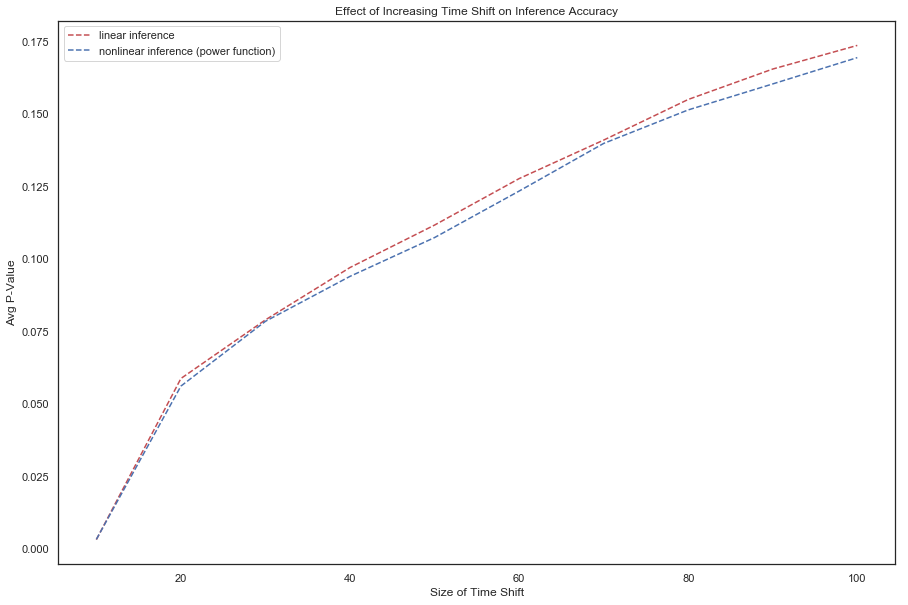

In [14]:
# plot p value by time shift here for both the linear and non linear methods
import seaborn as sns
sns.set(style='white', context='notebook', rc={'figure.figsize':(15,10)})
f = plt.figure()
plt.title('Effect of Increasing Time Shift on Inference Accuracy')
plt.xlabel('Size of Time Shift')
plt.ylabel('Avg P-Value')
plt.plot(timeshifts, pvalue_bytimeshift, 'r--', label='linear inference')
plt.plot(timeshifts, pvalue_bytimeshift_nl, 'b--', label='nonlinear inference (power function)')
plt.legend(loc = 'upper left')
plt.show()
f.savefig("linvnonlin_1.pdf", bbox_inches='tight')


In [ ]:
# plot p value by time shift here for both the linear and non linear methods
plt.plot(timeshifts, pvalue_linear_bytimeshift, 'r--')
plt.plot(timeshifts, pvalue_nonlinear_bytimeshift, 'b--')
plt.show()

In [ ]:
# allwmatrices is a dictionary with patient identifiers as keys. allwmatrices[key] will return the w matrix 
# for that specific patient
slope_average = 0
pvalue_nonlinear_average = 0
counter = 0
for patient in allwmatrices:
    w = allwmatrices[patient]
    sig = allsigs[patient]
    bias = allbiases[patient]
    
    w2 = allwmatrices2[patient]
    sig2 = allsigs2[patient]
    bias2 = allbiases2[patient]

    x_original = pca_data_dict[patient].T.copy()

    # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
    simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, power=1, bias=bias)
    
    simulated_data2 = simulate(pca_components, 1018, w=w2, sigma=sig2, rho=0, power=3, bias=bias2)

    # compute the time shift covariance matrices for the 'original' (transformed PCA MEG timecourse) and simulated data
    tsc_original = time_shift_cov(x_original, shift=10)
    tsc_simulated = time_shift_cov(simulated_data[0], shift=10)
    tsc_simulated2 = time_shift_cov(simulated_data2[0], shift=10)

    line_object = linregress(tsc_original, tsc_simulated)
    line_object2 = linregress(tsc_original, tsc_simulated2)
    plt.title('Patient ' + str(patient))
    plt.xlabel('time_shift_cov original')
    plt.ylabel('time_shift_cov simulated')
    plt.plot(tsc_original, tsc_simulated, 'ro', alpha=0.5)
    plt.plot(tsc_original, tsc_simulated2, 'bo', alpha=0.5)
    
    time_shift_axes = np.arange(-1, 2)
    plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'r--')
    plt.plot(time_shift_axes, (line_object2.slope*time_shift_axes)+line_object2.intercept, 'b--')
    
    plt.plot([-1, 1], [-1,1], 'g--')
    plt.show()

In [ ]:
for patient in allwmatrices2:
    w = allwmatrices[patient]
    sig = allsigs[patient]
    bias = allbiases[patient]

    x_original = pca_data_dict[patient].T.copy()

    # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
    simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, bias=bias, power=1)
    w_simulated, sig_simulated, bias_simulated = infer(simulated_data[0], power=power)
    
    line_object = linregress(w, w_simulated)
    plt.title('Patient ' + str(patient))
    plt.xlabel('W matrix original')
    plt.ylabel('W matrix simulated')
    plt.plot(w, w_simulated, 'ko', alpha=0.5)
    plt.plot([-1, 1], [-1,1], 'r--')
    time_shift_axes = np.arange(-1, 2)
    plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
    plt.show()
    print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
    print("--------------------------------------------------------------")

In [ ]:
#try to quantify pvalue cutoffs for certain time shifts

#run pca on the first 2-3 components of the W matrices
pca_wmatrices = []
for patient in allwmatrices2:
    print(allwmatrices2[patient].shape)
    pca_wmatrices.append(allwmatrices2[patient].flatten())

In [ ]:
np.matrix(pca_wmatrices).shape

In [ ]:
pca_w = PCA(n_components=10)
pca_w.fit(np.matrix(pca_wmatrices))
transformed_data_w = pca_w.fit_transform(np.matrix(pca_wmatrices))

In [ ]:
pca_tscmatrices = []
for patient in pca_data_dict:
    pca_tscmatrices.append(time_shift_cov(pca_data_dict[patient].T, shift=40).flatten())

In [ ]:
pca_tsc = PCA(n_components=10)
pca_tsc.fit(np.matrix(pca_wmatrices))
transformed_data_tsc = pca_tsc.fit_transform(np.matrix(pca_tscmatrices))

In [ ]:
transformed_data_w.shape

In [ ]:
# Cluster the wmatrices using spectral clustering
from sklearn.cluster import SpectralClustering
from scipy import stats
import numpy as np
from itertools import cycle, islice
clustering_w = SpectralClustering(assign_labels="discretize",
             random_state=0).fit(transformed_data_w)
# clustering = SpectralClustering(assign_labels="kmeans").fit(flattened_wmatrix_array)

cluster_dict_w = {}
counter = 0
for grouping in clustering_w.labels_:
    if grouping not in cluster_dict_w:
        cluster_dict_w[grouping] = [dataset_ids[counter]]
    else:
        cluster_dict_w[grouping].append(dataset_ids[counter])
    counter = counter + 1

for key in cluster_dict_w:
    print("Number of Patients in Cluster", key, ":", len(cluster_dict_w[key]))
    
cluster_number = len(cluster_dict_w.keys())

In [ ]:
# Cluster the wmatrices using spectral clustering
from sklearn.cluster import SpectralClustering
from scipy import stats
import numpy as np
from itertools import cycle, islice
clustering_tsc = SpectralClustering(assign_labels="discretize",
             random_state=0).fit(transformed_data_tsc)
# clustering = SpectralClustering(assign_labels="kmeans").fit(flattened_wmatrix_array)

cluster_dict_tsc = {}
counter = 0
for grouping in clustering_tsc.labels_:
    if grouping not in cluster_dict_tsc:
        cluster_dict_tsc[grouping] = [dataset_ids[counter]]
    else:
        cluster_dict_tsc[grouping].append(dataset_ids[counter])
    counter = counter + 1

for key in cluster_dict_tsc:
    print("Number of Patients in Cluster", key, ":", len(cluster_dict_tsc[key]))
    
cluster_number = len(cluster_dict_tsc.keys())

In [ ]:
clustering_w.labels_

In [ ]:
plt.scatter(transformed_data_w[:, 0], transformed_data_w[:, 1], c=clustering_w.labels_, s=50, cmap='Spectral')

In [ ]:
pvalue_avg = []
rvalue_avg = []
for patient in cluster_dict_w[1]:
    w = allwmatrices2[patient]
    sig = allsigs2[patient]
    bias = allbiases2[patient]
    simulated_patient = np.zeros((1018, pca_components))
    
    for i in range(100):
        simulated_patient_temp = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, bias=bias, power=3)
        simulated_patient += simulated_patient_temp[0]
    simulated_patient = simulated_patient/20
    
    tsc_original = time_shift_cov(pca_data_dict[patient].T, shift=50)
    tsc_simulated = time_shift_cov(simulated_patient, shift=50)
    
    line_object = linregress(tsc_original, tsc_simulated)
    plt.title('Patient ' + str(patient))
    plt.xlabel('time_shift_cov original')
    plt.ylabel('time_shift_cov simulated')
    plt.plot(tsc_original, tsc_simulated, 'ro', alpha=0.5)
    
    time_shift_axes = np.arange(-1, 2)
    plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'r--')
    
    plt.plot([-1, 1], [-1,1], 'g--')
    plt.show()
    plt.close()
    print(line_object.pvalue)
    print(line_object.rvalue)
    pvalue_avg.append(line_object.pvalue)
    rvalue_avg.append(line_object.rvalue)

print('mean p', np.mean(pvalue_avg))
print('std p', np.std(pvalue_avg))
print()
print('mean r', np.mean(rvalue_avg))
print('std r', np.std(rvalue_avg))


In [ ]:
pvalue_avg = []
rvalue_avg = []
for patient in cluster_dict_tsc[7]:
    w = allwmatrices2[patient]
    sig = allsigs2[patient]
    bias = allbiases2[patient]
    
    
    simulated_patient = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, bias=bias, power=3)
    tsc_original = time_shift_cov(pca_data_dict[patient].T, shift=40)
    tsc_simulated = time_shift_cov(simulated_patient[0], shift=40)
    
    line_object = linregress(tsc_original, tsc_simulated)
    plt.title('Patient ' + str(patient))
    plt.xlabel('time_shift_cov original')
    plt.ylabel('time_shift_cov simulated')
    plt.plot(tsc_original, tsc_simulated, 'ro', alpha=0.5)
    
    time_shift_axes = np.arange(-1, 2)
    plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'r--')
    
    plt.plot([-1, 1], [-1,1], 'g--')
    plt.show()
    plt.close()
    print(line_object.pvalue)
    print(line_object.rvalue)
    pvalue_avg.append(line_object.pvalue)
    rvalue_avg.append(line_object.rvalue)

print('mean p', np.mean(pvalue_avg))
print('std p', np.std(pvalue_avg))
print()
print('mean r', np.mean(rvalue_avg))
print('std r', np.std(rvalue_avg))

In [ ]:
plt.scatter(transformed_data_w[:, 0], transformed_data_w[:, 1], c=clustering_tsc.labels_, s=50, cmap='Spectral')

In [ ]:
cluster_dict_w

In [ ]:
#try to quantify pvalue cutoffs for certain time shifts

#run pca on the first 2-3 components of the W matrices
pca_tscmatrices = []
for patient in pca_data_dict:
    pca_tscmatrices.append(time_shift_cov(pca_data_dict[patient].T, shift=time_shift).flatten())

In [ ]:
np.matrix(pca_tscmatrices).shape

In [ ]:
pca_tsc = PCA(n_components=2)
pca_tsc.fit(np.matrix(pca_tscmatrices))
transformed_data_tsc = pca_tsc.fit_transform(np.matrix(pca_tscmatrices))

In [ ]:
transformed_data_tsc.shape

In [ ]:
plt.scatter(transformed_data_tsc[:, 0], transformed_data_tsc[:, 1], c=clustering_tsc.labels_, s=50, cmap='Spectral')

In [ ]:
plt.scatter(transformed_data_tsc[:, 0], transformed_data_tsc[:, 1], c=clustering_w.labels_, s=50, cmap='Spectral')

In [ ]:
# Cluster the wmatrices using spectral clustering
from sklearn.cluster import SpectralClustering
from scipy import stats
import numpy as np
from itertools import cycle, islice
clustering_tsc = SpectralClustering(assign_labels="discretize",
             random_state=0).fit(transformed_data_tsc)
# clustering = SpectralClustering(assign_labels="kmeans").fit(flattened_wmatrix_array)

cluster_dict_tsc = {}
counter = 0
for grouping in clustering_tsc.labels_:
    if grouping not in cluster_dict_tsc:
        cluster_dict_tsc[grouping] = [dataset_ids[counter]]
    else:
        cluster_dict_tsc[grouping].append(dataset_ids[counter])
    counter = counter + 1

for key in cluster_dict_tsc:
    print("Number of Patients in Cluster", key, ":", len(cluster_dict_tsc[key]))
    
cluster_number = len(cluster_dict_tsc.keys())

In [ ]:
#calculate the average w matrix for each cluster
avg_w_plot = {}
for key in cluster_dict_w:
    avg_w_matrix = np.zeros((pca_components, pca_components))
    count = 0
    for patient in cluster_dict_w[key]:
        avg_w_matrix += allwmatrices2[patient]
        count += 1
    avg_w_plot[key] = avg_w_matrix/count


In [ ]:
for key in avg_w_plot:
    for key2 in avg_w_plot:
        if key2 != key:
            line_object = linregress(avg_w_plot[key], avg_w_plot[key2])
            plt.title('Plot for ' + str(key) + ' and ' + str(key2))
            plt.plot(avg_w_plot[key], avg_w_plot[key2], 'ko', alpha=0.5)
            plt.plot([-1, 1], [-1,1], 'r--')
            time_shift_axes = np.arange(-1, 2)
            plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
            plt.show()
            plt.close()
            plt.show()
            print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
            print("--------------------------------------------------------------")

In [ ]:
for key in avg_w_plot:
    for key2 in avg_w_plot:
        if key2 != key:
            print(key, key2)
            subtract = avg_w_plot[key] - avg_w_plot[key2]
            seaborn.heatmap(subtract)
            plt.show()
            plt.close()

In [ ]:
# calculate the average tsc matrix for each cluster, and plot against each other
avg_tsc_plot = {}
for key in cluster_dict_tsc:
    avg_tsc_matrix = np.zeros((pca_components, pca_components))
    count = 0
    for patient in cluster_dict_tsc[key]:
        avg_tsc_matrix += time_shift_cov(pca_data_dict[patient].T, shift=time_shift)
        count += 1
    avg_tsc_plot[key] = avg_tsc_matrix/count

        


In [ ]:
for key in avg_tsc_plot:
    for key2 in avg_tsc_plot:
        if key2 != key:
            line_object = linregress(avg_tsc_plot[key], avg_tsc_plot[key2])
            plt.title('Plot for ' + str(key) + ' and ' + str(key2))
            plt.plot(avg_tsc_plot[key], avg_tsc_plot[key2], 'ko', alpha=0.5)
            plt.plot([-1, 1], [-1,1], 'r--')
            time_shift_axes = np.arange(-1, 2)
            plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
            plt.show()
            plt.close()
            plt.show()
            print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
            print("--------------------------------------------------------------")

In [ ]:
for key in avg_tsc_plot:
    for key2 in avg_tsc_plot:
        if key2 != key:
            subtract = avg_tsc_plot[key] - avg_tsc_plot[key2]
            seaborn.heatmap(subtract)
            plt.show()
            plt.close()

In [ ]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

def union(lst1, lst2):
    return list(set(lst1) | set(lst2))

In [ ]:
frequency_map = np.zeros((len(cluster_dict_w.keys()), len(cluster_dict_tsc.keys())))
for cluster in cluster_dict_w:
    for cluster2 in cluster_dict_tsc:
        if cluster2 > 2:
            frequency_map[cluster][cluster2-1] = len(intersection(cluster_dict_w[cluster], cluster_dict_tsc[cluster2]))/len(union(cluster_dict_w[cluster], cluster_dict_tsc[cluster2]))
        else:
            frequency_map[cluster][cluster2] = len(intersection(cluster_dict_w[cluster], cluster_dict_tsc[cluster2]))/len(union(cluster_dict_w[cluster], cluster_dict_tsc[cluster2]))
import seaborn
seaborn.heatmap(frequency_map, annot=True)    
plt.show()
plt.close()

In [ ]:
cluster_dict_w[1]

In [ ]:
cluster_dict_tsc[0]

In [ ]:
intersection(cluster_dict_w[1], cluster_dict_tsc[0])

In [ ]:
union(cluster_dict_w[1], cluster_dict_tsc[0])

In [ ]:
# are the same sets of patients in the same cluster groupings across time shift cov and w matrices?
for key in cluster_dict_w:
    print("Cluster", key, ":", cluster_dict_w[key])
print()
for key in cluster_dict_tsc:
    print("Cluster", key, ":", cluster_dict_tsc[key])
    
links = {}
for key in cluster_dict_w:
    for patient in cluster_dict_w[key]:
        for key2 in cluster_dict_tsc:
            for patient2 in cluster_dict_tsc[key2]:
                if patient == patient2:
                    #do something
                    links[patient] = (key, key2)
                    
# for key in cluster_dict_tsc:
#     for patient in cluster_dict_tsc[key]:
#         for key2 in cluster_dict_w:
#             for patient2 in cluster_dict_w[key2]:
#                 if patient == patient2:
#                     #do something
#                     links[patient] = (key, key2)

In [ ]:
links

In [ ]:
frequency_dict = {}
for value in links.values():
    if value not in frequency_dict:
        frequency_dict[value] = 1
    else:
        frequency_dict[value] += 1

for key in frequency_dict:
    if frequency_dict[key] >= 4 :
        print("Cluster Common Count:", key, "=", frequency_dict[key])

In [ ]:
# cluster_mapping_matrix = np.zeros((len(cluster_dict_w.keys()), len(cluster_dict_tsc.keys())))
# for key_w in cluster_dict_w:
#     for key_tsc in cluster_dict_tsc:
#         cluster_mapping_matrix[key_w][key_tsc] = len(intersection(cluster_dict_w[key_w], cluster_dict_tsc[key_tsc]))/len(union(cluster_dict_w[key_w], cluster_dict_tsc[key_tsc]))
        
# import seaborn
# seaborn.heatmap(cluster_mapping_matrix, annot=True)    
# plt.show()
# plt.close()


for num_clusters in range(4, 8):
    kmeans_labels_tsc = cluster.KMeans(n_clusters=num_clusters, random_state=42).fit_predict(flattened_tscmatrix_array)   
    kmeans_labels_w = cluster.KMeans(n_clusters=num_clusters, random_state=42).fit_predict(flattened_wmatrix_array)
    
    cluster_dict_kmeans_w = {}
    counter = 0
    for grouping in kmeans_labels_w:
        if grouping not in cluster_dict_kmeans_w:
            cluster_dict_kmeans_w[grouping] = [dataset_ids[counter]]
        else:
            cluster_dict_kmeans_w[grouping].append(dataset_ids[counter])
        counter = counter + 1

    cluster_dict_kmeans_tsc = {}
    counter = 0
    for grouping in kmeans_labels_tsc:
        if grouping not in cluster_dict_kmeans_tsc:
            cluster_dict_kmeans_tsc[grouping] = [dataset_ids[counter]]
        else:
            cluster_dict_kmeans_tsc[grouping].append(dataset_ids[counter])
        counter = counter + 1
     
    cluster_mapping_matrix = np.zeros((len(cluster_dict_kmeans_w.keys()), len(cluster_dict_kmeans_tsc.keys())))
    for key_w in cluster_dict_kmeans_tsc:
        for key_tsc in cluster_dict_kmeans_tsc:
            cluster_mapping_matrix[key_w][key_tsc] = len(intersection(cluster_dict_kmeans_w[key_w], cluster_dict_kmeans_tsc[key_tsc]))/len(union(cluster_dict_kmeans_w[key_w], cluster_dict_kmeans_tsc[key_tsc]))
    
    import seaborn
    seaborn.heatmap(cluster_mapping_matrix, annot=True)    
    plt.show()
    plt.close()

# Separator

In [ ]:
pca_wmatrix_dictionary = {}
counter = 0
for patient in allwmatrices2:
    pca_wmatrix_dictionary[patient] = transformed_data_w[counter*10:10*(counter+1), :].T
    counter = counter + 1

In [ ]:
pca_wmatrix_dictionary

In [ ]:
# spectral clustering, spectrally cluster the W matrices of all the patients to see if certain patients fall into 
# certain categories. Do for all 88 patients

# prepare a matrix to input into the spectral clustering function, must flatten all the W matrices
def wmatrix_clustering_prepare(allwmatrices):
    flattened_wmatrix_array = []
    unflattened_wmatrix_dict = {}
    counter = 0
    for patient in allwmatrices:
        flattened_matrix = allwmatrices[patient].flatten()
        unflattened_wmatrix_dict[counter] = allwmatrices[patient]
        if len(flattened_wmatrix_array) == 0:
            flattened_wmatrix_array = [flattened_matrix]
        else:
            flattened_wmatrix_array.append(flattened_matrix)
        counter = counter + 1
    return flattened_wmatrix_array, unflattened_wmatrix_dict

flattened_wmatrix_array, unflattened_wmatrix_dict = wmatrix_clustering_prepare(pca_wmatrix_dictionary)

# Cluster the wmatrices using spectral clustering
from sklearn.cluster import SpectralClustering
from scipy import stats
import numpy as np
from itertools import cycle, islice
clustering_w = SpectralClustering(assign_labels="discretize",
             random_state=0).fit(flattened_wmatrix_array)
# clustering = SpectralClustering(assign_labels="kmeans").fit(flattened_wmatrix_array)

cluster_dict_w = {}
counter = 0
for grouping in clustering_w.labels_:
    if grouping not in cluster_dict_w:
        cluster_dict_w[grouping] = [dataset_ids[counter]]
    else:
        cluster_dict_w[grouping].append(dataset_ids[counter])
    counter = counter + 1

for key in cluster_dict_w:
    print("Number of Patients in Cluster", key, ":", len(cluster_dict_w[key]))
    
cluster_number = len(cluster_dict_w.keys())

In [ ]:
import umap
from sklearn.datasets import load_digits

standard_embedding_w = umap.UMAP(random_state=42).fit_transform(np.matrix(flattened_wmatrix_array))
w_embedded = TSNE(n_components=2, random_state=42).fit_transform(flattened_wmatrix_array)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='white', context='notebook', rc={'figure.figsize':(8,8)})
plt.scatter(standard_embedding_w[:, 0], standard_embedding_w[:, 1], c=clustering_w.labels_, s=100, cmap='Spectral');
plt.show()
plt.close()

plt.scatter(w_embedded[:, 0], w_embedded[:, 1], c=clustering_w.labels_, s=100, cmap='Spectral');
plt.show()
plt.close()

In [ ]:
from sklearn.manifold import TSNE
sns.set(style='white', context='notebook', rc={'figure.figsize':(8,8)})

w_embedded = TSNE(n_components=2, random_state=42).fit_transform(flattened_wmatrix_array)

import sklearn.cluster as cluster
kmeans_labels_w = cluster.KMeans(n_clusters=8, random_state=42).fit_predict(flattened_wmatrix_array)

plt.scatter(standard_embedding_w[:, 0], standard_embedding_w[:, 1], c=kmeans_labels_w, s=100, cmap='Spectral');
plt.show()
plt.close()

plt.scatter(w_embedded[:, 0], w_embedded[:, 1], c=kmeans_labels_w, s=100, cmap='Spectral');
plt.show()
plt.close()

In [ ]:
print(kmeans_labels_w)